In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, \
                            recall_score, f1_score, log_loss

from tqdm.notebook import tqdm

RAND = 42

In [3]:
db = pd.read_parquet(
    "/home/sergey/projects/Credit_scoring/raw/train_data/train_data_0.pq", 
    engine="pyarrow"
)

In [4]:
def get_bins_target(df: pd.DataFrame, target_name: str) -> None:
    # нормирование на размер датасета
    norm_target = (df[target_name].value_counts(
        normalize=True).mul(100).rename('percent').reset_index())

    plt.figure(figsize=(15, 7))
    ax = sns.barplot(x='index', y='percent', data=norm_target)

    # Вывод значений над графиками - annotate()
    # В цикле смотрим каждый столбец графика и на нем отмечаем значения
    for p in ax.patches:
        percentage = '{:.1f}%'.format(p.get_height())
        ax.annotate(
            percentage,  # текст
            # координата xy
            (p.get_x() + p.get_width() / 2., p.get_height()),
            # центрирование
            ha='center',
            va='center',
            xytext=(0, 10),
            # точка смещения относительно координаты
            textcoords='offset points',
            fontsize=14)

    plt.title(target_name, fontsize=20)
    plt.xlabel(target_name, fontsize=14)
    plt.ylabel('Проценты', fontsize=14)

    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.show()

In [5]:
def get_metrics(y_test, y_pred, y_score, name = "Default"):
    """Метрики для задачи классификации"""
    df_metrics = pd.DataFrame()

    df_metrics['model'] = [name]
    df_metrics['Accuracy'] = accuracy_score(y_test, y_pred)
    df_metrics['ROC_AUC'] = roc_auc_score(y_test, y_score[:, 1])
    df_metrics['Precision'] = precision_score(y_test, y_pred)
    df_metrics['Recall'] = recall_score(y_test, y_pred)
    df_metrics['f1'] = f1_score(y_test, y_pred)
    df_metrics['Logloss'] = log_loss(y_test, y_score)

    return df_metrics

In [6]:
def barplot_group(col_main: str, col_group: str, title: str = None) -> None:
    """
    Построение barplot с нормированными данными с выводом значений на графике
    """

    plt.figure(figsize=(15, 6))

    data = (df.groupby([col_group])[col_main]
            .value_counts(normalize=True)
            .rename('percentage')
            .mul(100)
            .reset_index()
            .sort_values(col_group))

    ax = sns.barplot(x=col_main, y="percentage",
                     hue=col_group, data=data, palette='rocket')

    for p in ax.patches:
        percentage = '{:.1f}%'.format(p.get_height())
        ax.annotate(percentage,  # текст
                    (p.get_x() + p.get_width() / 2.,
                     p.get_height()),  # координата xy
                    ha='center',  # центрирование
                    va='center',
                    xytext=(0, 7),
                    textcoords='offset points',  # точка смещения относительно координаты
                    fontsize=12)

    plt.title(title, fontsize=16)
    plt.ylabel('Percentage', fontsize=14)
    plt.xlabel(col_main, fontsize=14)
    plt.show()

In [7]:
db[:5]

id  rn  pre_since_opened  pre_since_confirmed  pre_pterm  pre_fterm  \
0   0   1                18                    9          2          3   
1   0   2                18                    9         14         14   
2   0   3                18                    9          4          8   
3   0   4                 4                    1          9         12   
4   0   5                 5                   12         15          2   

   pre_till_pclose  pre_till_fclose  pre_loans_credit_limit  \
0               16               10                      11   
1               12               12                       0   
2                1               11                      11   
3               16                7                      12   
4               11               12                      10   

   pre_loans_next_pay_summ  ...  enc_paym_21  enc_paym_22  enc_paym_23  \
0                        3  ...            3            3            3   
1                        3  ...            0            0            0   
2                        0  ...            0            0            0   
3                        2  ...            3            3            3   
4                        2  ...            3            3            3   

   enc_paym_24  enc_loans_account_holder_type  enc_loans_credit_status  \
0            4                              1                        3   
1            4                              1                        3   
2            4                              1                        2   
3            4                              1                        3   
4            4                              1                        3   

   enc_loans_credit_type  enc_loans_account_cur  pclose_flag  fclose_flag  
0                      4                      1            0            0  
1                      4                      1            0            0  
2                      3                      1            1            1  
3                      1                      1            0            0  
4                      4                      1            0            0  

[5 rows x 61 columns]

In [8]:
db.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1974724 entries, 0 to 1974723
Data columns (total 61 columns):
 #   Column                         Dtype
---  ------                         -----
 0   id                             int64
 1   rn                             int64
 2   pre_since_opened               int64
 3   pre_since_confirmed            int64
 4   pre_pterm                      int64
 5   pre_fterm                      int64
 6   pre_till_pclose                int64
 7   pre_till_fclose                int64
 8   pre_loans_credit_limit         int64
 9   pre_loans_next_pay_summ        int64
 10  pre_loans_outstanding          int64
 11  pre_loans_total_overdue        int64
 12  pre_loans_max_overdue_sum      int64
 13  pre_loans_credit_cost_rate     int64
 14  pre_loans5                     int64
 15  pre_loans530                   int64
 16  pre_loans3060                  int64
 17  pre_loans6090                  int64
 18  pre_loans90                    int64
 19  

In [9]:
db = db.set_index(["id", "rn"])

In [10]:
db.isna().sum()

pre_since_opened                 0
pre_since_confirmed              0
pre_pterm                        0
pre_fterm                        0
pre_till_pclose                  0
pre_till_fclose                  0
pre_loans_credit_limit           0
pre_loans_next_pay_summ          0
pre_loans_outstanding            0
pre_loans_total_overdue          0
pre_loans_max_overdue_sum        0
pre_loans_credit_cost_rate       0
pre_loans5                       0
pre_loans530                     0
pre_loans3060                    0
pre_loans6090                    0
pre_loans90                      0
is_zero_loans5                   0
is_zero_loans530                 0
is_zero_loans3060                0
is_zero_loans6090                0
is_zero_loans90                  0
pre_util                         0
pre_over2limit                   0
pre_maxover2limit                0
is_zero_util                     0
is_zero_over2limit               0
is_zero_maxover2limit            0
enc_paym_0          

In [11]:
db.shape

(1974724, 59)

In [12]:
db.describe().iloc[1:, :]

pre_since_opened  pre_since_confirmed  pre_pterm  pre_fterm  \
mean          9.271325             8.330264   8.299071   8.309444   
std           5.773757             4.593511   5.245598   4.464844   
min           0.000000             0.000000   0.000000   0.000000   
25%           4.000000             5.000000   4.000000   6.000000   
50%           9.000000             9.000000   8.000000   8.000000   
75%          14.000000            11.000000  13.000000  12.000000   
max          19.000000            17.000000  17.000000  16.000000   

      pre_till_pclose  pre_till_fclose  pre_loans_credit_limit  \
mean         6.991781         8.337011                9.740888   
std          5.184165         4.233992                5.799625   
min          0.000000         0.000000                0.000000   
25%          1.000000         5.000000                5.000000   
50%          6.000000        10.000000               10.000000   
75%         12.000000        11.000000               15.000000   
max         16.000000        15.000000               19.000000   

      pre_loans_next_pay_summ  pre_loans_outstanding  pre_loans_total_overdue  \
mean                 2.399848               3.012951                      0.0   
std                  1.376391               0.683844                      0.0   
min                  0.000000               1.000000                      0.0   
25%                  2.000000               3.000000                      0.0   
50%                  2.000000               3.000000                      0.0   
75%                  2.000000               3.000000                      0.0   
max                  6.000000               5.000000                      0.0   

      ...  enc_paym_21  enc_paym_22  enc_paym_23  enc_paym_24  \
mean  ...     2.313242     2.343014     2.376717     3.576724   
std   ...     1.247674     1.228473     1.205555     1.035586   
min   ...     0.000000     0.000000     0.000000     1.000000   
25%   ...     3.000000     3.000000     3.000000     4.000000   
50%   ...     3.000000     3.000000     3.000000     4.000000   
75%   ...     3.000000     3.000000     3.000000     4.000000   
max   ...     3.000000     3.000000     3.000000     4.000000   

      enc_loans_account_holder_type  enc_loans_credit_status  \
mean                       1.027562                 2.694898   
std                        0.276702                 0.489136   
min                        0.000000                 0.000000   
25%                        1.000000                 2.000000   
50%                        1.000000                 3.000000   
75%                        1.000000                 3.000000   
max                        6.000000                 6.000000   

      enc_loans_credit_type  enc_loans_account_cur  pclose_flag  fclose_flag  
mean               3.353936               1.002386     0.172138     0.223934  
std                1.057304               0.059093     0.377501     0.416878  
min                0.000000               0.000000     0.000000     0.000000  
25%                3.000000               1.000000     0.000000     0.000000  
50%                4.000000               1.000000     0.000000     0.000000  
75%                4.000000               1.000000     0.000000     0.000000  
max                5.000000               3.000000     1.000000     1.000000  

[7 rows x 59 columns]

In [13]:
db.columns

Index(['pre_since_opened', 'pre_since_confirmed', 'pre_pterm', 'pre_fterm',
       'pre_till_pclose', 'pre_till_fclose', 'pre_loans_credit_limit',
       'pre_loans_next_pay_summ', 'pre_loans_outstanding',
       'pre_loans_total_overdue', 'pre_loans_max_overdue_sum',
       'pre_loans_credit_cost_rate', 'pre_loans5', 'pre_loans530',
       'pre_loans3060', 'pre_loans6090', 'pre_loans90', 'is_zero_loans5',
       'is_zero_loans530', 'is_zero_loans3060', 'is_zero_loans6090',
       'is_zero_loans90', 'pre_util', 'pre_over2limit', 'pre_maxover2limit',
       'is_zero_util', 'is_zero_over2limit', 'is_zero_maxover2limit',
       'enc_paym_0', 'enc_paym_1', 'enc_paym_2', 'enc_paym_3', 'enc_paym_4',
       'enc_paym_5', 'enc_paym_6', 'enc_paym_7', 'enc_paym_8', 'enc_paym_9',
       'enc_paym_10', 'enc_paym_11', 'enc_paym_12', 'enc_paym_13',
       'enc_paym_14', 'enc_paym_15', 'enc_paym_16', 'enc_paym_17',
       'enc_paym_18', 'enc_paym_19', 'enc_paym_20', 'enc_paym_21',
       'enc_paym_22

In [14]:
db[:5]

pre_since_opened  pre_since_confirmed  pre_pterm  pre_fterm  \
id rn                                                                
0  1                 18                    9          2          3   
   2                 18                    9         14         14   
   3                 18                    9          4          8   
   4                  4                    1          9         12   
   5                  5                   12         15          2   

       pre_till_pclose  pre_till_fclose  pre_loans_credit_limit  \
id rn                                                             
0  1                16               10                      11   
   2                12               12                       0   
   3                 1               11                      11   
   4                16                7                      12   
   5                11               12                      10   

       pre_loans_next_pay_summ  pre_loans_outstanding  \
id rn                                                   
0  1                         3                      3   
   2                         3                      3   
   3                         0                      5   
   4                         2                      3   
   5                         2                      3   

       pre_loans_total_overdue  ...  enc_paym_21  enc_paym_22  enc_paym_23  \
id rn                           ...                                          
0  1                         0  ...            3            3            3   
   2                         0  ...            0            0            0   
   3                         0  ...            0            0            0   
   4                         0  ...            3            3            3   
   5                         0  ...            3            3            3   

       enc_paym_24  enc_loans_account_holder_type  enc_loans_credit_status  \
id rn                                                                        
0  1             4                              1                        3   
   2             4                              1                        3   
   3             4                              1                        2   
   4             4                              1                        3   
   5             4                              1                        3   

       enc_loans_credit_type  enc_loans_account_cur  pclose_flag  fclose_flag  
id rn                                                                          
0  1                       4                      1            0            0  
   2                       4                      1            0            0  
   3                       3                      1            1            1  
   4                       1                      1            0            0  
   5                       4                      1            0            0  

[5 rows x 59 columns]

In [15]:
db.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1974724 entries, (0, 1) to (249999, 3)
Data columns (total 59 columns):
 #   Column                         Dtype
---  ------                         -----
 0   pre_since_opened               int64
 1   pre_since_confirmed            int64
 2   pre_pterm                      int64
 3   pre_fterm                      int64
 4   pre_till_pclose                int64
 5   pre_till_fclose                int64
 6   pre_loans_credit_limit         int64
 7   pre_loans_next_pay_summ        int64
 8   pre_loans_outstanding          int64
 9   pre_loans_total_overdue        int64
 10  pre_loans_max_overdue_sum      int64
 11  pre_loans_credit_cost_rate     int64
 12  pre_loans5                     int64
 13  pre_loans530                   int64
 14  pre_loans3060                  int64
 15  pre_loans6090                  int64
 16  pre_loans90                    int64
 17  is_zero_loans5                 int64
 18  is_zero_loans530               in

In [16]:
Y = pd.read_csv(
    "/home/sergey/projects/Credit_scoring/raw/train_target.csv",
    nrows=250000
)

In [17]:
Y = Y.set_index('id')

In [18]:
df = db.reset_index(level=1).groupby(level=0).last().join(Y)

In [19]:
df[:5]

rn  pre_since_opened  pre_since_confirmed  pre_pterm  pre_fterm  \
id                                                                    
0   10                 7                    9          2         10   
1   14                12                    6          1          8   
2    3                12                    9          4          8   
3   15                12                    9          2         10   
4    1                12                    9          4          8   

    pre_till_pclose  pre_till_fclose  pre_loans_credit_limit  \
id                                                             
0                 8                8                      16   
1                14               11                      11   
2                 1               11                       1   
3                 8                8                      17   
4                 1               11                      12   

    pre_loans_next_pay_summ  pre_loans_outstanding  ...  enc_paym_22  \
id                                                  ...                
0                         4                      2  ...            3   
1                         2                      3  ...            3   
2                         1                      4  ...            3   
3                         1                      2  ...            3   
4                         1                      3  ...            3   

    enc_paym_23  enc_paym_24  enc_loans_account_holder_type  \
id                                                            
0             3            4                              1   
1             3            4                              1   
2             3            4                              1   
3             3            4                              1   
4             3            4                              1   

    enc_loans_credit_status  enc_loans_credit_type  enc_loans_account_cur  \
id                                                                          
0                         2                      4                      1   
1                         2                      3                      1   
2                         2                      3                      1   
3                         2                      4                      1   
4                         2                      3                      1   

    pclose_flag  fclose_flag  flag  
id                                  
0             0            0     0  
1             0            1     0  
2             1            1     0  
3             0            0     0  
4             1            1     0  

[5 rows x 61 columns]

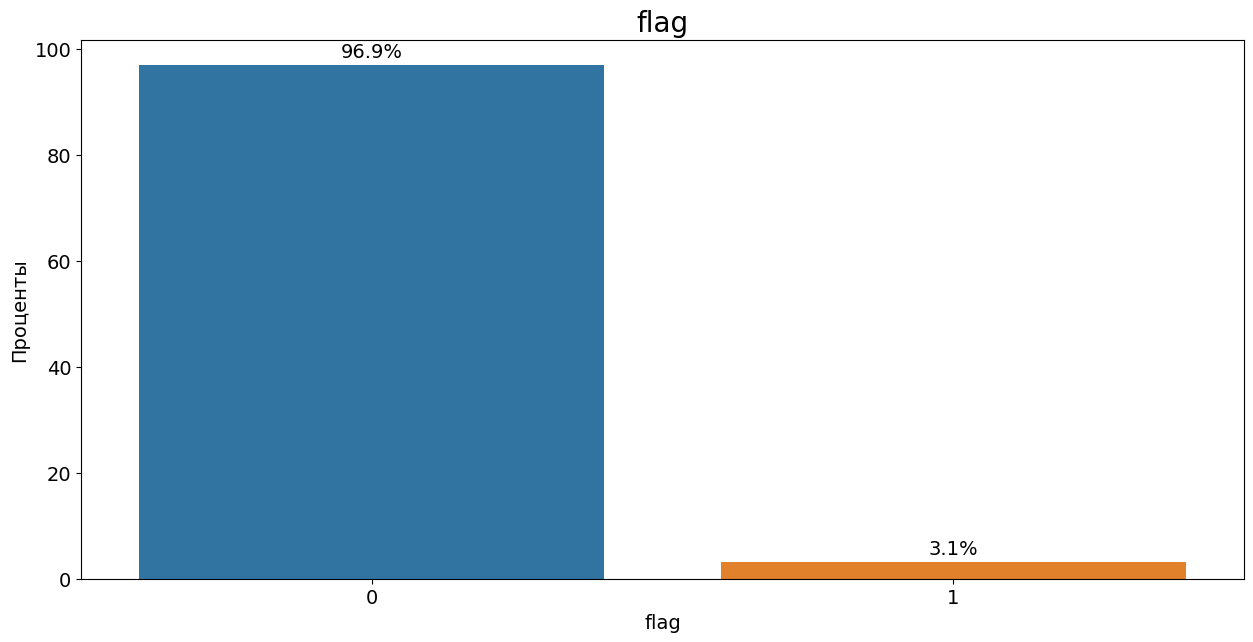

In [15]:
get_bins_target(df, "flag")

In [20]:
df_zeros = pd.DataFrame(index=range(250000), 
                        columns=db.columns, 
                        data=np.zeros((250000, db.shape[1])))
df_zeros.update(db.groupby(level=0).nth(-2))

df = df.join(df_zeros, rsuffix='_2')

In [21]:
df_zeros = pd.DataFrame(index=range(250000), 
                        columns=db.columns, 
                        data=np.zeros((250000, db.shape[1])))
df_zeros.update(db.groupby(level=0).nth(-3))

df = df.join(df_zeros, rsuffix='_3')

In [22]:
df_zeros = pd.DataFrame(index=range(250000), 
                        columns=db.columns, 
                        data=np.zeros((250000, db.shape[1])))
df_zeros.update(db.groupby(level=0).nth(-4))

df = df.join(df_zeros, rsuffix='_4')

In [30]:
df_zeros = pd.DataFrame(index=range(250000), 
                        columns=db.columns, 
                        data=np.zeros((250000, db.shape[1])))
df_zeros.update(db.groupby(level=0).nth(-5))

df = df.join(df_zeros, rsuffix='_5')

<Axes: xlabel='flag', ylabel='rn'>

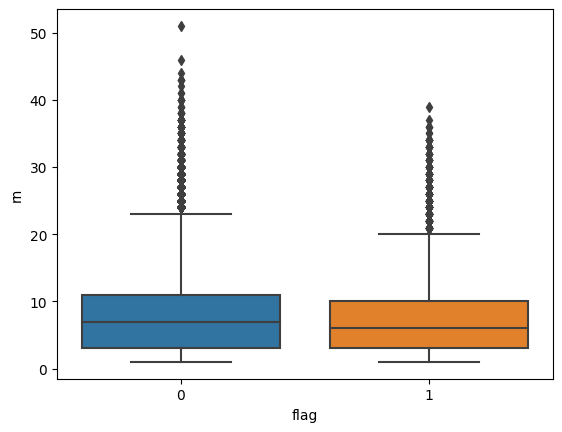

In [19]:
sns.boxplot(x=df.flag, y=df.rn)

In [20]:
df.nunique()[df.nunique() == 1]

pre_loans_total_overdue      1
pre_loans_total_overdue_2    1
pre_loans_total_overdue_3    1
pre_loans_total_overdue_4    1
dtype: int64

In [23]:
df = df.drop(columns=["pre_loans_total_overdue", 
                      "pre_loans_total_overdue_2", 
                      "pre_loans_total_overdue_3",
                      "pre_loans_total_overdue_4"
                     ])

In [21]:
df.nunique()[df.nunique() == 2].index

Index(['pre_loans6090', 'is_zero_loans5', 'is_zero_loans530',
       'is_zero_loans3060', 'is_zero_loans6090', 'is_zero_loans90',
       'is_zero_util', 'is_zero_over2limit', 'is_zero_maxover2limit',
       'pclose_flag', 'fclose_flag', 'flag', 'is_zero_loans5_2',
       'is_zero_loans530_2', 'is_zero_loans3060_2', 'is_zero_loans6090_2',
       'is_zero_loans90_2', 'is_zero_util_2', 'is_zero_over2limit_2',
       'is_zero_maxover2limit_2', 'pclose_flag_2', 'fclose_flag_2',
       'is_zero_loans5_3', 'is_zero_loans530_3', 'is_zero_loans3060_3',
       'is_zero_loans6090_3', 'is_zero_loans90_3', 'is_zero_util_3',
       'is_zero_over2limit_3', 'is_zero_maxover2limit_3', 'pclose_flag_3',
       'fclose_flag_3', 'is_zero_loans5_4', 'is_zero_loans530_4',
       'is_zero_loans3060_4', 'is_zero_loans6090_4', 'is_zero_loans90_4',
       'is_zero_util_4', 'is_zero_over2limit_4', 'is_zero_maxover2limit_4',
       'pclose_flag_4', 'fclose_flag_4'],
      dtype='object')

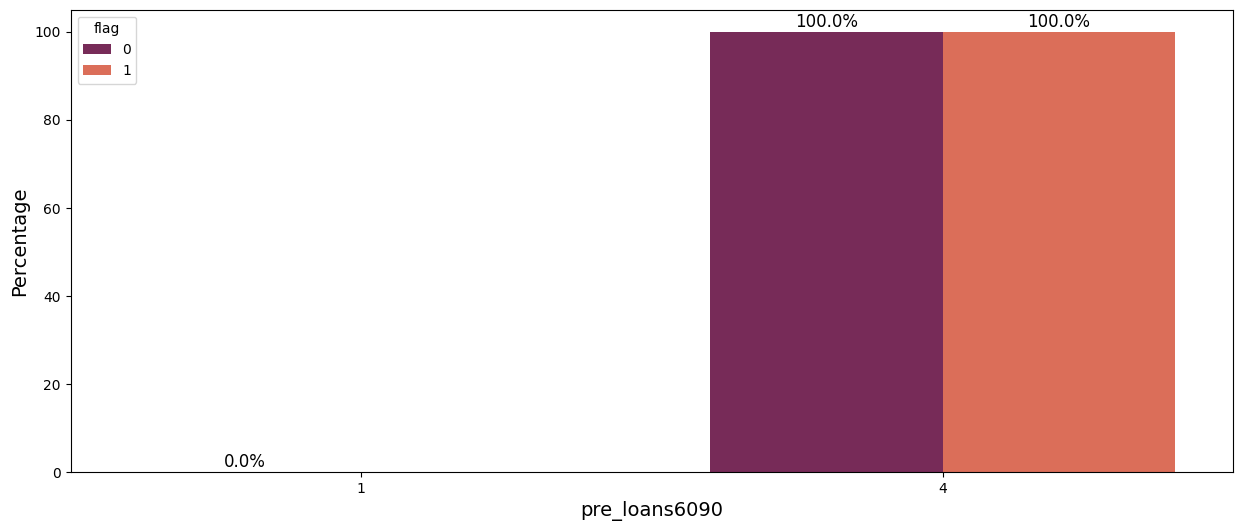

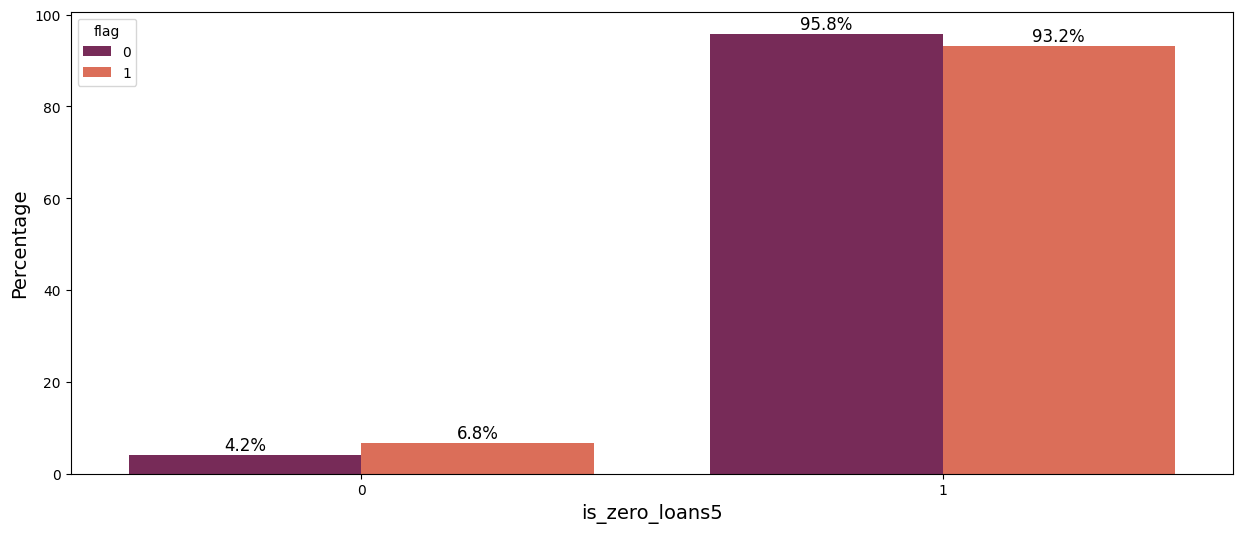

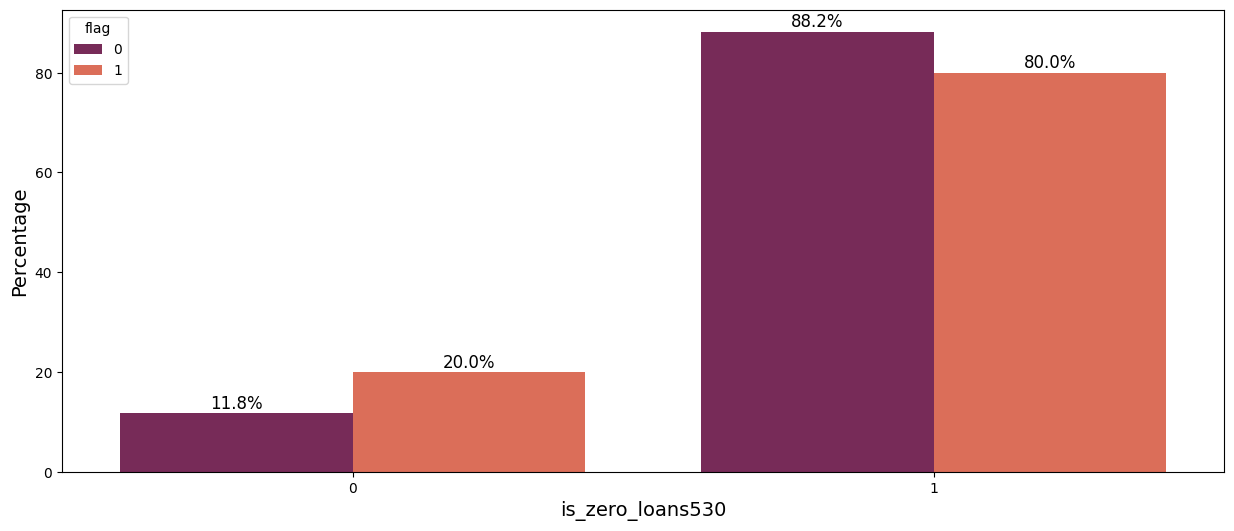

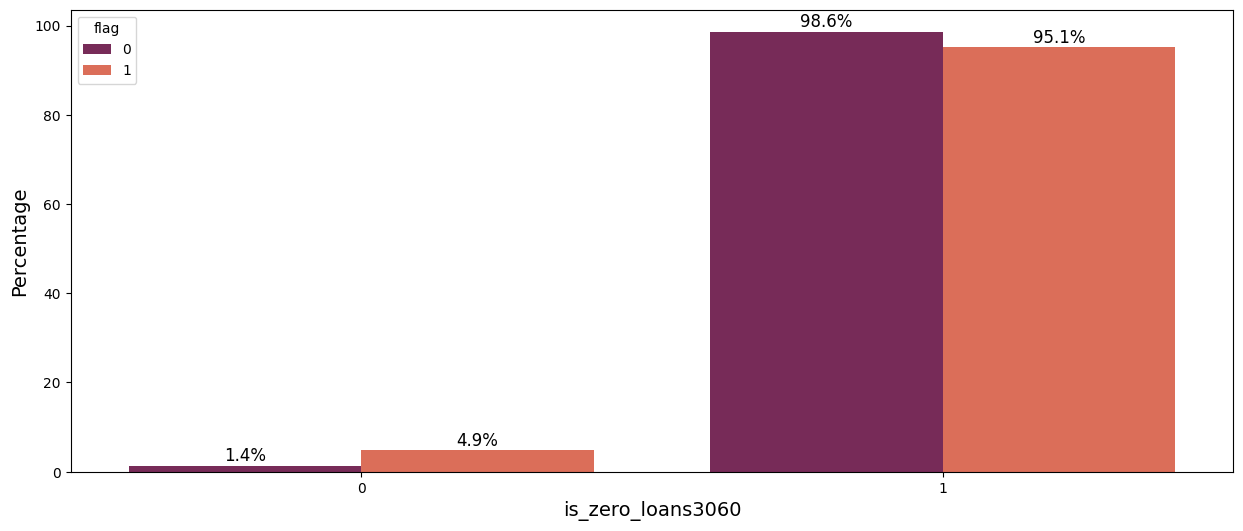

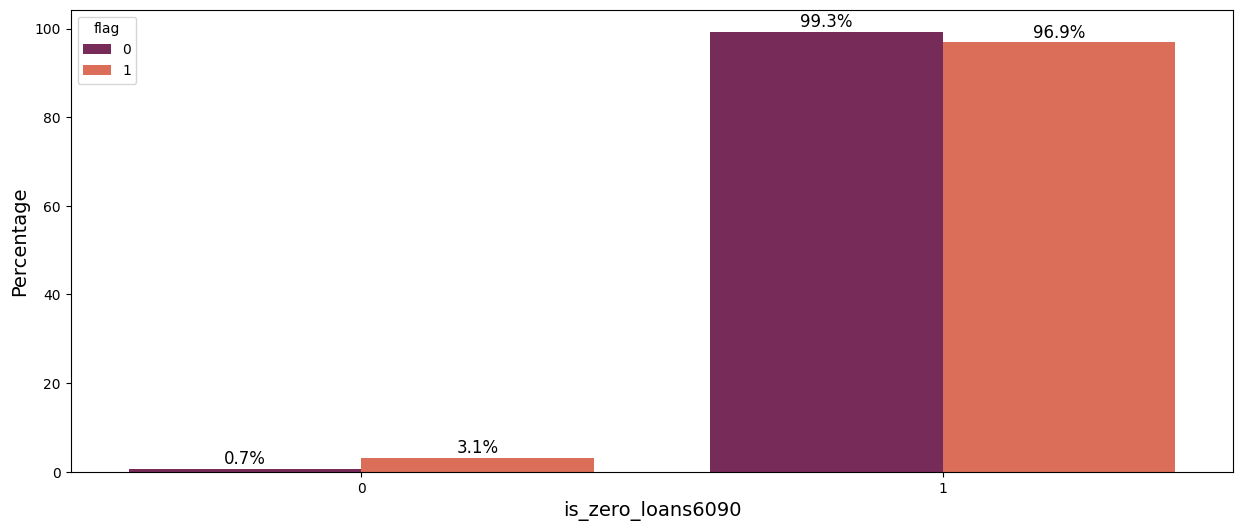

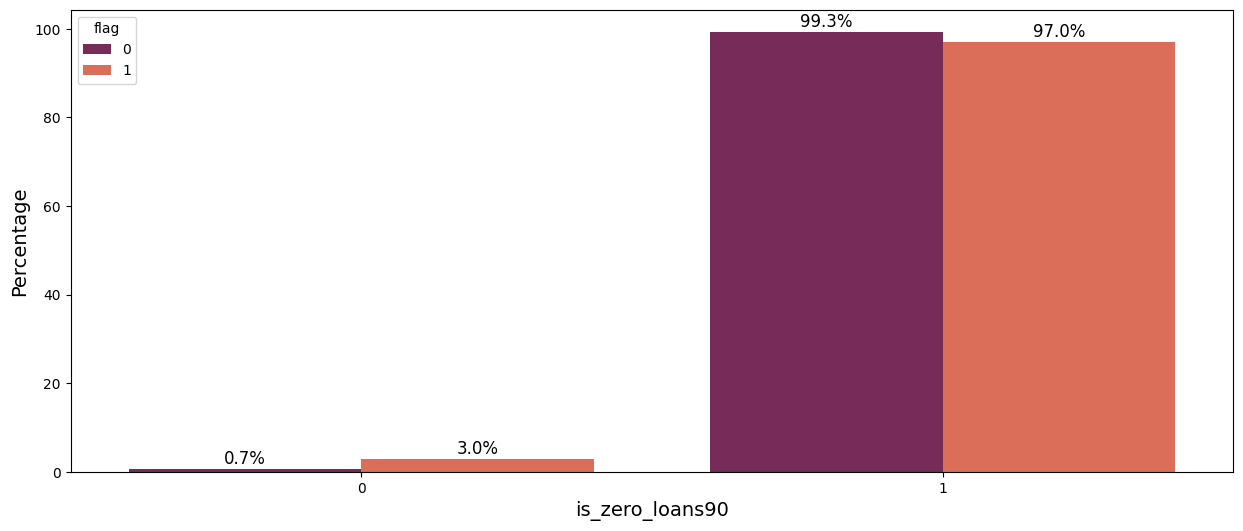

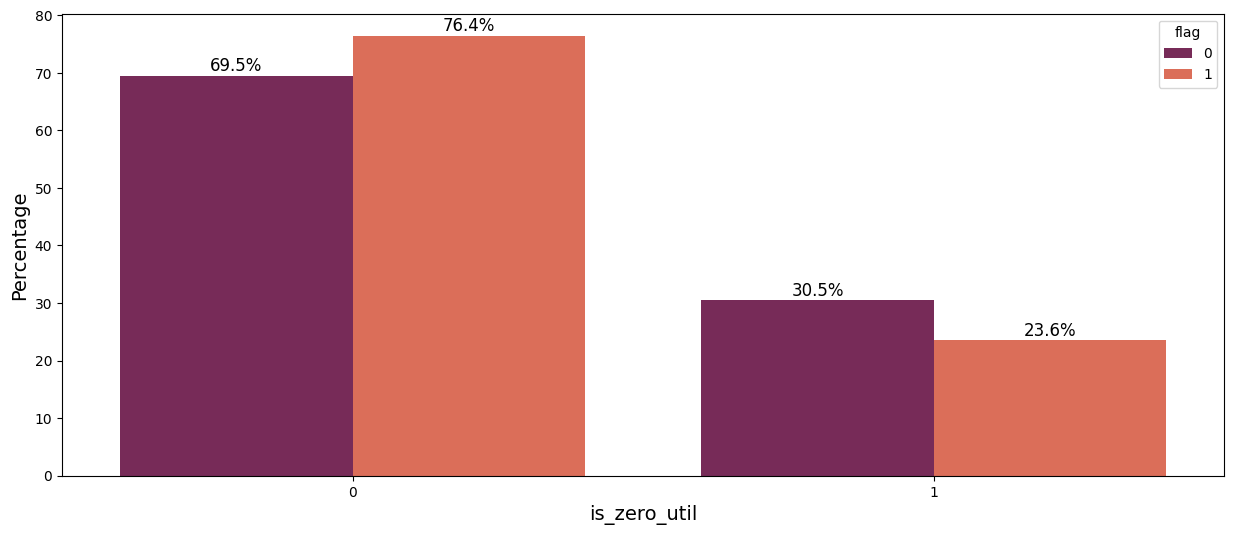

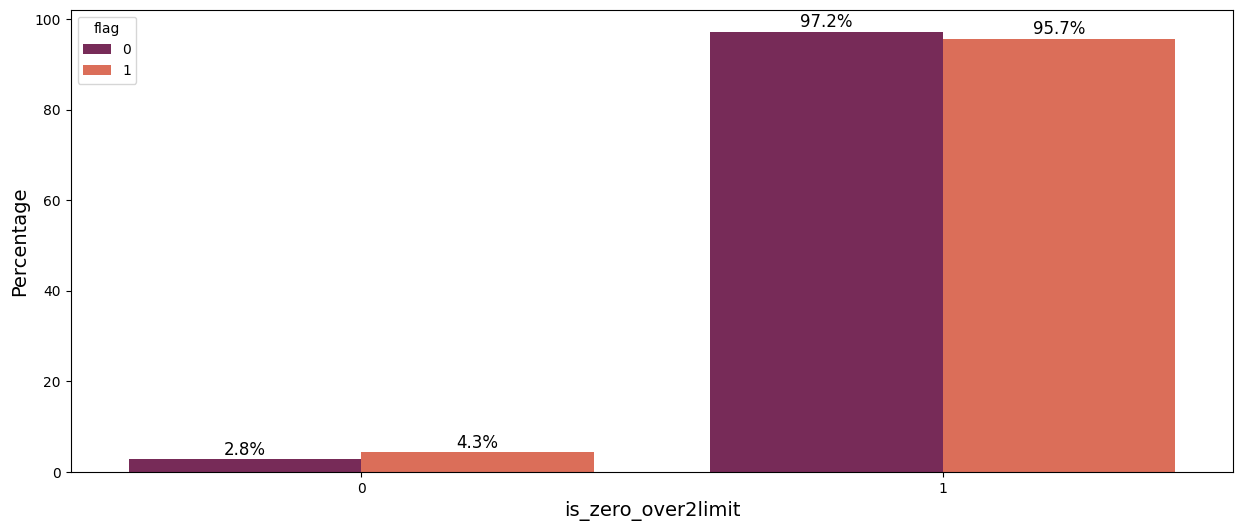

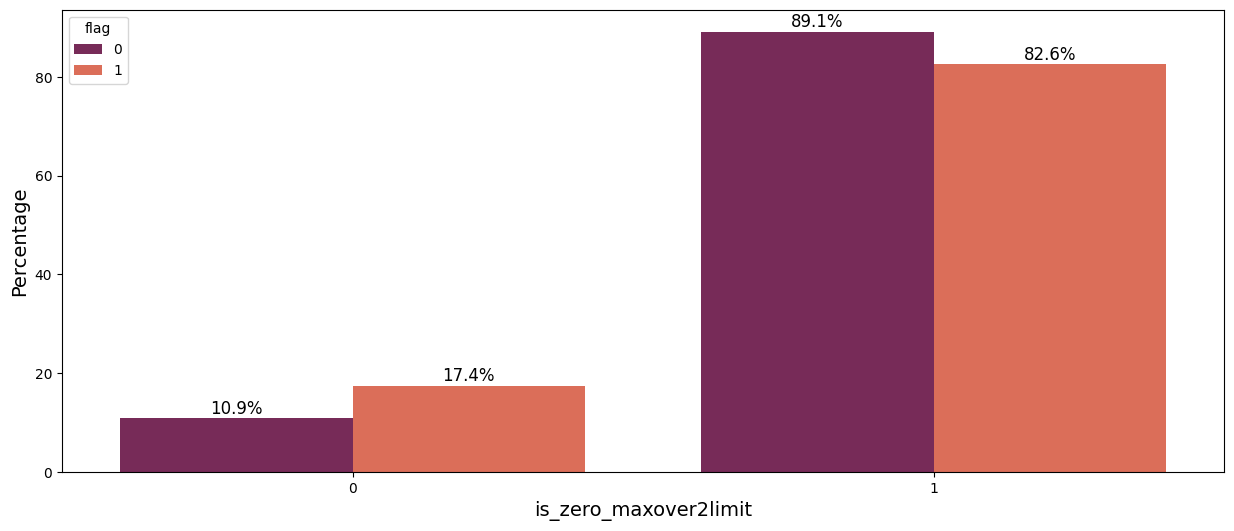

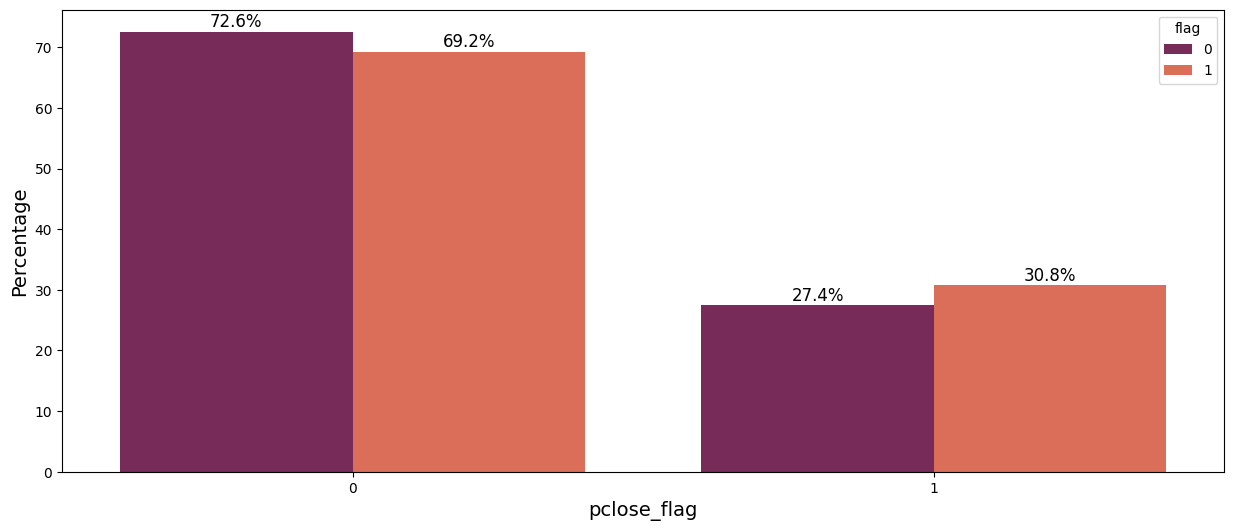

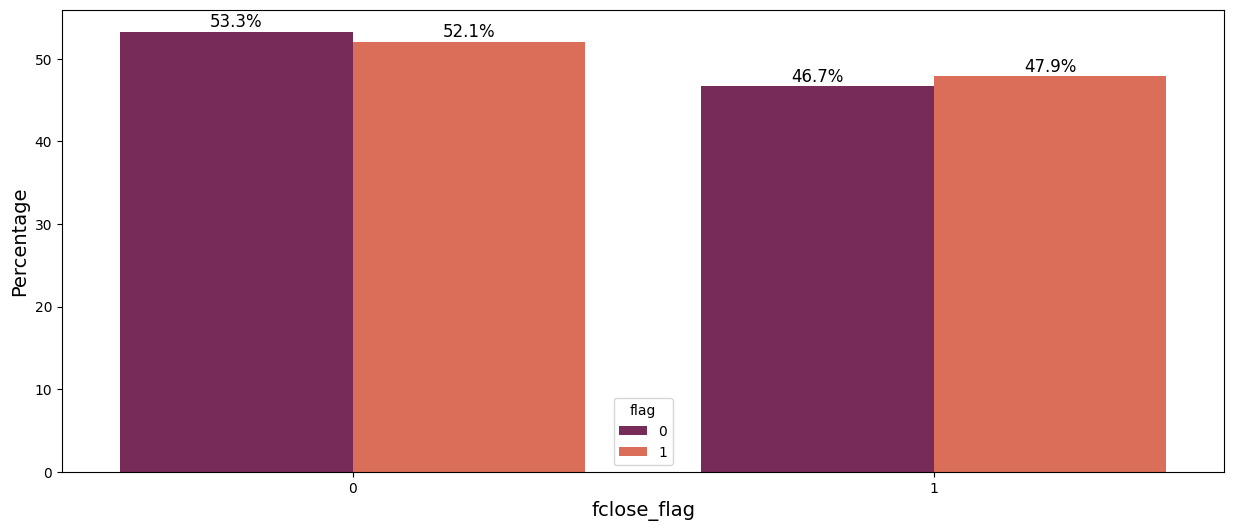

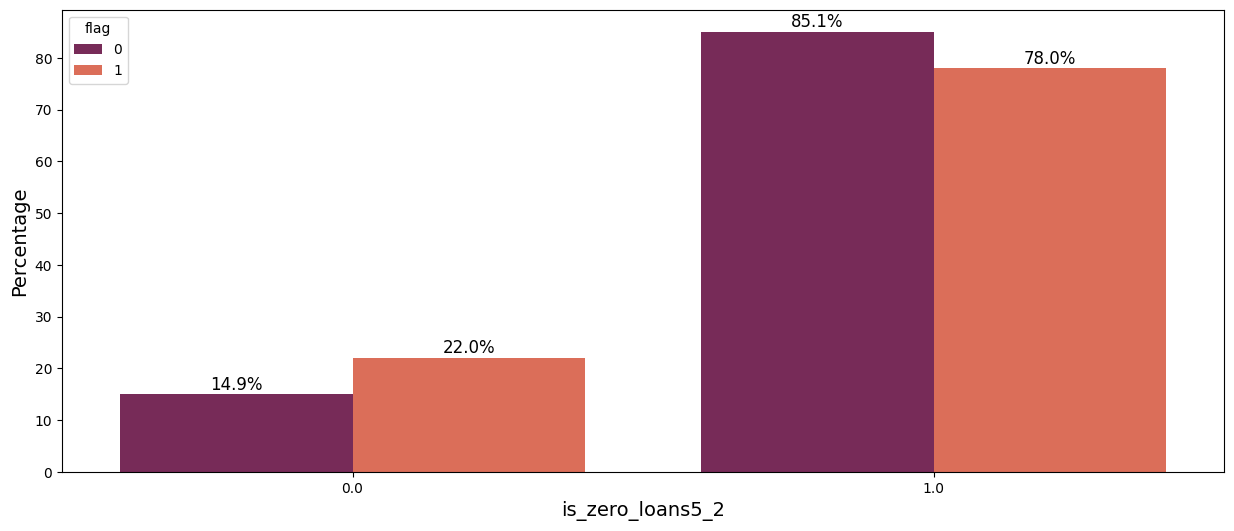

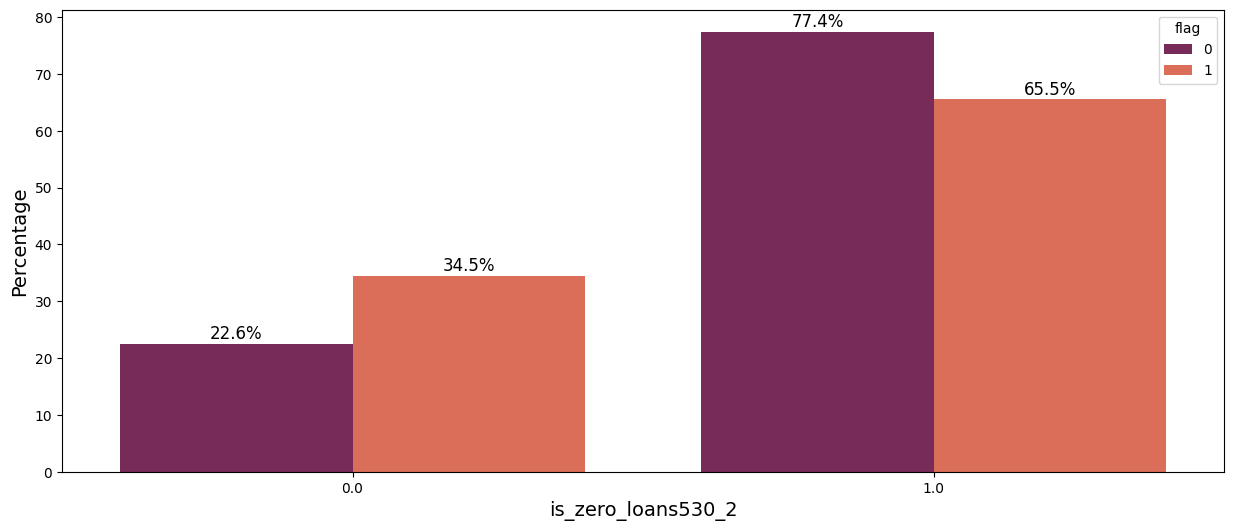

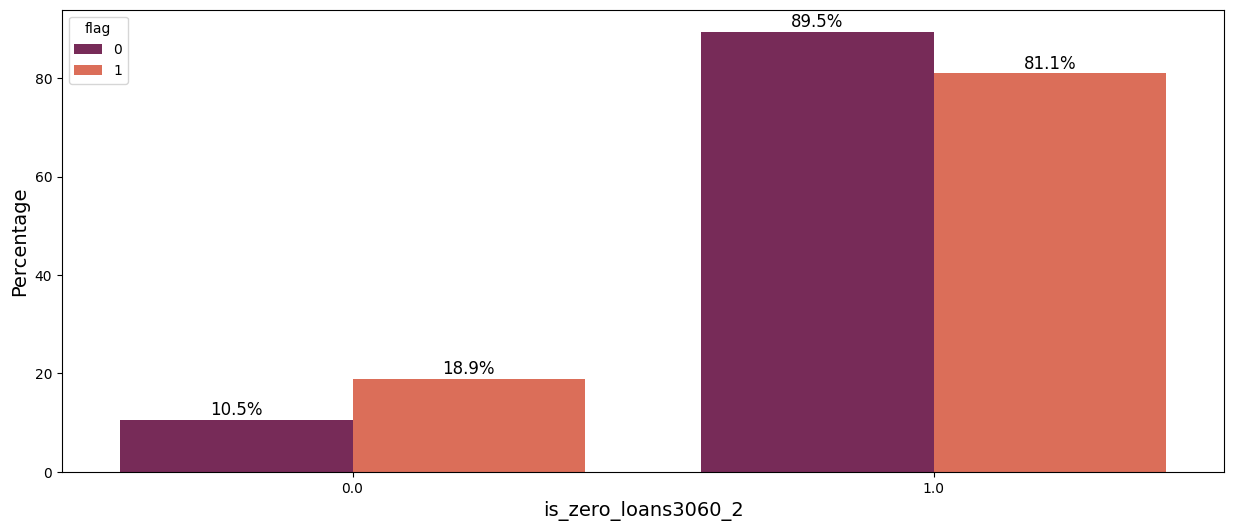

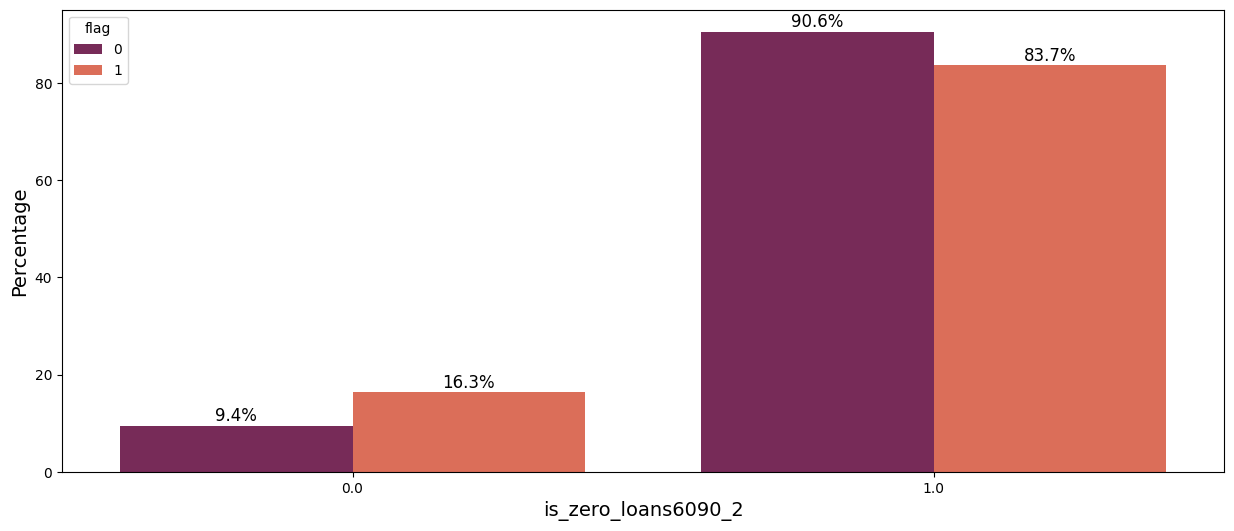

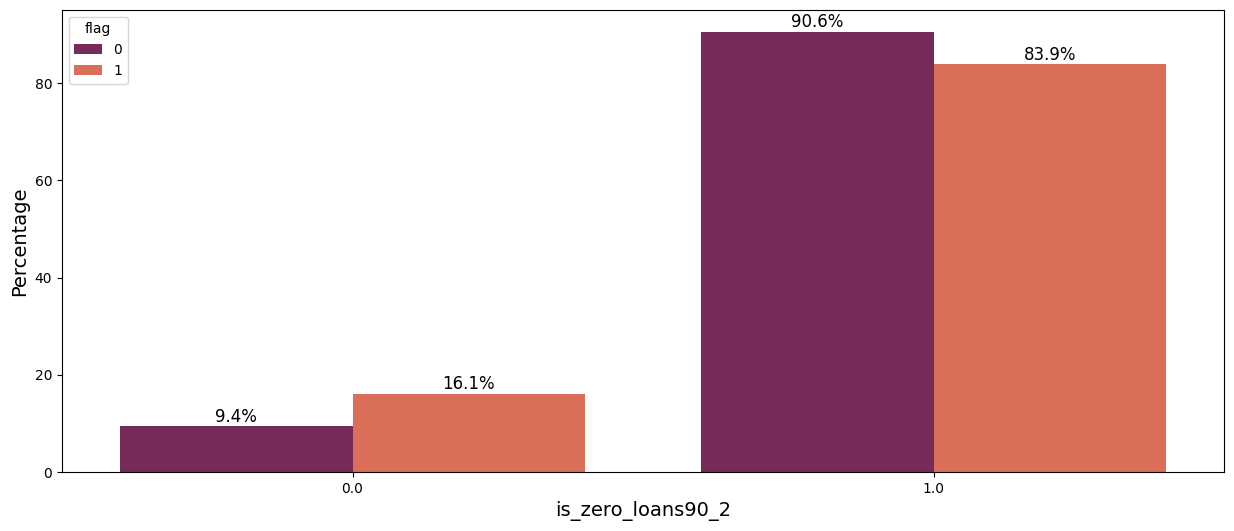

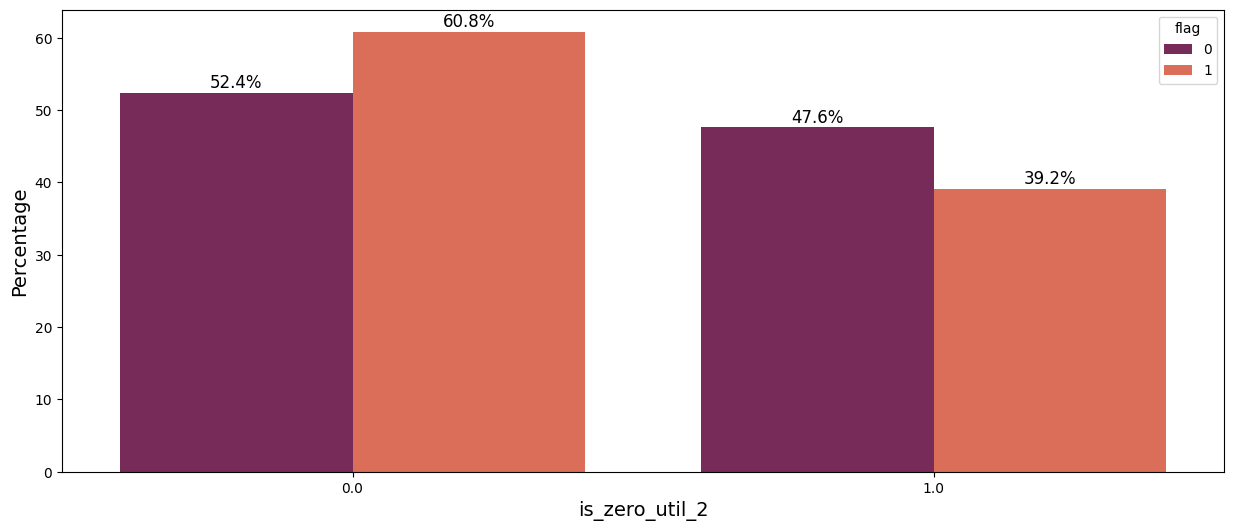

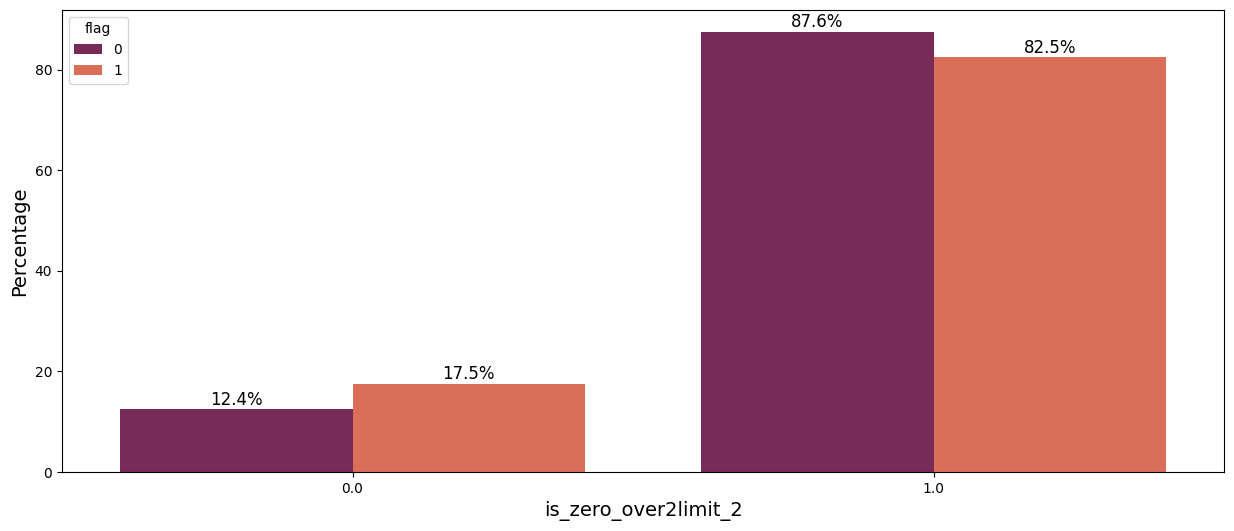

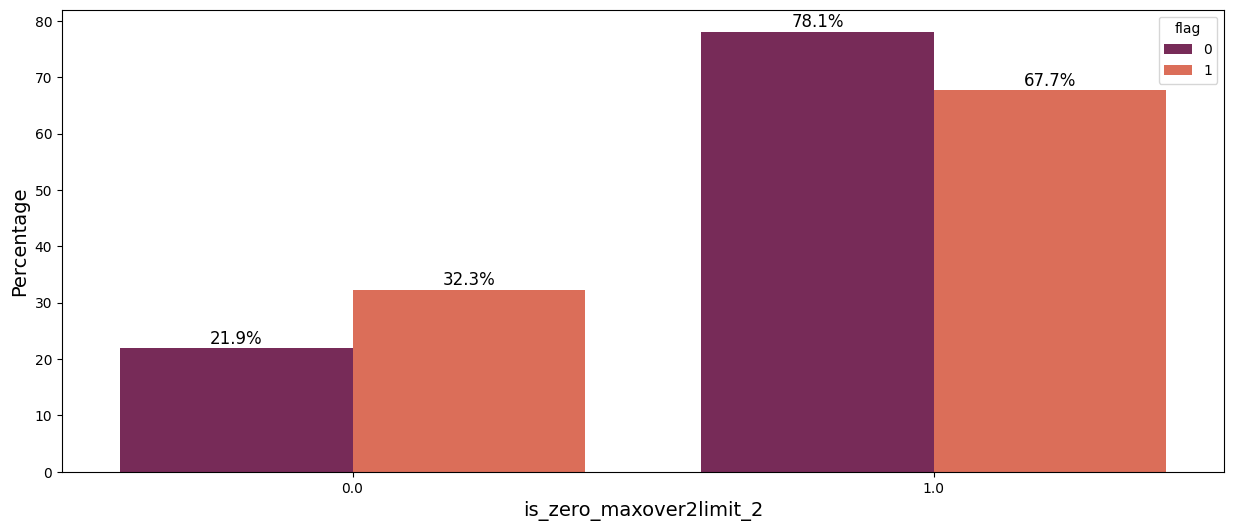

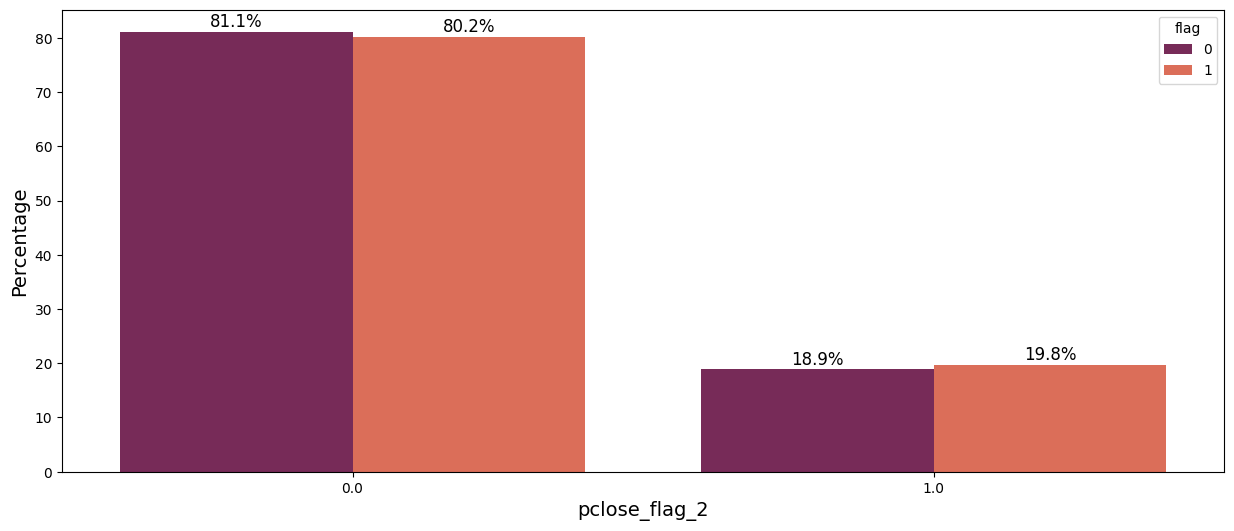

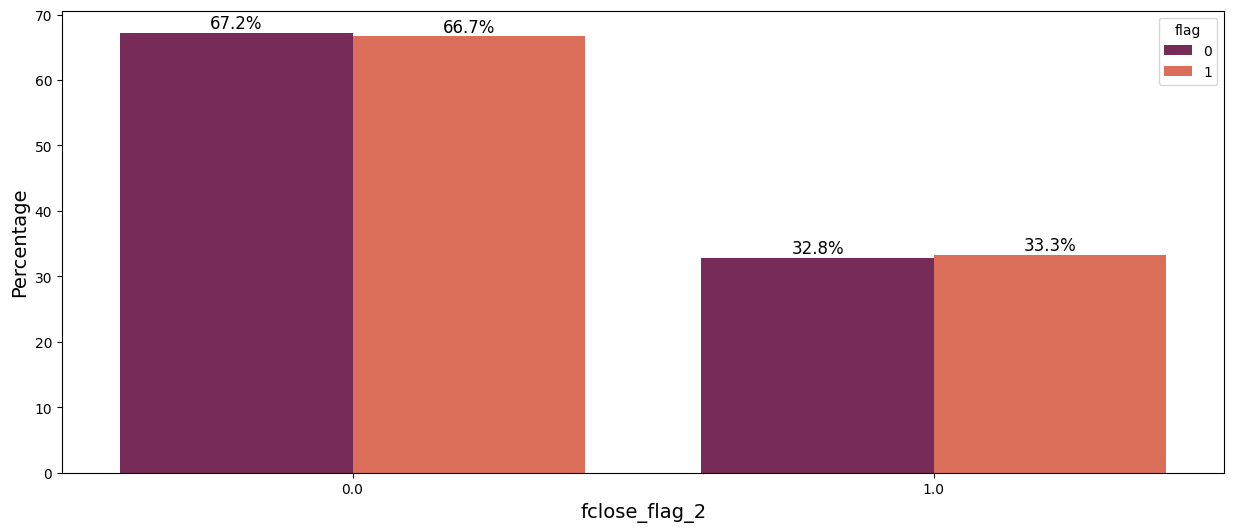

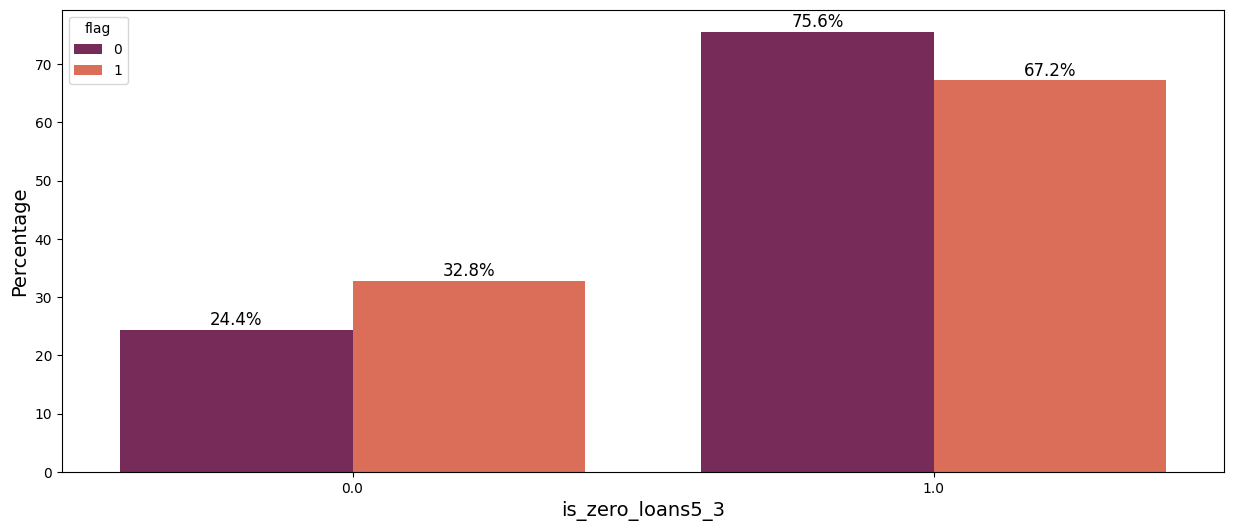

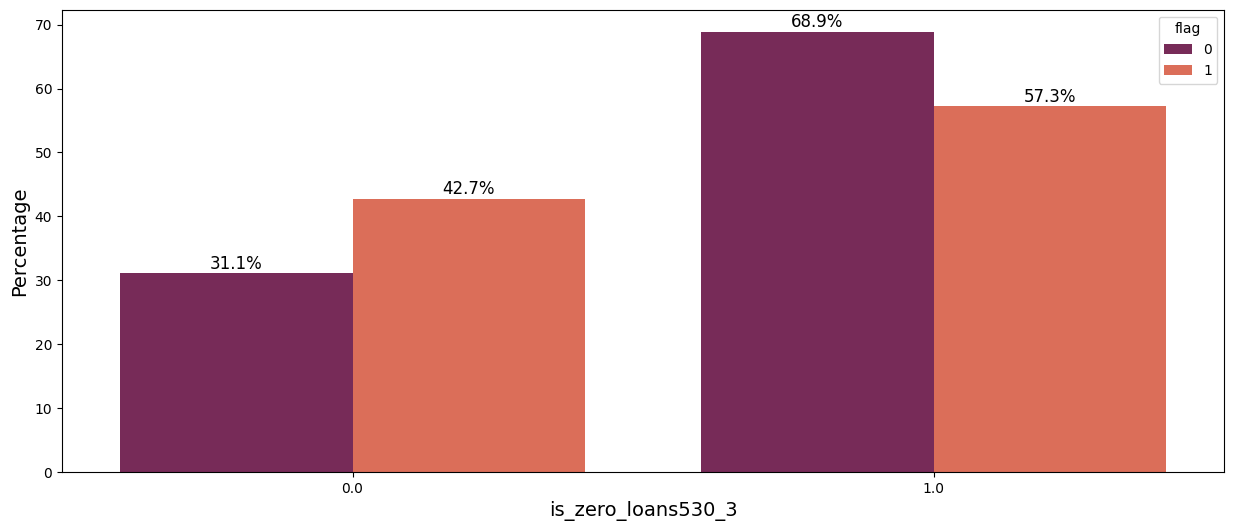

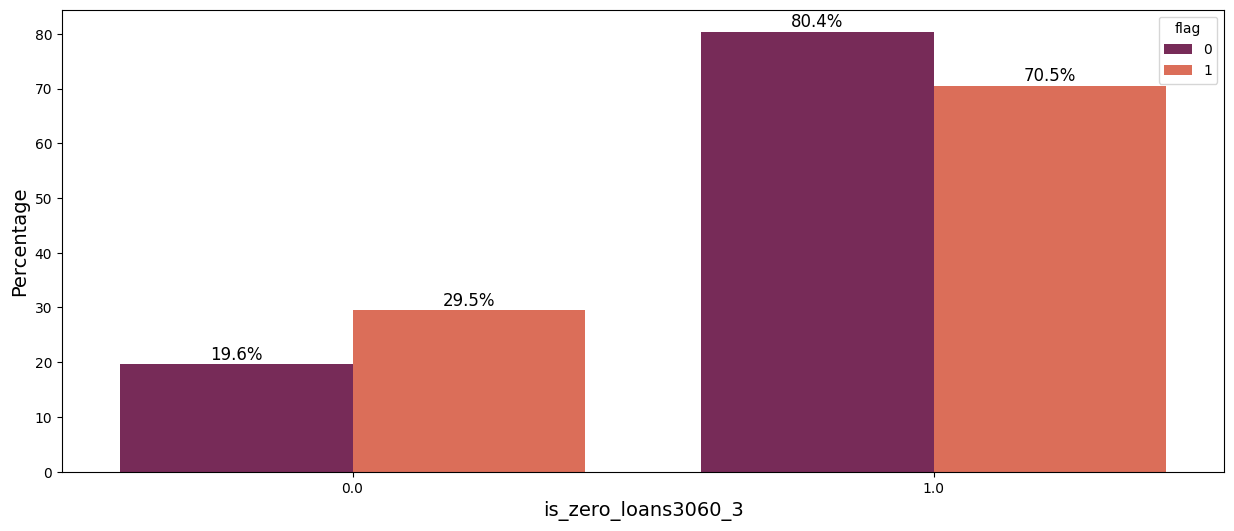

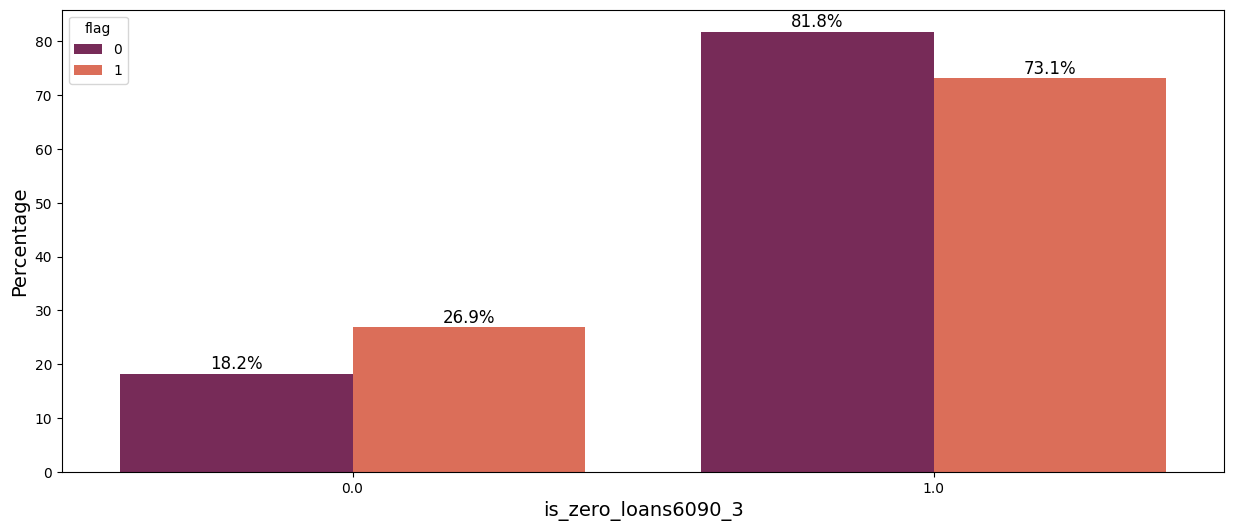

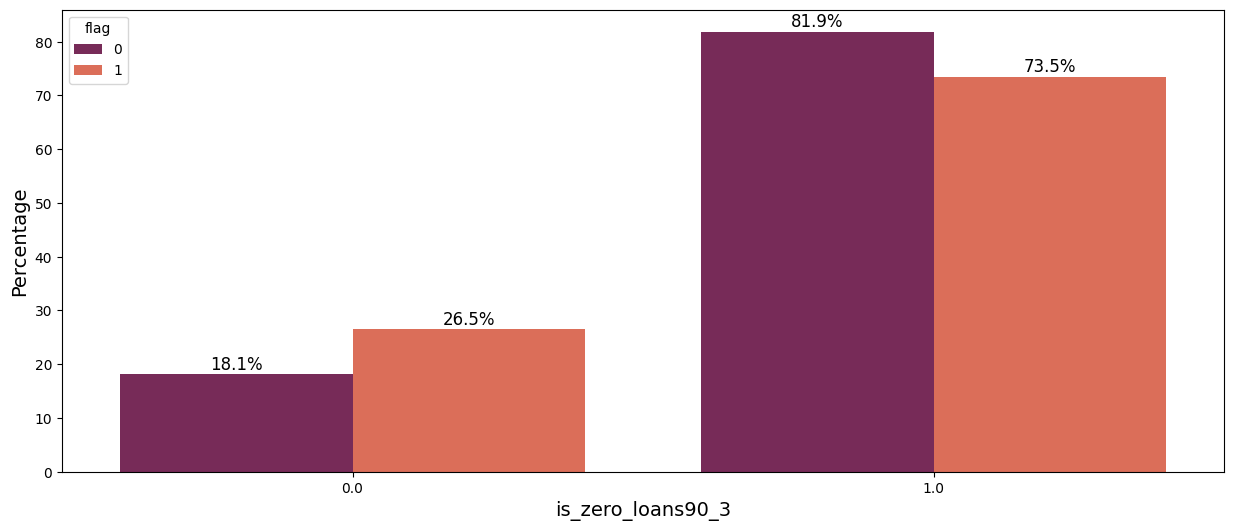

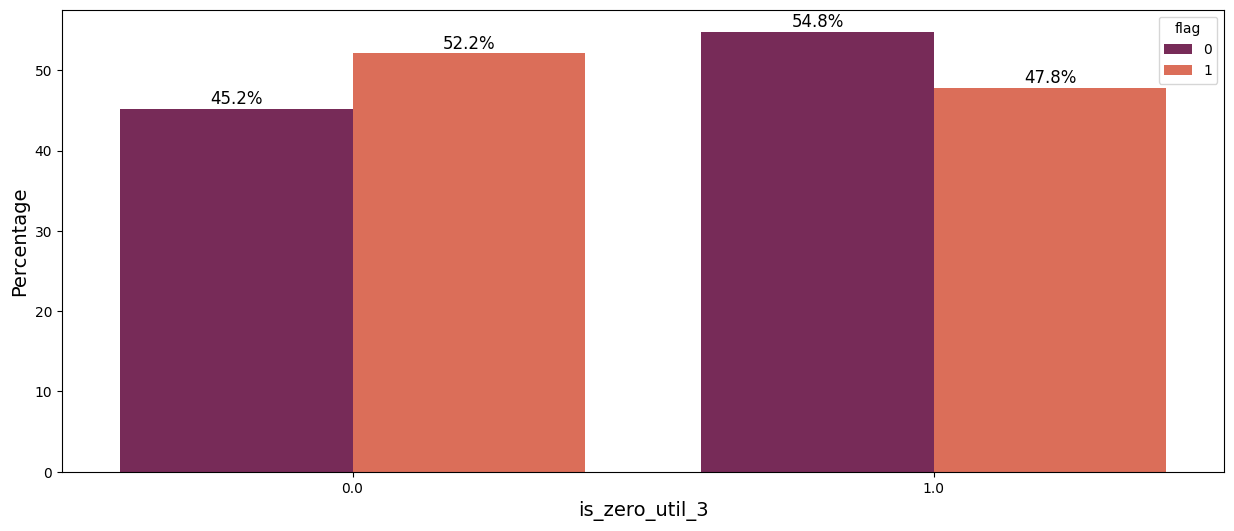

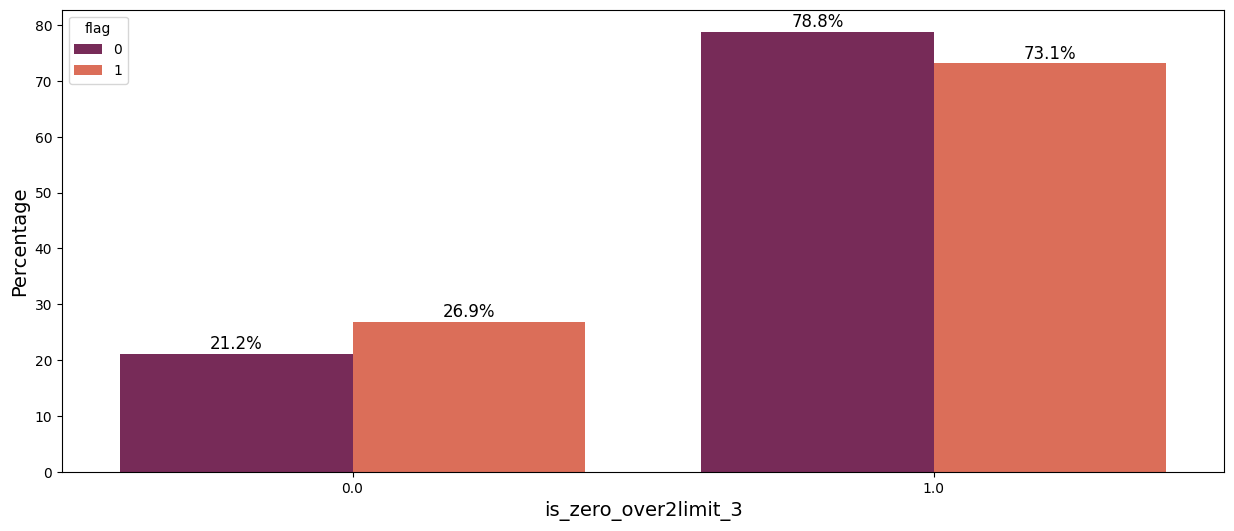

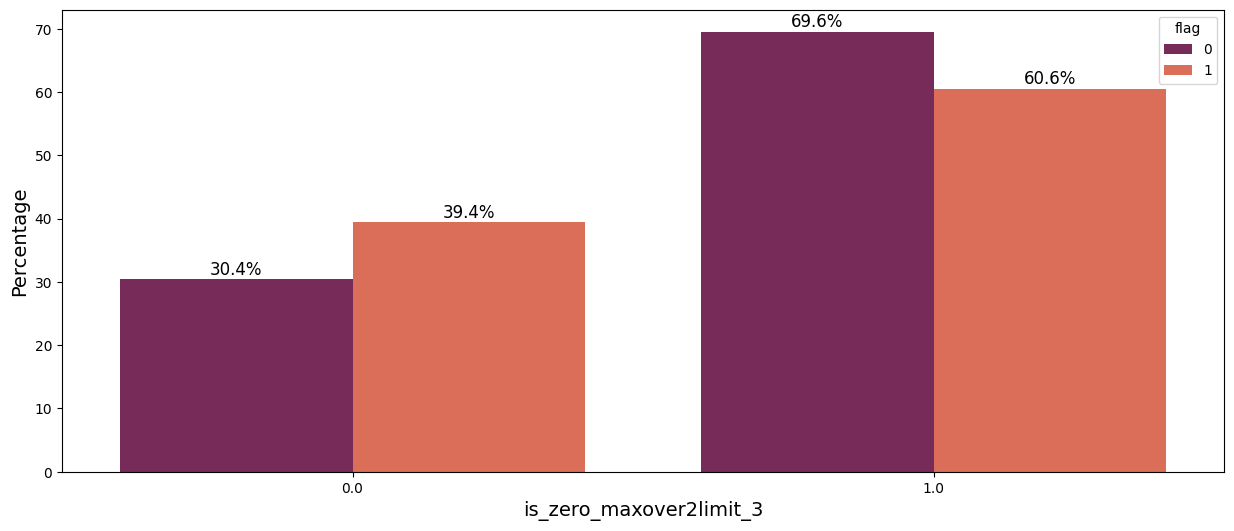

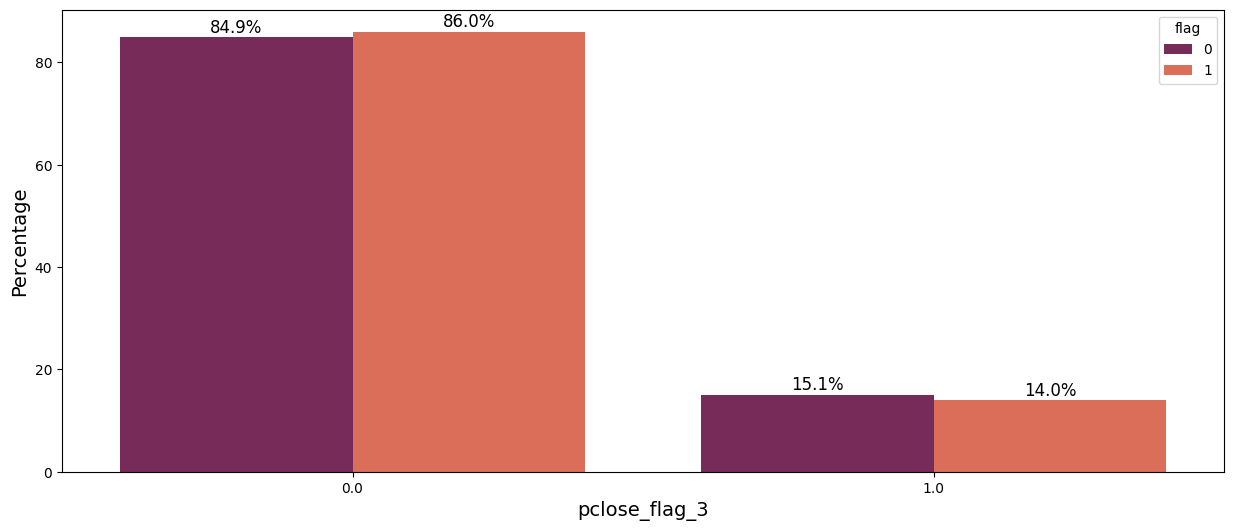

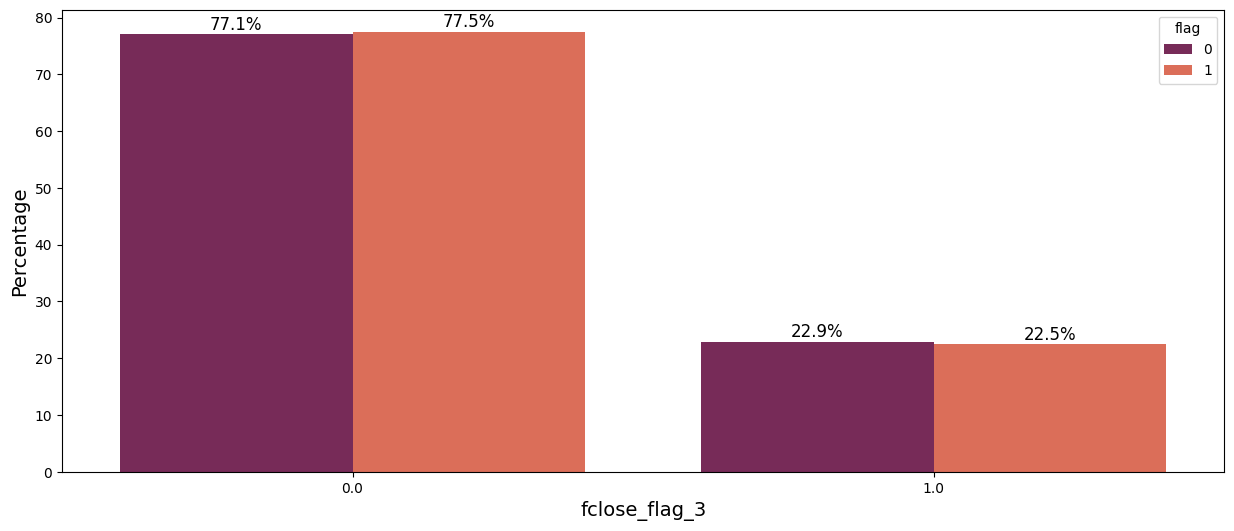

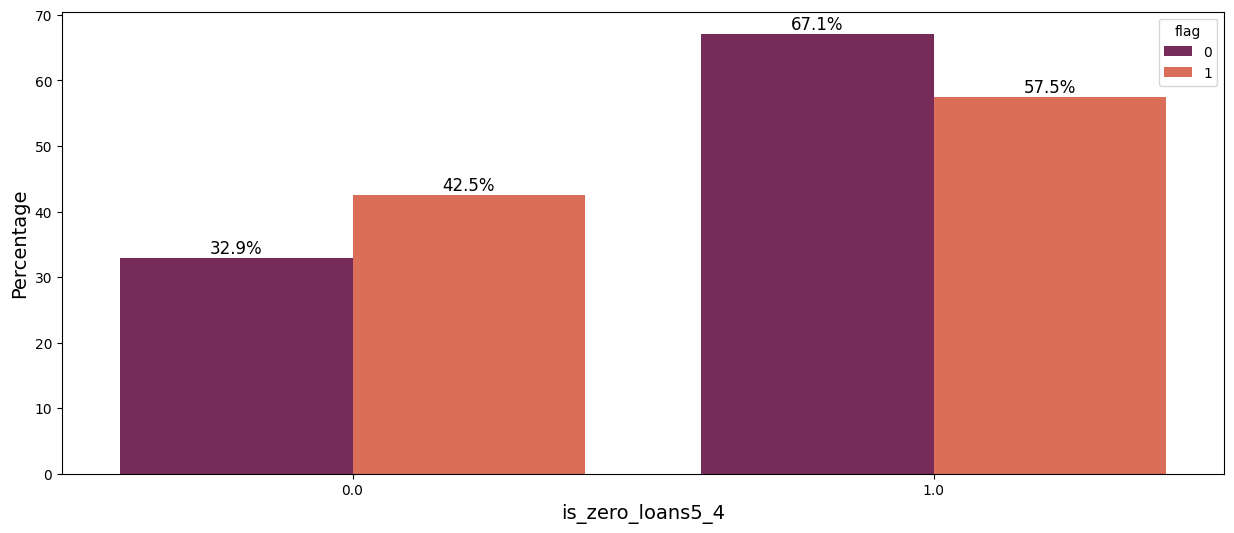

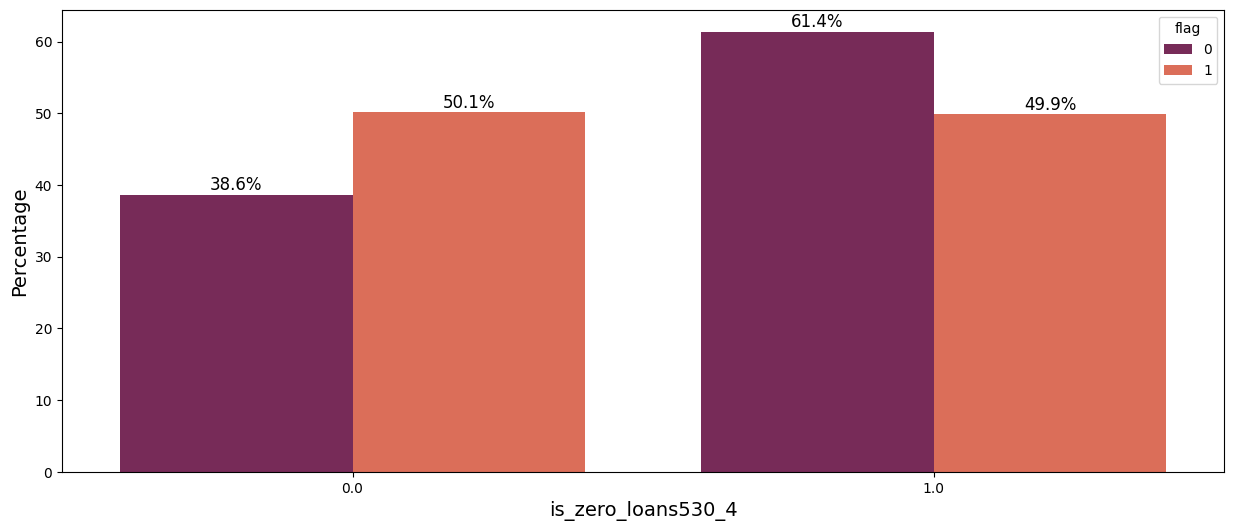

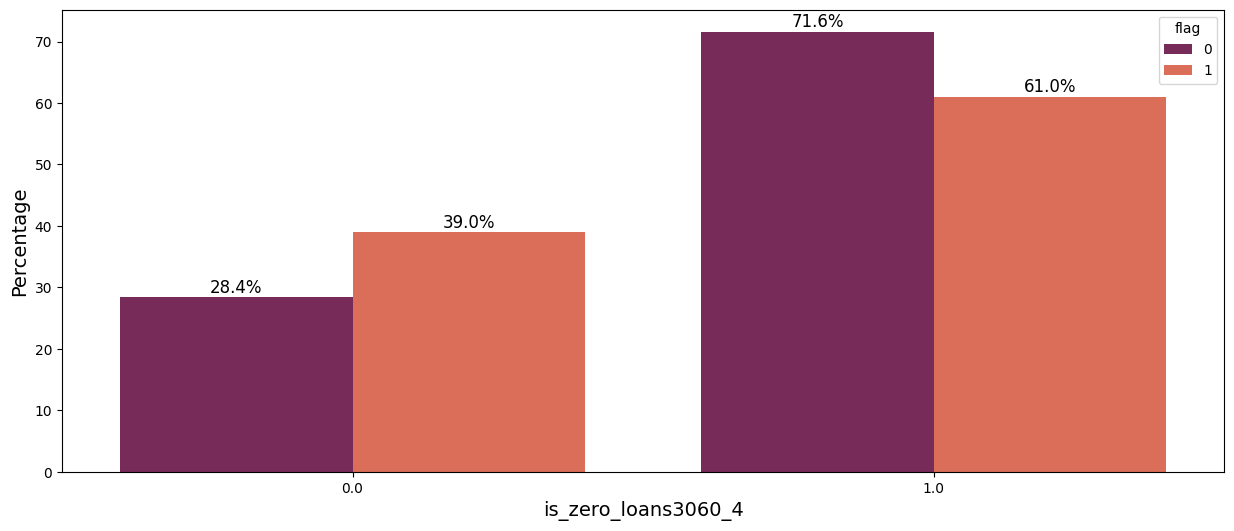

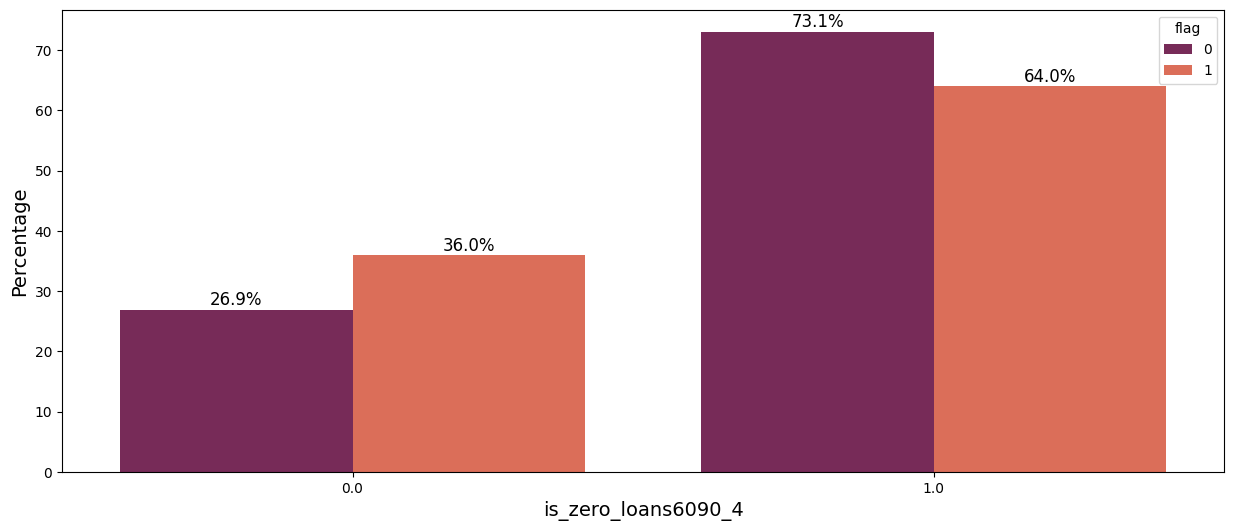

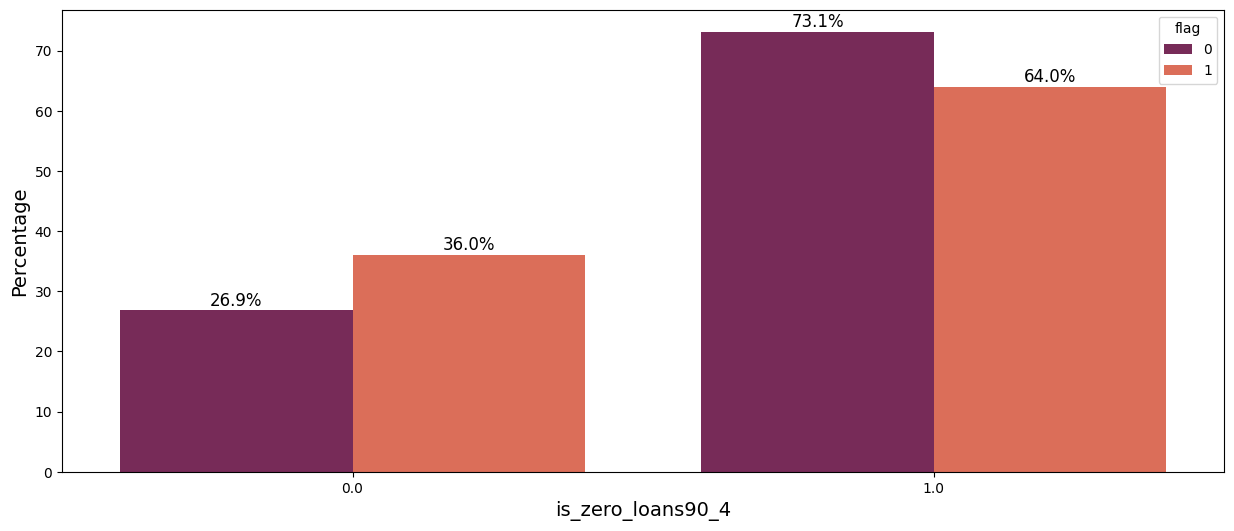

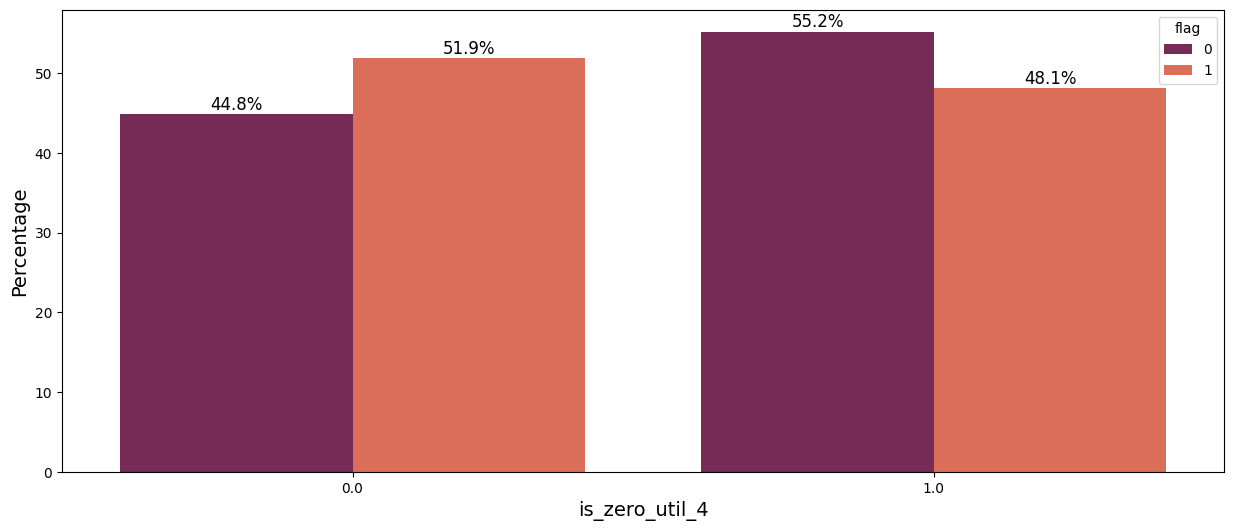

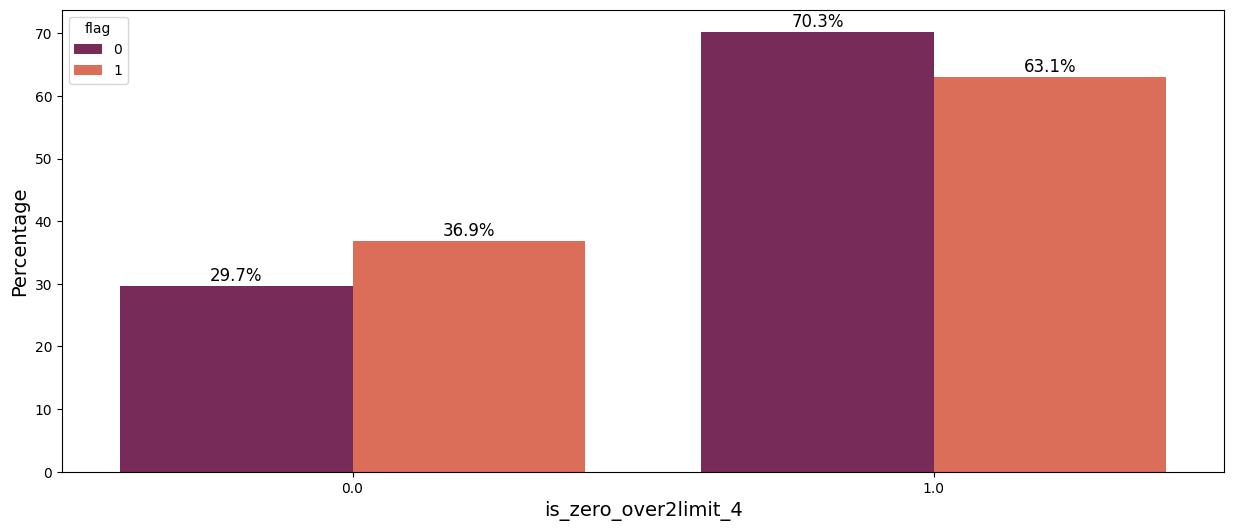

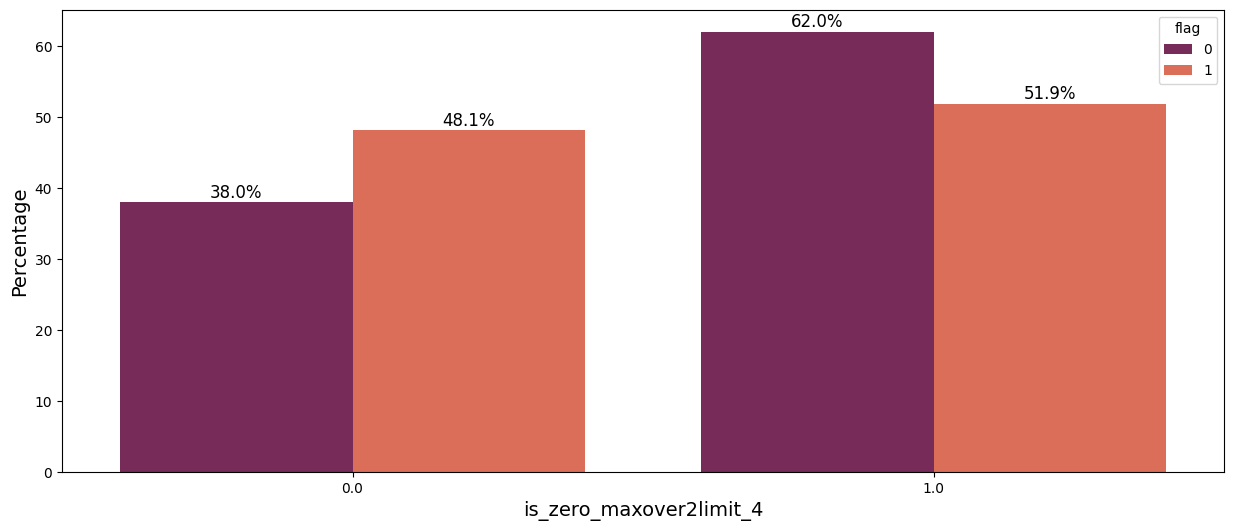

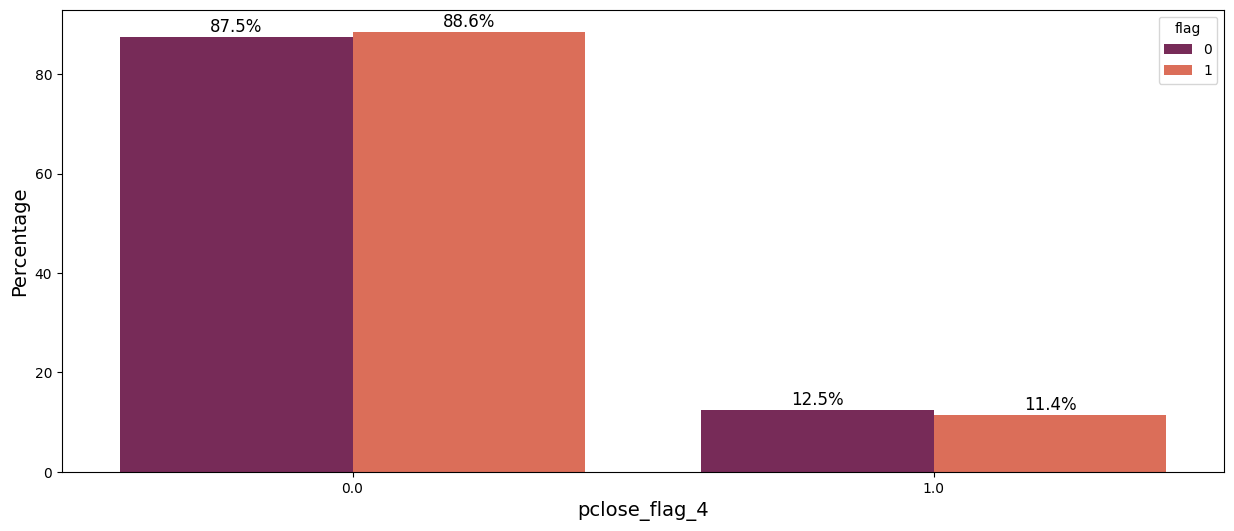

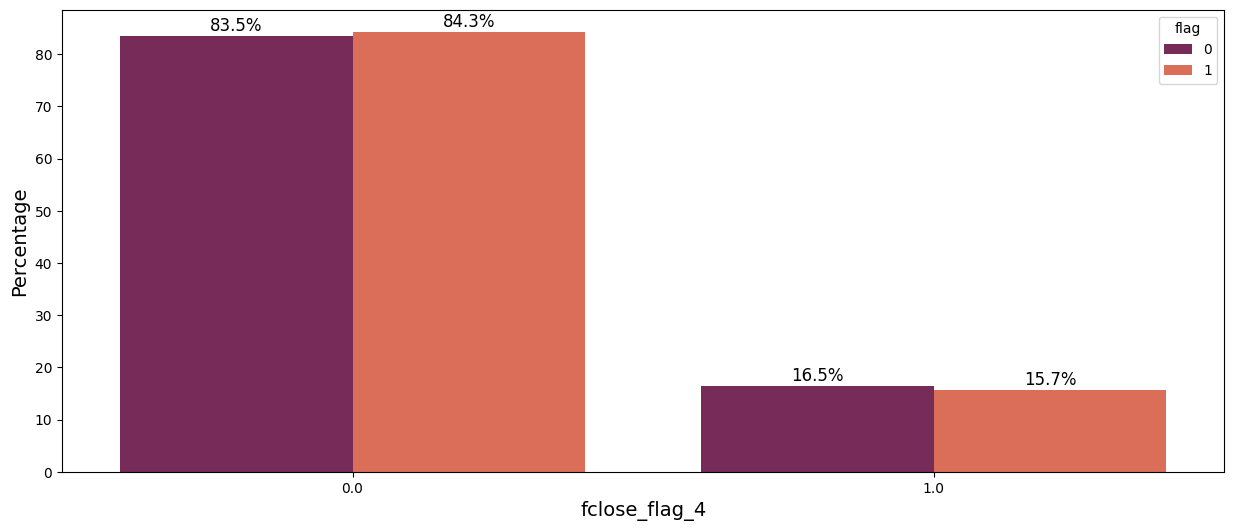

In [45]:
for col in df.nunique()[df.nunique() == 2].index:
    if col != "flag":
        barplot_group(col, "flag")

In [24]:
df = df.drop(columns=["pre_loans6090", 
                     "is_zero_loans3060",
                     "is_zero_loans6090",
                     "is_zero_loans90",
                     "is_zero_over2limit"])

In [25]:
df = df.drop(columns=["pclose_flag", 
                      "fclose_flag",
                      "pclose_flag_2",
                      "fclose_flag_2",
                      "pclose_flag_3",
                      "fclose_flag_3",
                      "pclose_flag_4",
                      "fclose_flag_4"])

In [25]:
df.nunique()[df.nunique() == 3].index

Index(['pre_loans_max_overdue_sum', 'enc_loans_account_cur', 'pre_loans6090_2',
       'enc_loans_account_cur_2', 'pre_loans6090_3', 'enc_loans_account_cur_3',
       'pre_loans6090_4'],
      dtype='object')

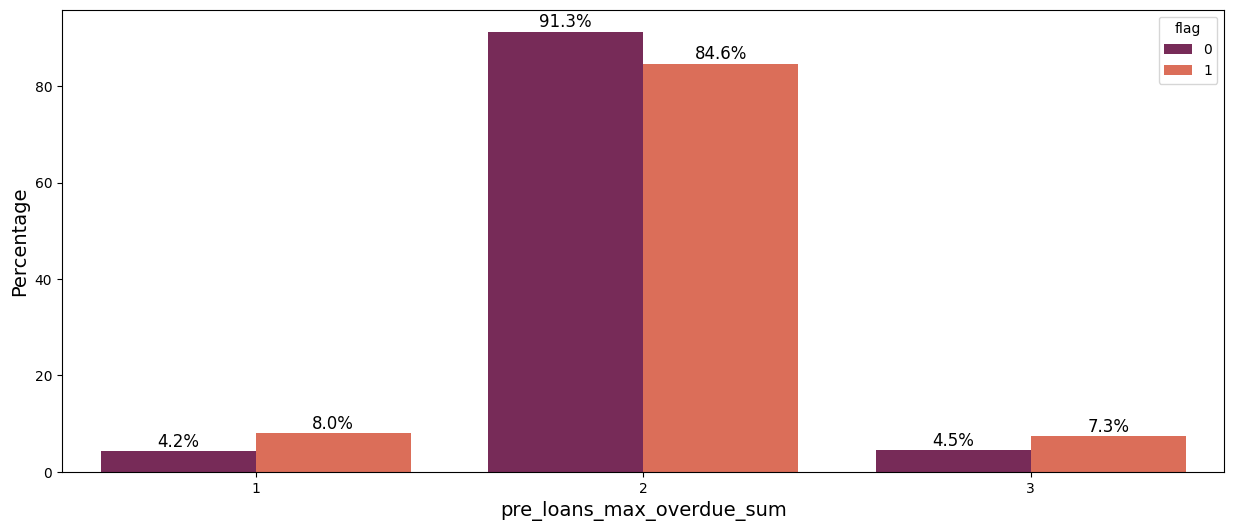

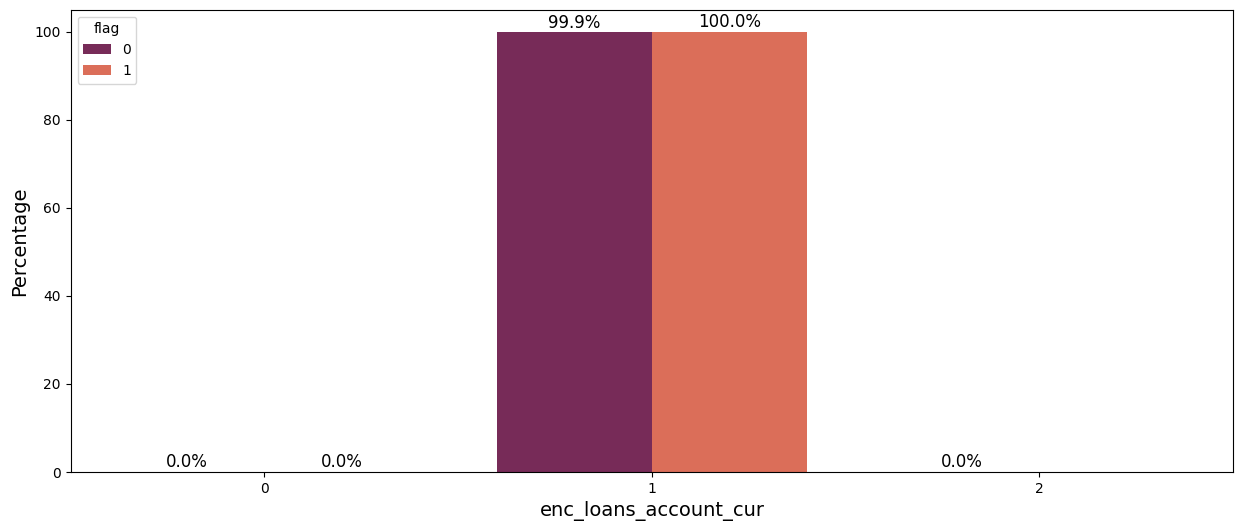

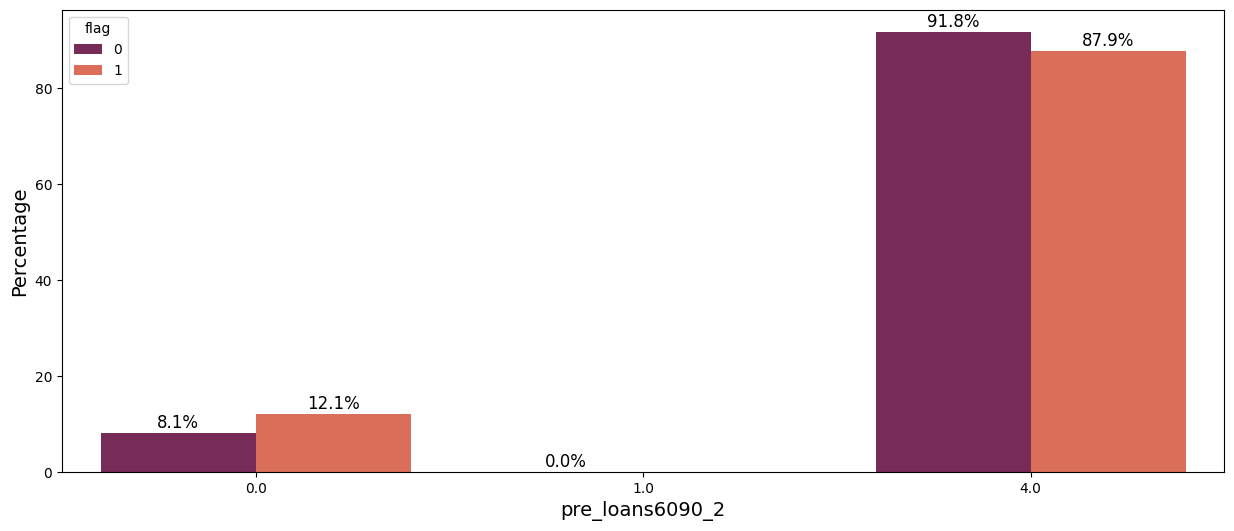

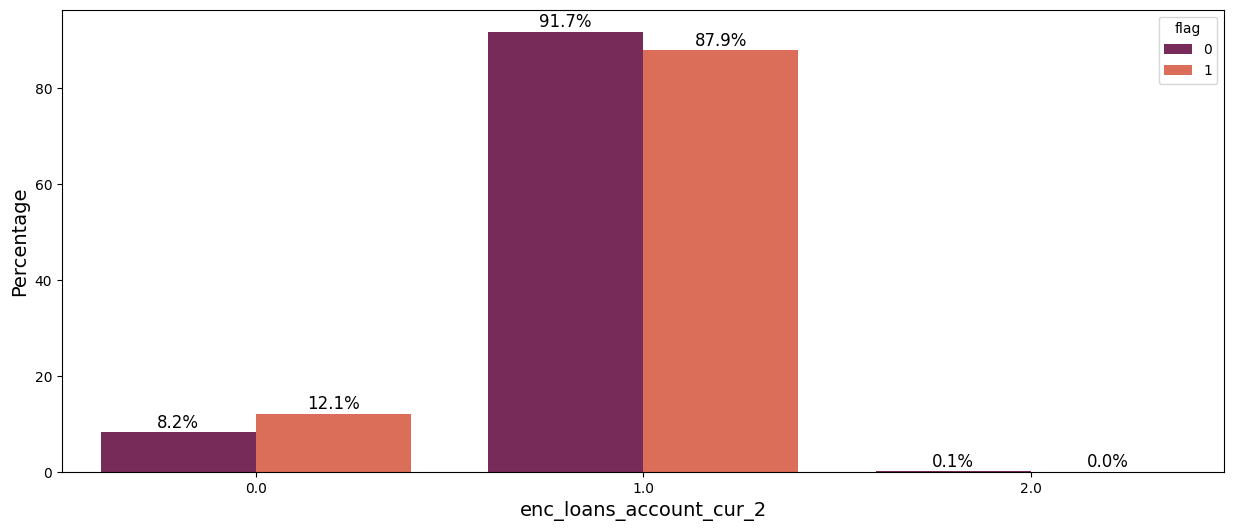

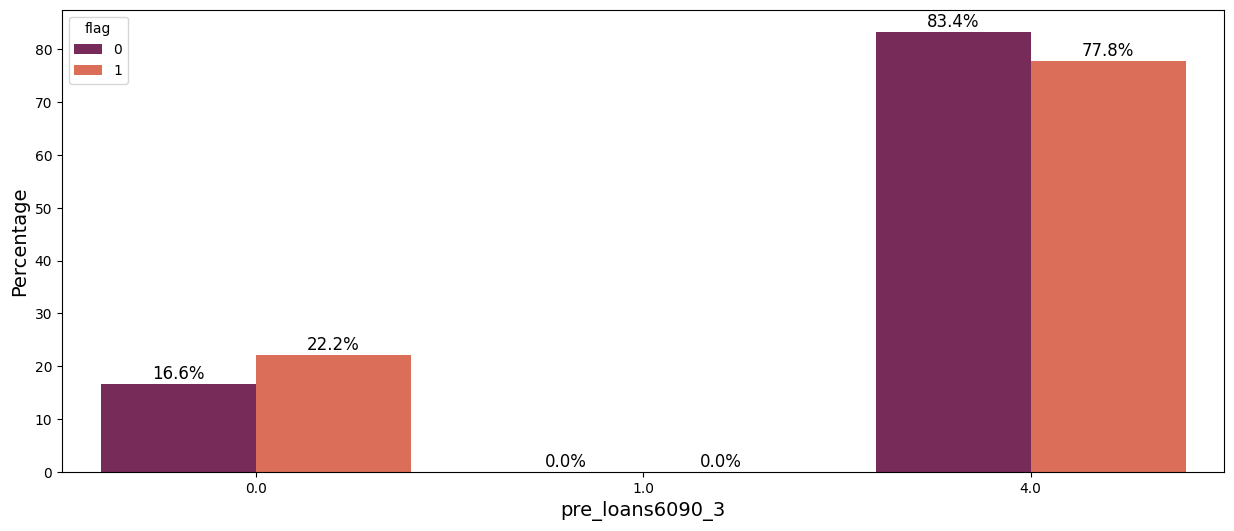

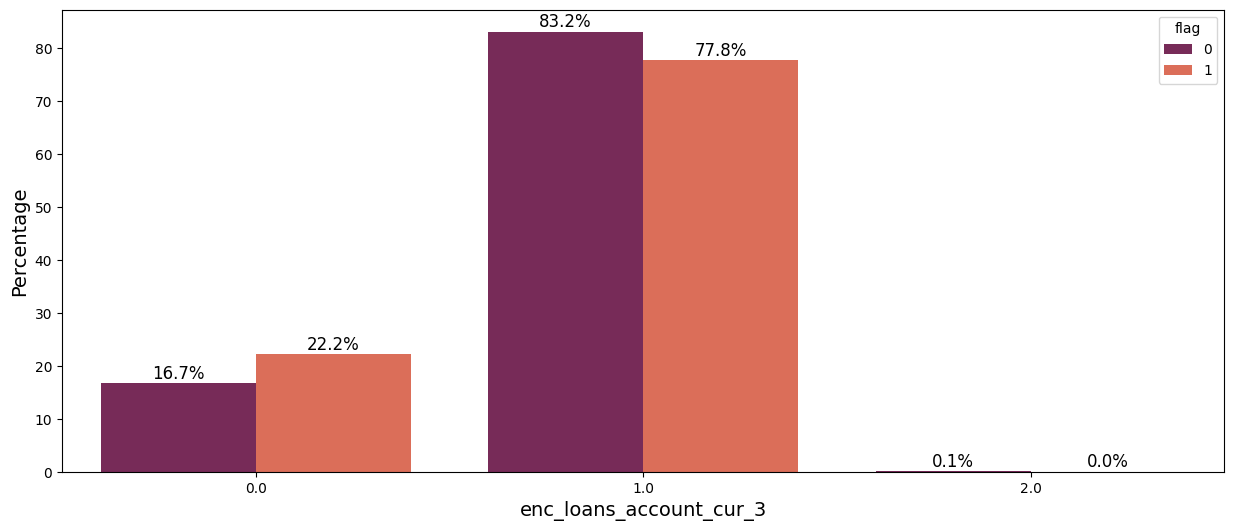

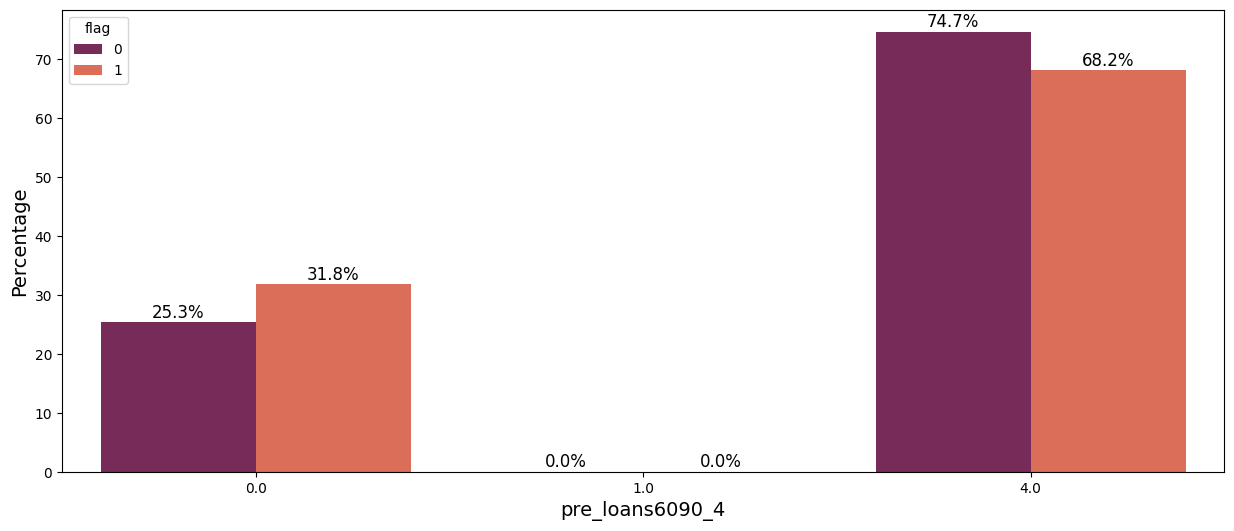

In [72]:
for col in df.nunique()[df.nunique() == 3].index:
    barplot_group(col, "flag")

In [28]:
df = df.drop(columns=["enc_loans_account_cur"])

In [27]:
df.nunique()[df.nunique() == 4].index

Index(['pre_loans3060', 'pre_loans90', 'enc_paym_0', 'enc_paym_1',
       'enc_paym_2', 'enc_paym_3', 'enc_paym_4', 'enc_paym_5', 'enc_paym_6',
       'enc_paym_7', 'enc_paym_8', 'enc_paym_9', 'enc_paym_10', 'enc_paym_11',
       'enc_paym_12', 'enc_paym_13', 'enc_paym_14', 'enc_paym_15',
       'enc_paym_16', 'enc_paym_17', 'enc_paym_18', 'enc_paym_19',
       'enc_paym_20', 'enc_paym_21', 'enc_paym_22', 'enc_paym_23',
       'enc_paym_24', 'pre_loans_max_overdue_sum_2', 'pre_loans90_2',
       'enc_paym_0_2', 'enc_paym_1_2', 'enc_paym_2_2', 'enc_paym_3_2',
       'enc_paym_4_2', 'enc_paym_5_2', 'enc_paym_6_2', 'enc_paym_7_2',
       'enc_paym_8_2', 'enc_paym_9_2', 'enc_paym_10_2', 'enc_paym_12_2',
       'enc_paym_13_2', 'enc_paym_14_2', 'enc_paym_15_2', 'enc_paym_16_2',
       'enc_paym_17_2', 'enc_paym_18_2', 'enc_paym_19_2', 'enc_paym_21_2',
       'enc_paym_22_2', 'enc_paym_23_2', 'pre_loans_max_overdue_sum_3',
       'enc_paym_0_3', 'enc_paym_1_3', 'enc_paym_2_3', 'enc_paym_3_3'

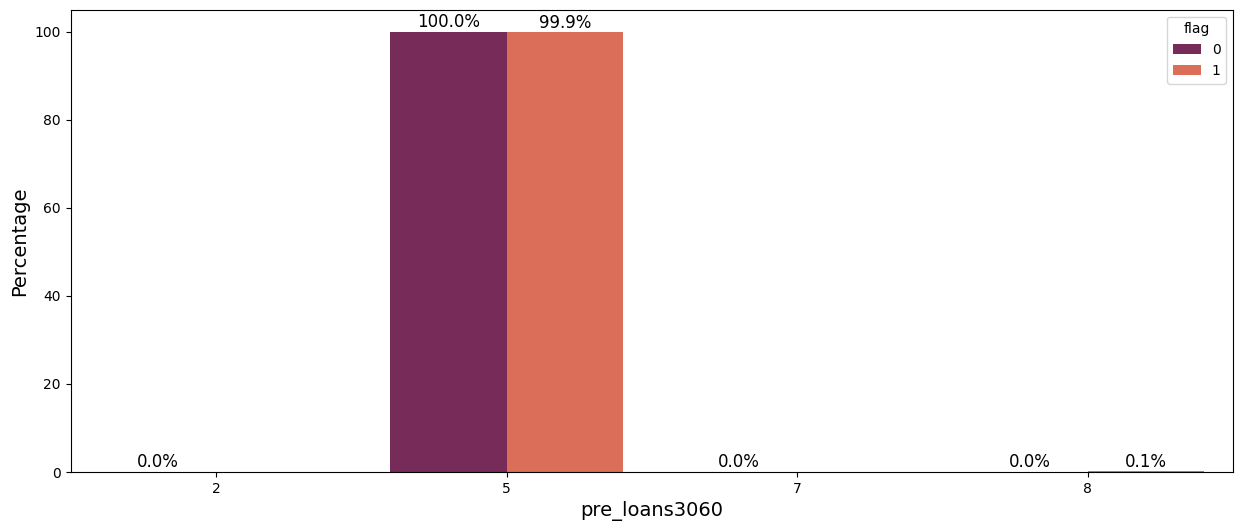

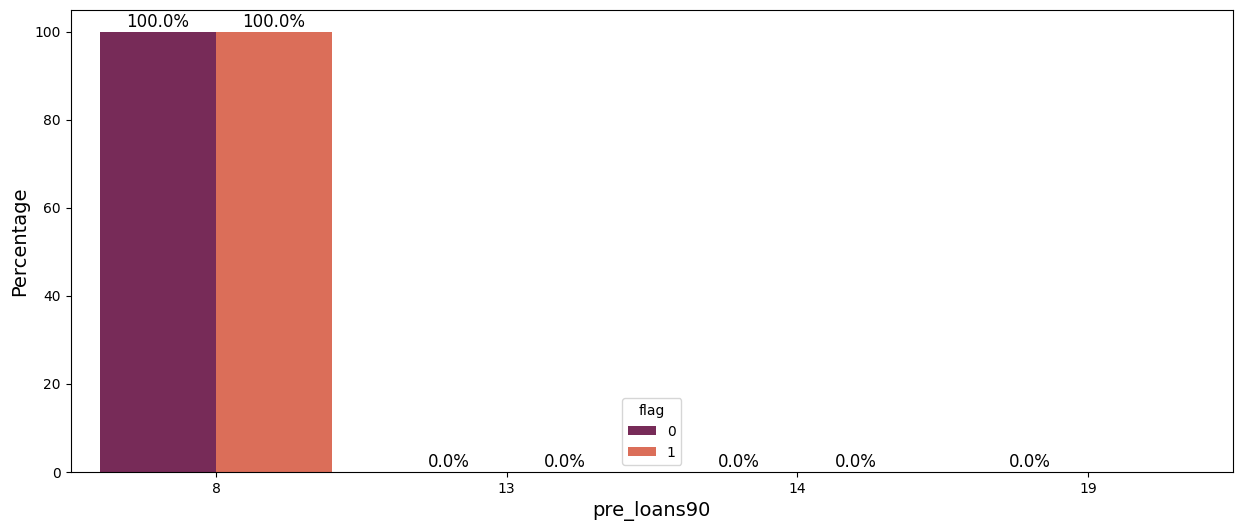

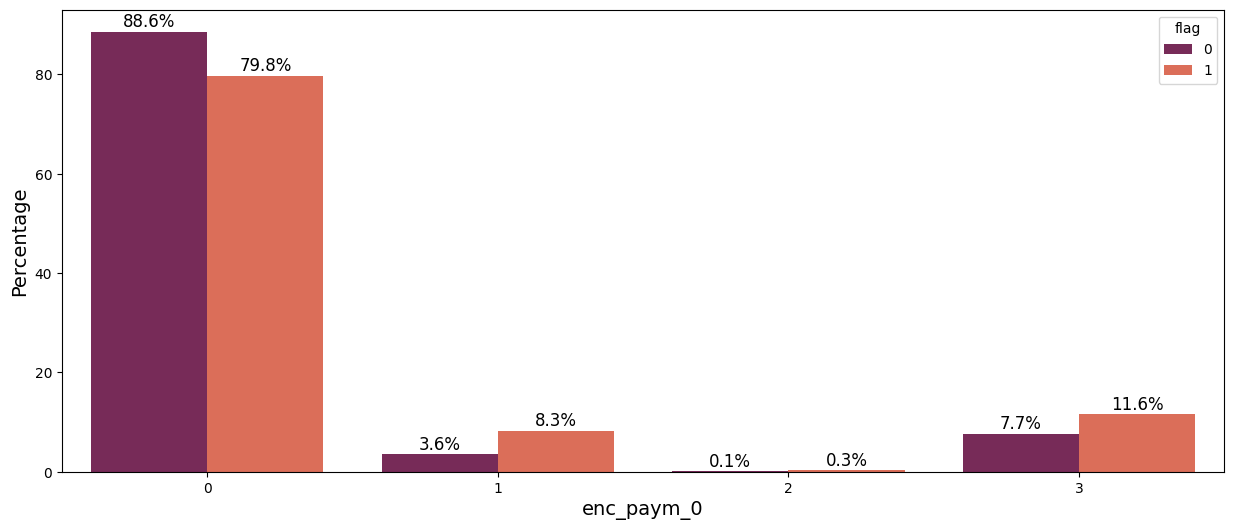

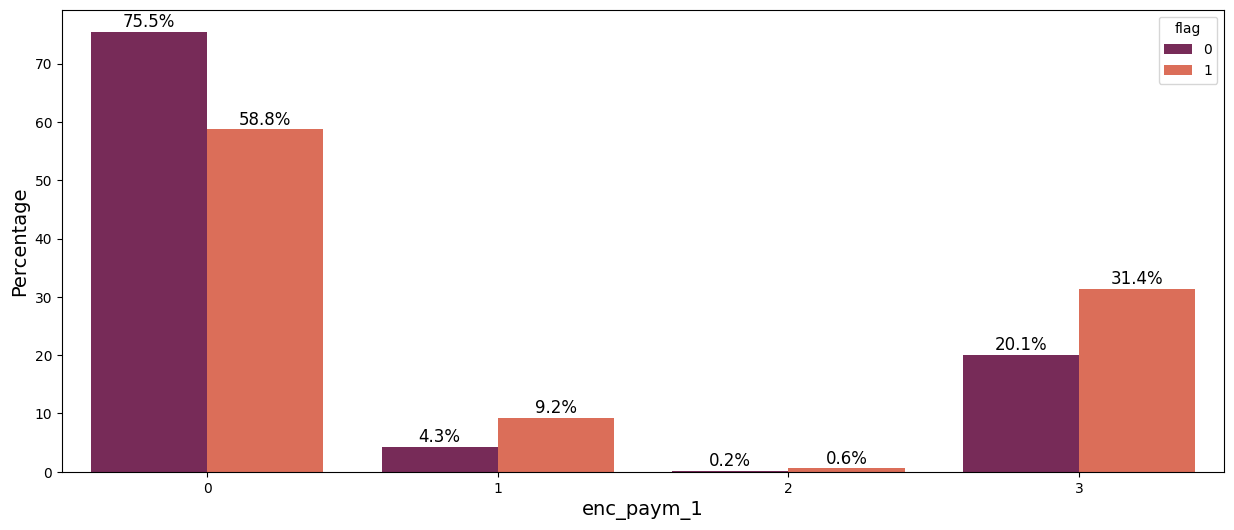

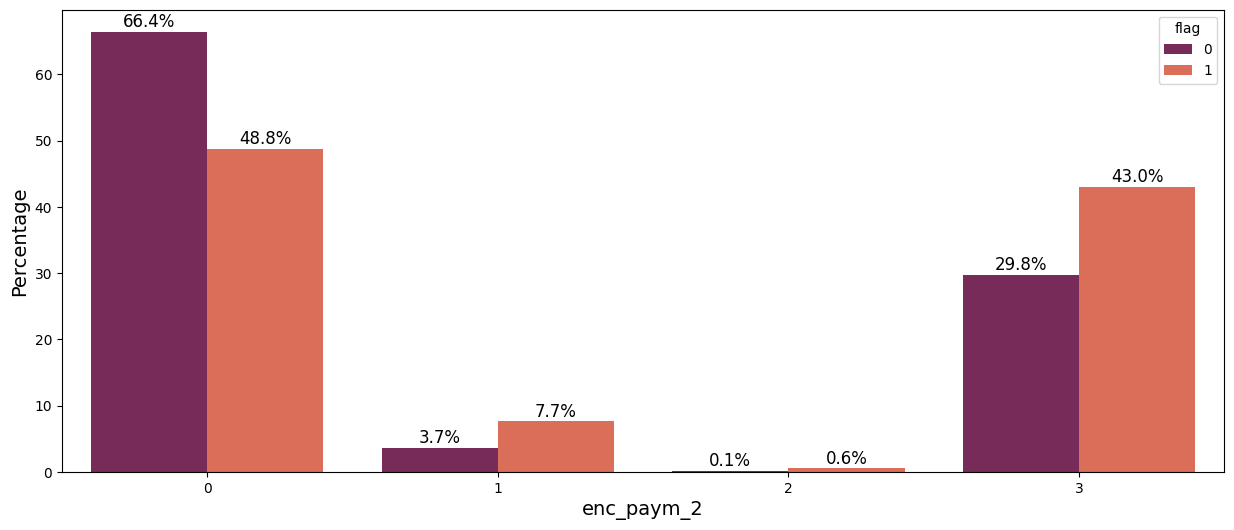

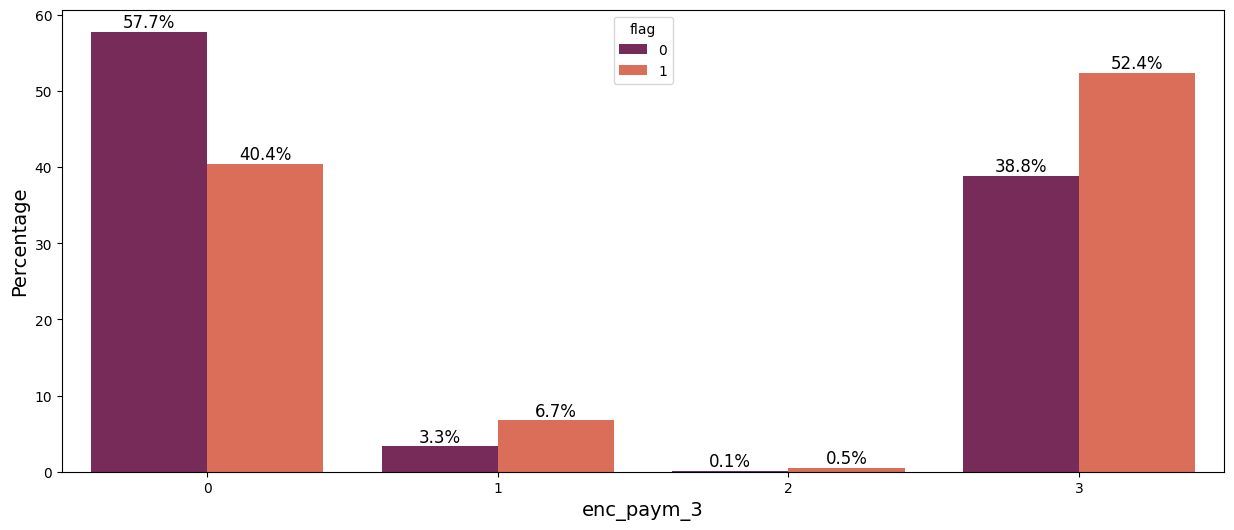

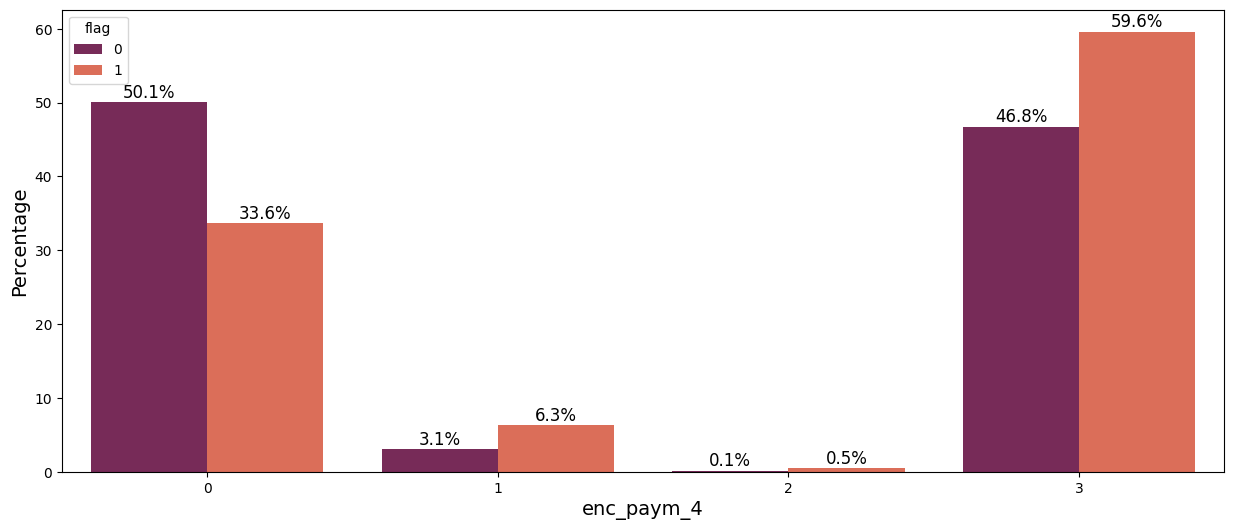

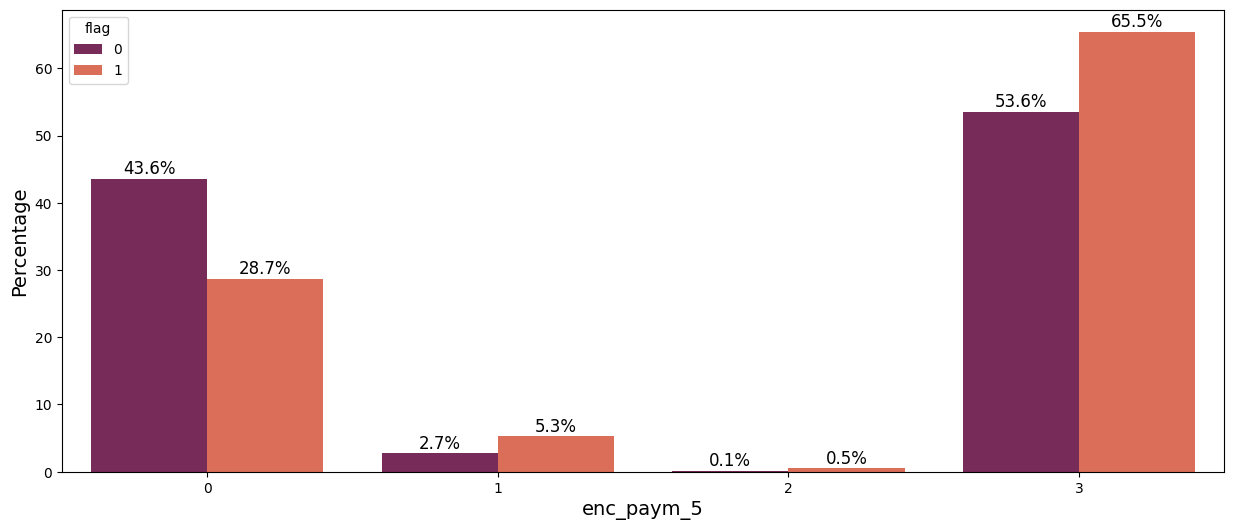

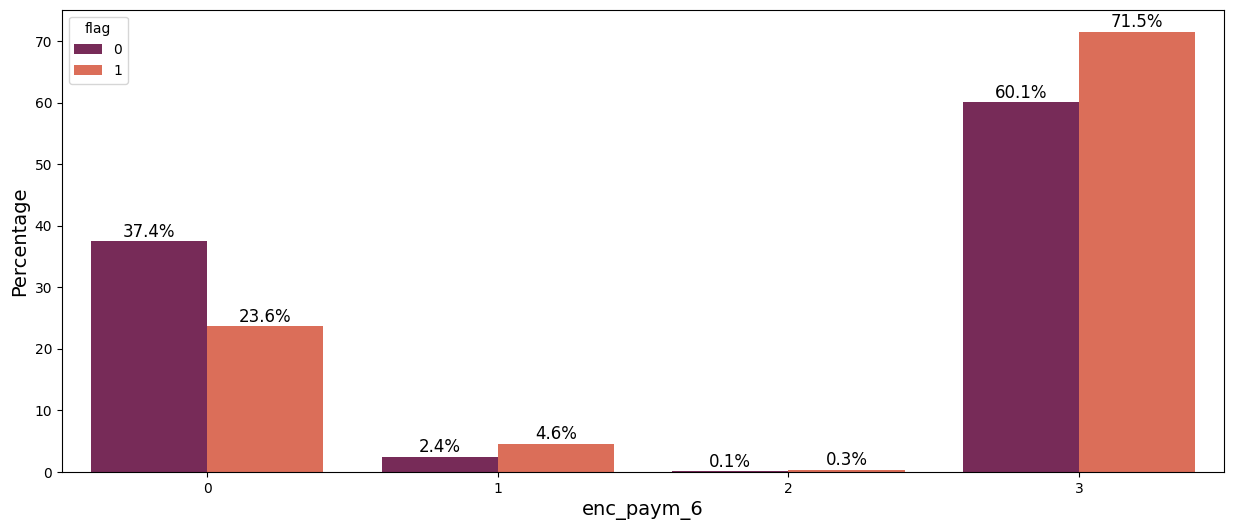

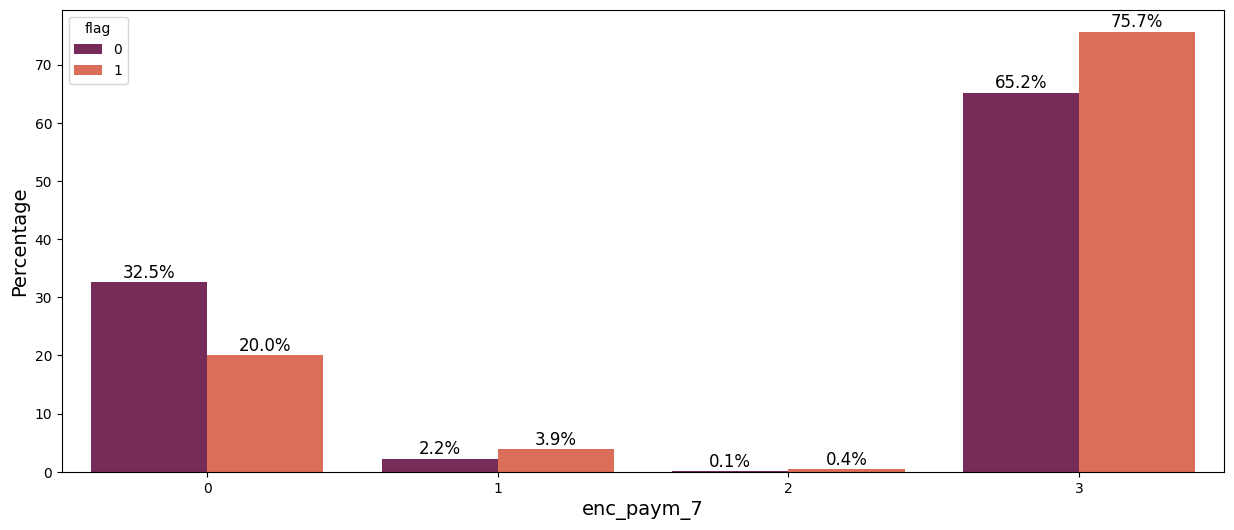

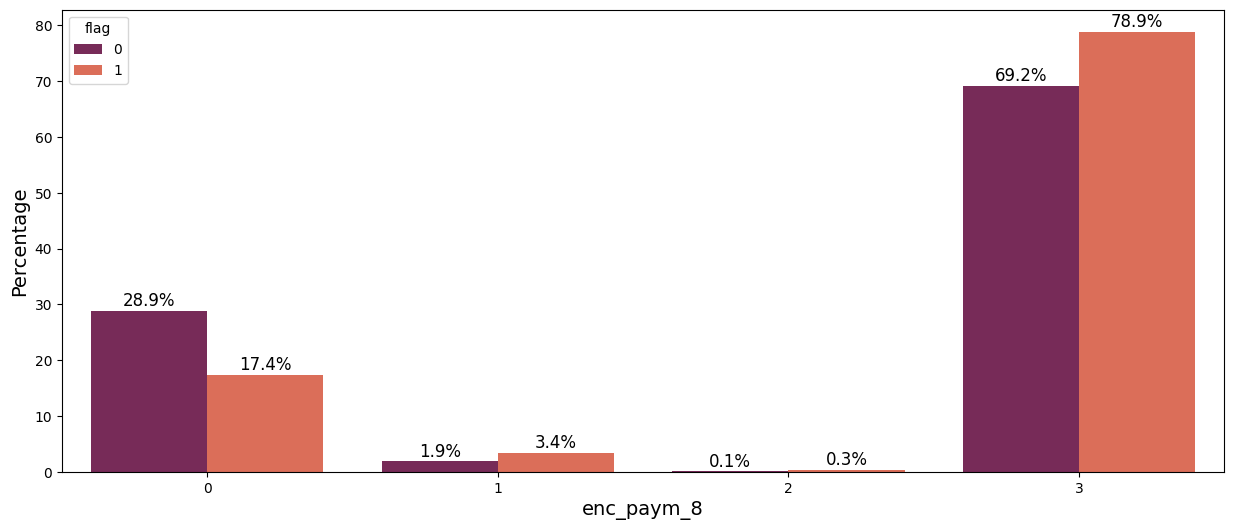

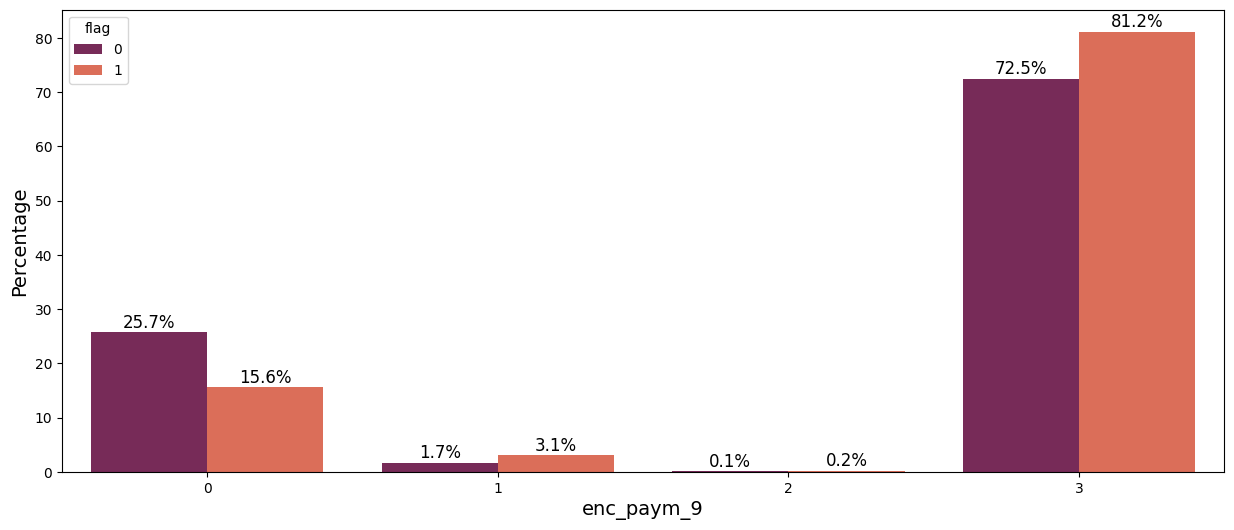

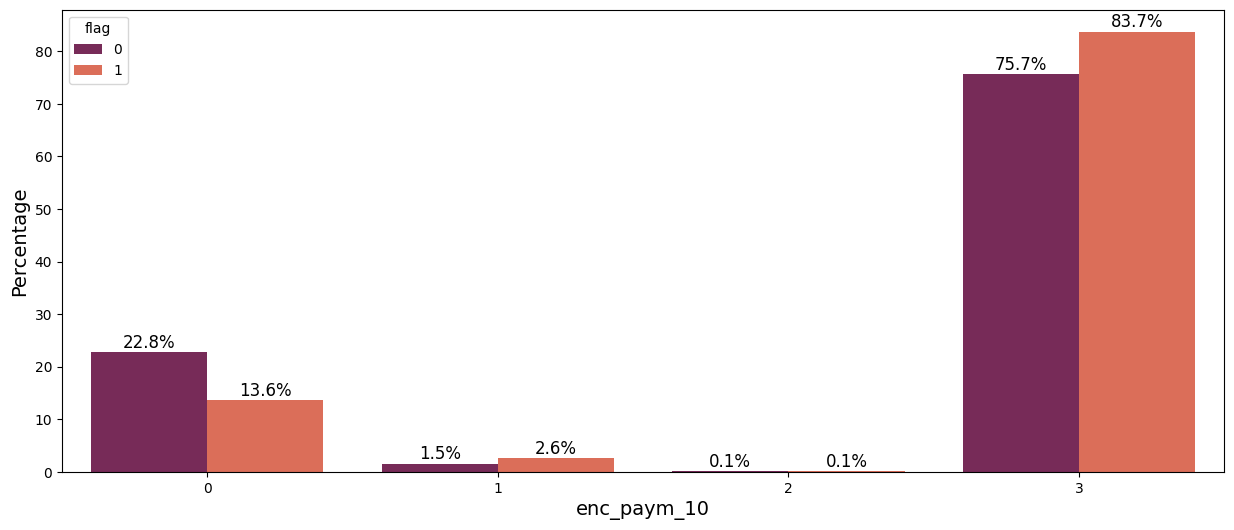

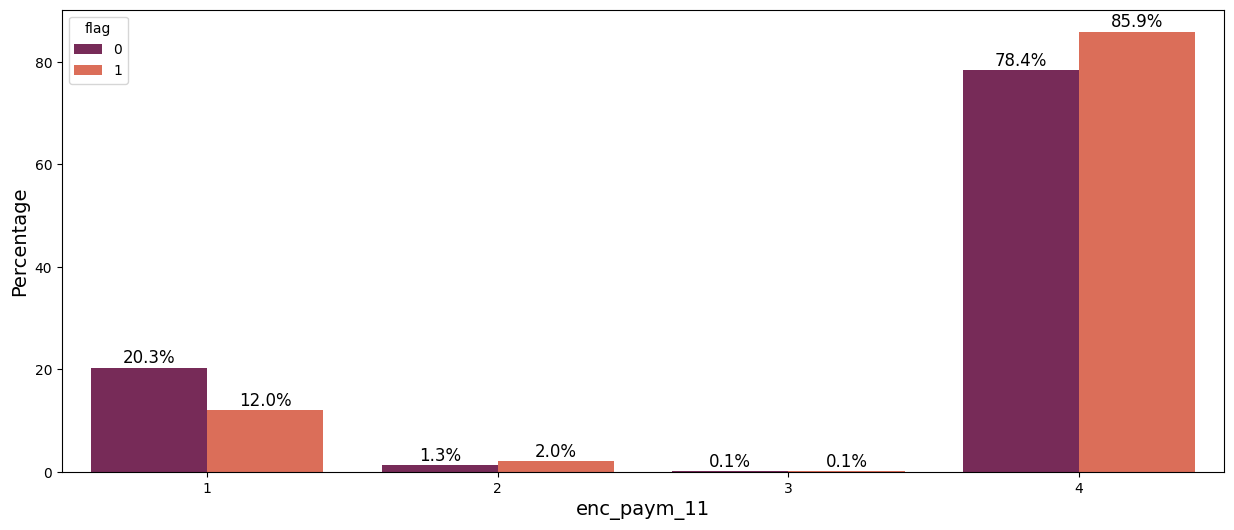

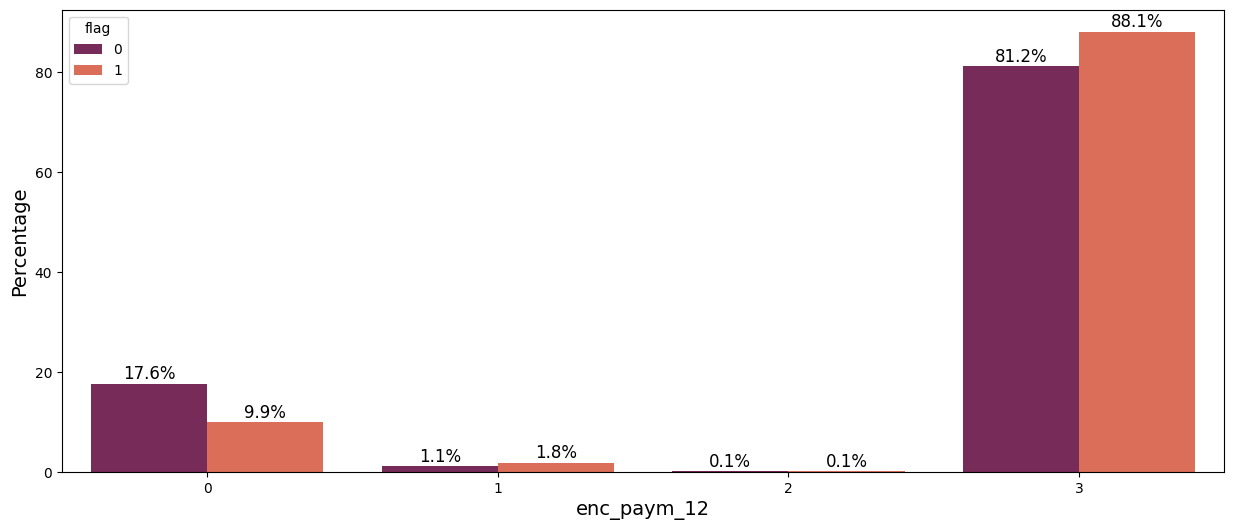

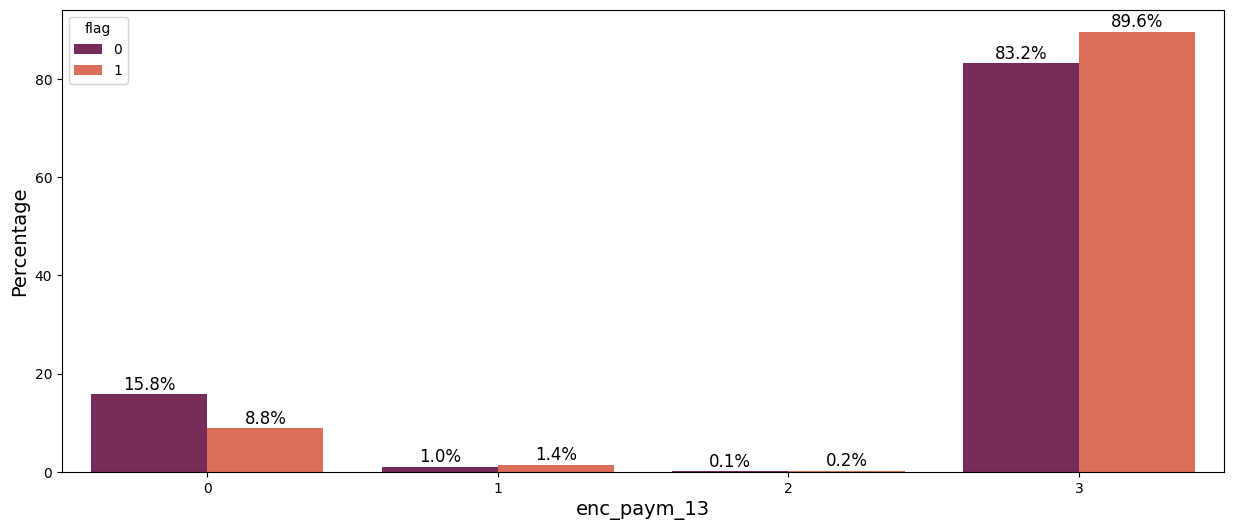

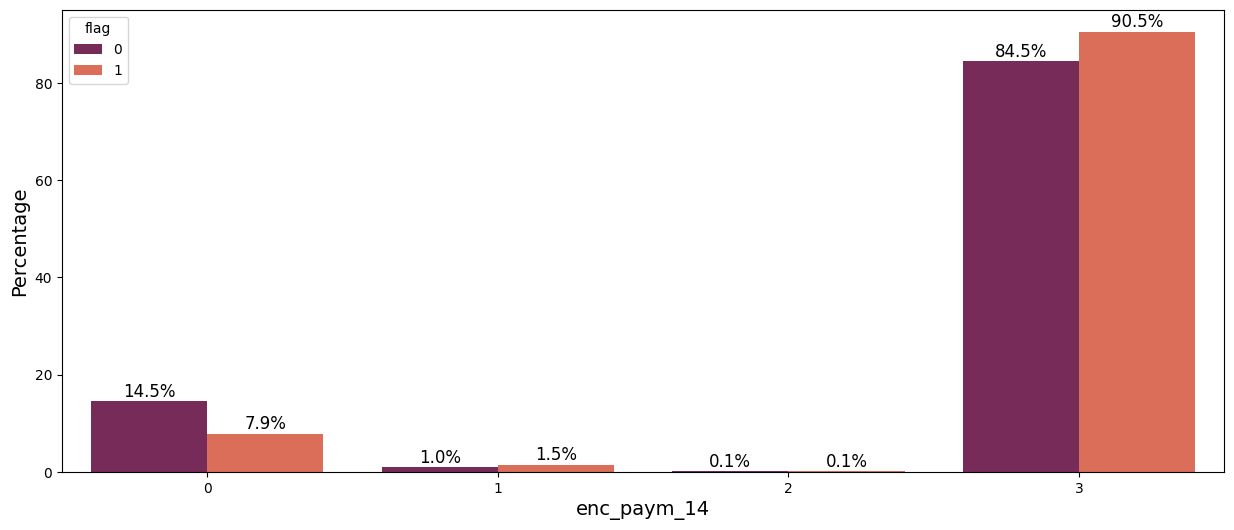

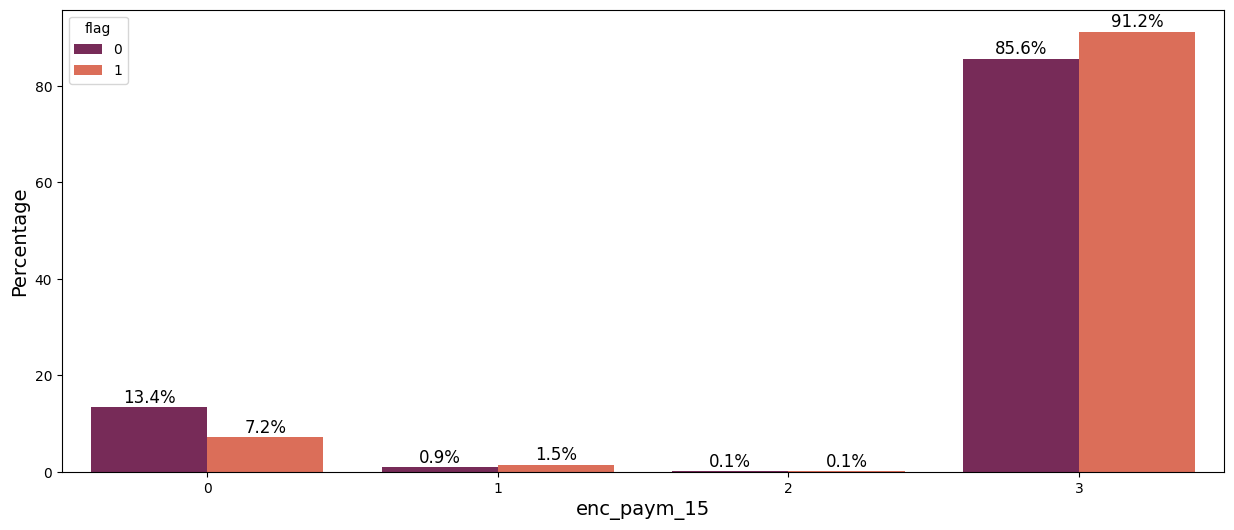

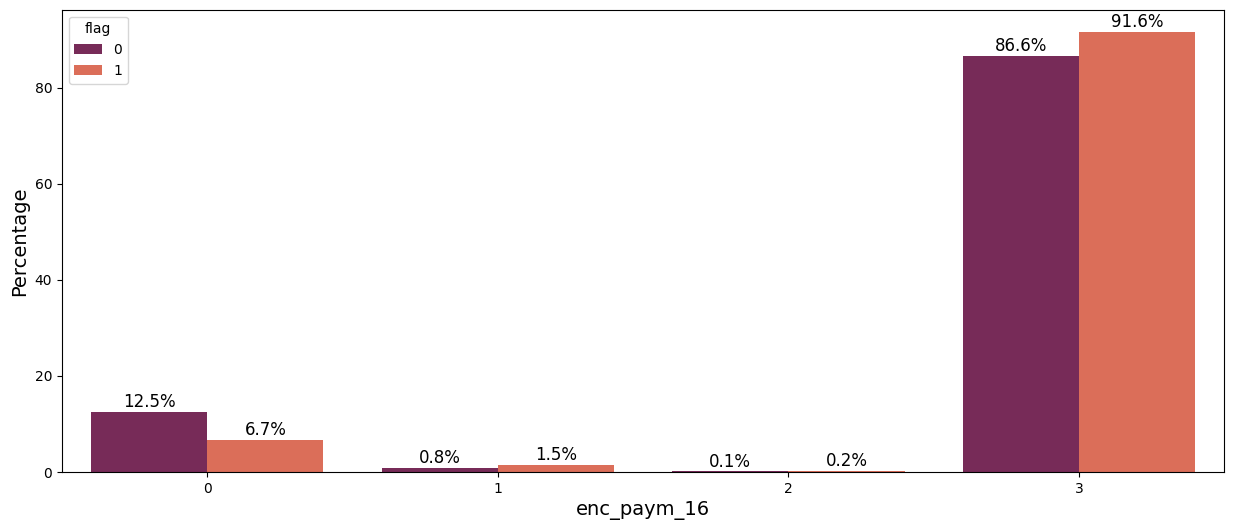

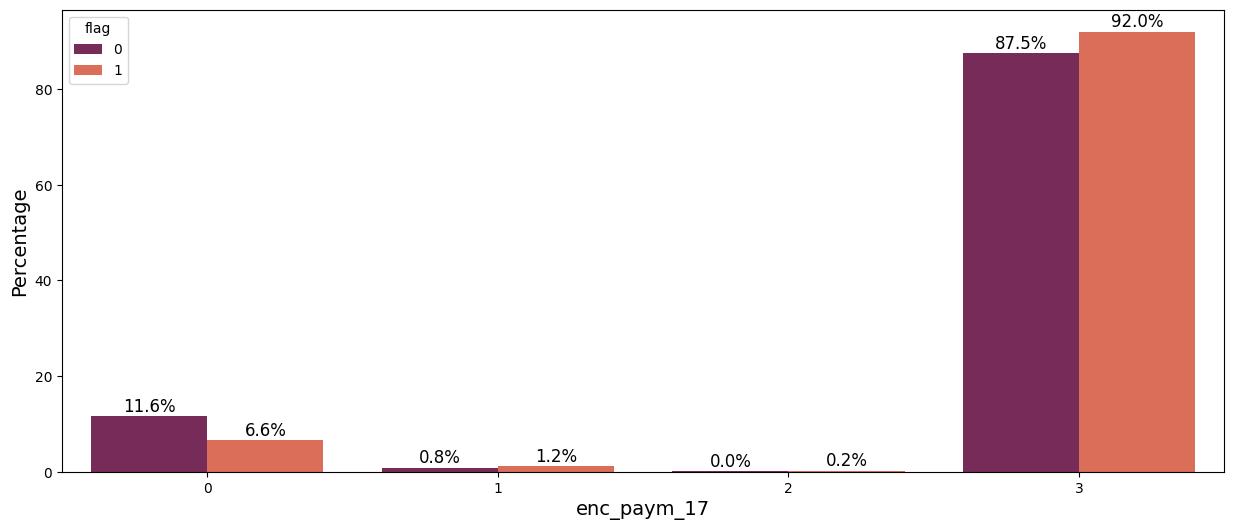

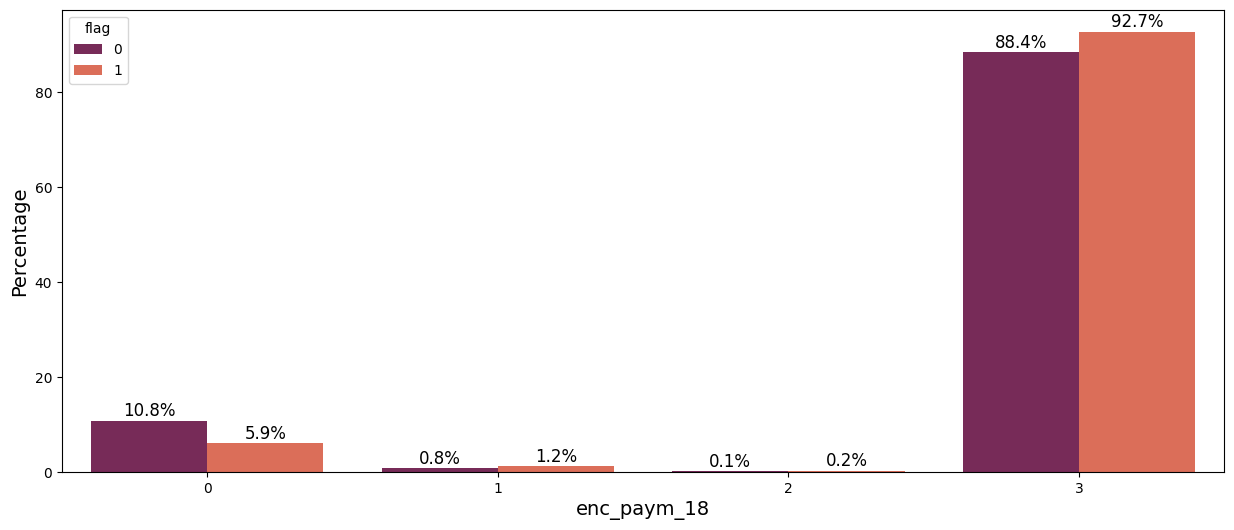

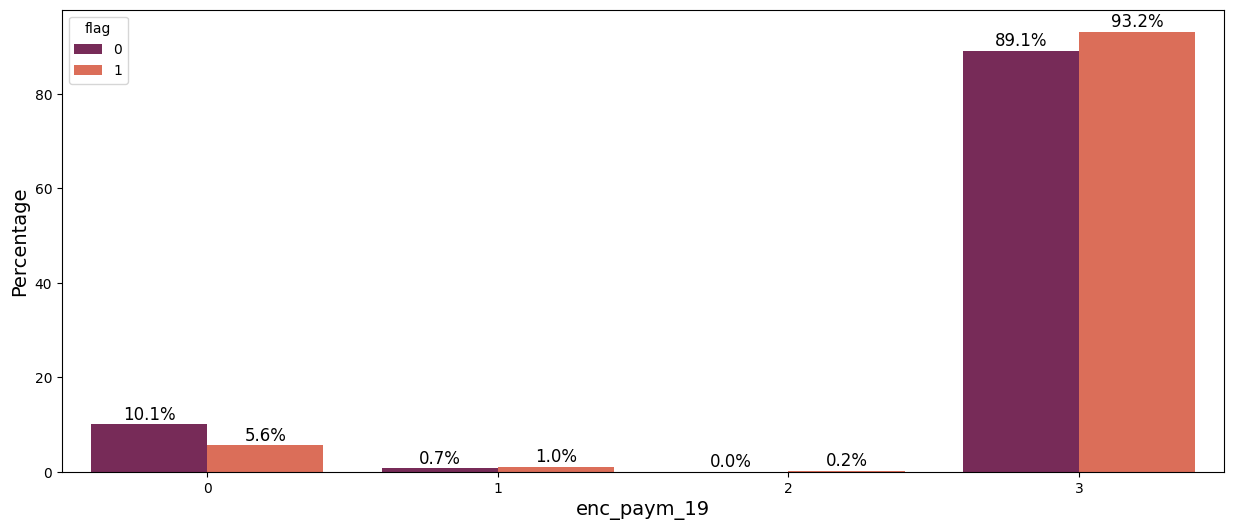

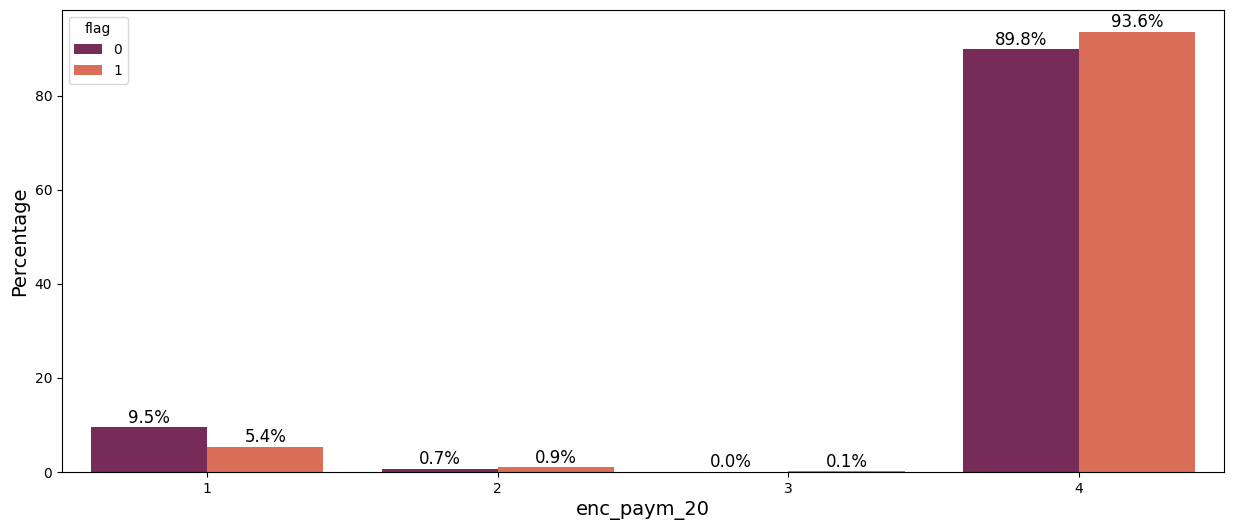

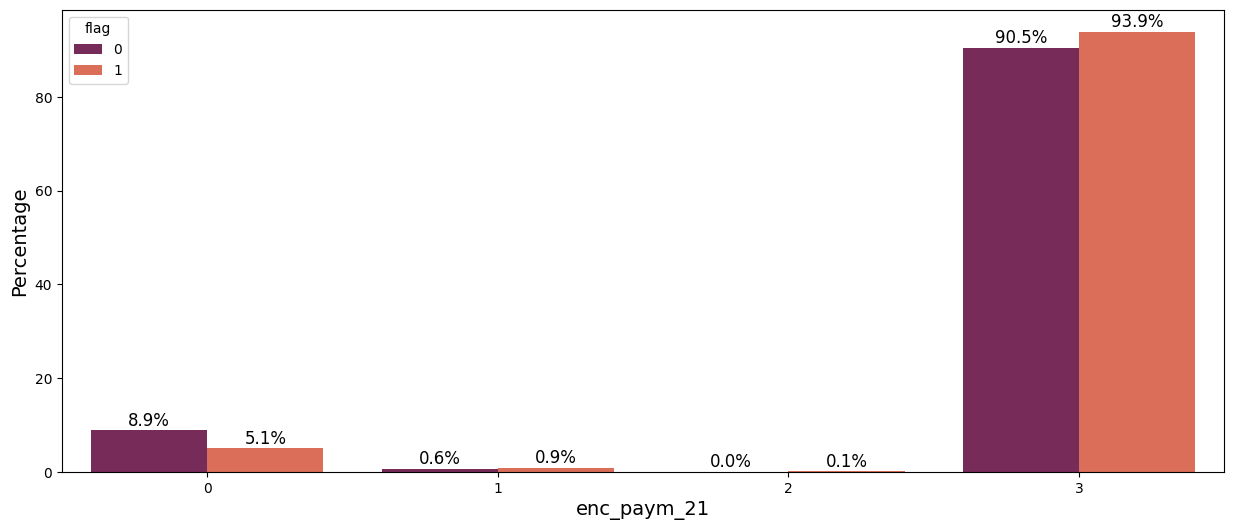

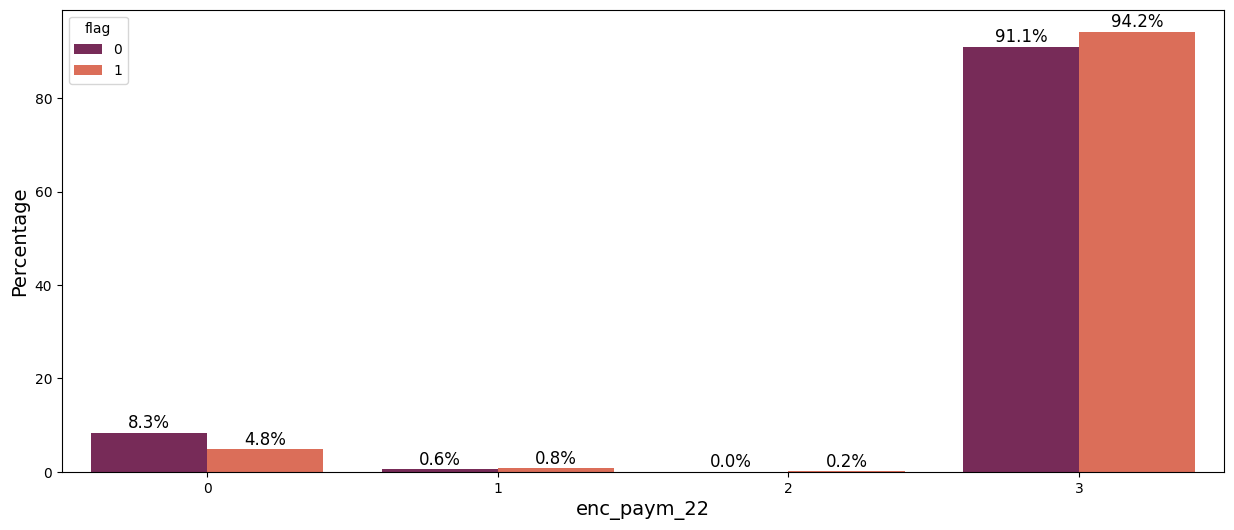

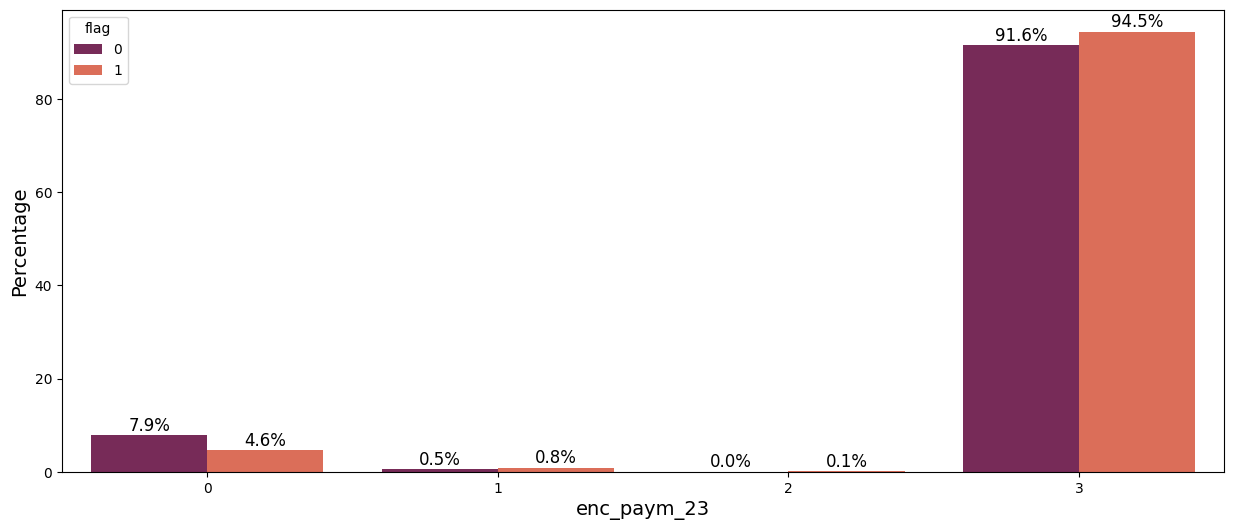

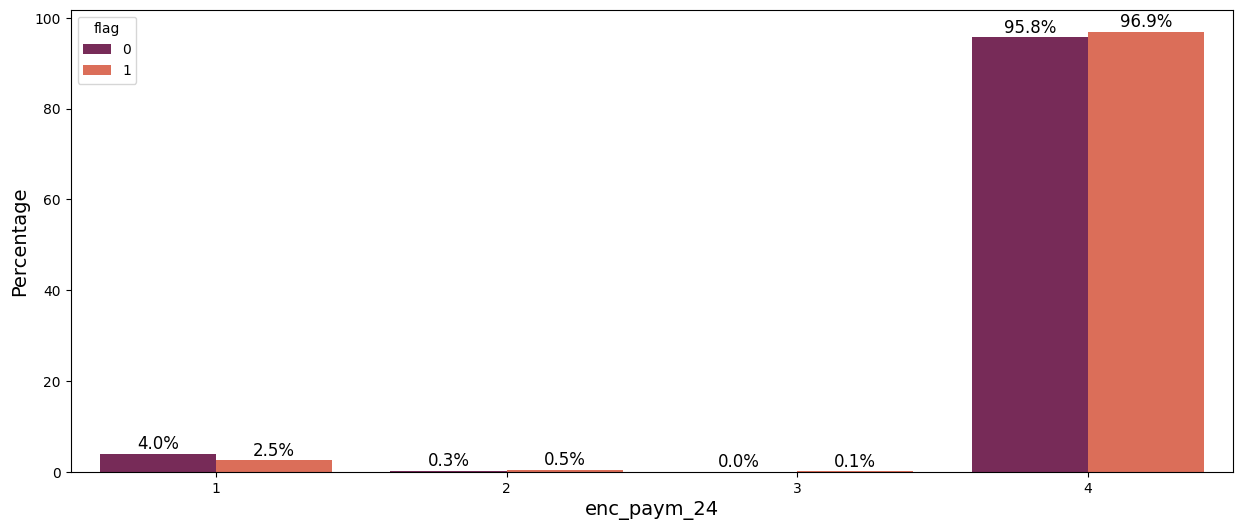

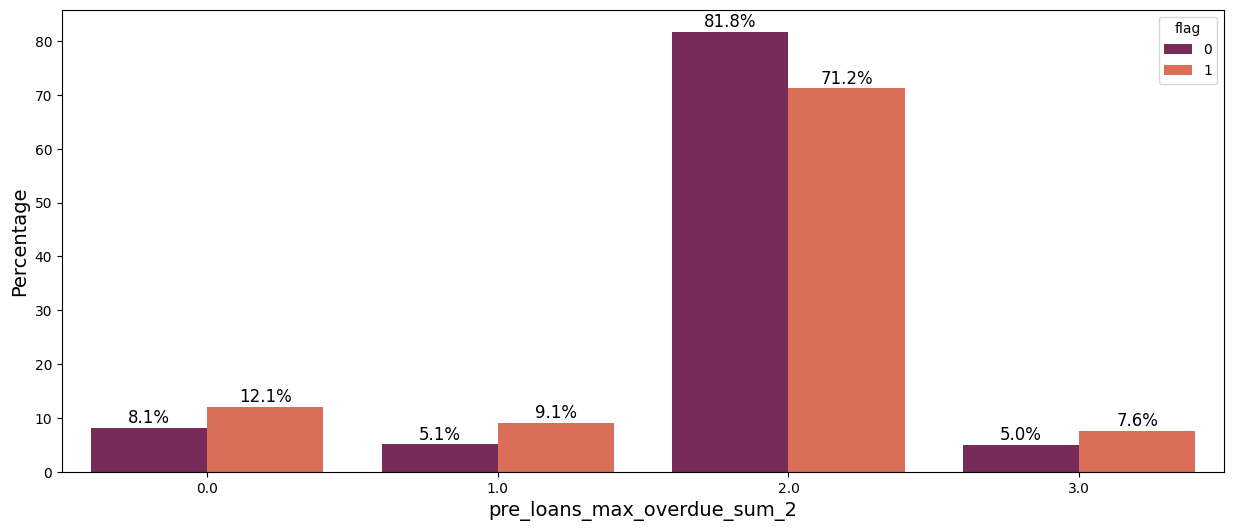

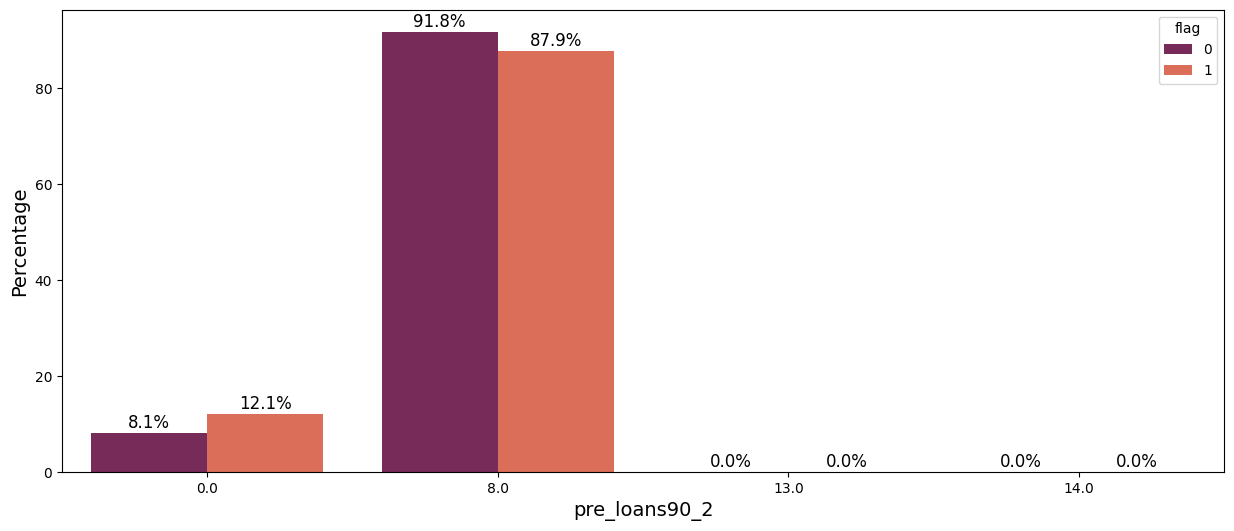

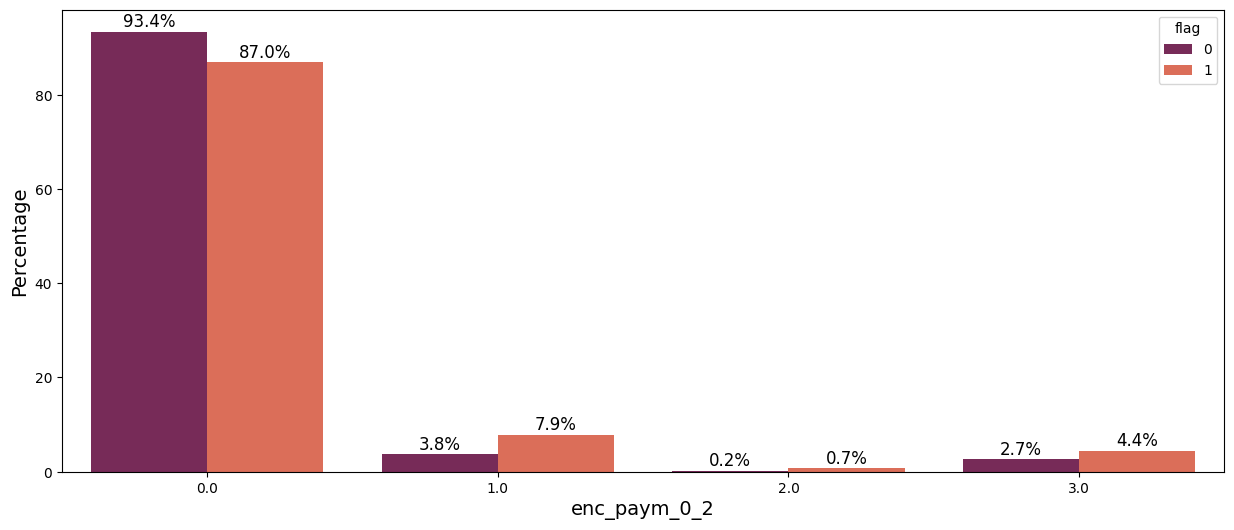

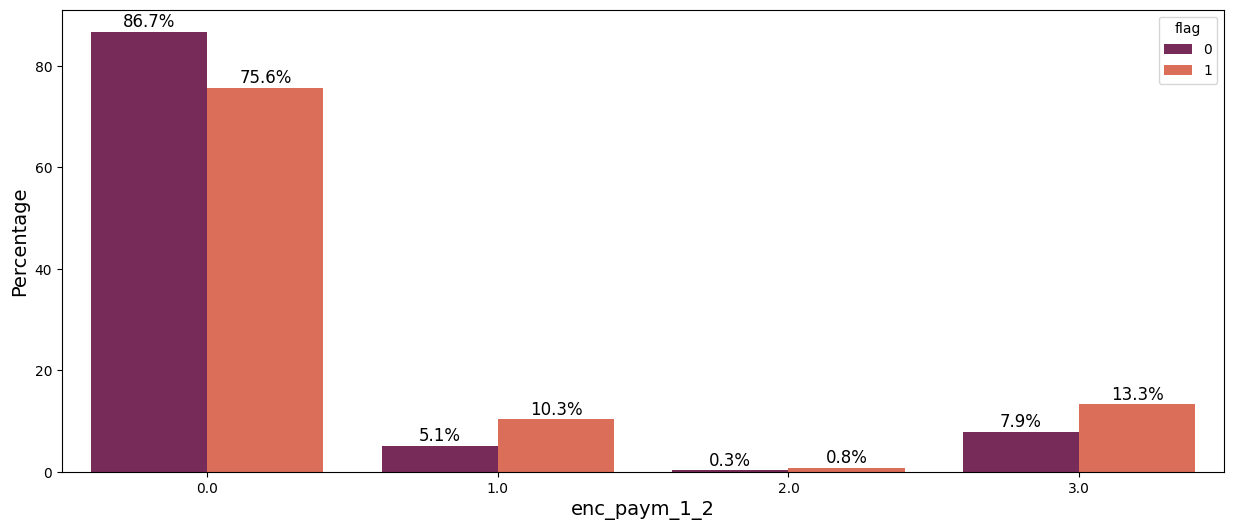

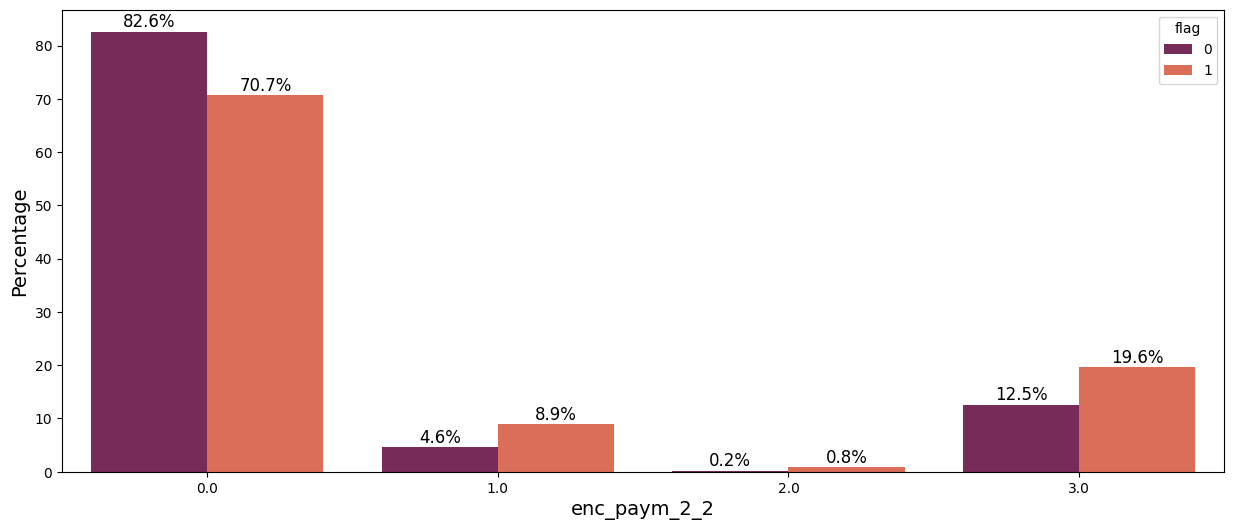

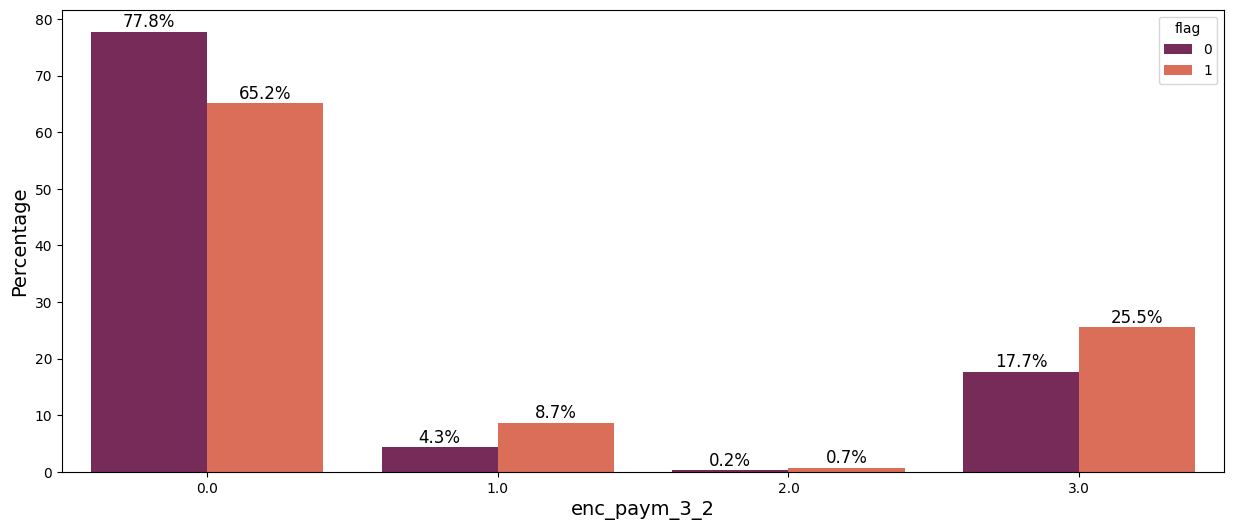

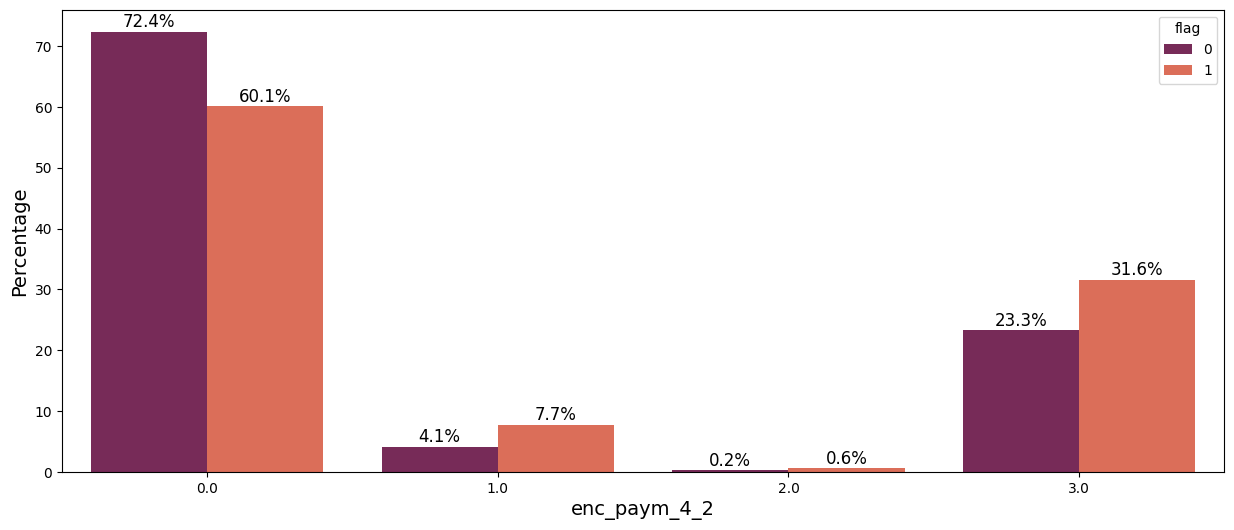

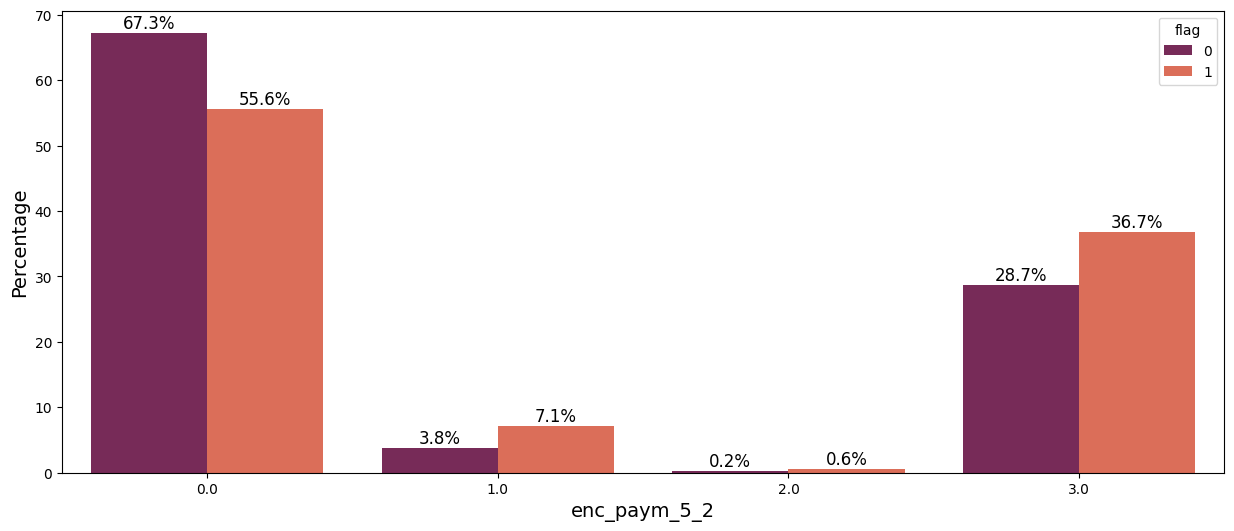

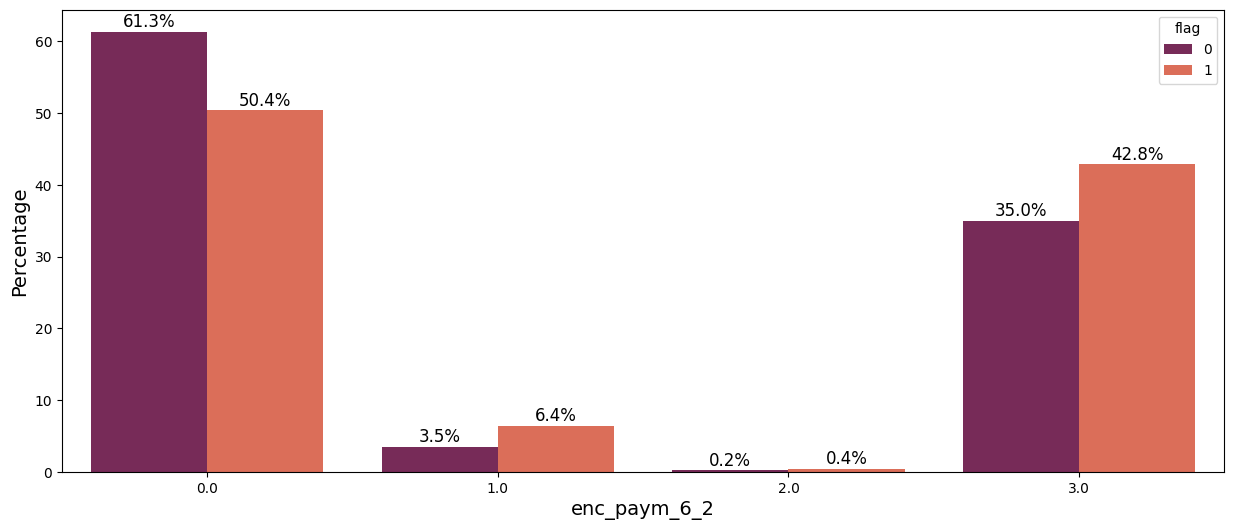

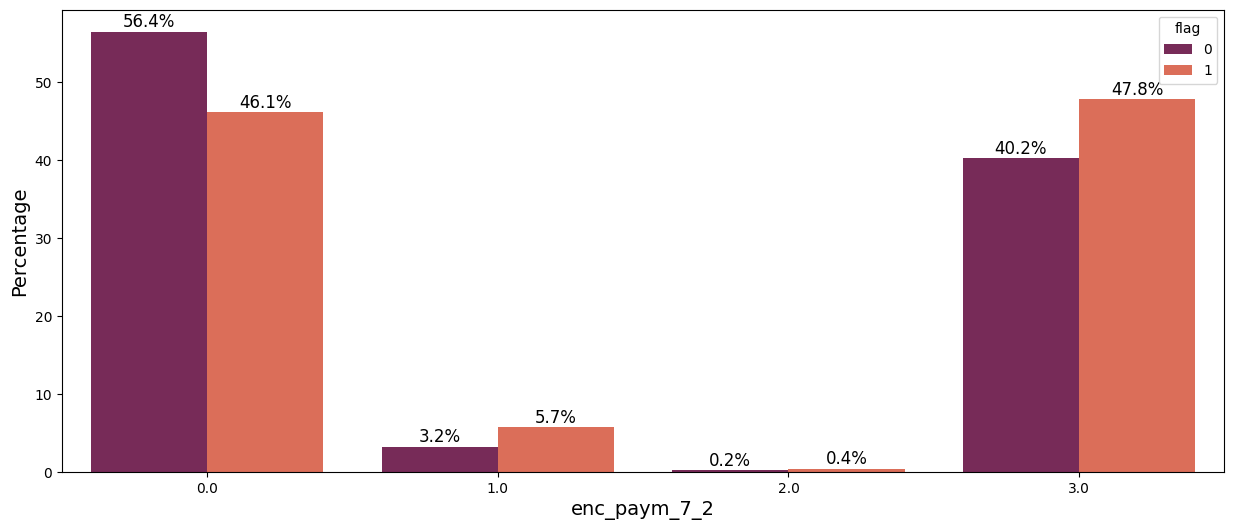

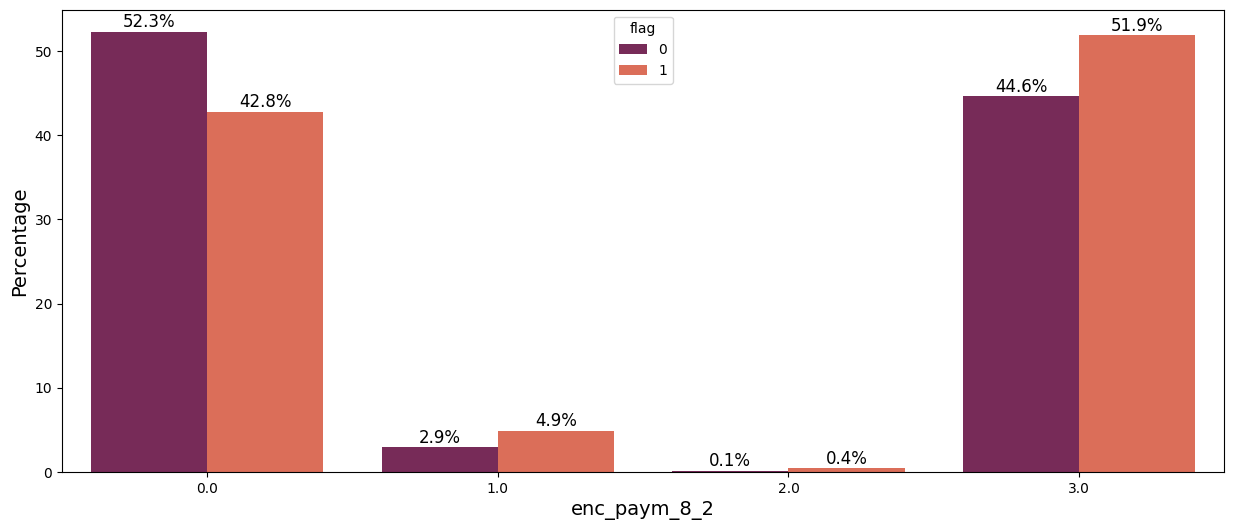

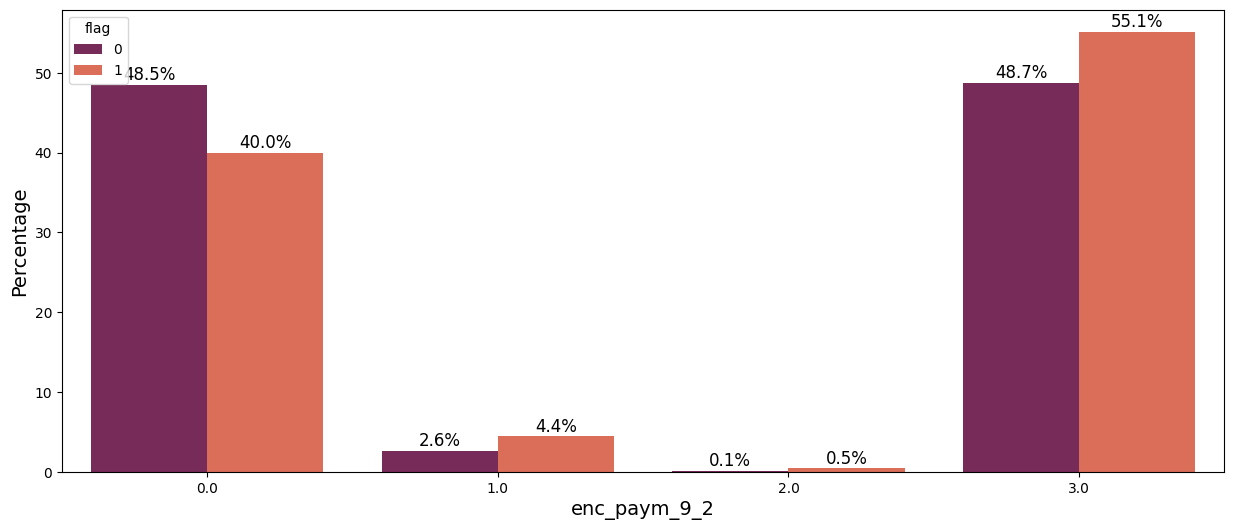

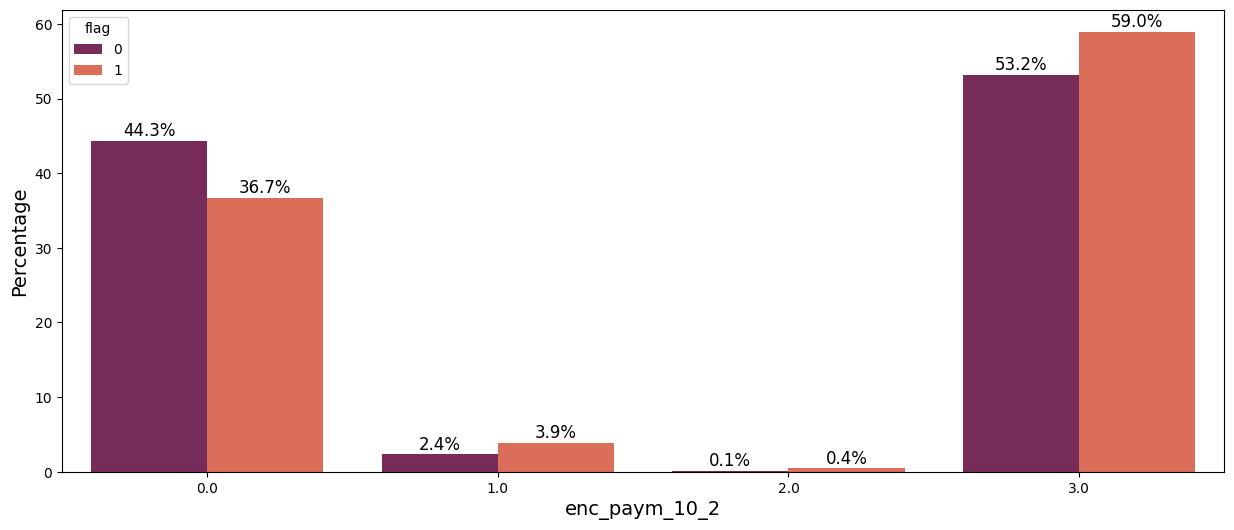

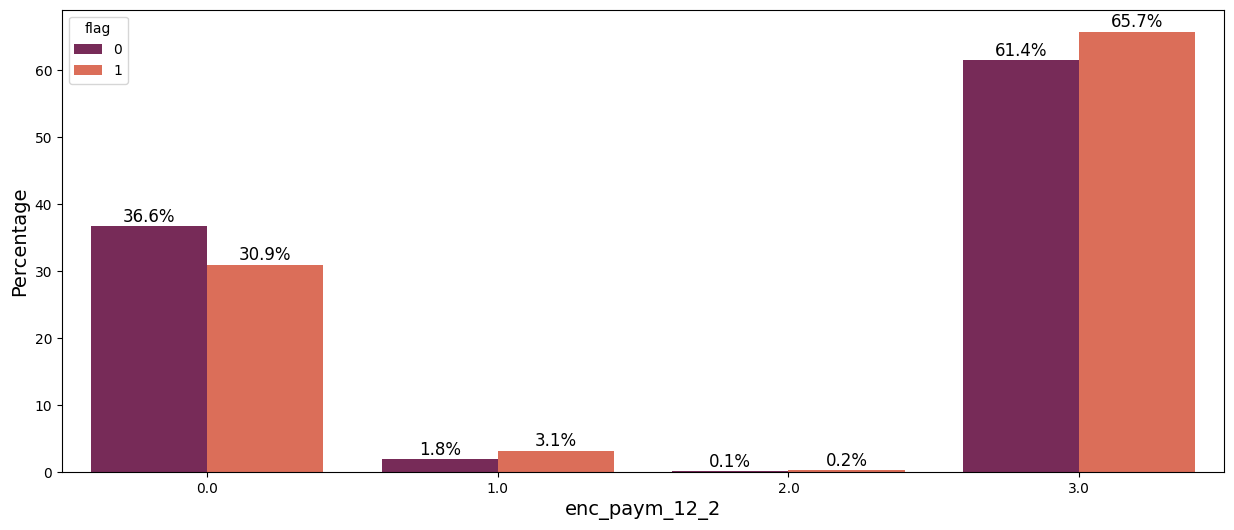

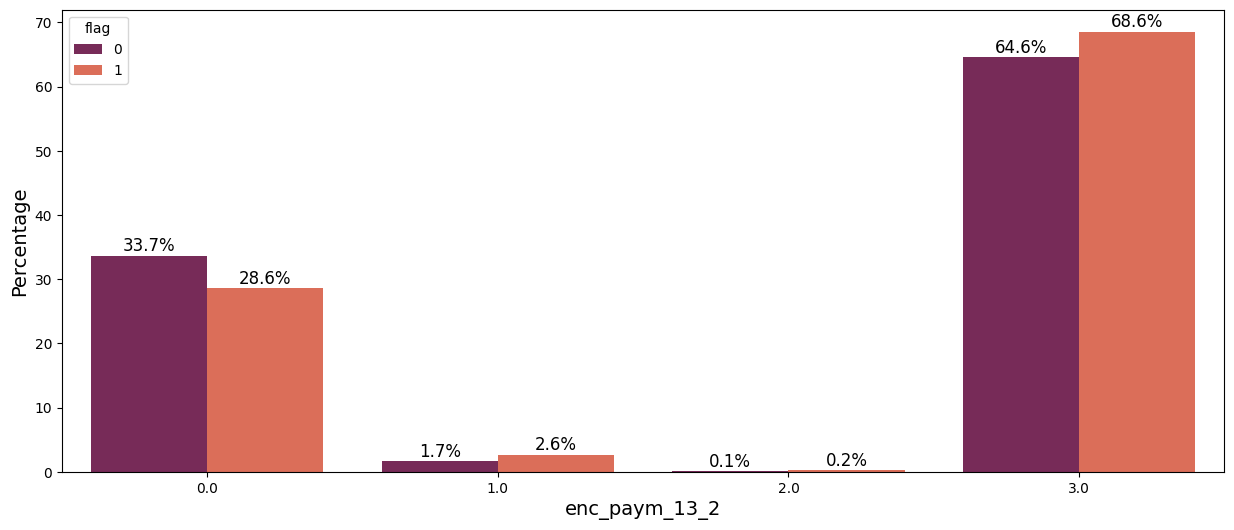

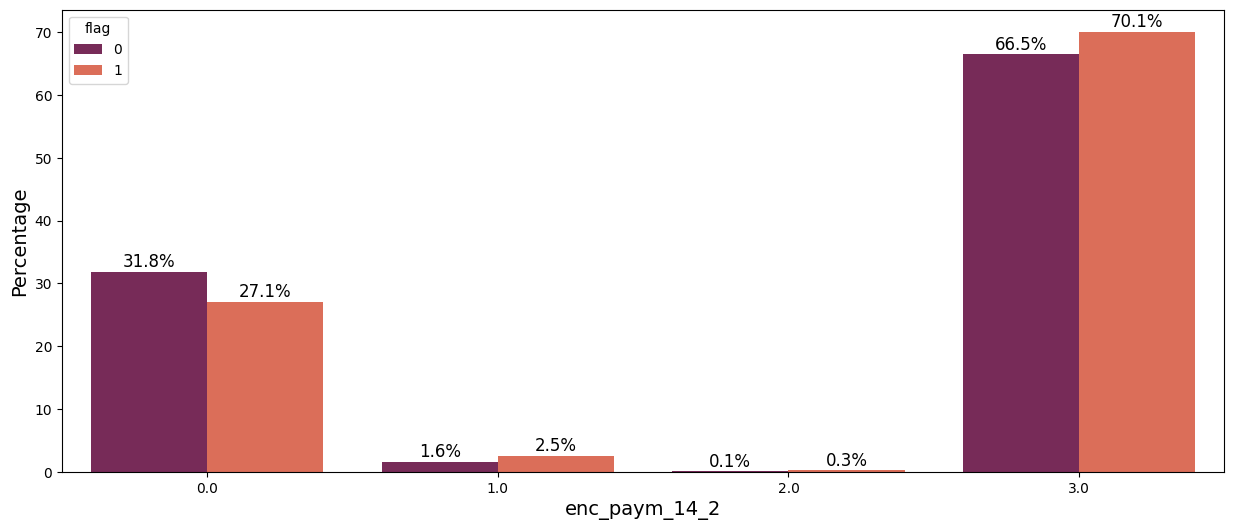

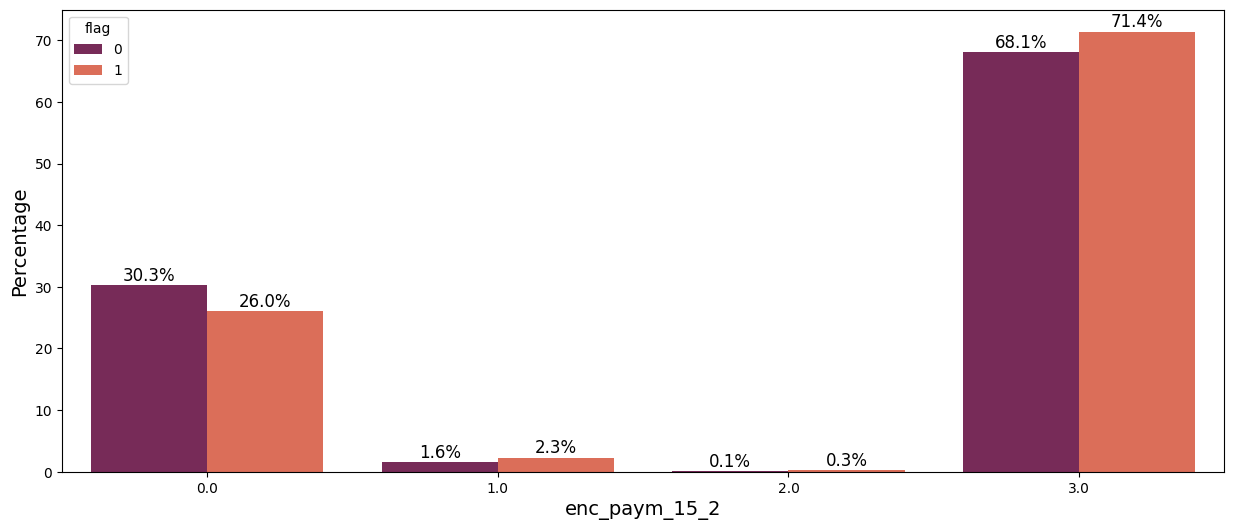

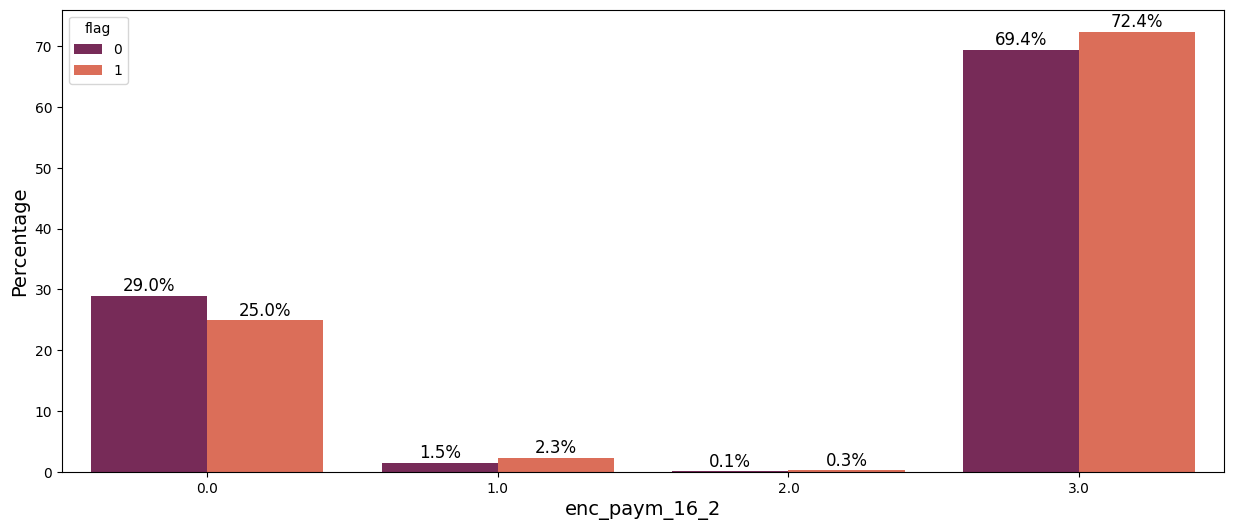

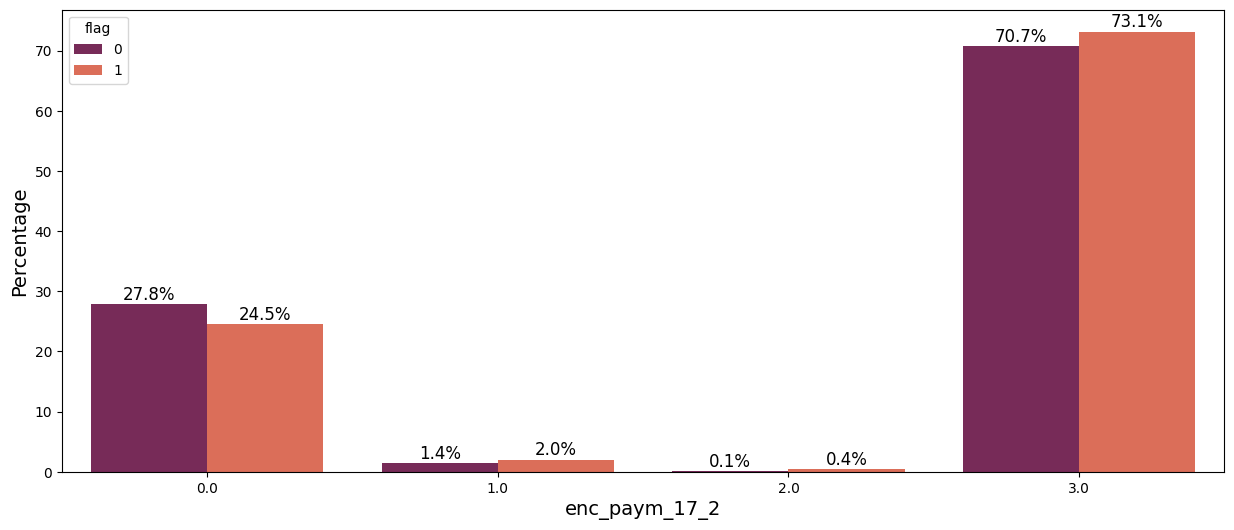

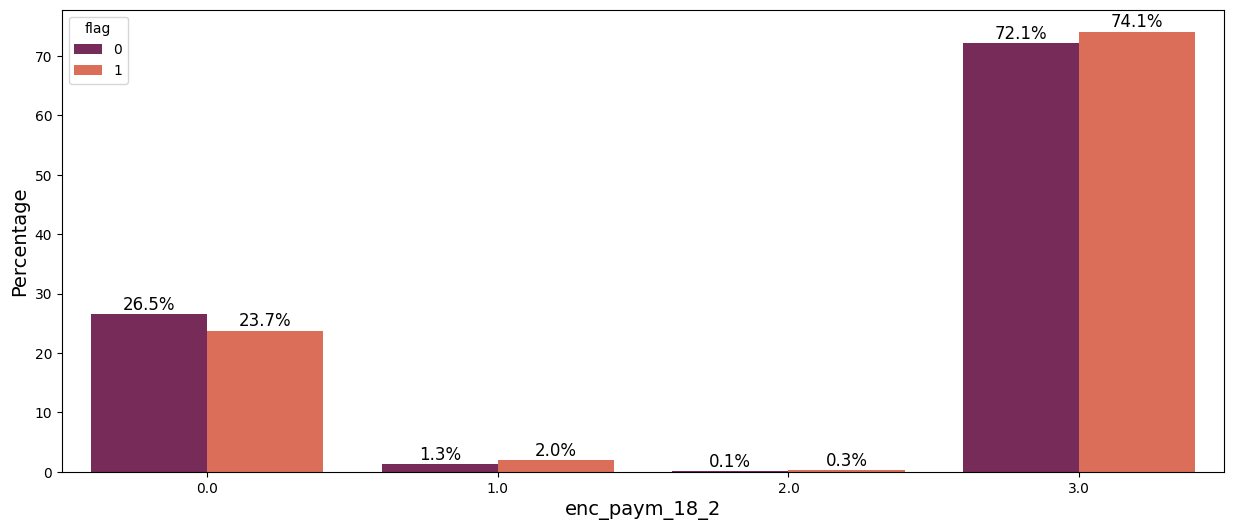

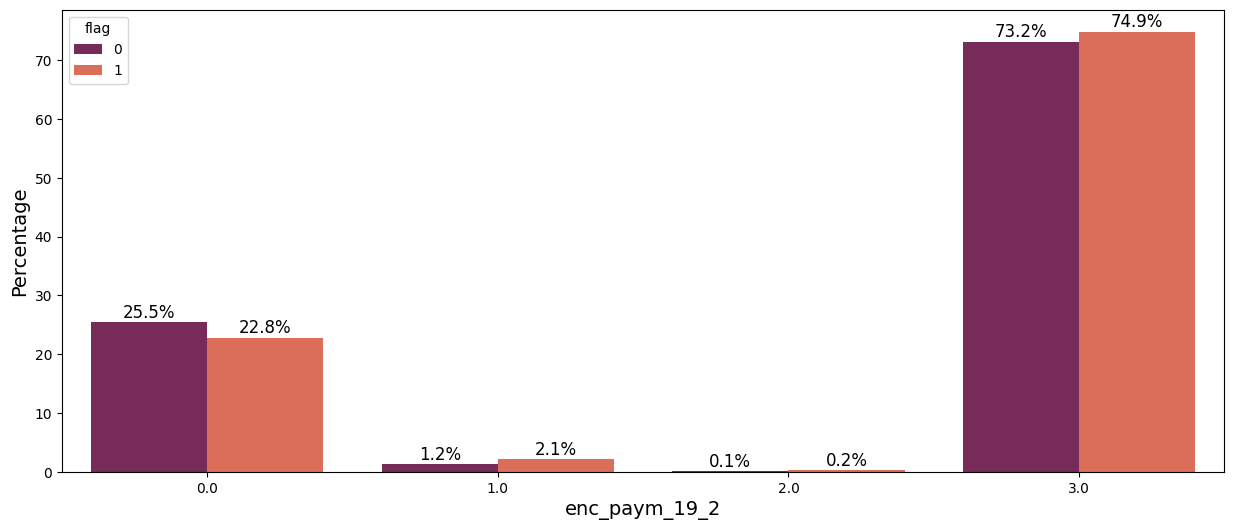

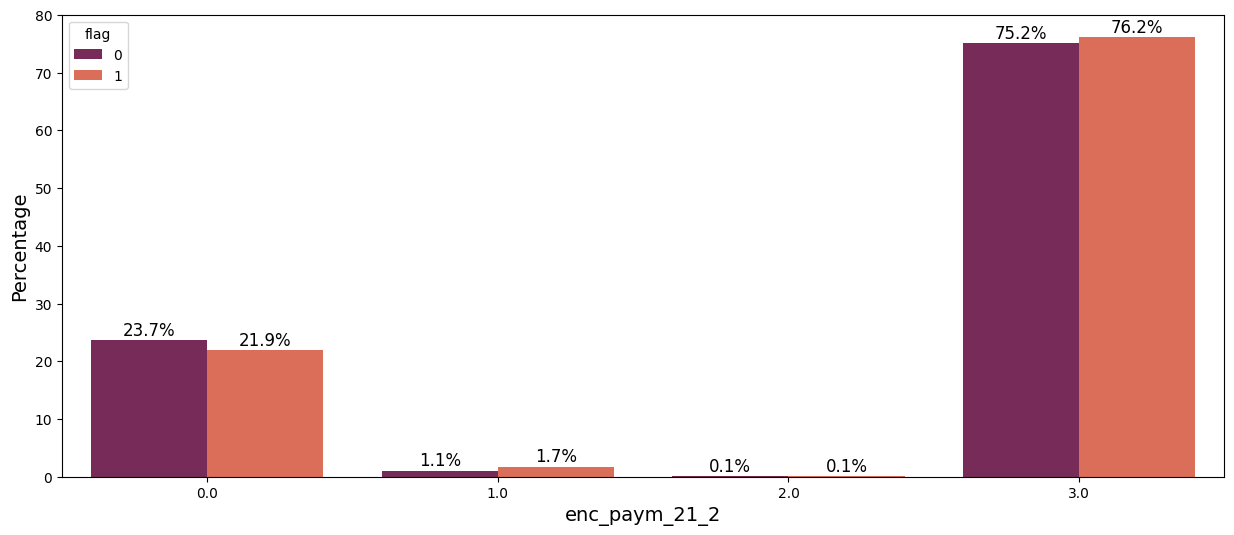

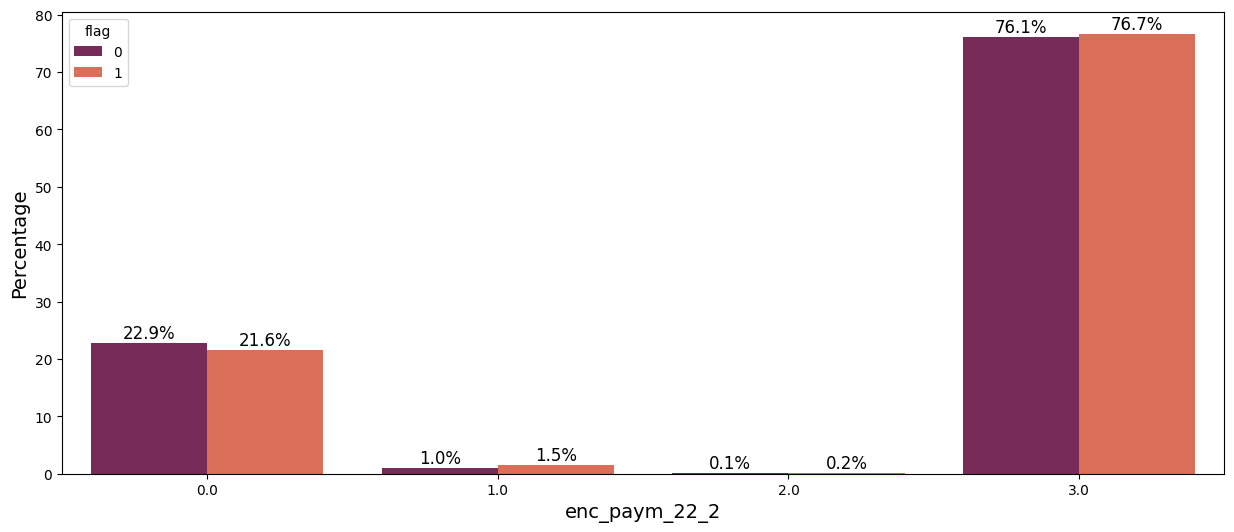

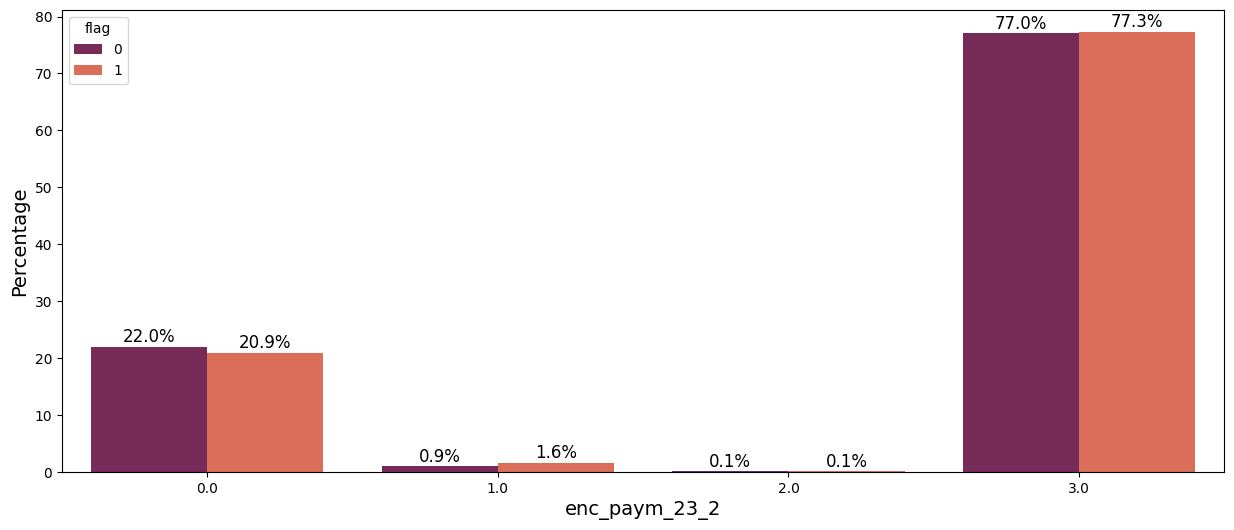

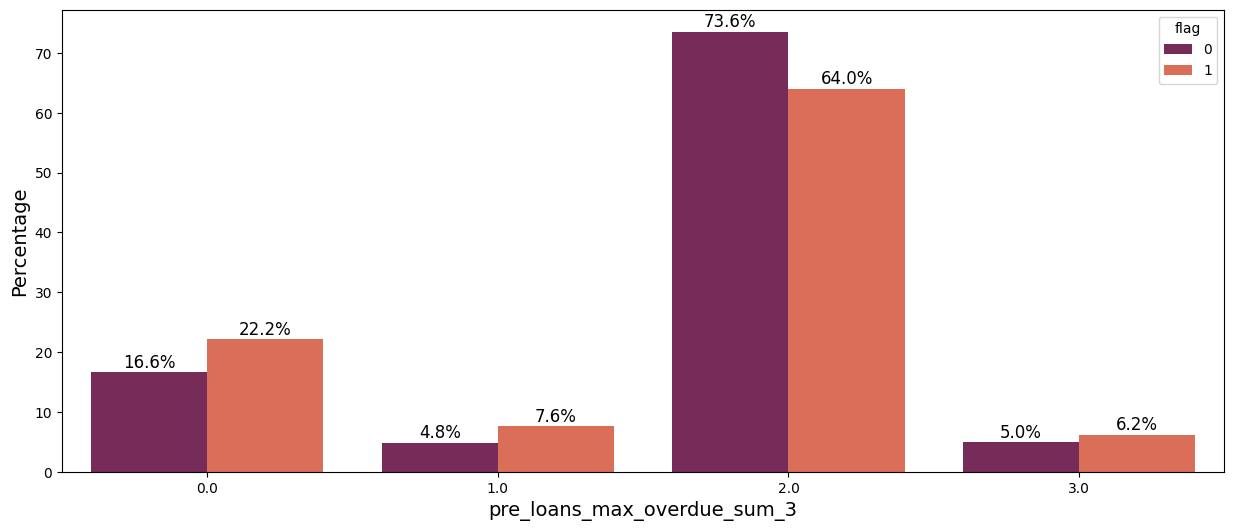

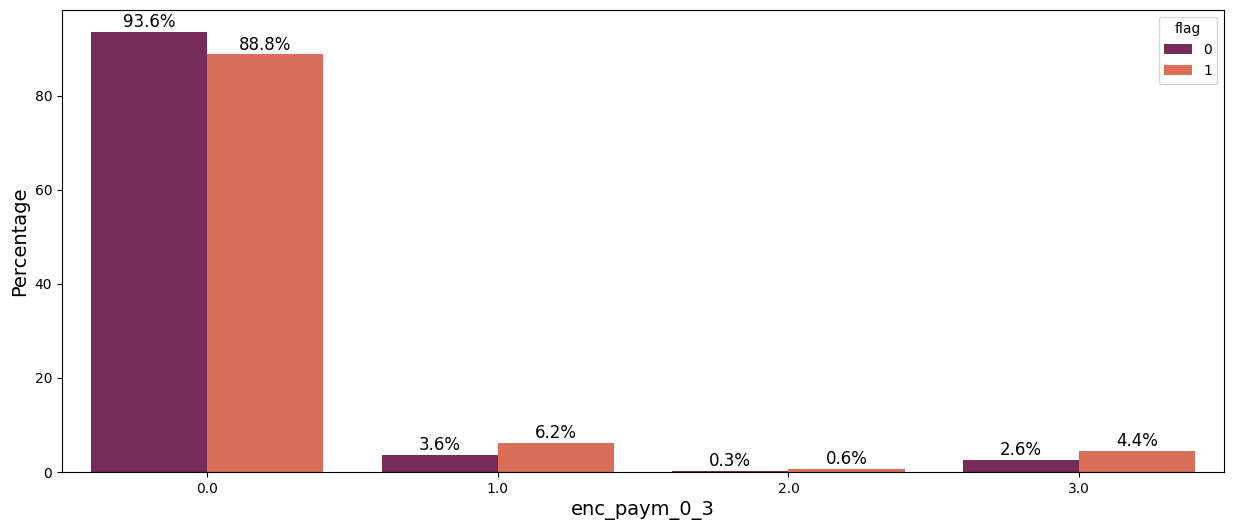

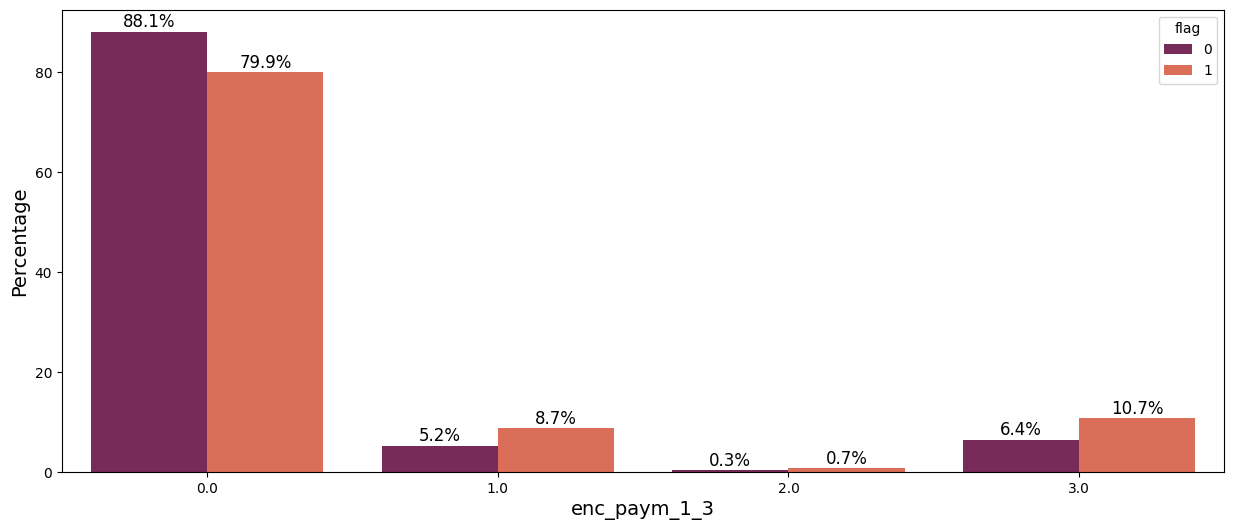

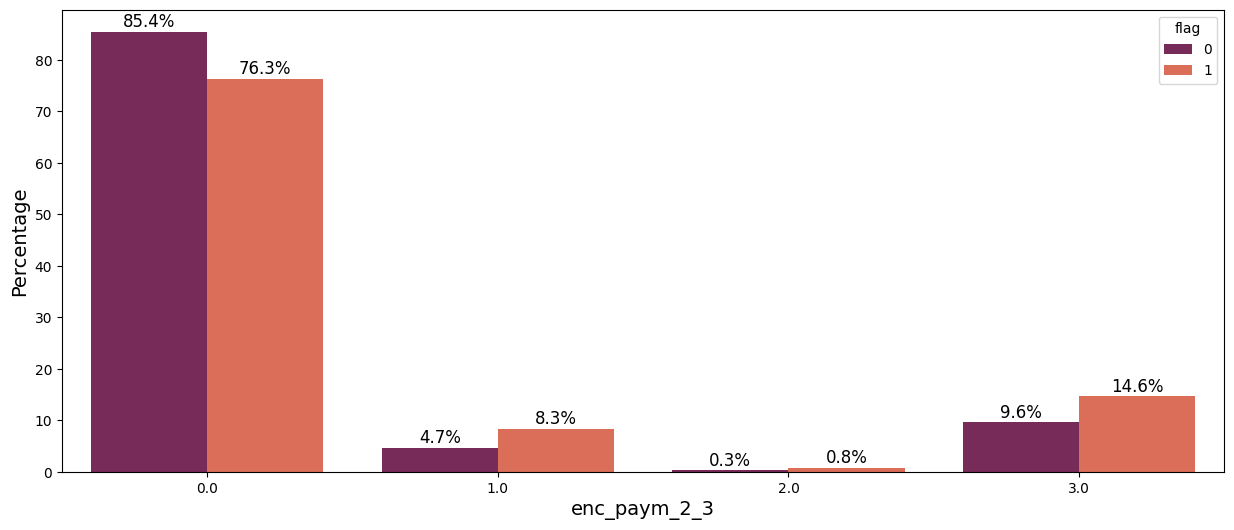

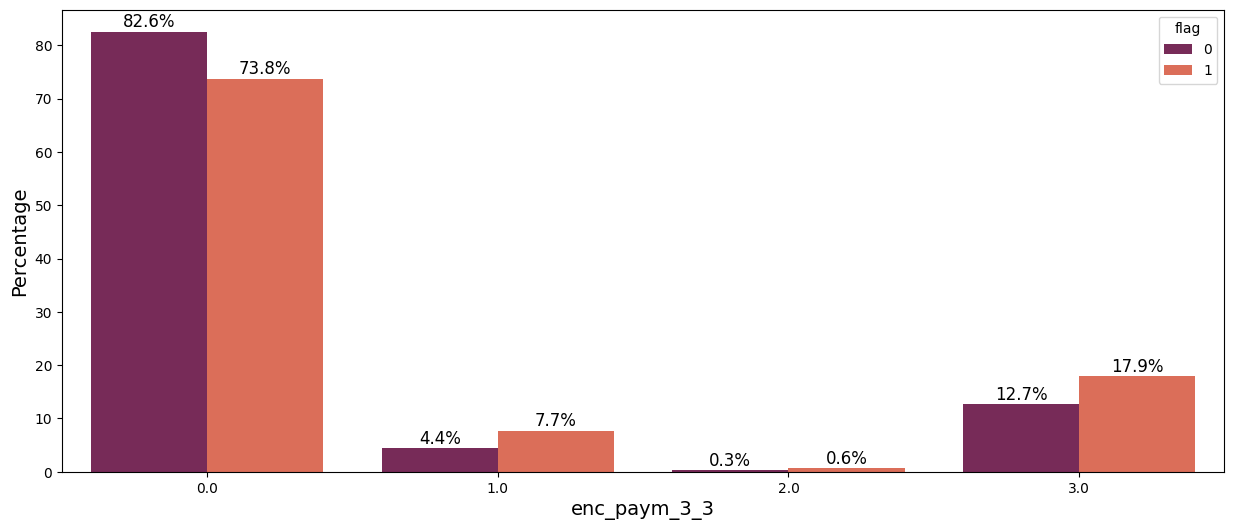

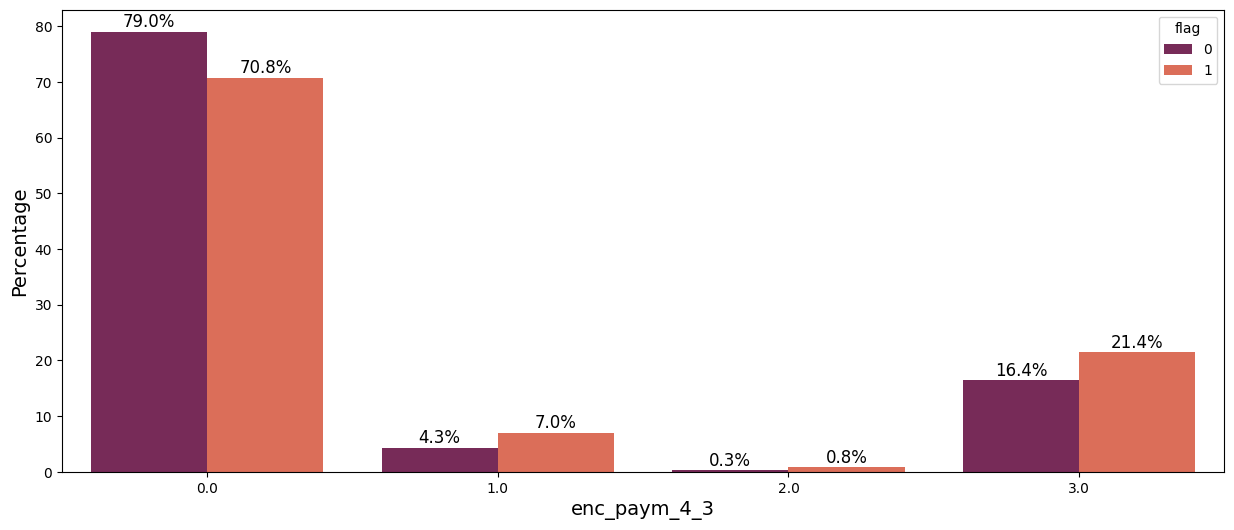

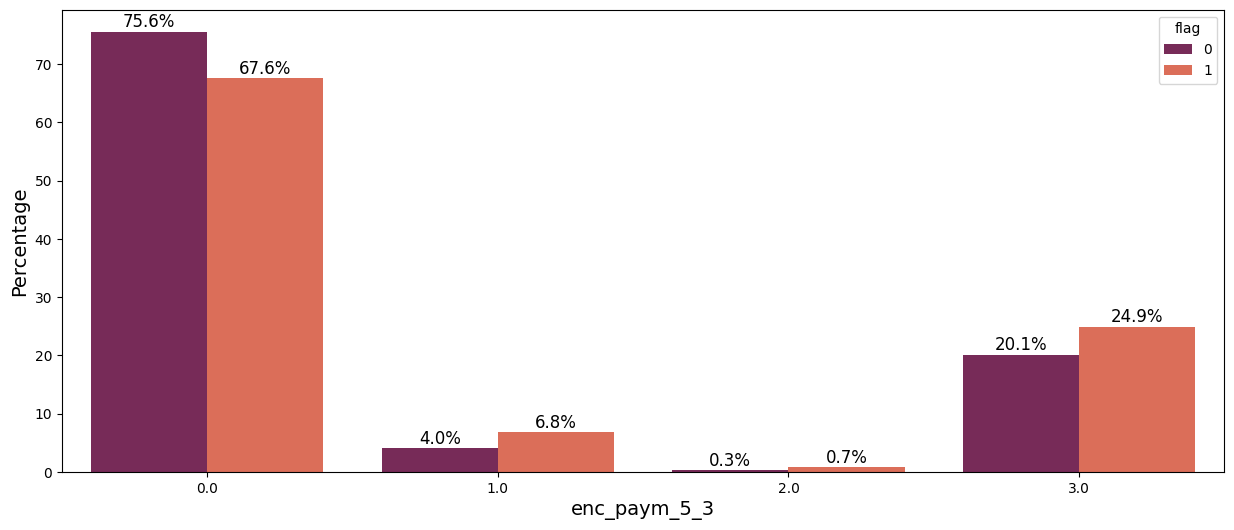

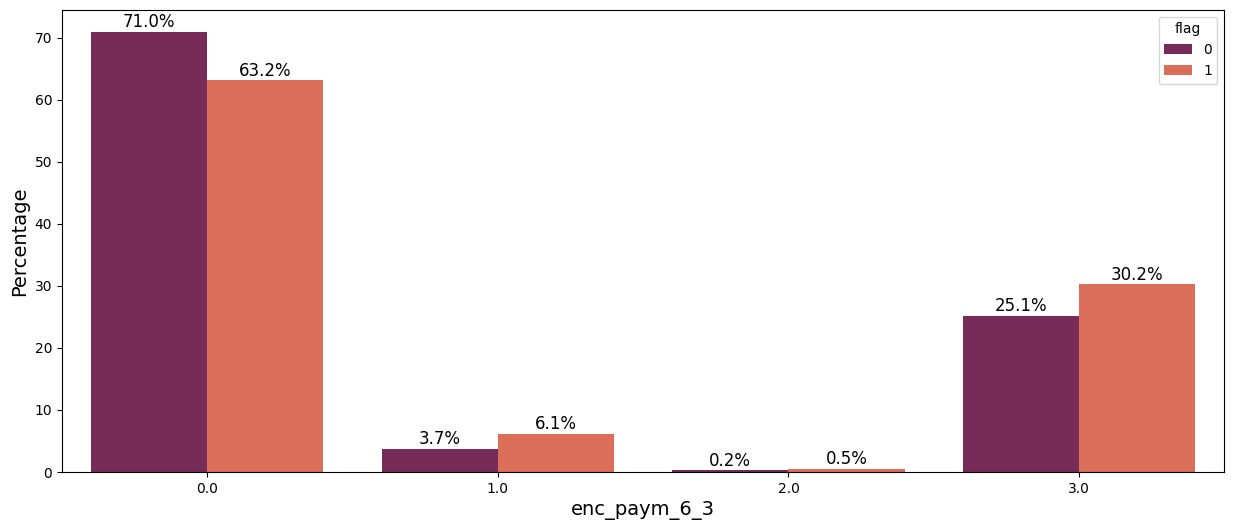

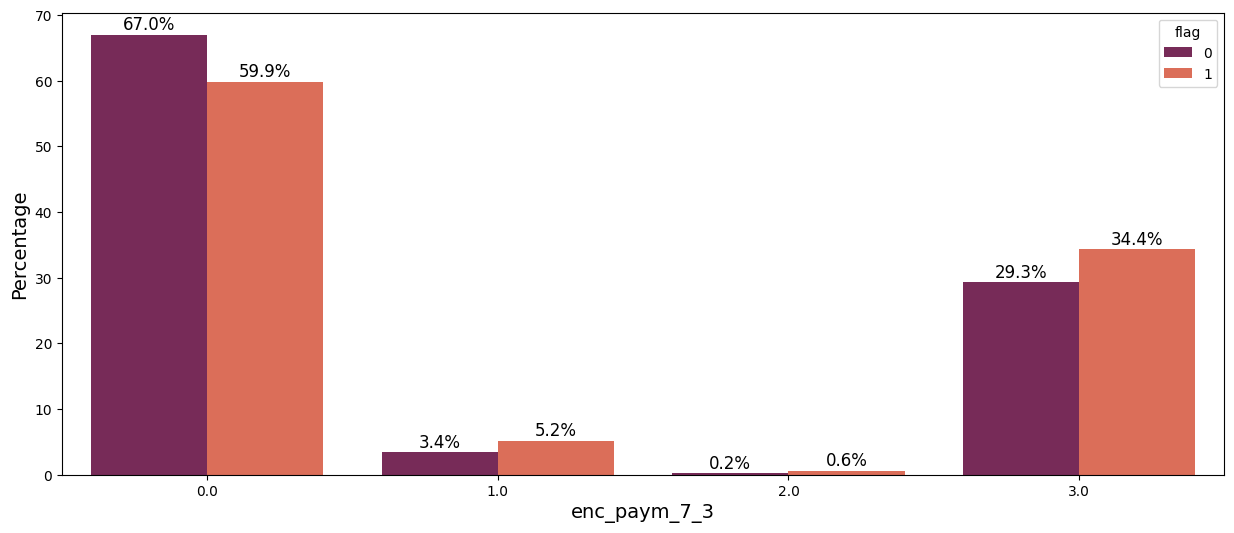

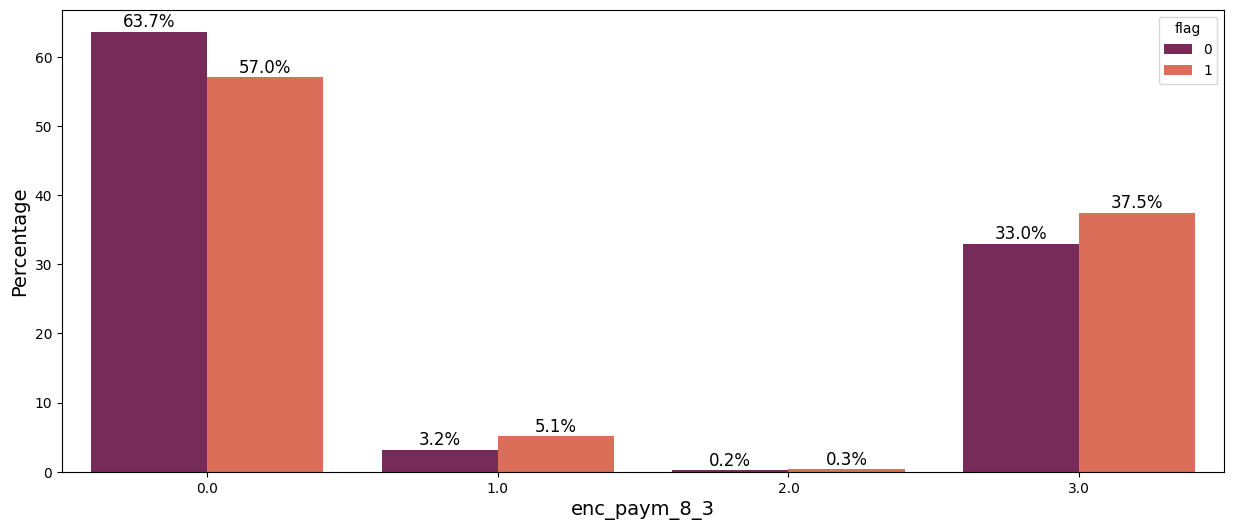

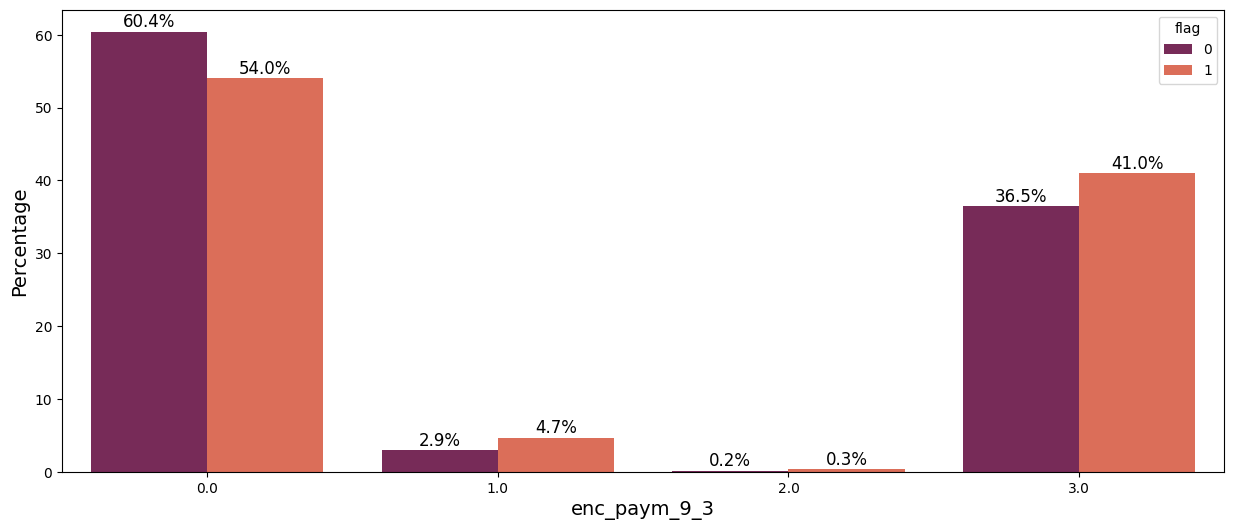

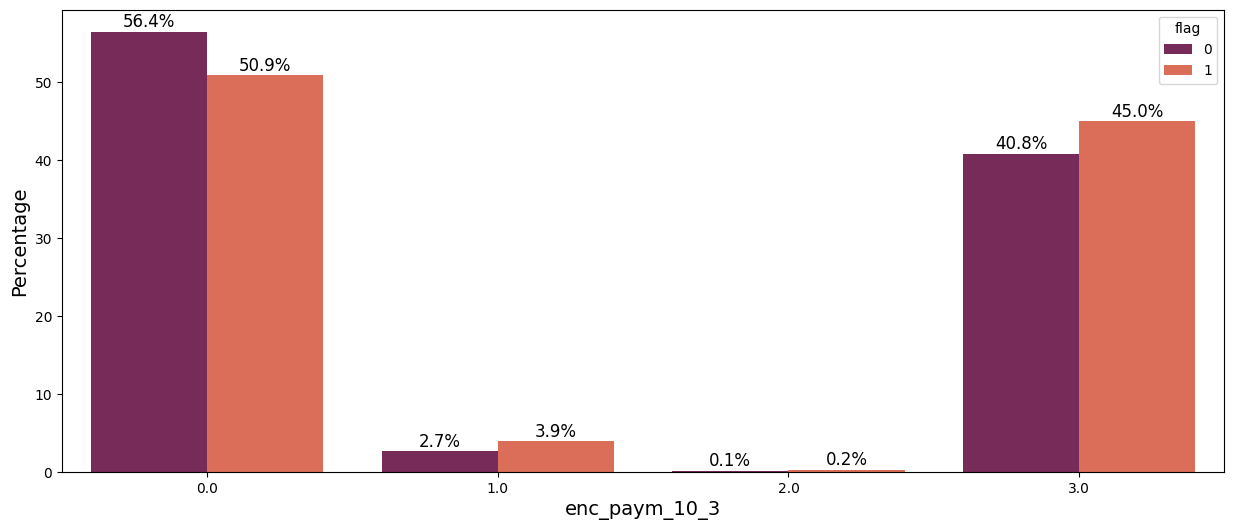

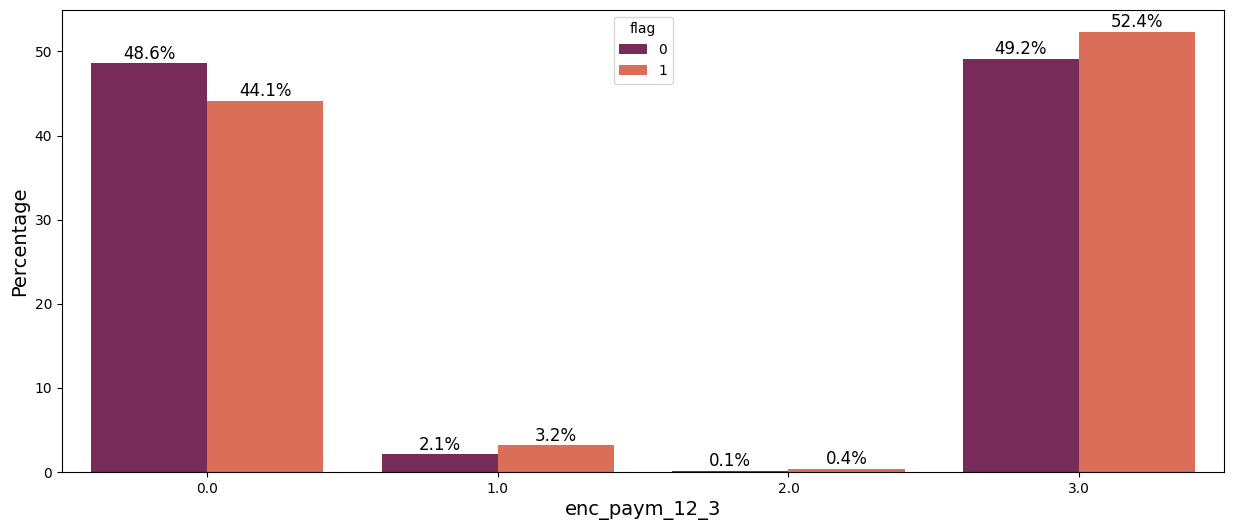

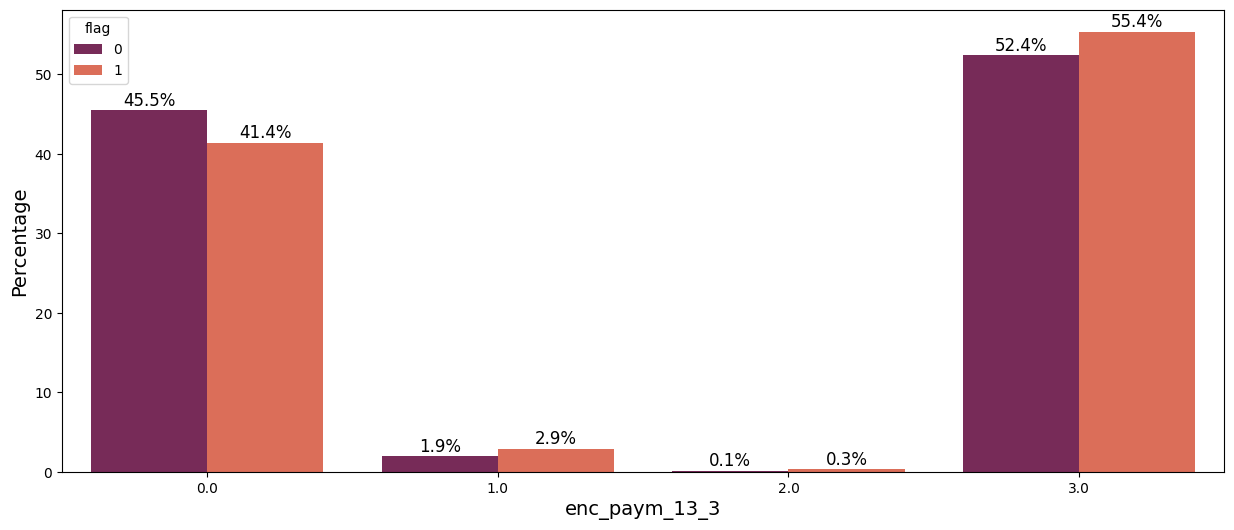

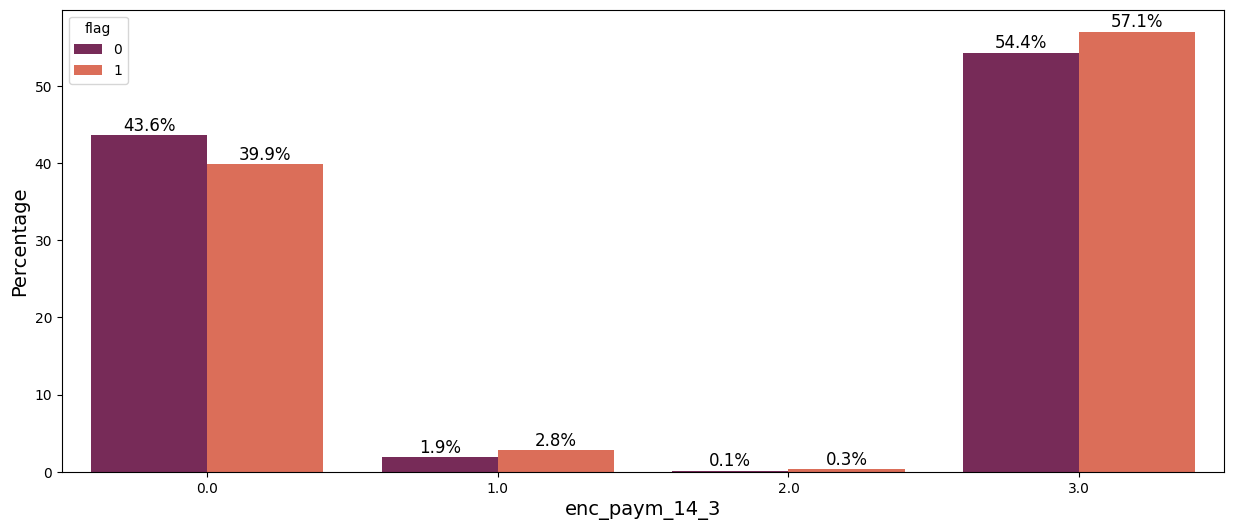

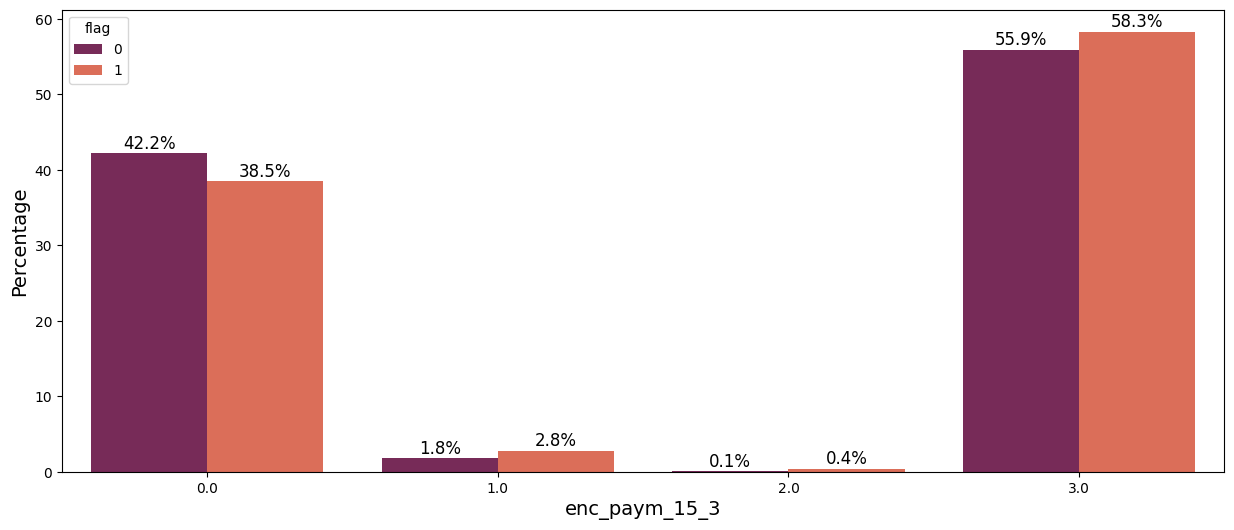

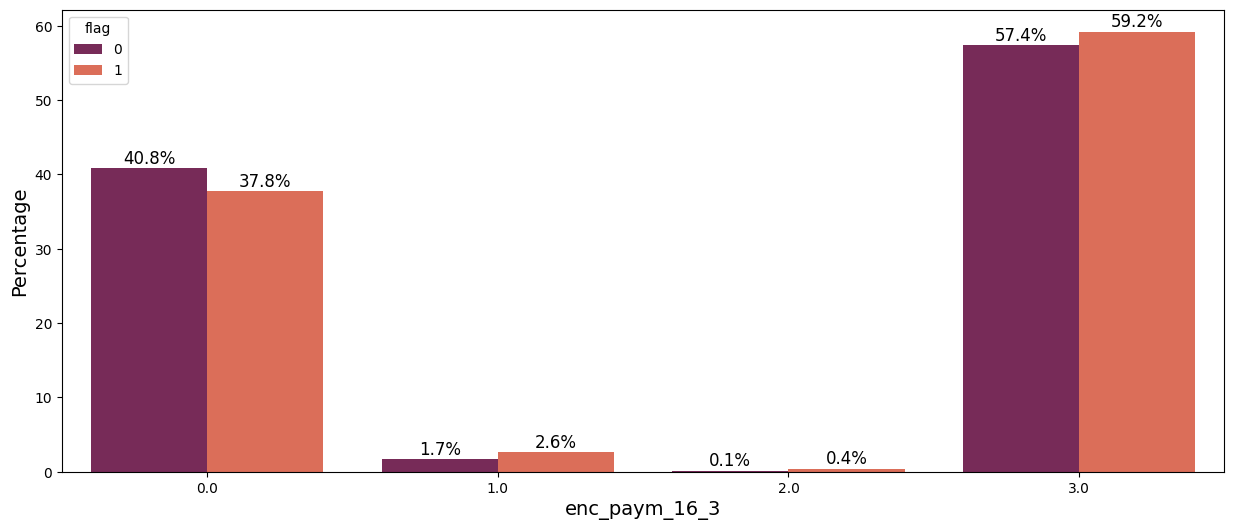

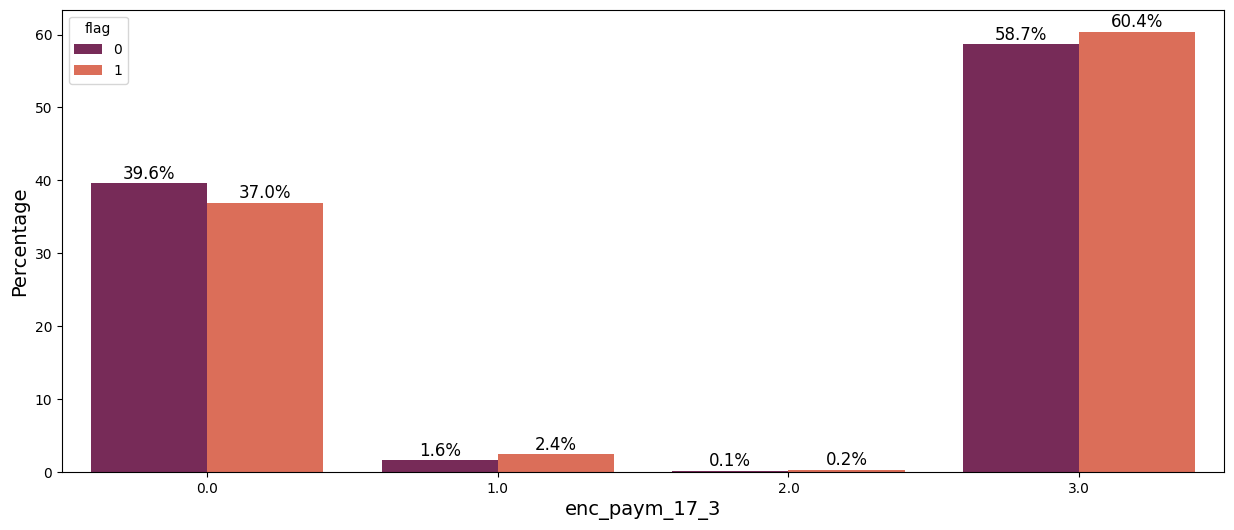

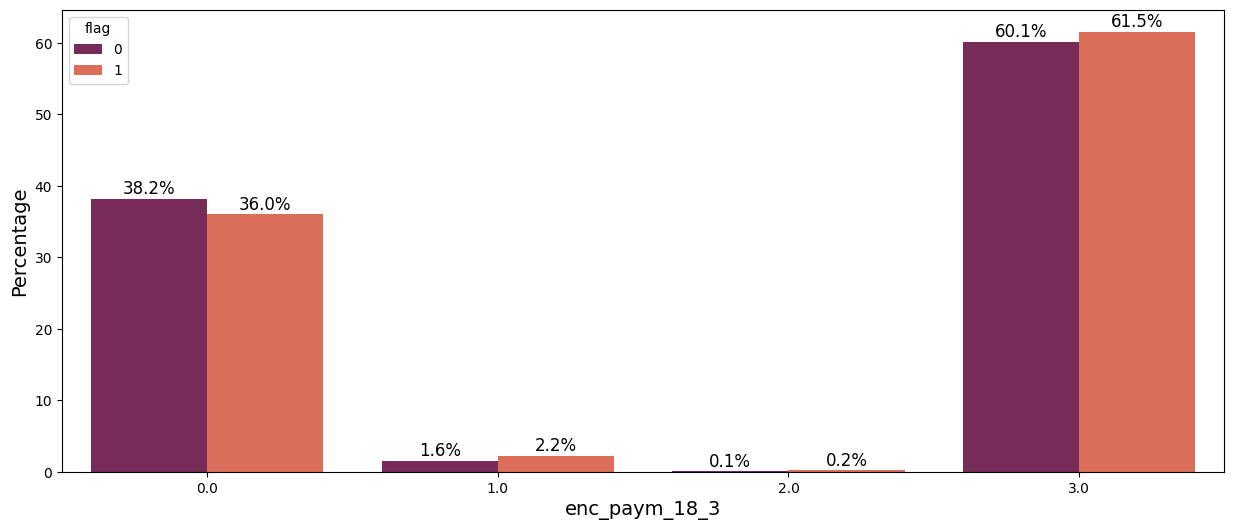

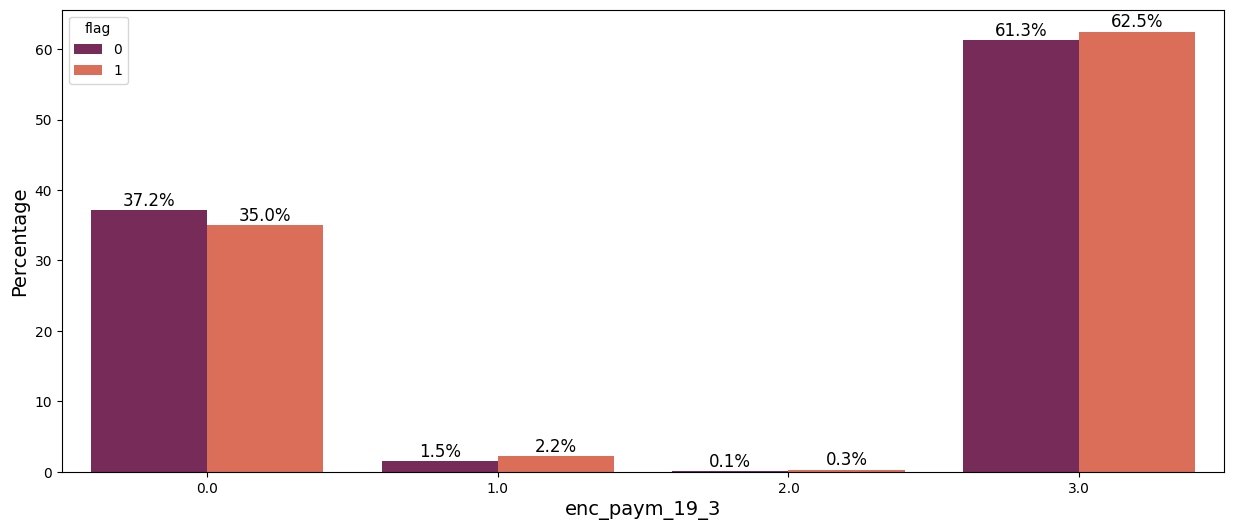

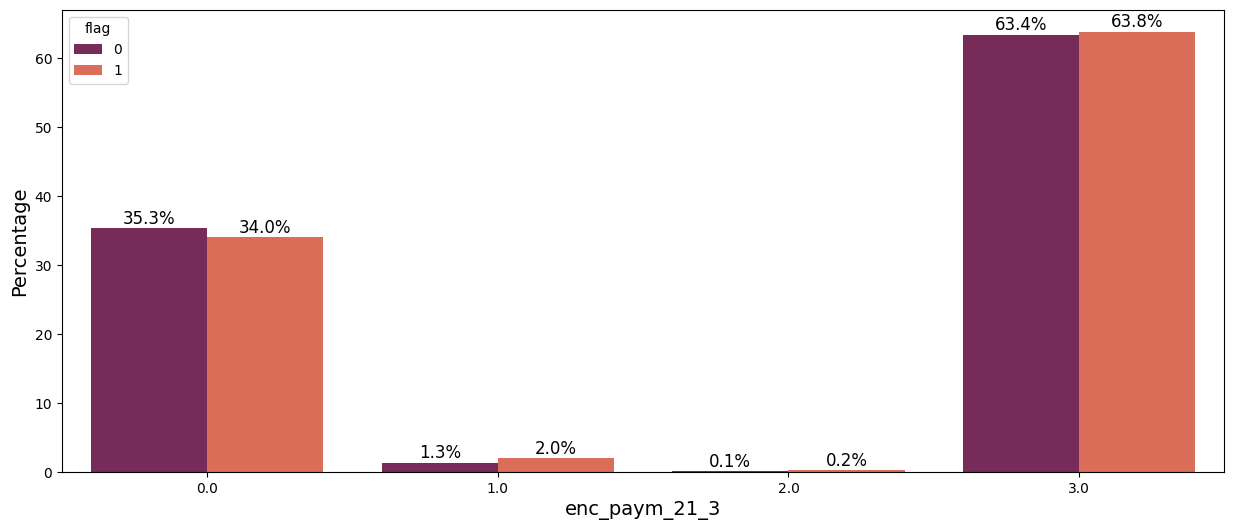

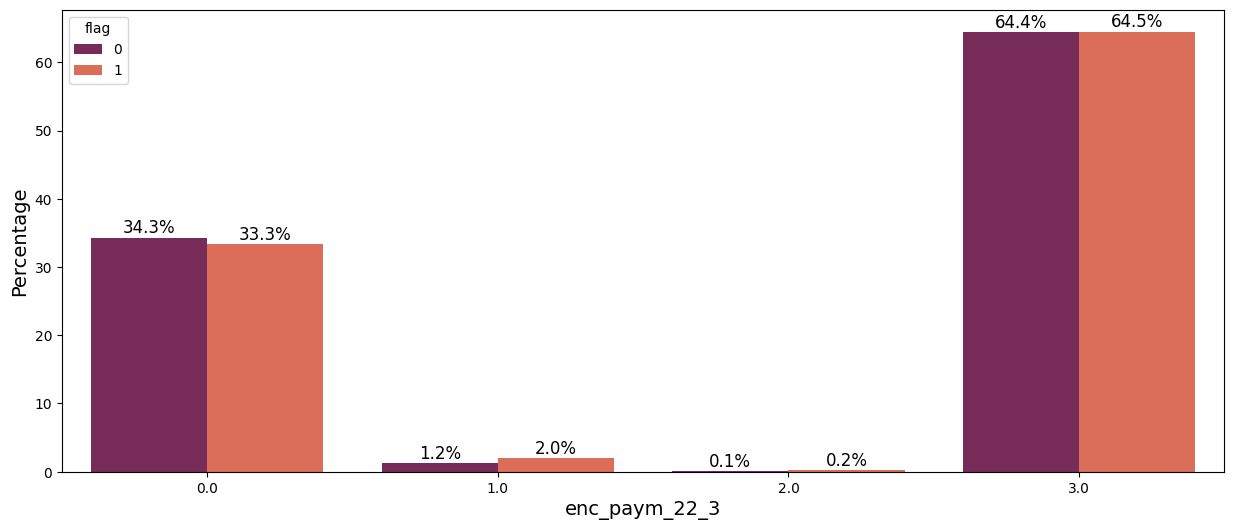

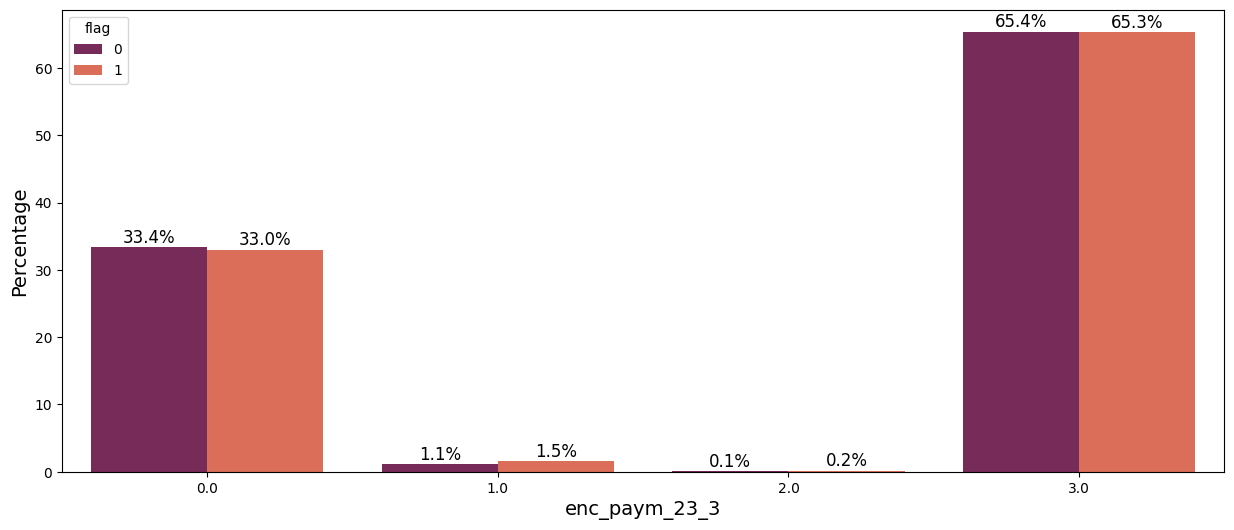

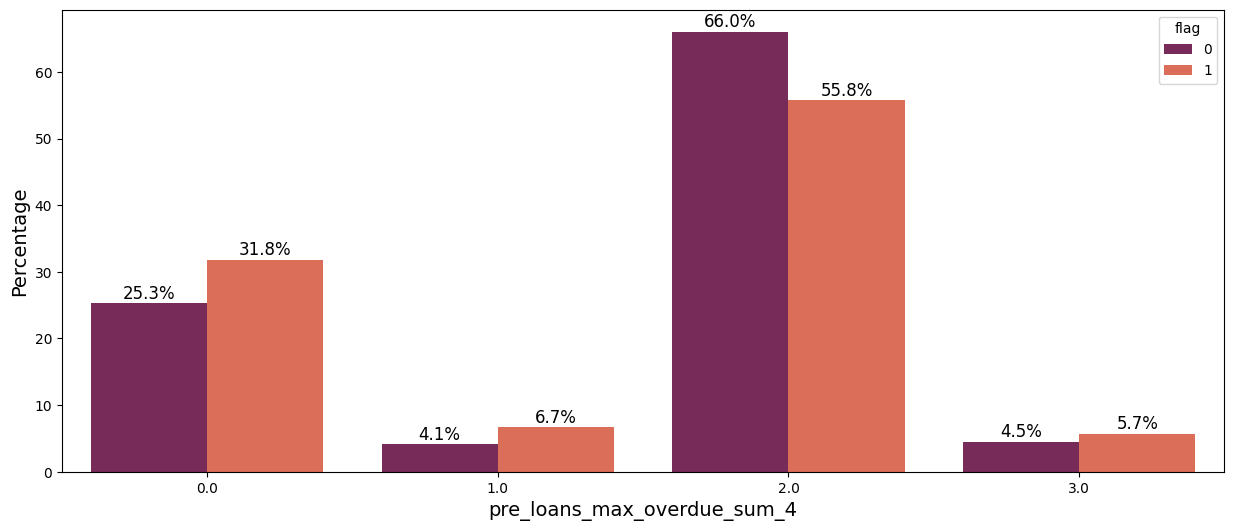

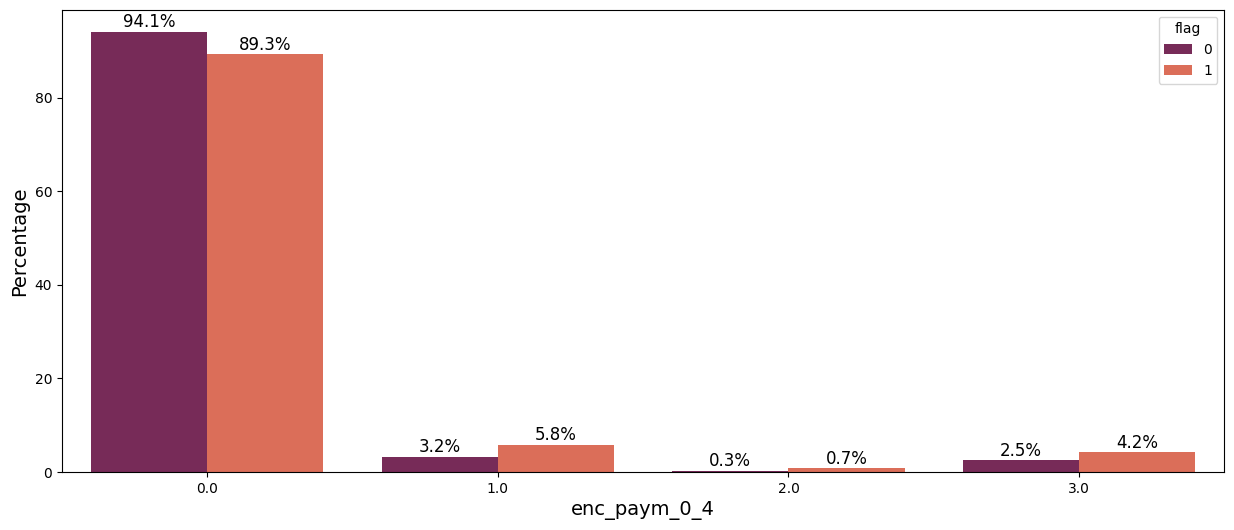

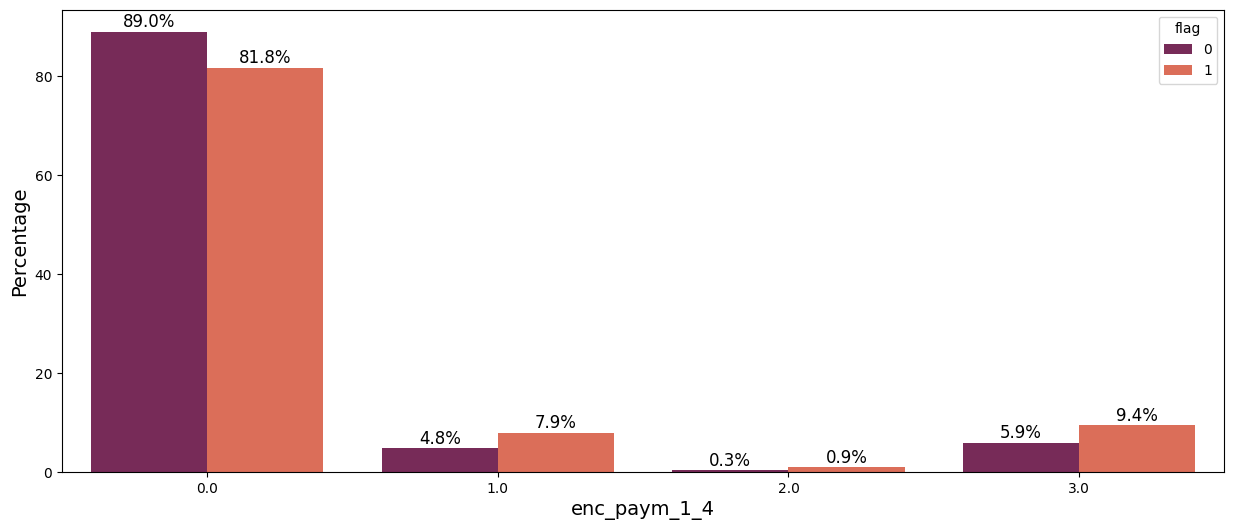

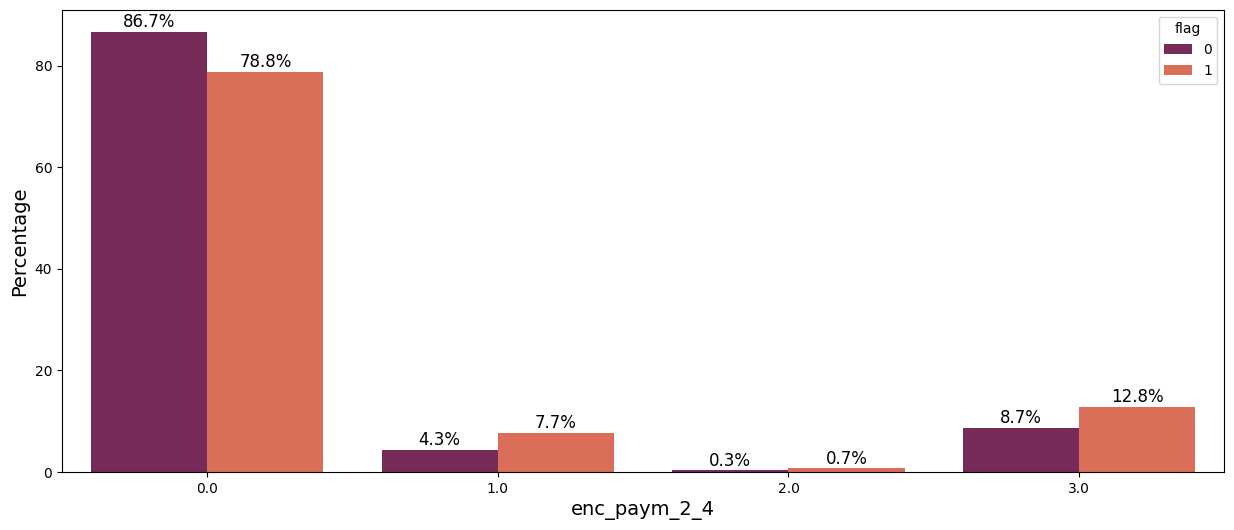

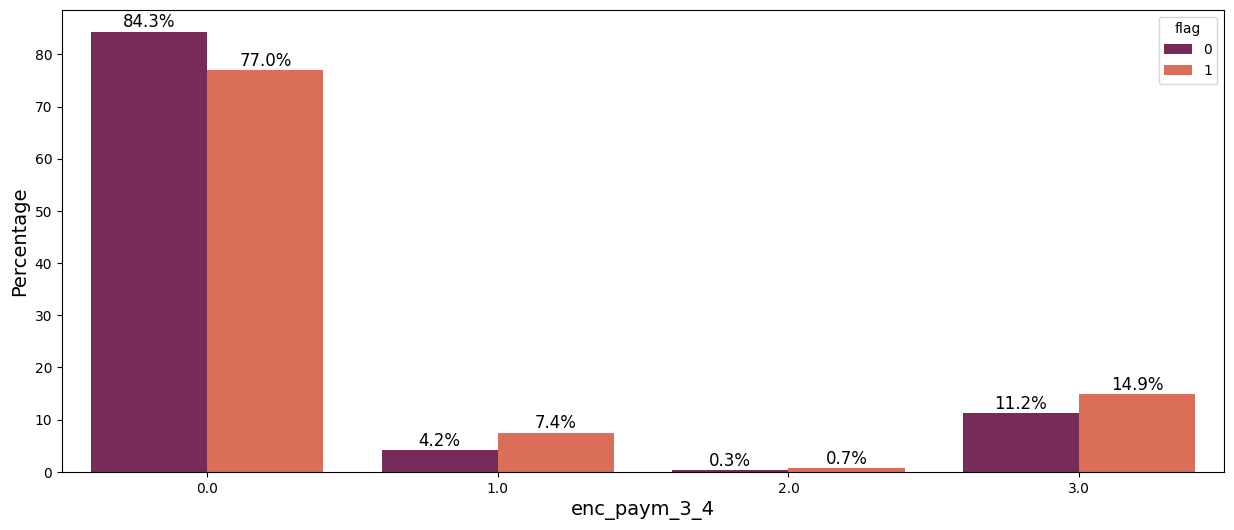

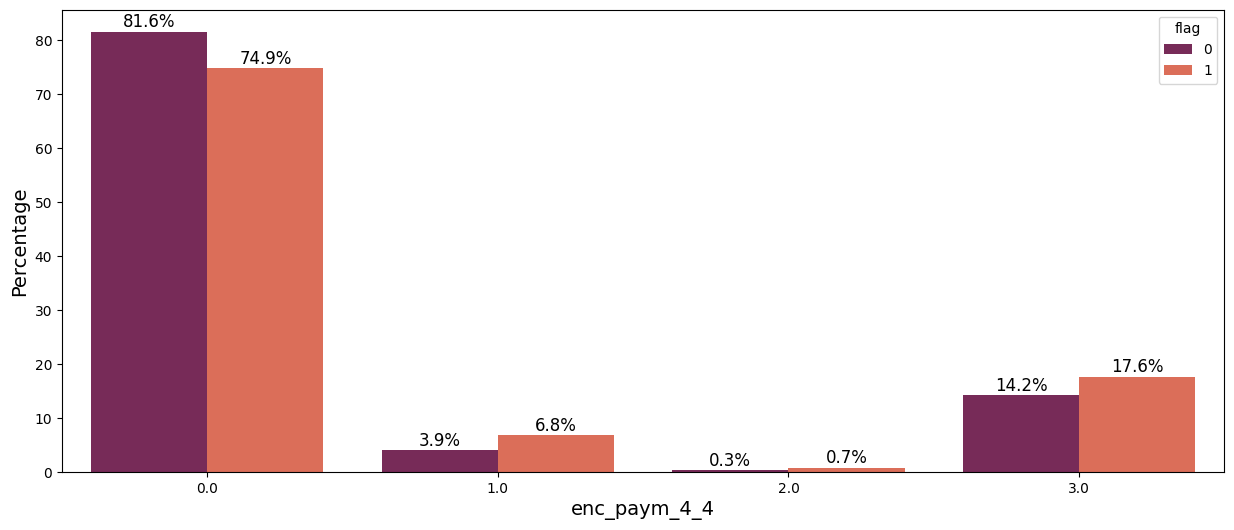

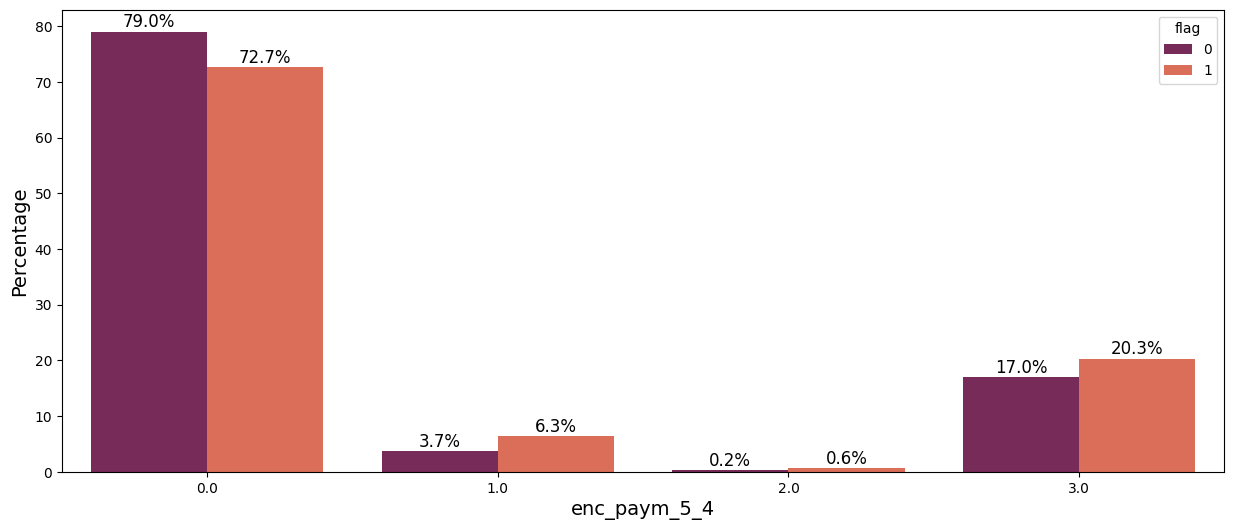

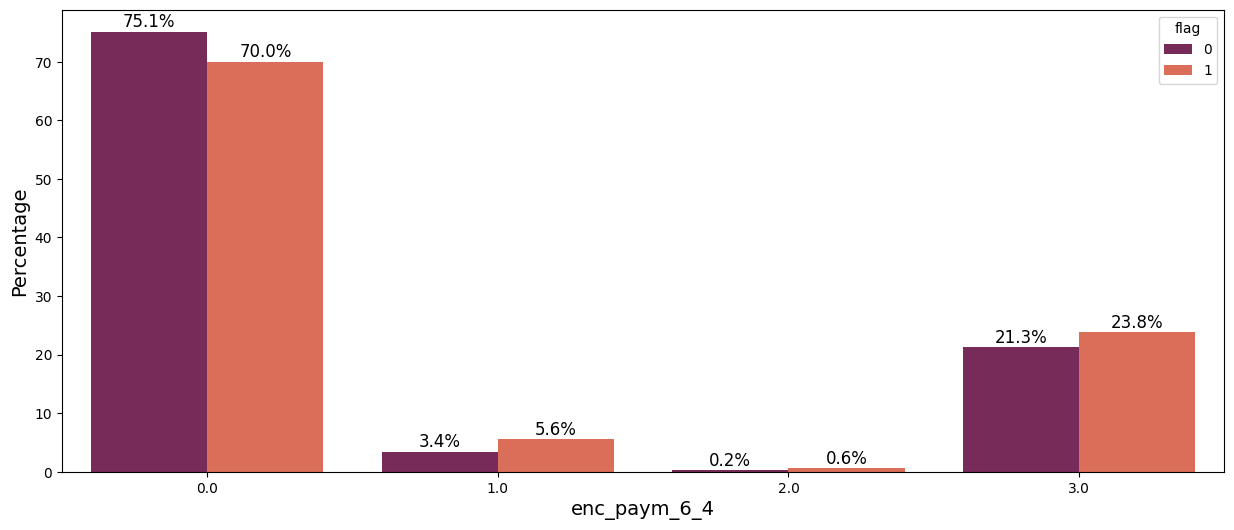

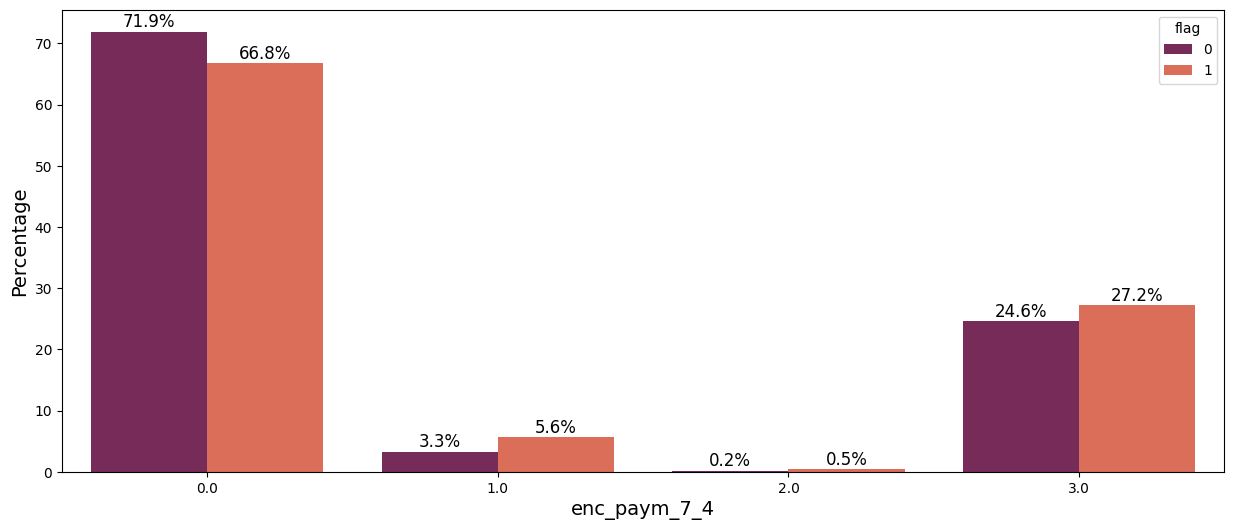

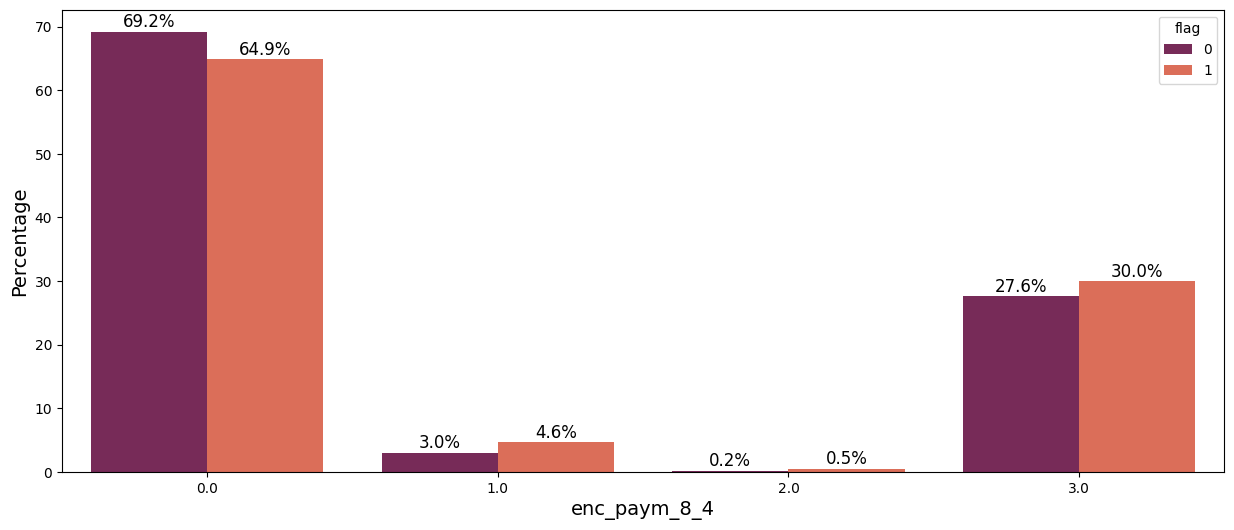

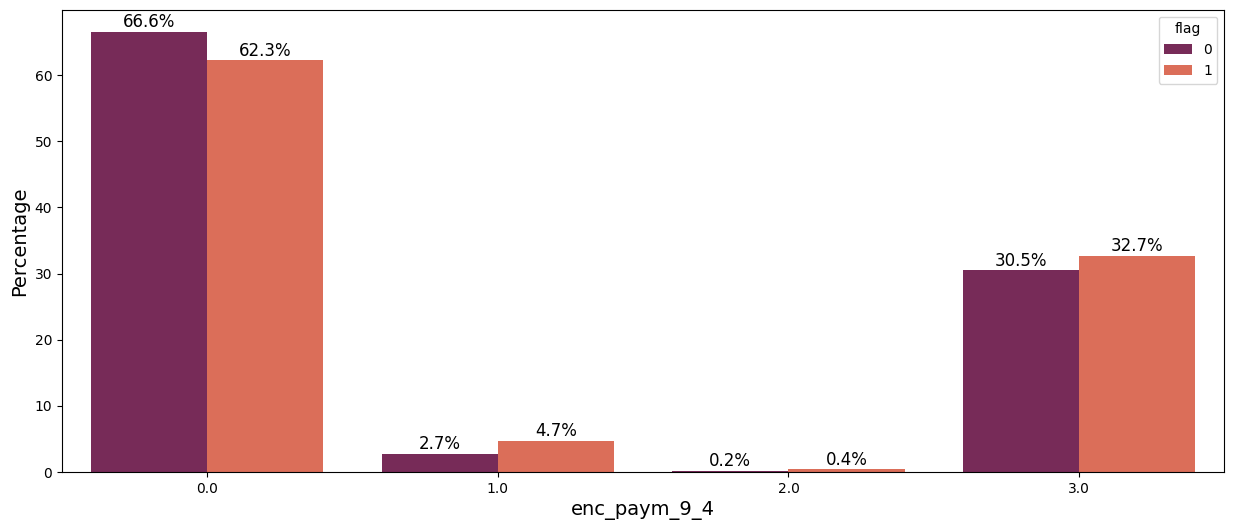

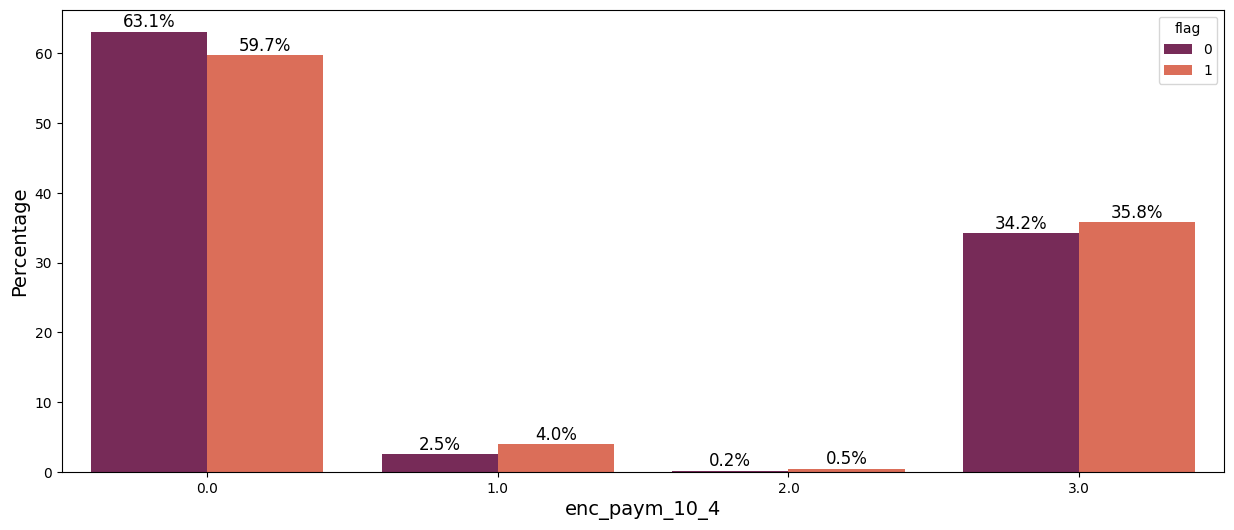

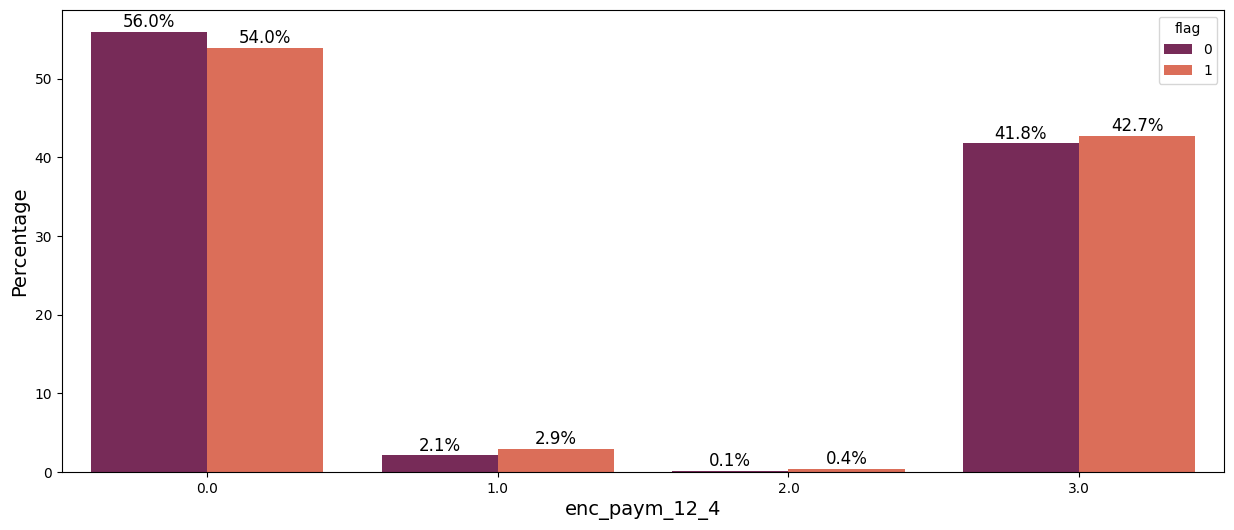

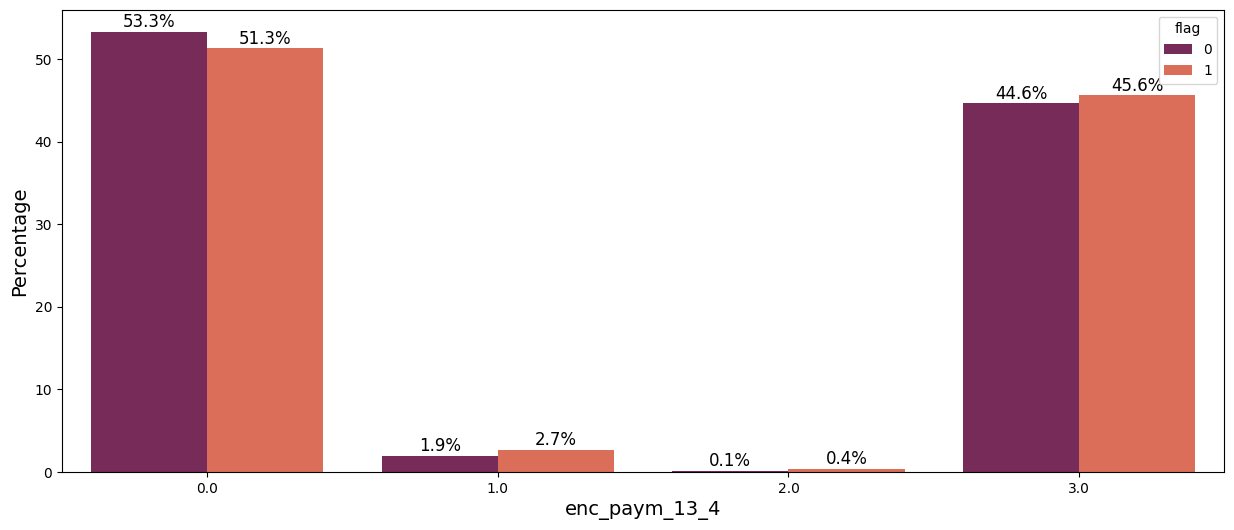

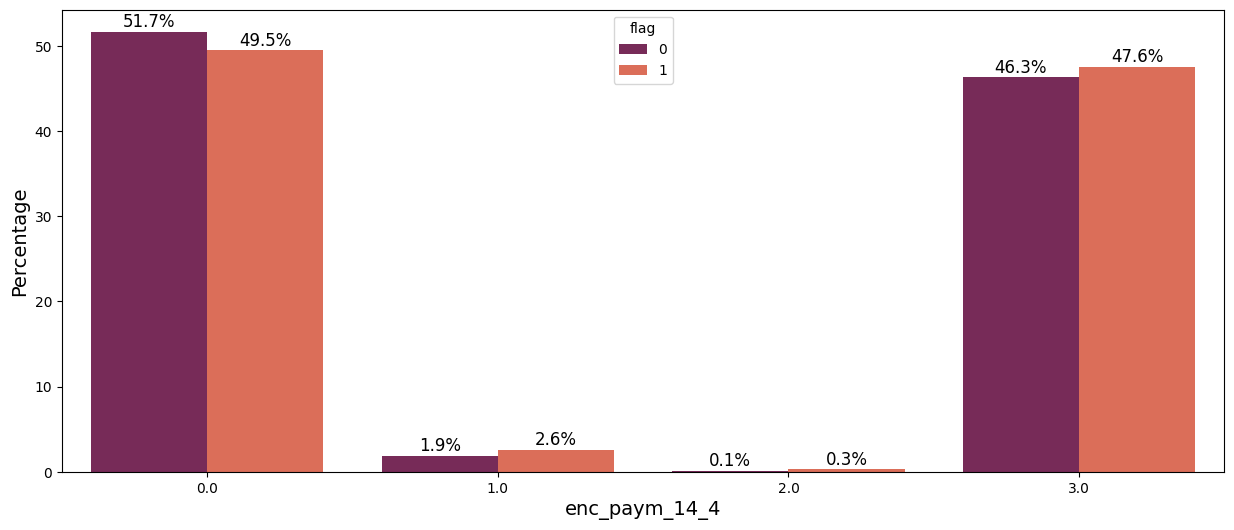

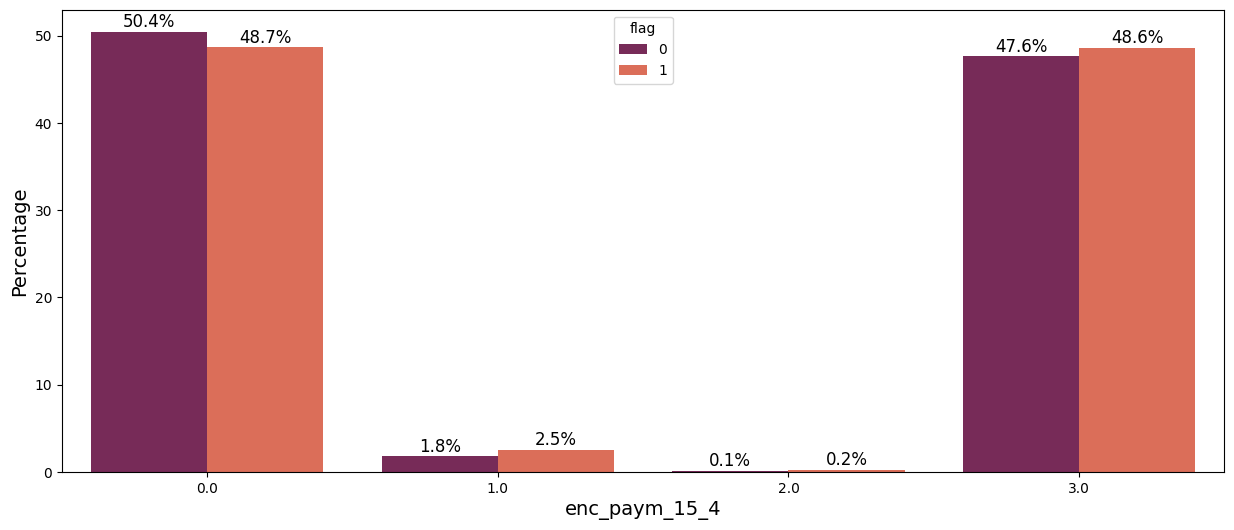

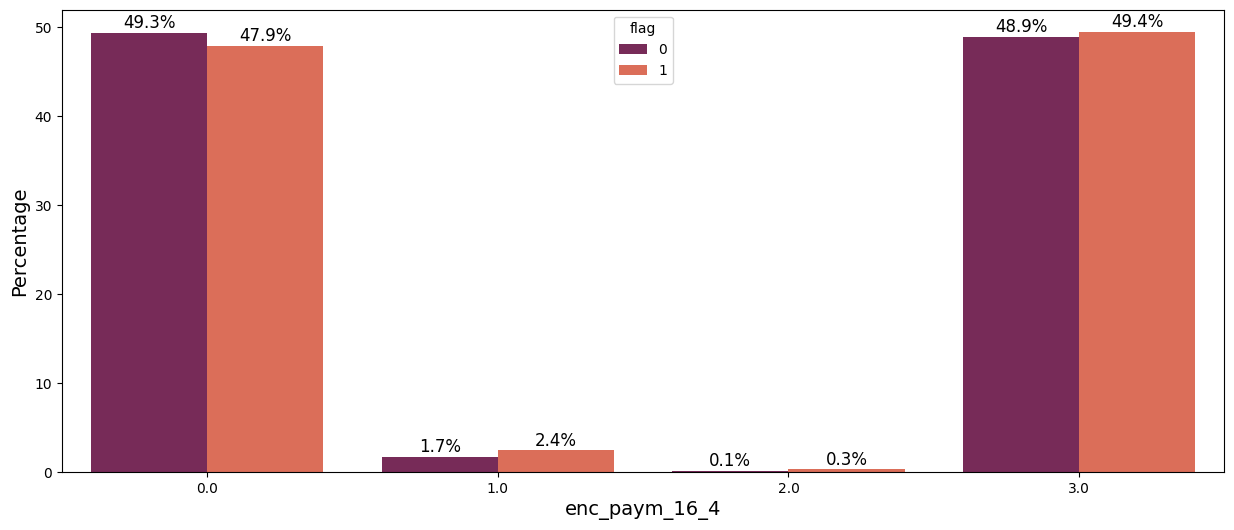

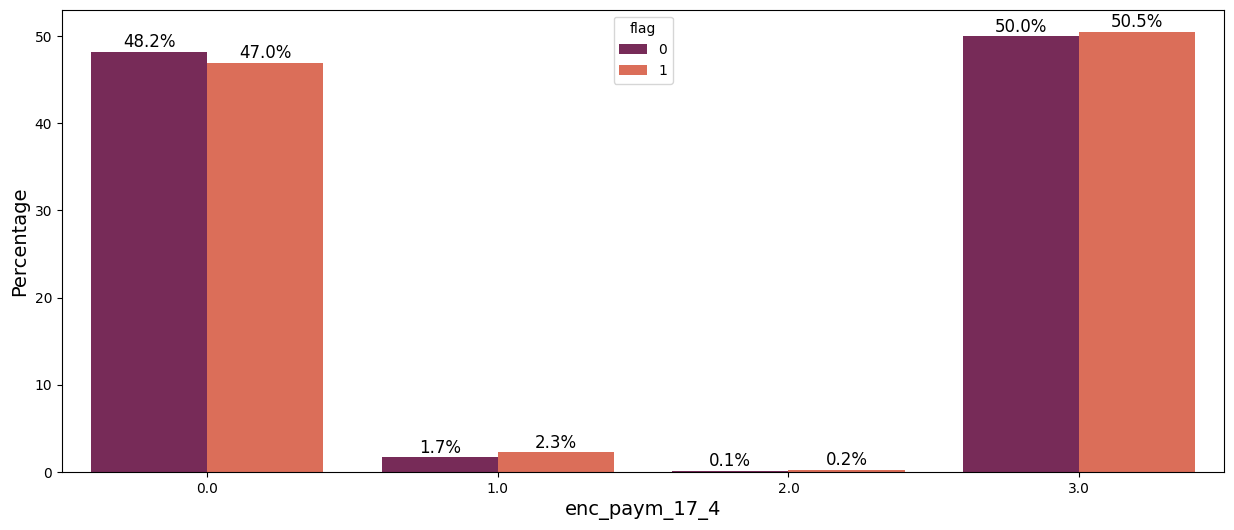

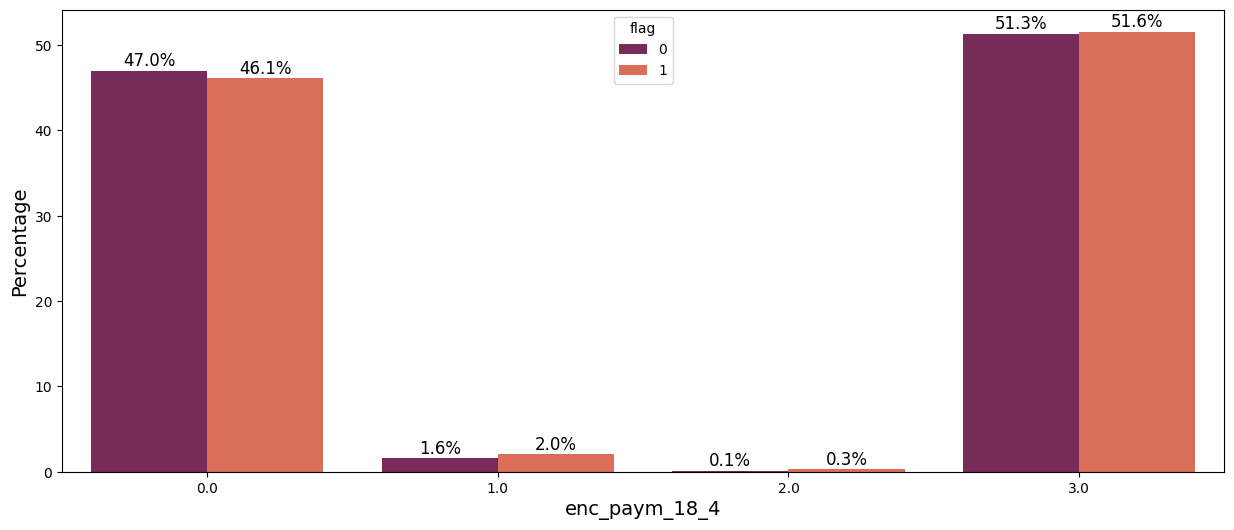

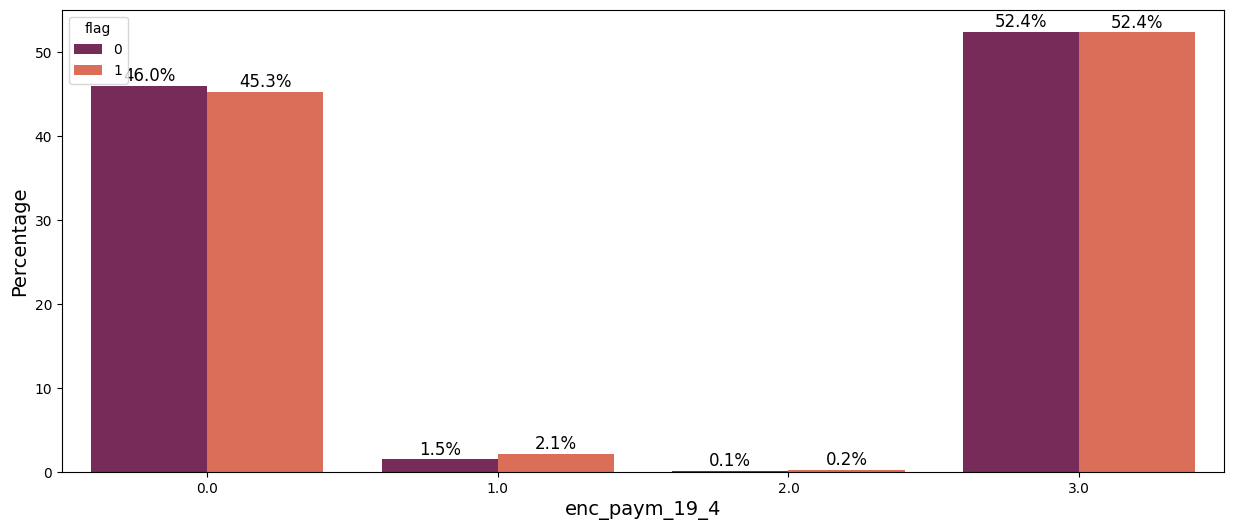

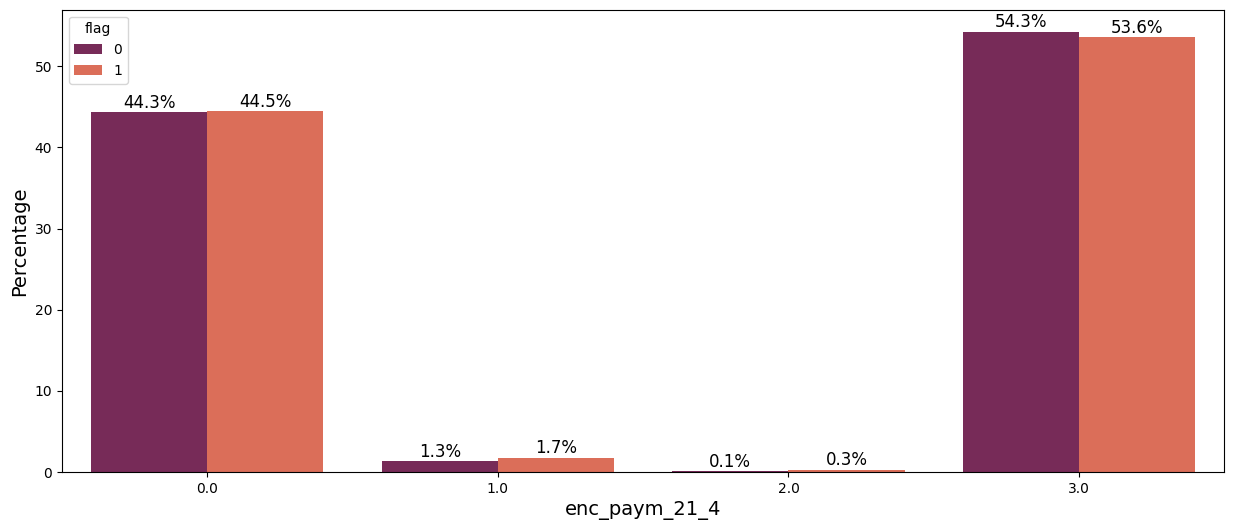

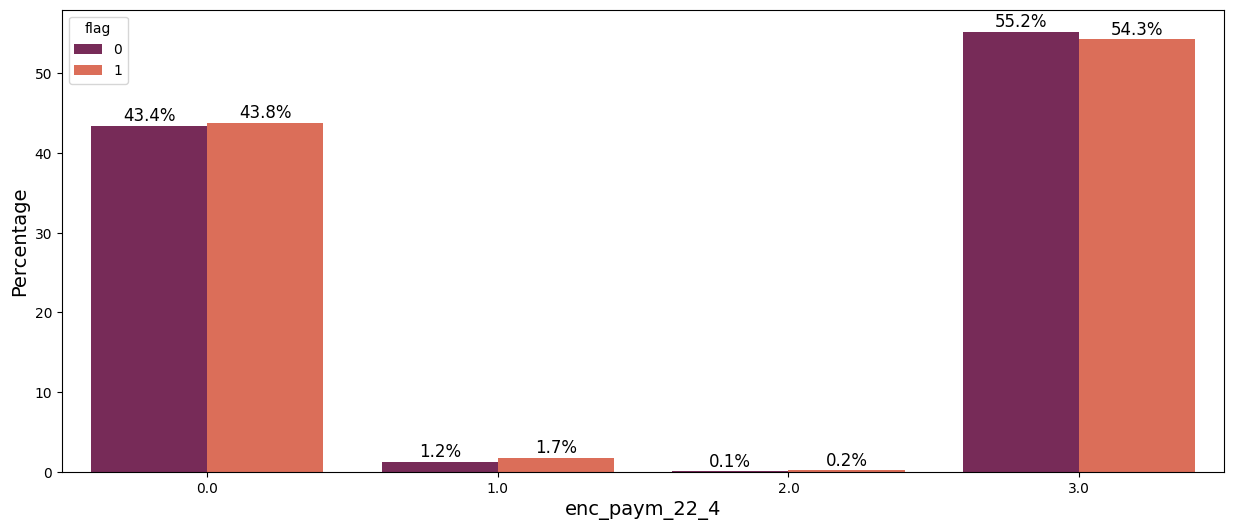

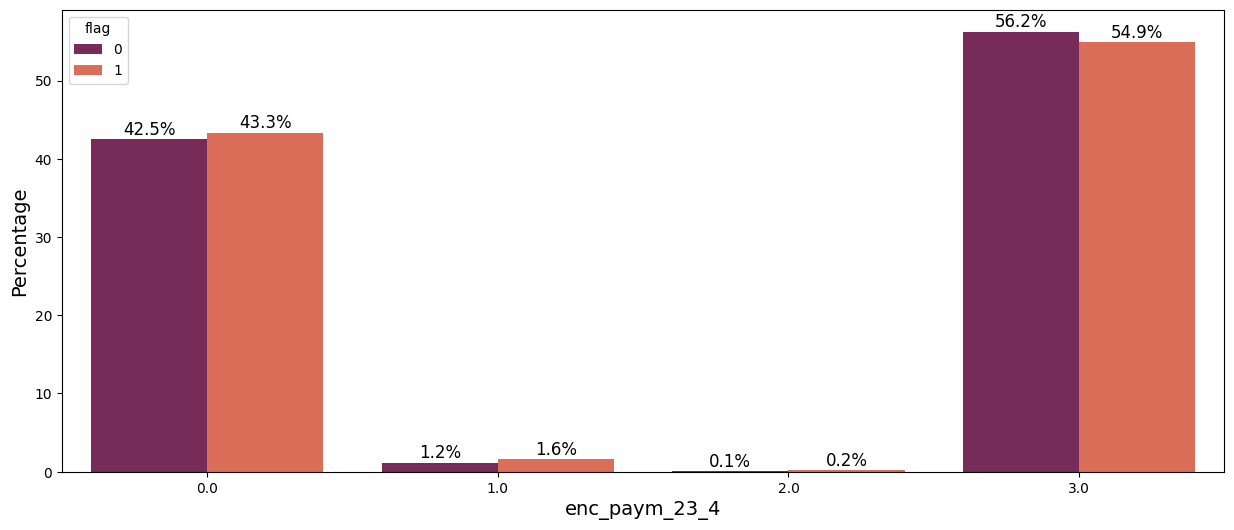

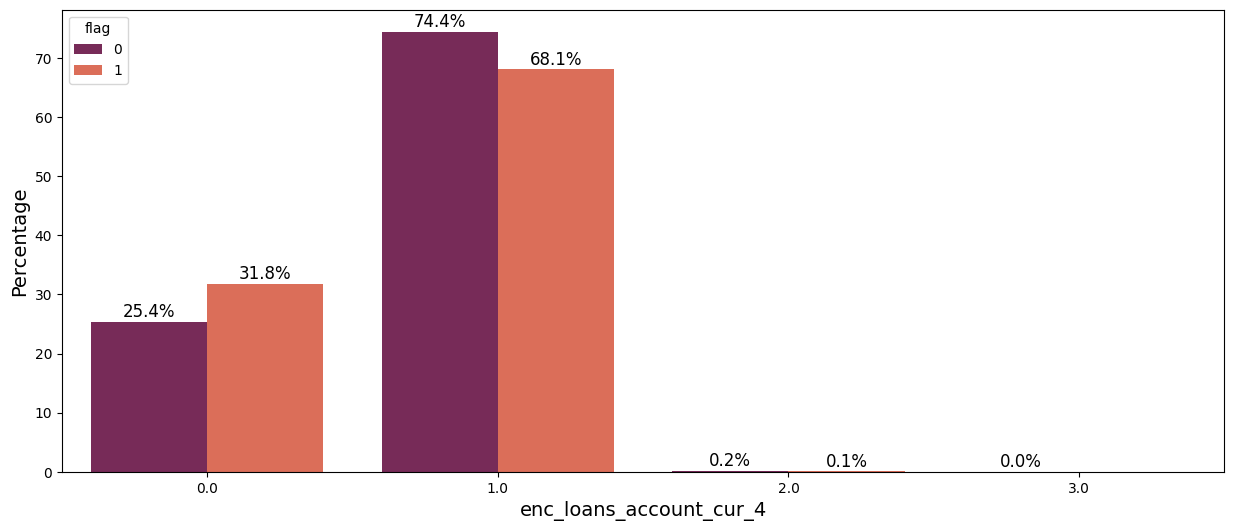

In [75]:
for col in df.nunique()[df.nunique() == 4].index:
    barplot_group(col, "flag")

In [26]:
df = df.drop(columns=["pre_loans3060",
                      "pre_loans90"
                     ])

In [27]:
df = df.drop(columns=["enc_paym_22",
                      "enc_paym_23",
                      "enc_paym_24",
                      "enc_paym_17_2",
                      "enc_paym_18_2",
                      "enc_paym_19_2",
                      "enc_paym_21_2",
                      "enc_paym_22_2",
                      "enc_paym_23_2",
                      "enc_paym_15_3",
                      "enc_paym_16_3",
                      "enc_paym_17_3",
                      "enc_paym_18_3",
                      "enc_paym_19_3",
                      "enc_paym_21_3",
                      "enc_paym_22_3",
                      "enc_paym_23_3",
                      "enc_paym_10_4",
                      "enc_paym_12_4",
                      "enc_paym_13_4",
                      "enc_paym_14_4",
                      "enc_paym_15_4",
                      "enc_paym_16_4",
                      "enc_paym_17_4",
                      "enc_paym_18_4",
                      "enc_paym_19_4",
                      "enc_paym_21_4",
                      "enc_paym_22_4",
                      "enc_paym_23_4"
                     ])

In [30]:
df.nunique()[df.nunique() == 5].index

Index(['pre_loans_outstanding', 'pre_loans3060_2', 'enc_paym_11_2',
       'enc_paym_20_2', 'enc_paym_24_2', 'pre_loans90_3', 'enc_paym_11_3',
       'enc_paym_20_3', 'enc_paym_24_3', 'pre_loans90_4', 'enc_paym_11_4',
       'enc_paym_20_4', 'enc_paym_24_4'],
      dtype='object')

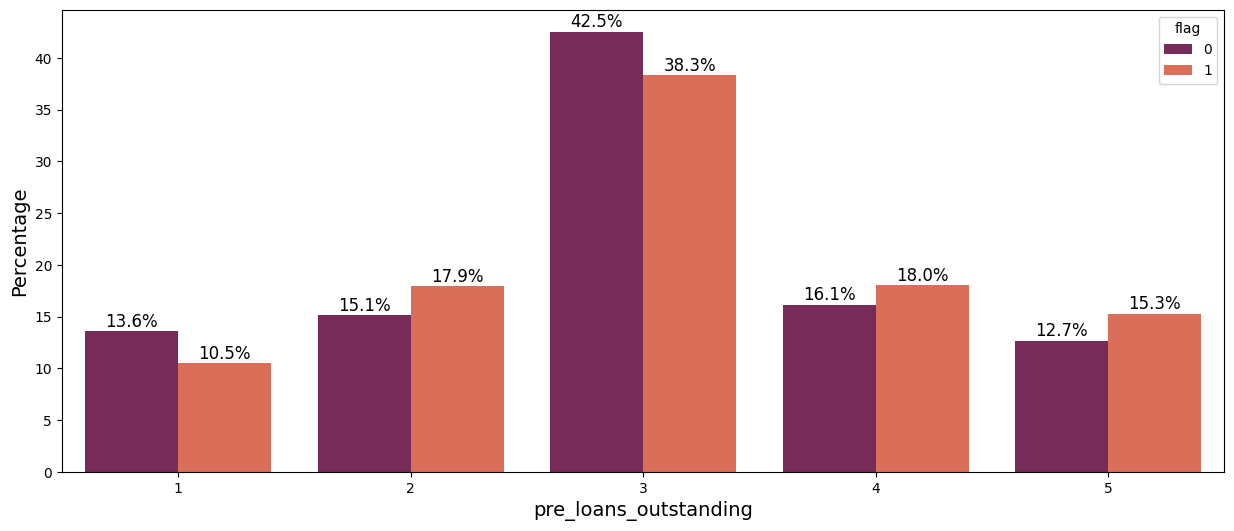

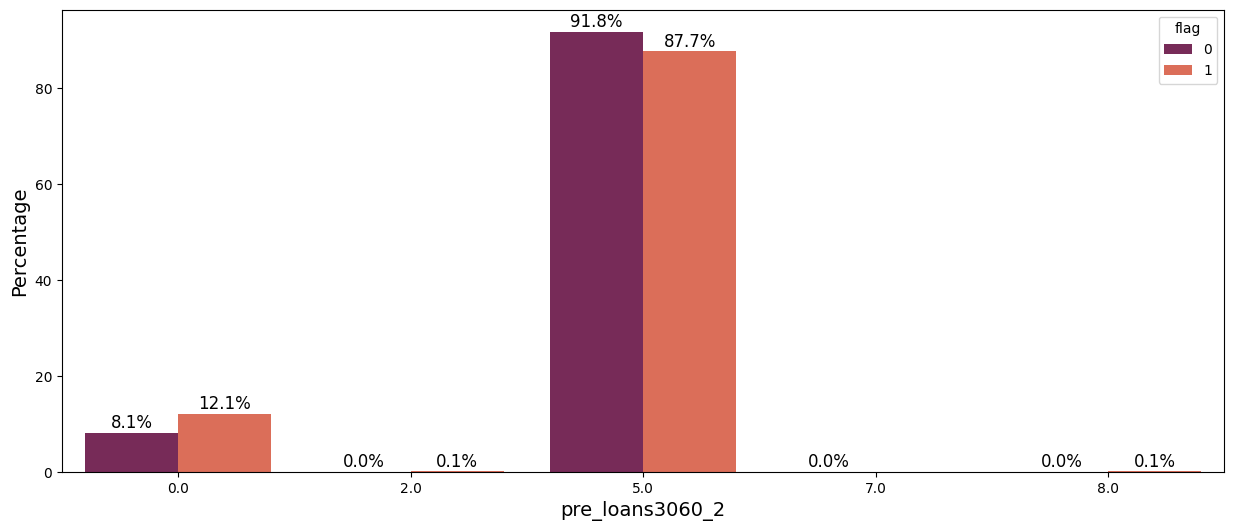

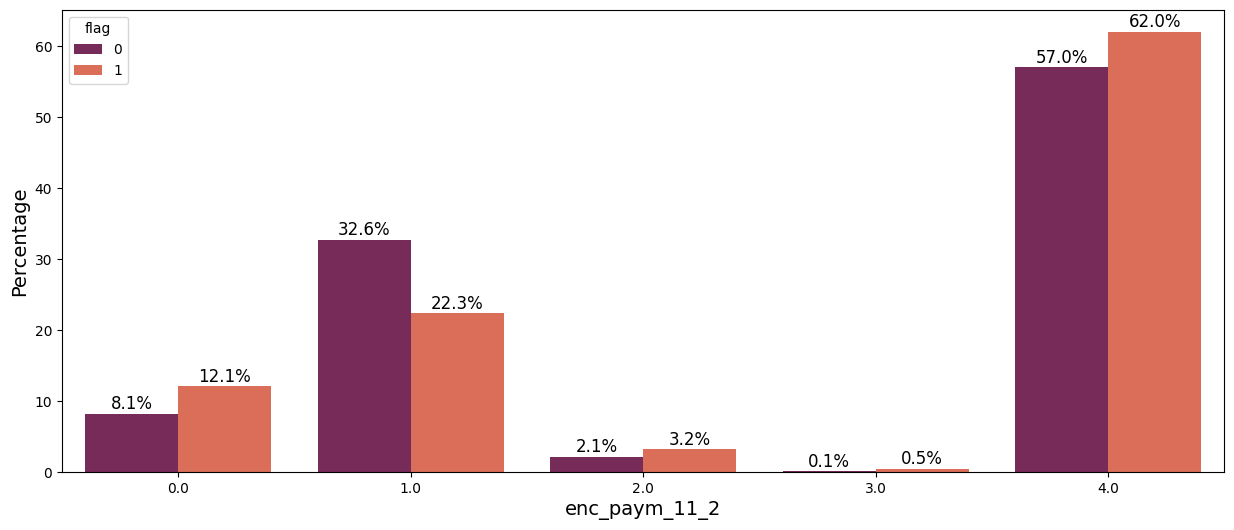

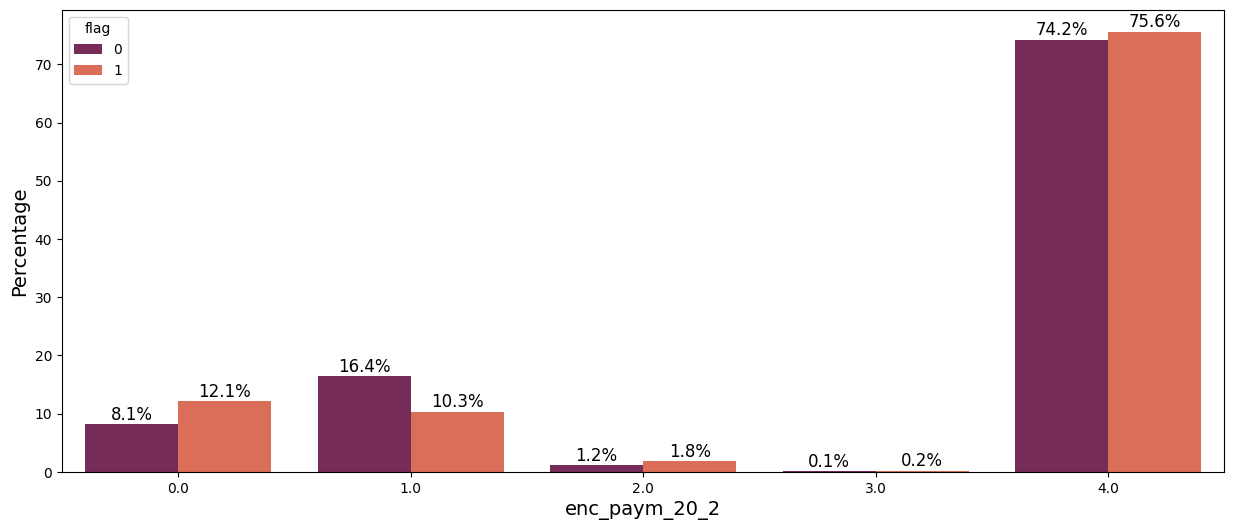

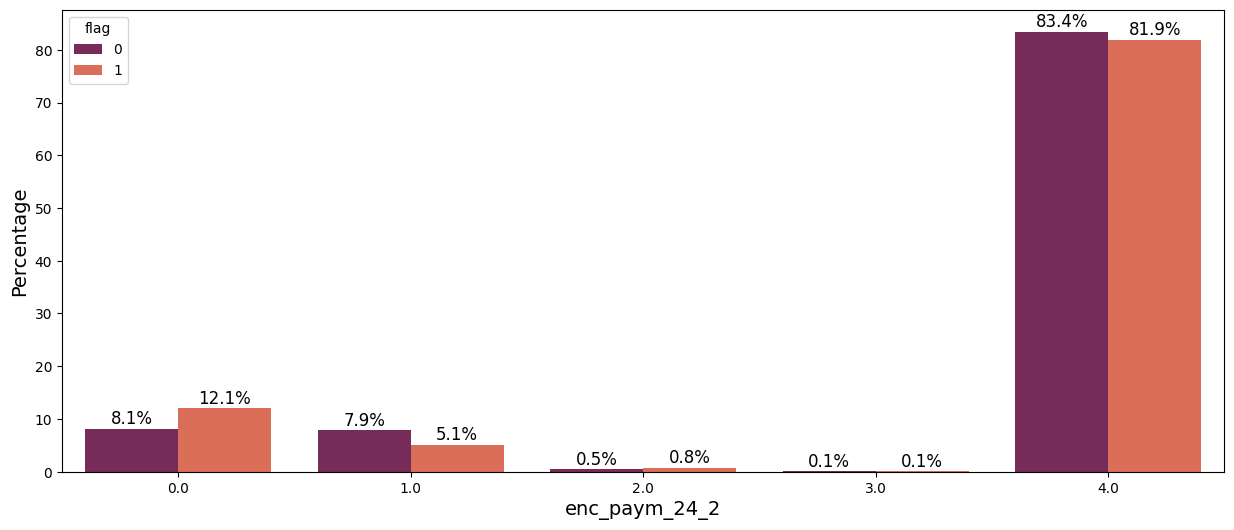

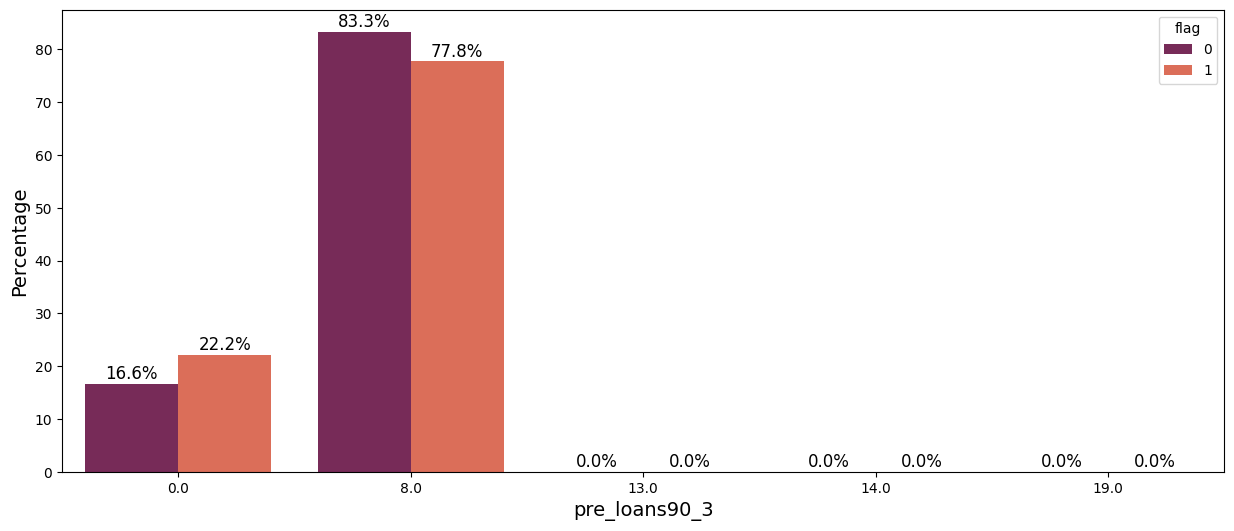

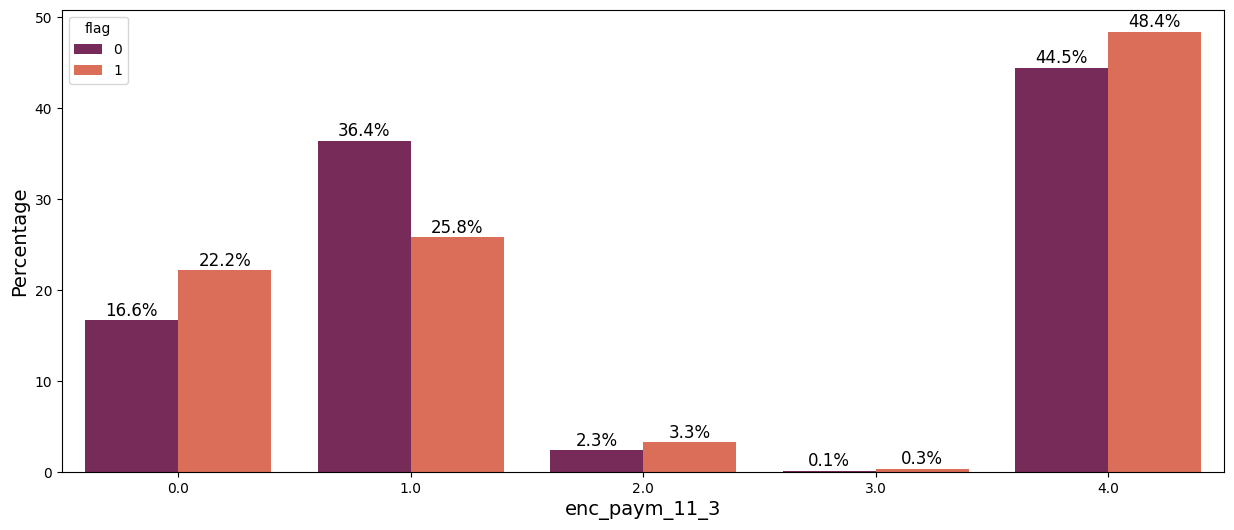

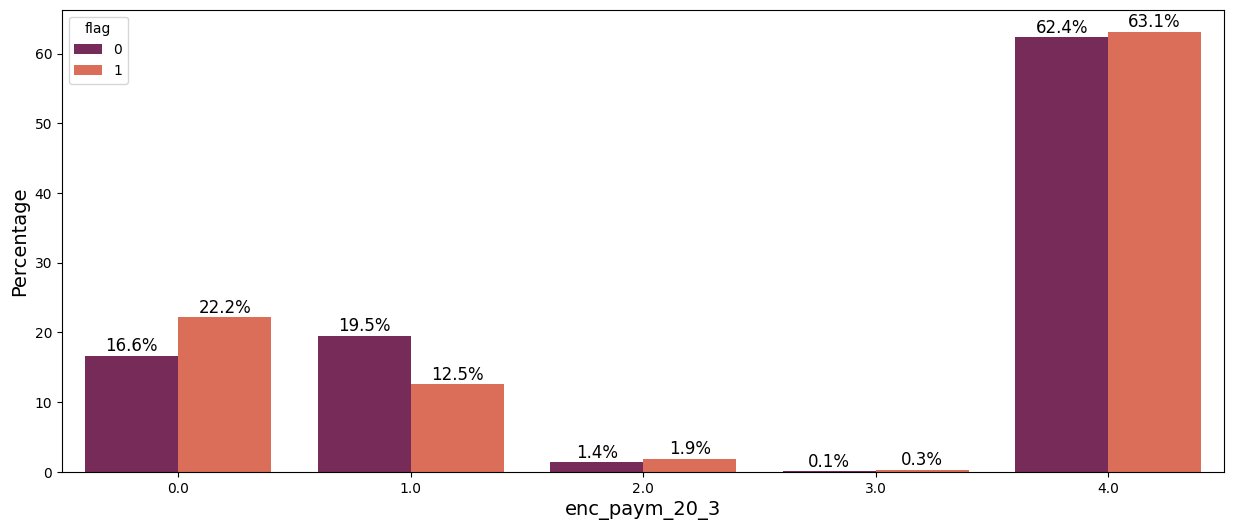

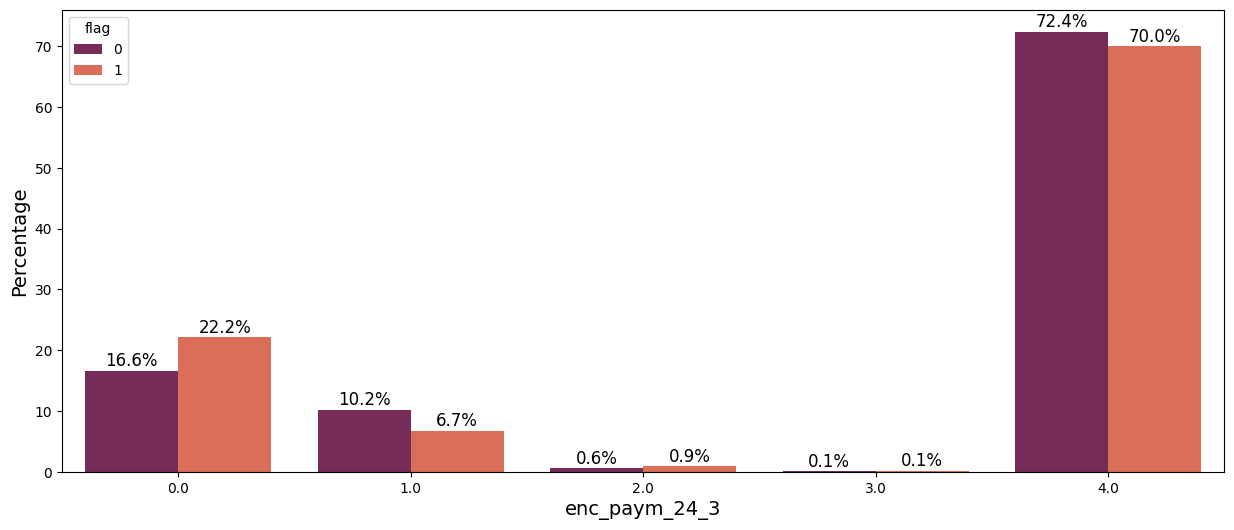

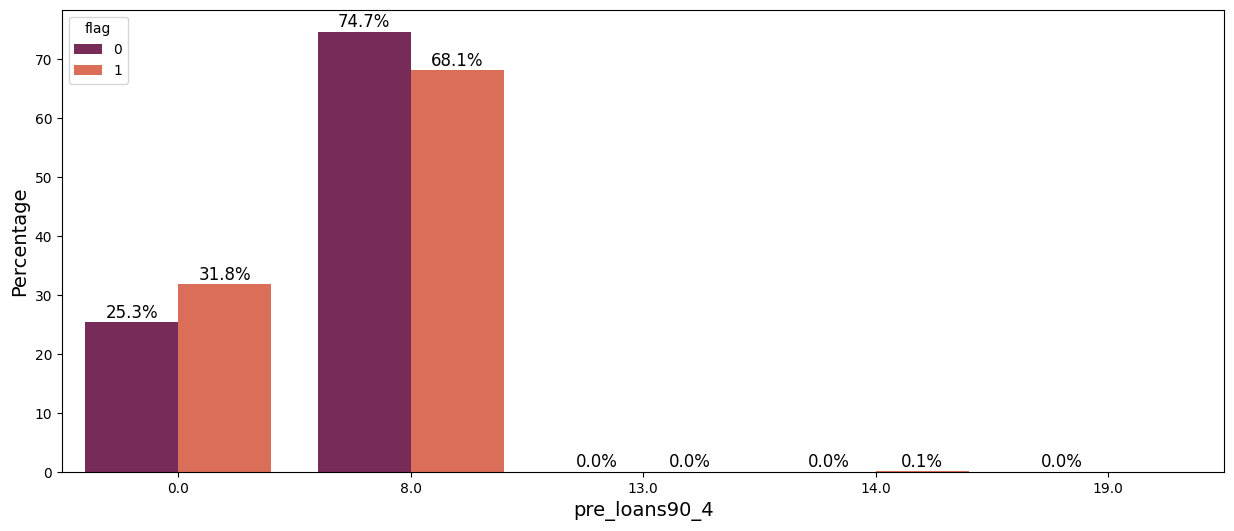

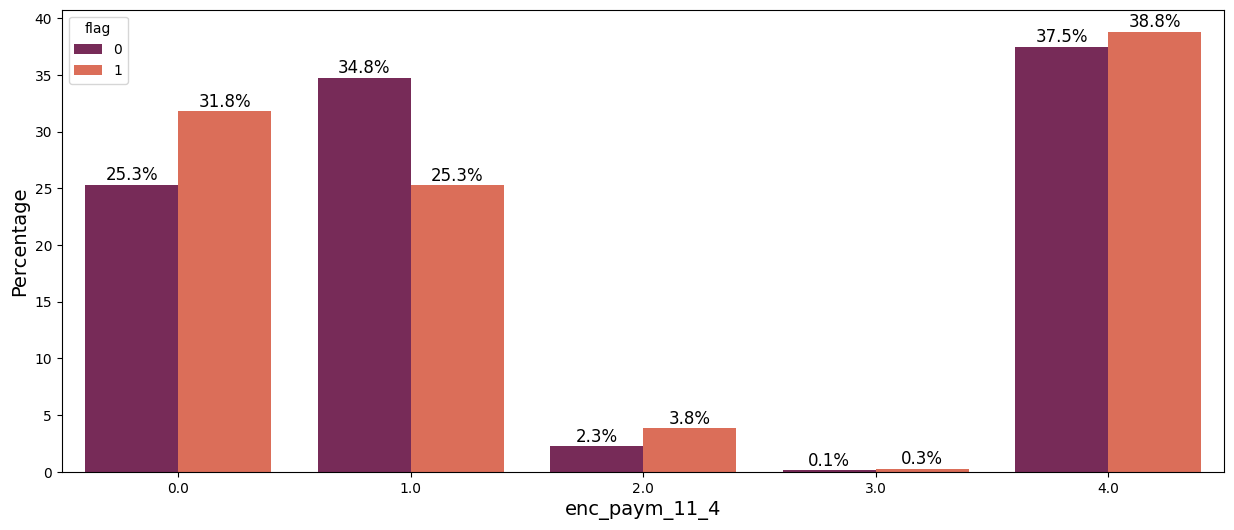

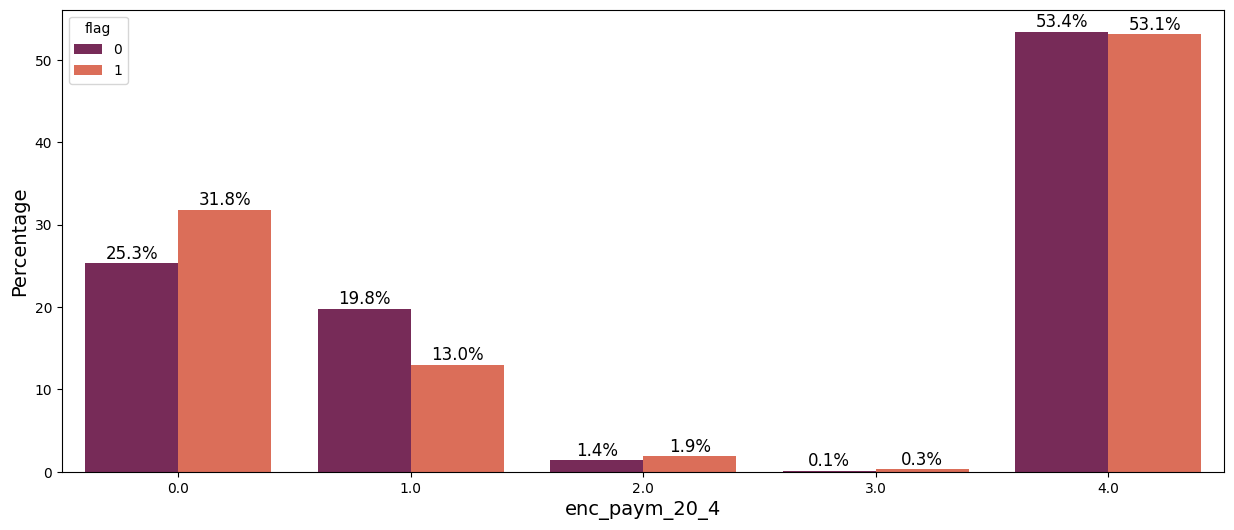

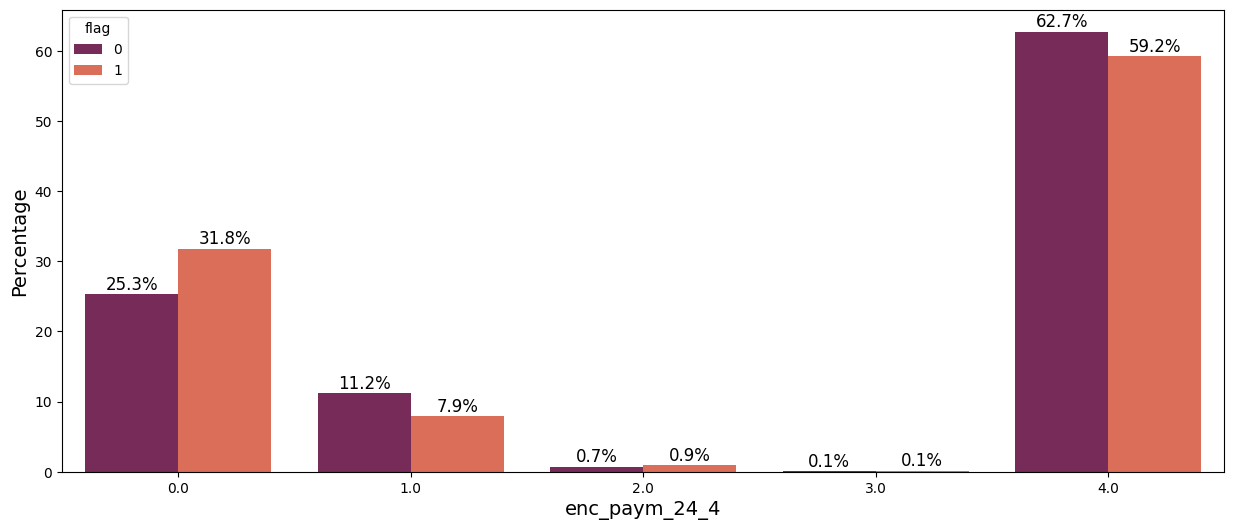

In [88]:
for col in df.nunique()[df.nunique() == 5].index:
    barplot_group(col, "flag")

In [31]:
df.nunique()[df.nunique() == 6].index

Index(['pre_loans5', 'enc_loans_credit_type', 'pre_loans_outstanding_2',
       'enc_loans_credit_type_2', 'pre_loans_outstanding_3', 'pre_loans3060_3',
       'enc_loans_credit_type_3', 'pre_loans_outstanding_4', 'pre_loans3060_4',
       'enc_loans_credit_type_4'],
      dtype='object')

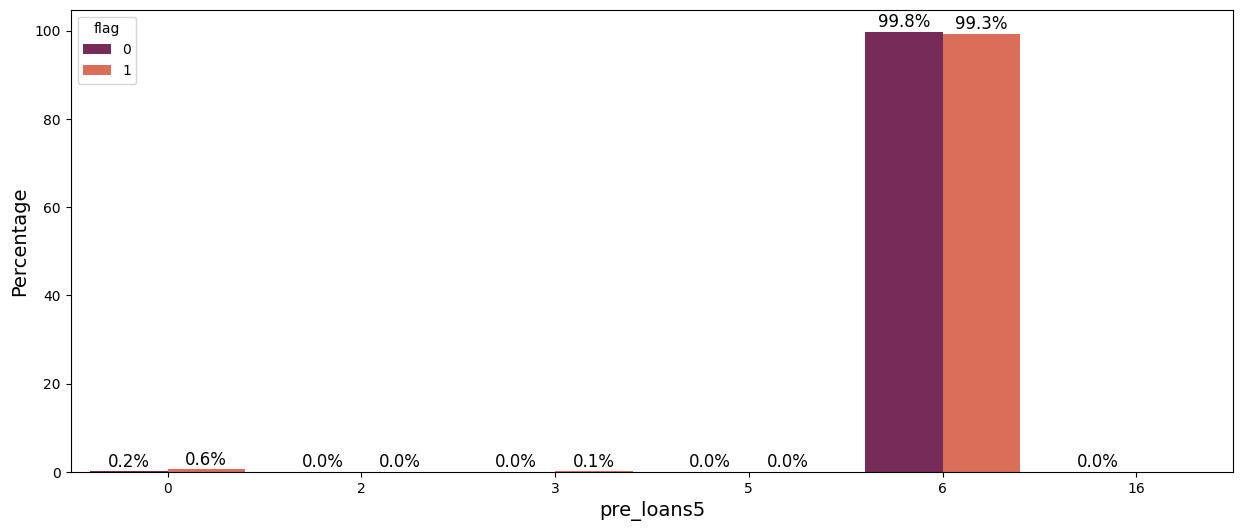

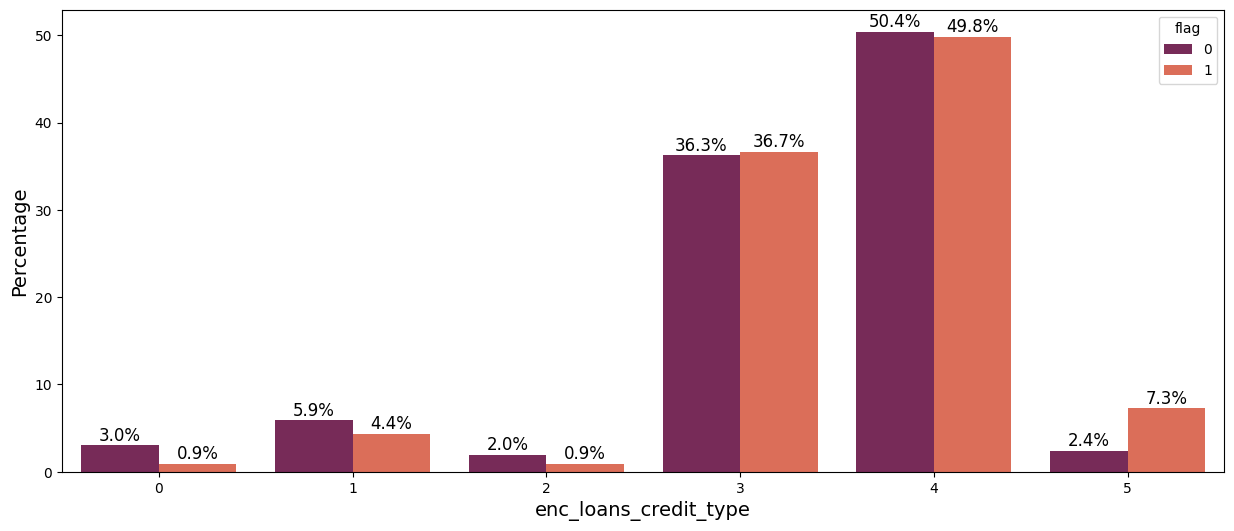

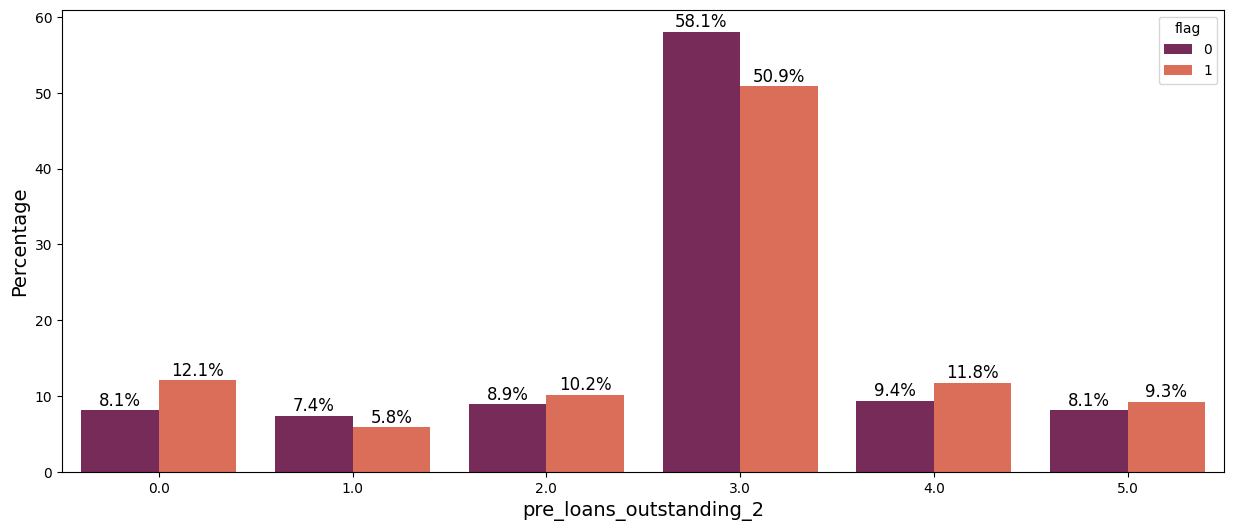

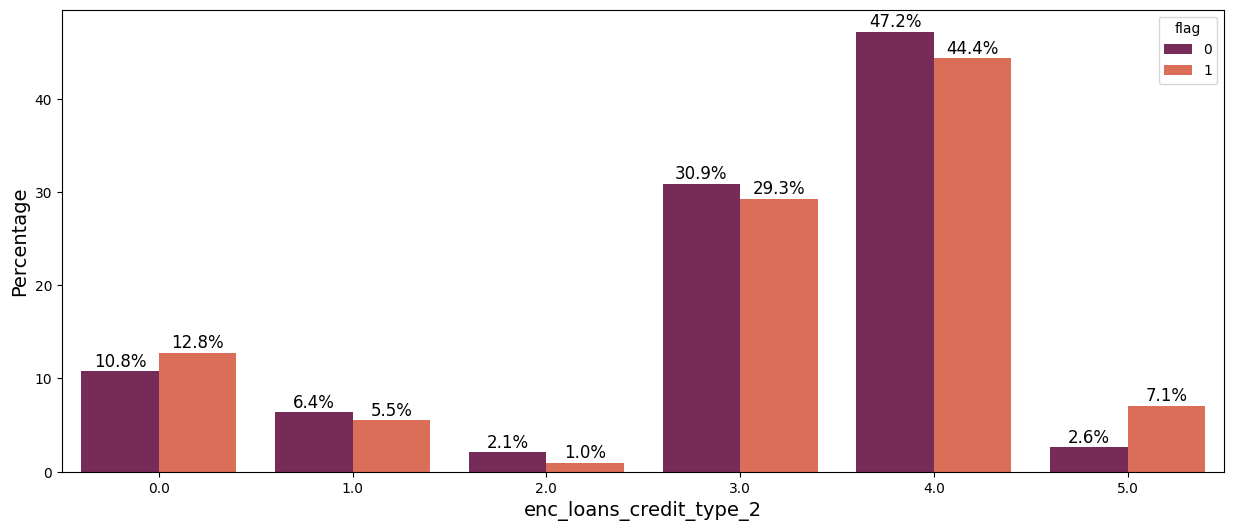

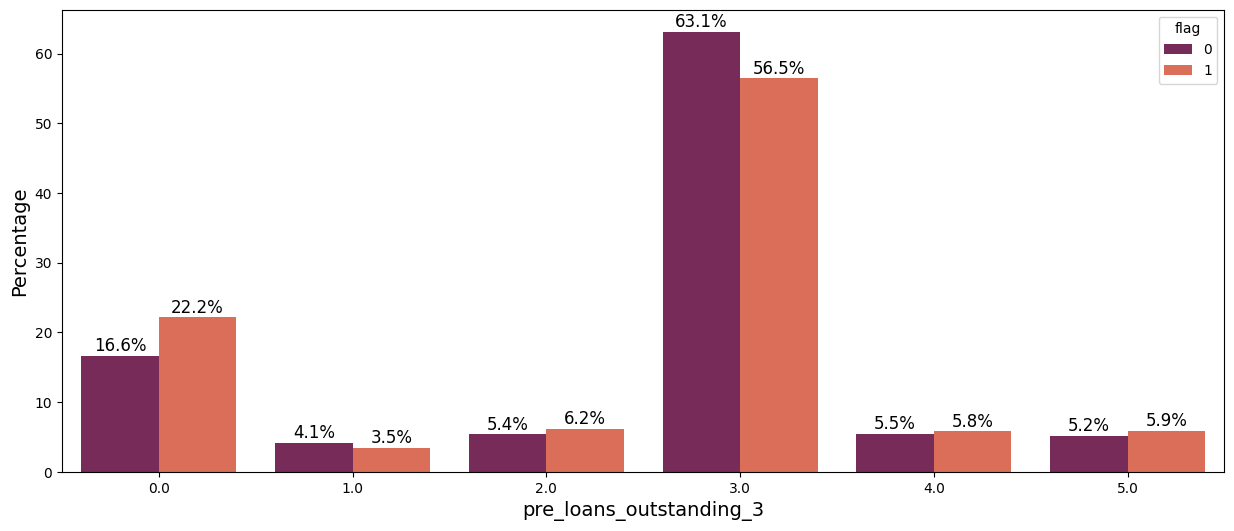

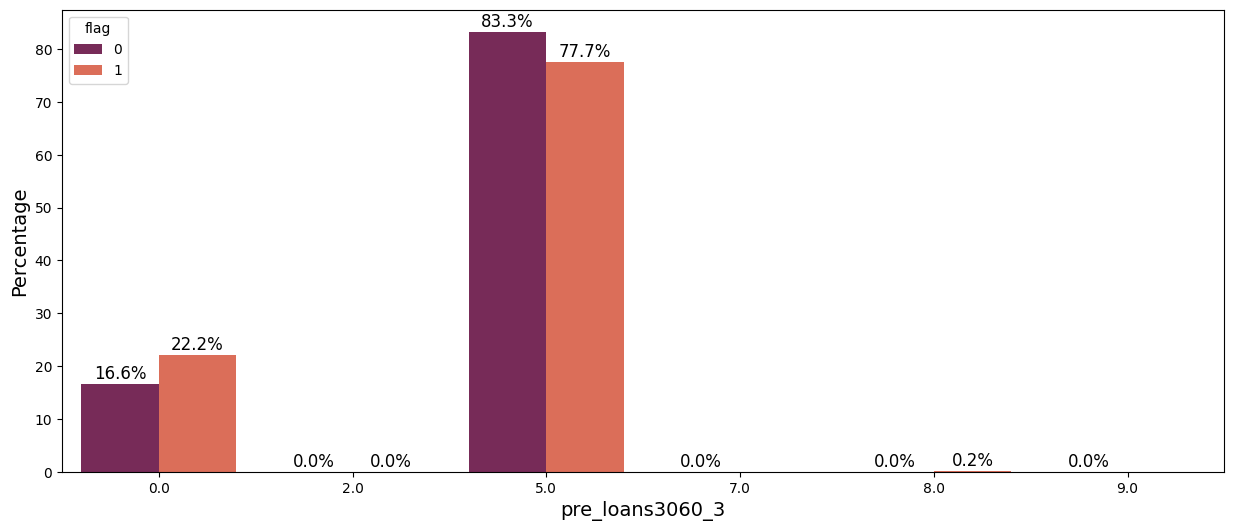

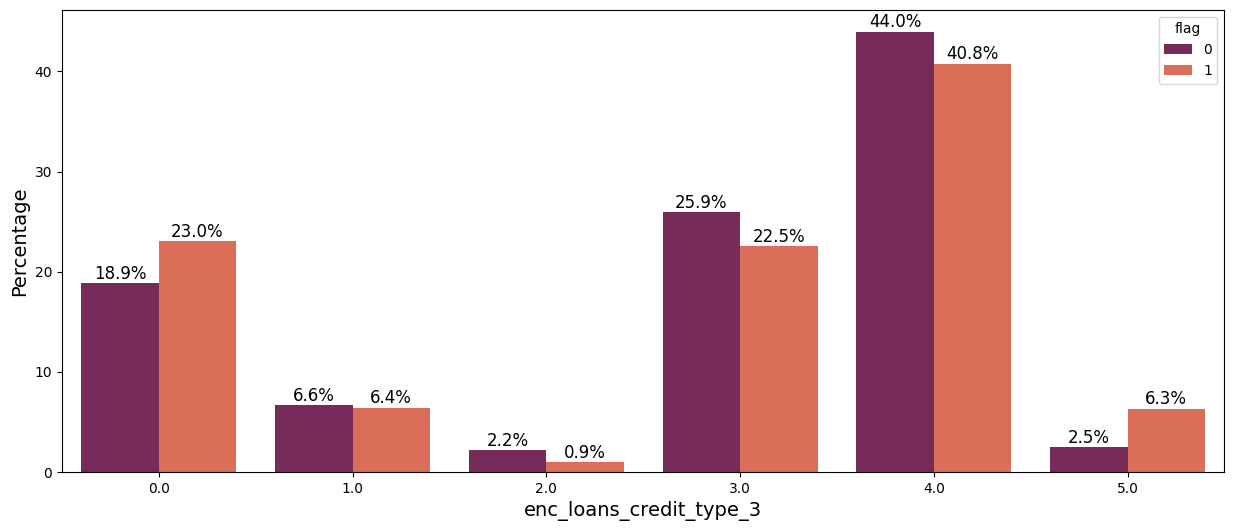

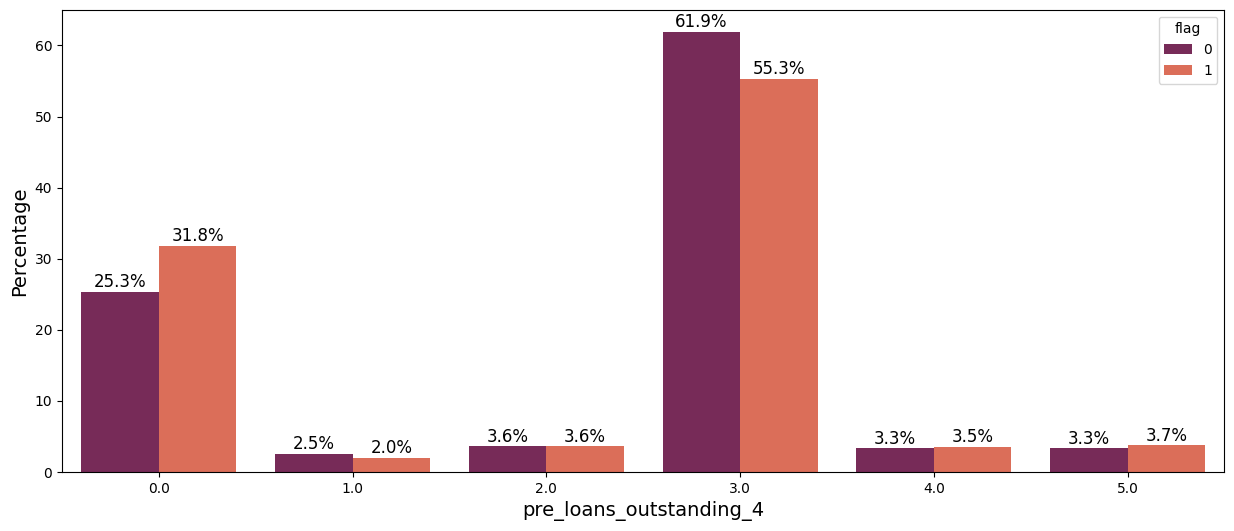

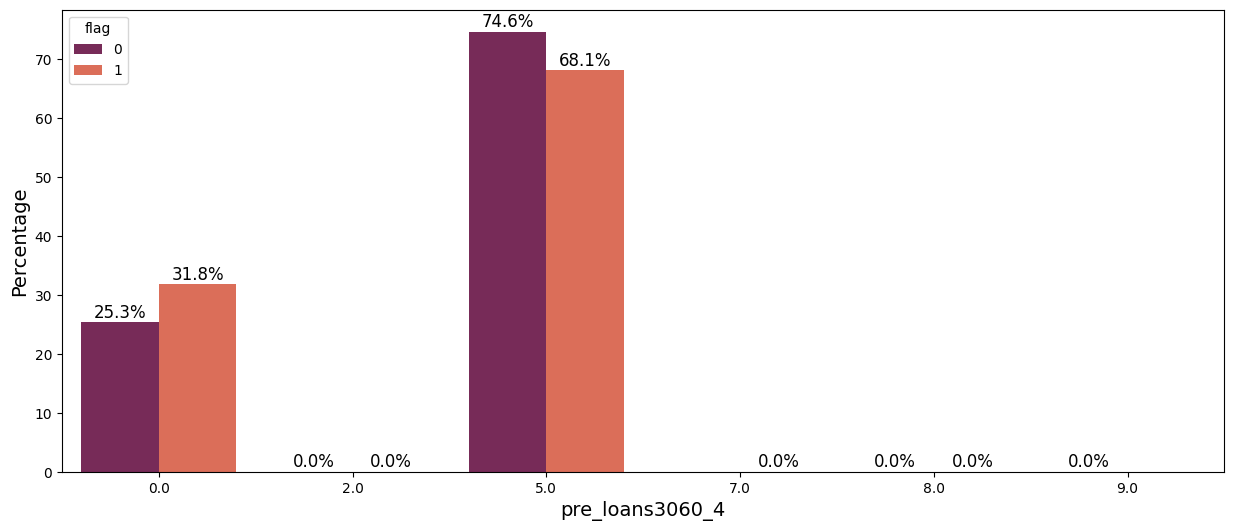

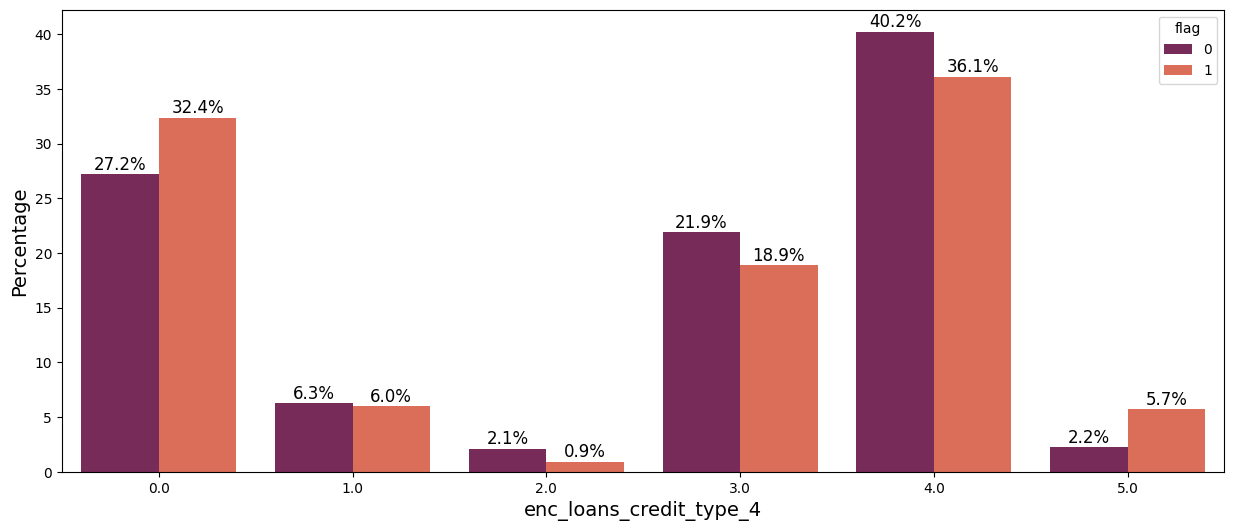

In [90]:
for col in df.nunique()[df.nunique() == 6].index:
    barplot_group(col, "flag")

In [31]:
df = df.drop(columns=["pre_loans5"])

In [92]:
for col in df.columns:
    print(df[col].value_counts())

3     21776
2     21377
4     21152
1     20672
5     19778
6     18970
7     17377
8     15366
9     13741
10    12101
11    10541
12     8959
13     7718
14     6419
15     5759
16     5083
17     4356
18     3824
19     3097
20     2625
21     2106
22     1708
23     1368
24     1025
25      812
26      594
27      442
28      344
29      242
30      179
31      131
32      110
33       86
34       65
35       27
37       22
36       21
38        7
40        6
43        4
39        4
41        2
51        1
44        1
46        1
42        1
Name: rn, dtype: int64
12    52978
19    52876
7     37620
9     24838
1     16720
2     13217
11     9528
3      7443
4      7186
17     6236
18     5602
5      5317
6      3681
13     2479
0      1260
8       886
10      823
14      557
15      545
16      208
Name: pre_since_opened, dtype: int64
9     98261
6     32754
10    25103
16    21119
2     21067
0     15593
5      8387
1      6807
13     5644
3      4088
17     3117
12     2183
11  

limit_output extension: Maximum message size of 10000 exceeded with 26919 characters

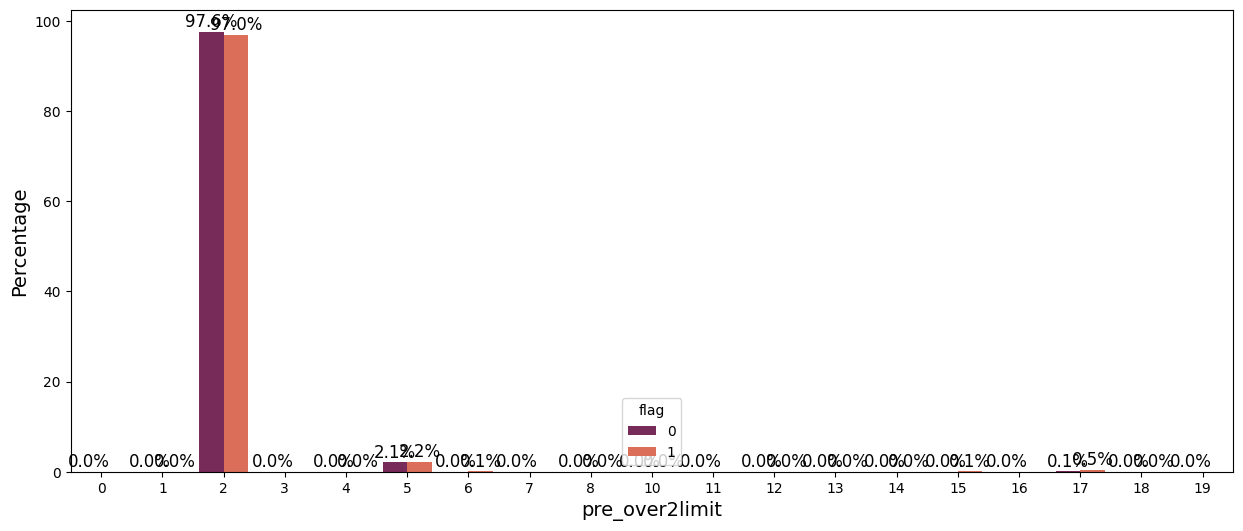

In [93]:
barplot_group("pre_over2limit", "flag")

In [32]:
df = df.drop(columns=["pre_over2limit"])

In [36]:
df.nunique()[df.nunique() > 6].index

Index(['rn', 'pre_since_opened', 'pre_since_confirmed', 'pre_pterm',
       'pre_fterm', 'pre_till_pclose', 'pre_till_fclose',
       'pre_loans_credit_limit', 'pre_loans_next_pay_summ',
       'pre_loans_credit_cost_rate', 'pre_loans530', 'pre_util',
       'pre_maxover2limit', 'enc_loans_account_holder_type',
       'enc_loans_credit_status', 'pre_since_opened_2',
       'pre_since_confirmed_2', 'pre_pterm_2', 'pre_fterm_2',
       'pre_till_pclose_2', 'pre_till_fclose_2', 'pre_loans_credit_limit_2',
       'pre_loans_next_pay_summ_2', 'pre_loans_credit_cost_rate_2',
       'pre_loans5_2', 'pre_loans530_2', 'pre_util_2', 'pre_over2limit_2',
       'pre_maxover2limit_2', 'enc_loans_account_holder_type_2',
       'enc_loans_credit_status_2', 'pre_since_opened_3',
       'pre_since_confirmed_3', 'pre_pterm_3', 'pre_fterm_3',
       'pre_till_pclose_3', 'pre_till_fclose_3', 'pre_loans_credit_limit_3',
       'pre_loans_next_pay_summ_3', 'pre_loans_credit_cost_rate_3',
       'pre_loans5_

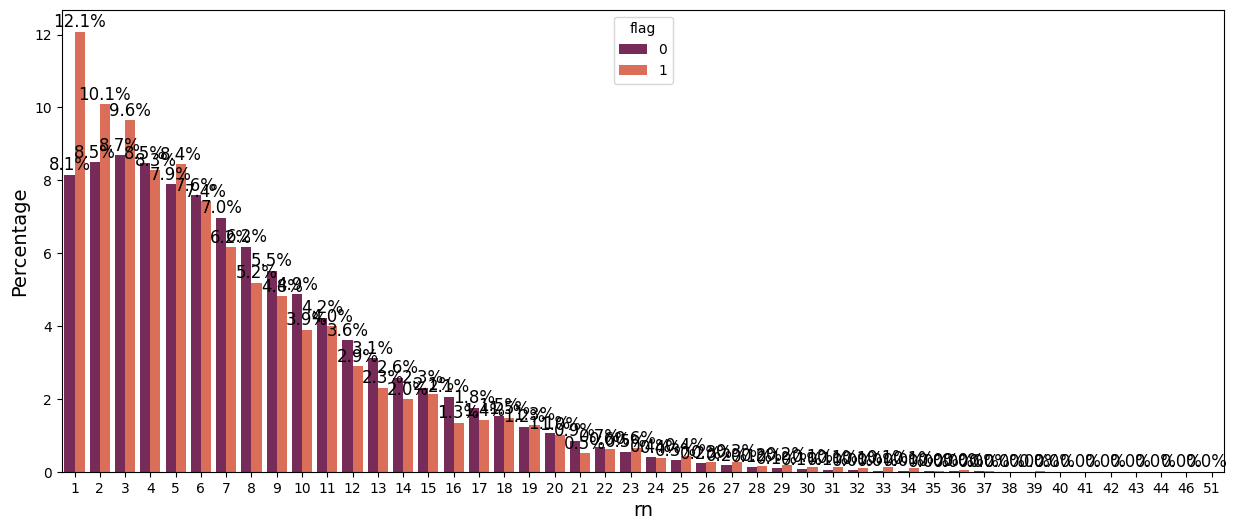

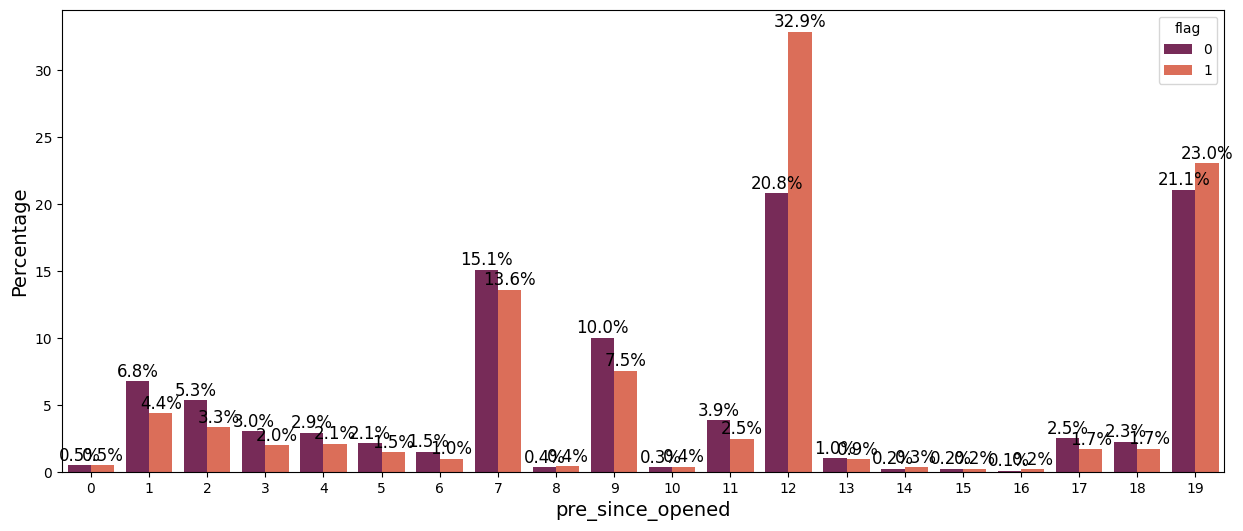

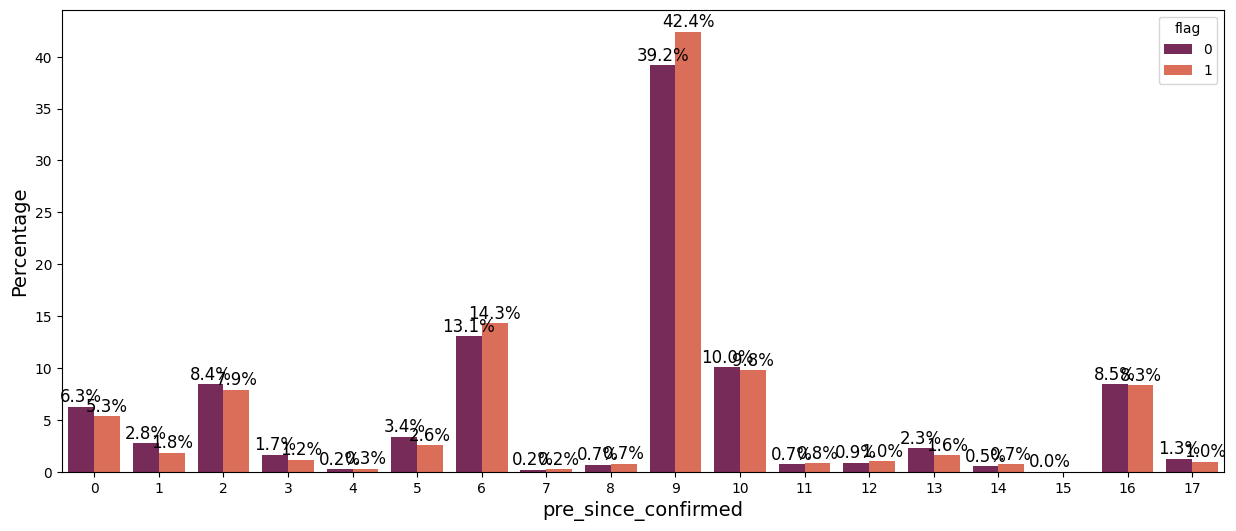

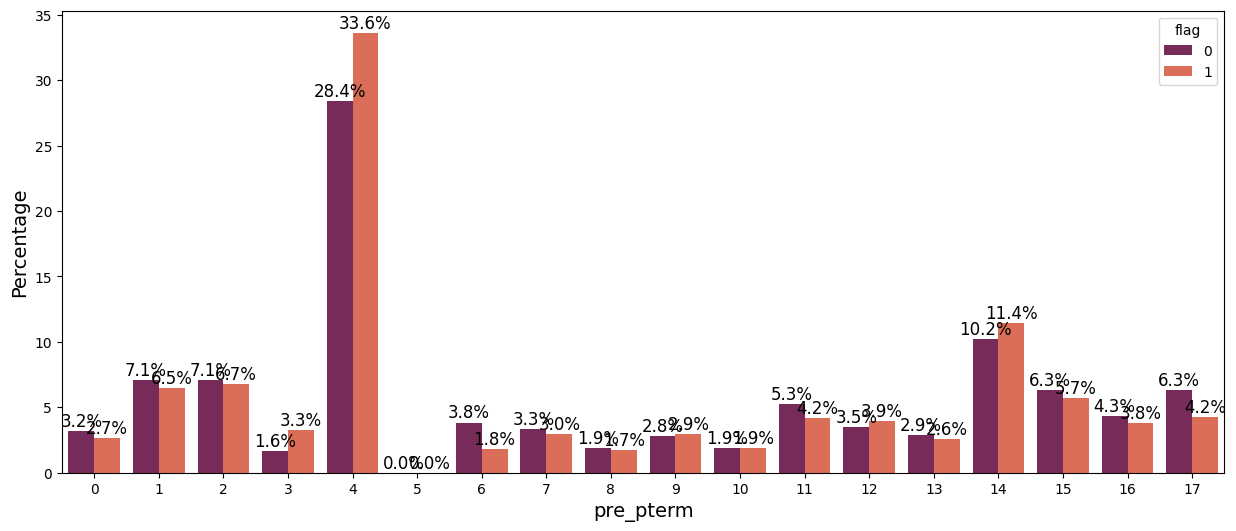

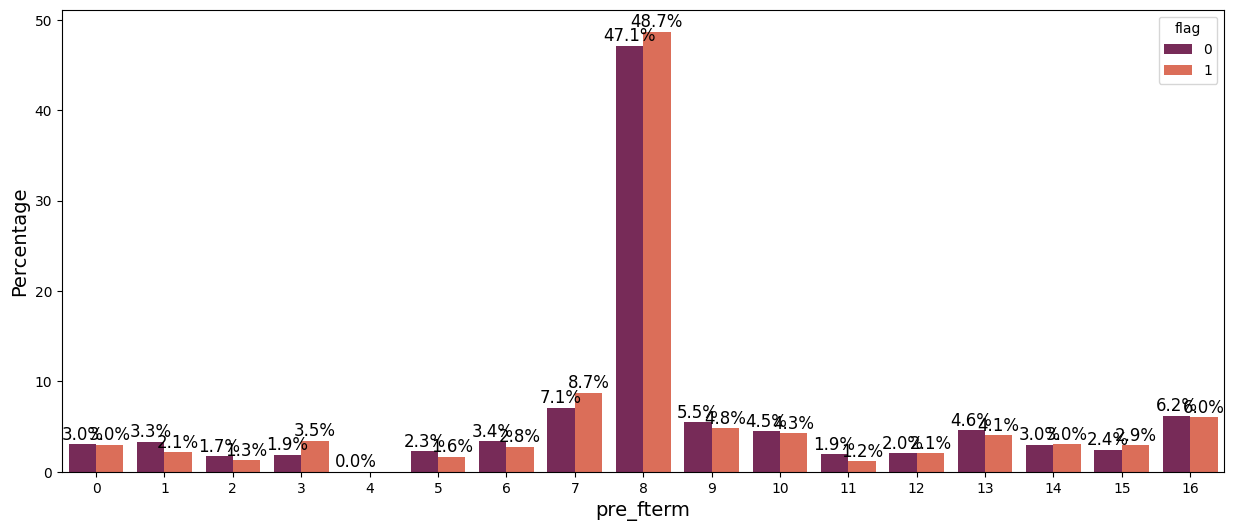

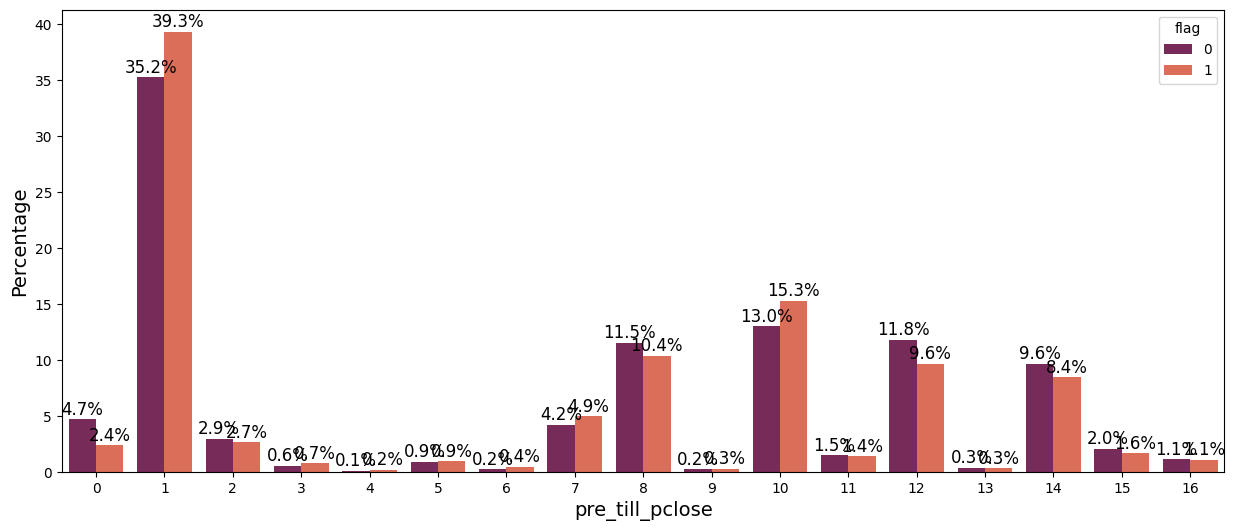

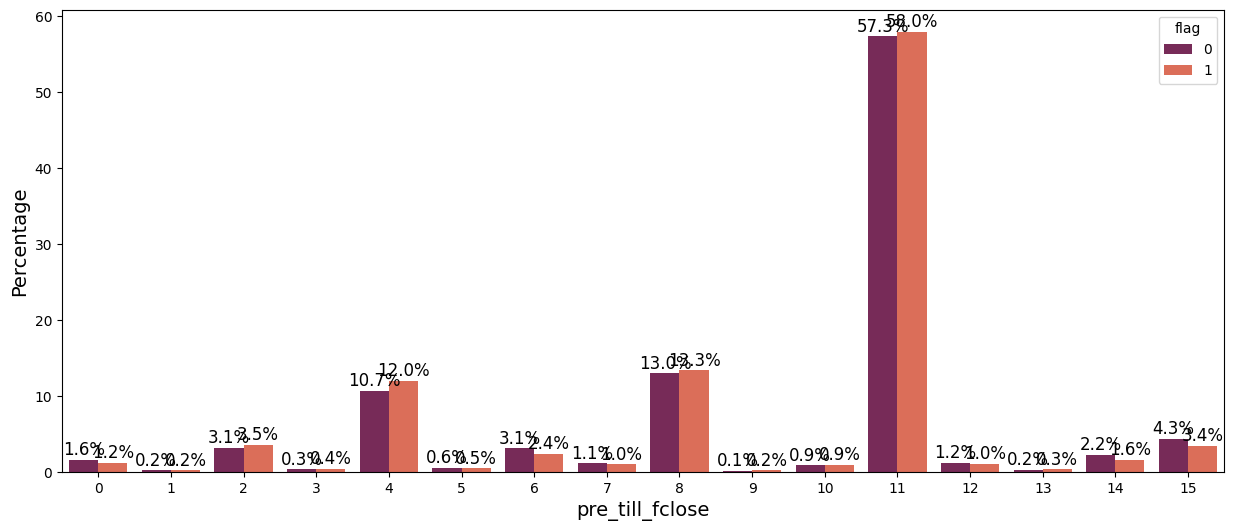

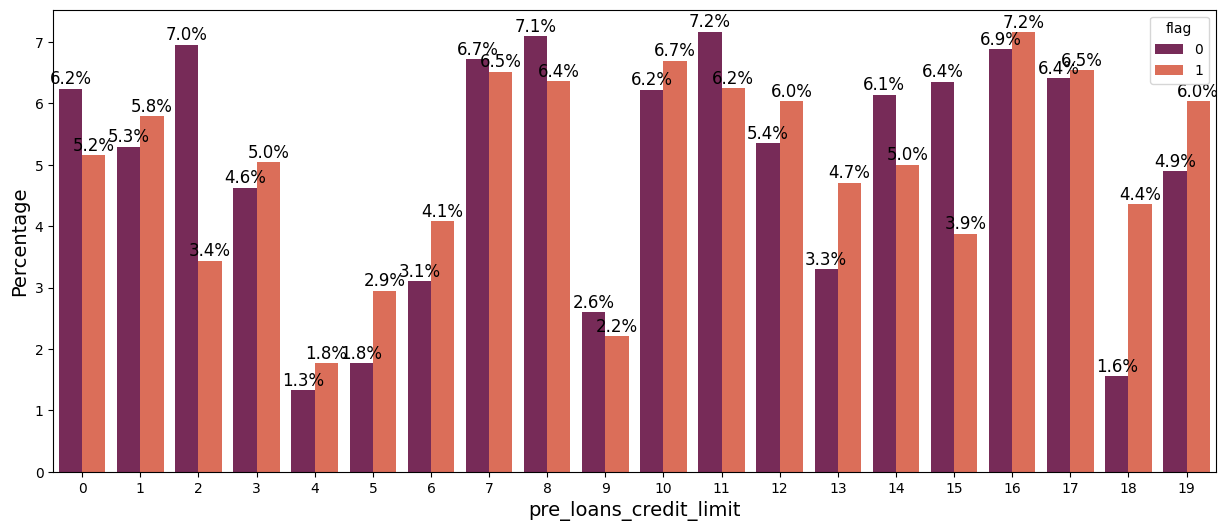

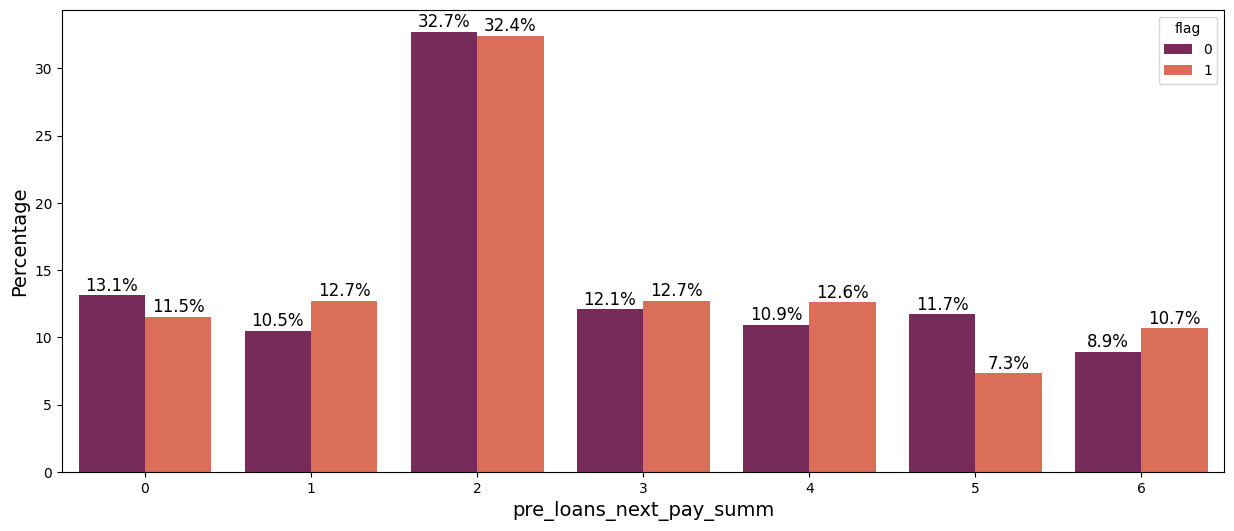

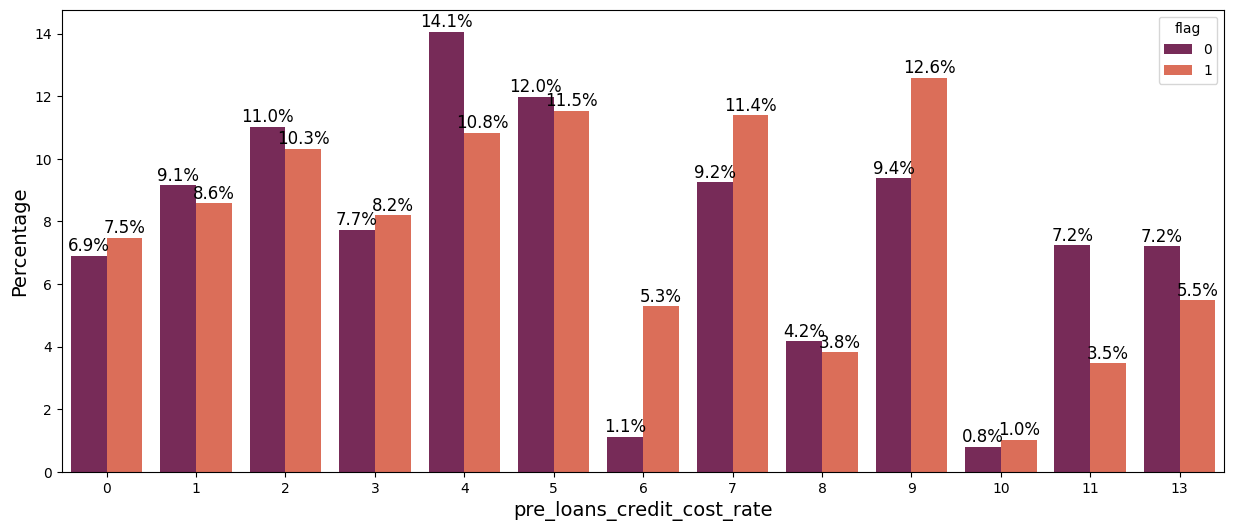

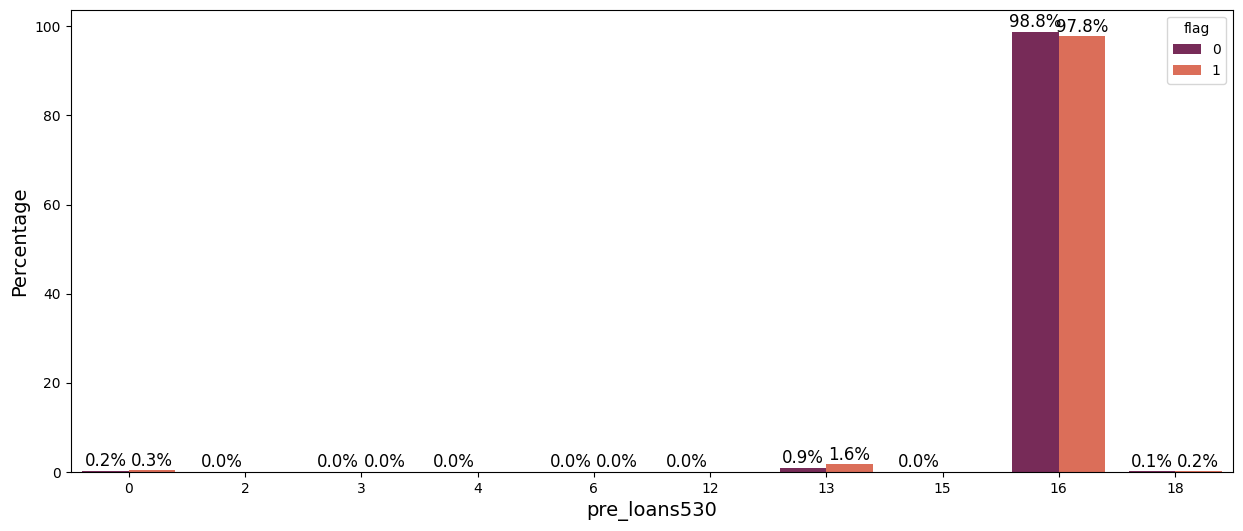

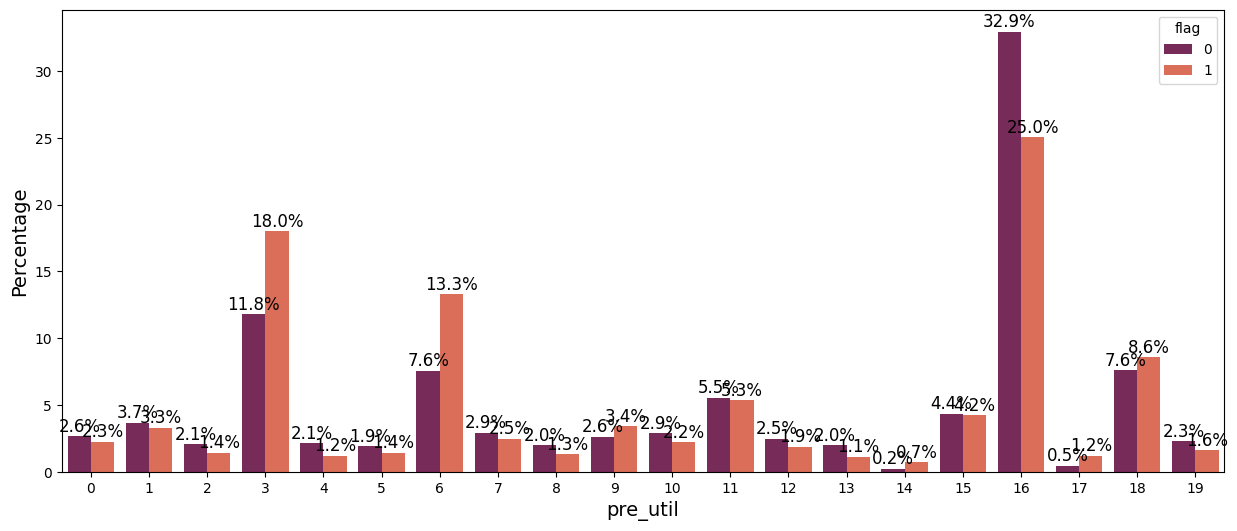

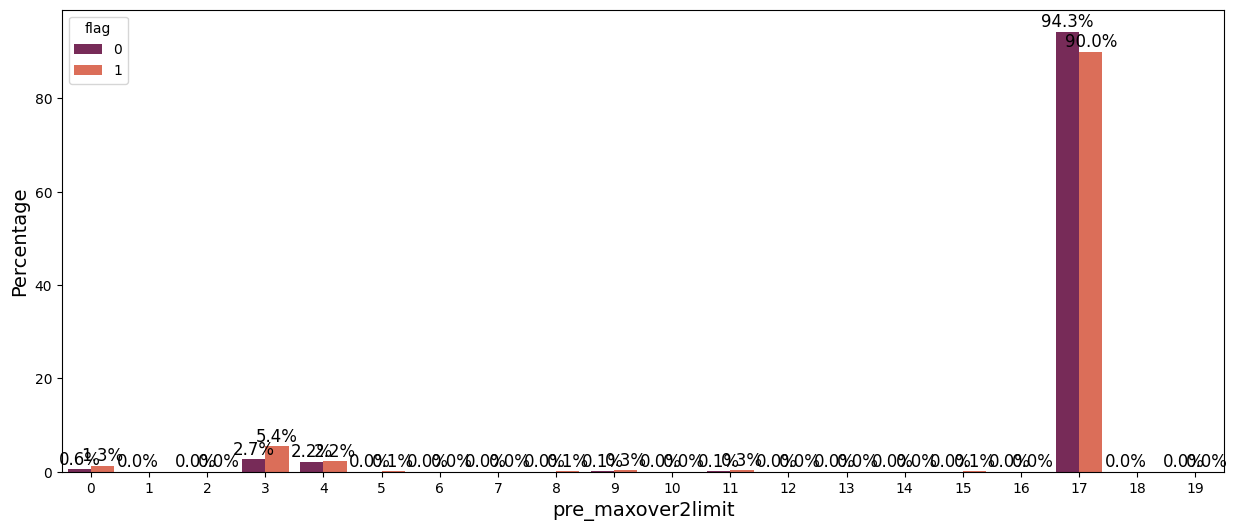

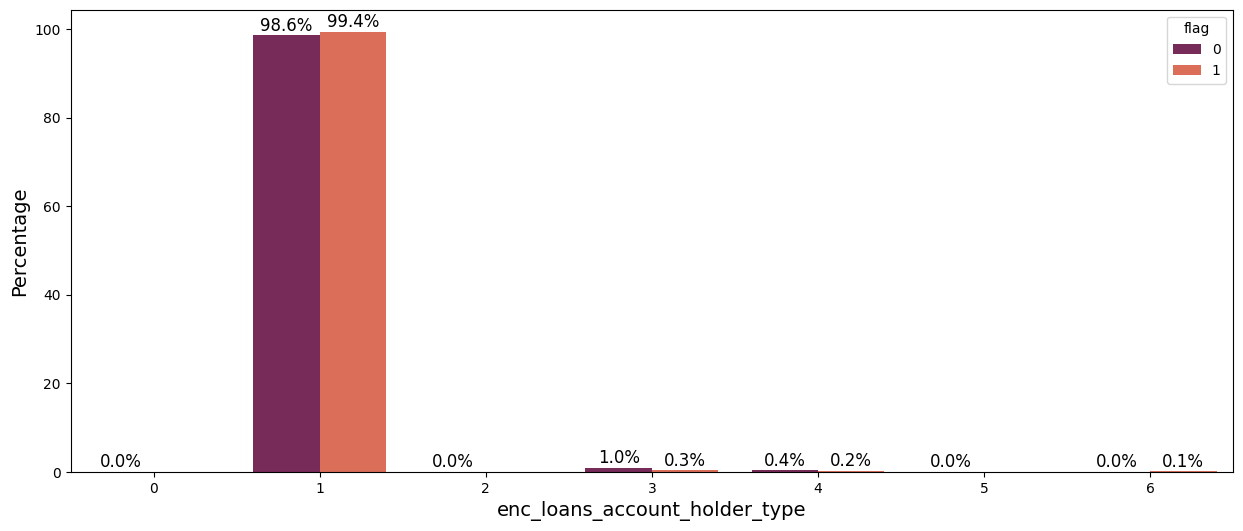

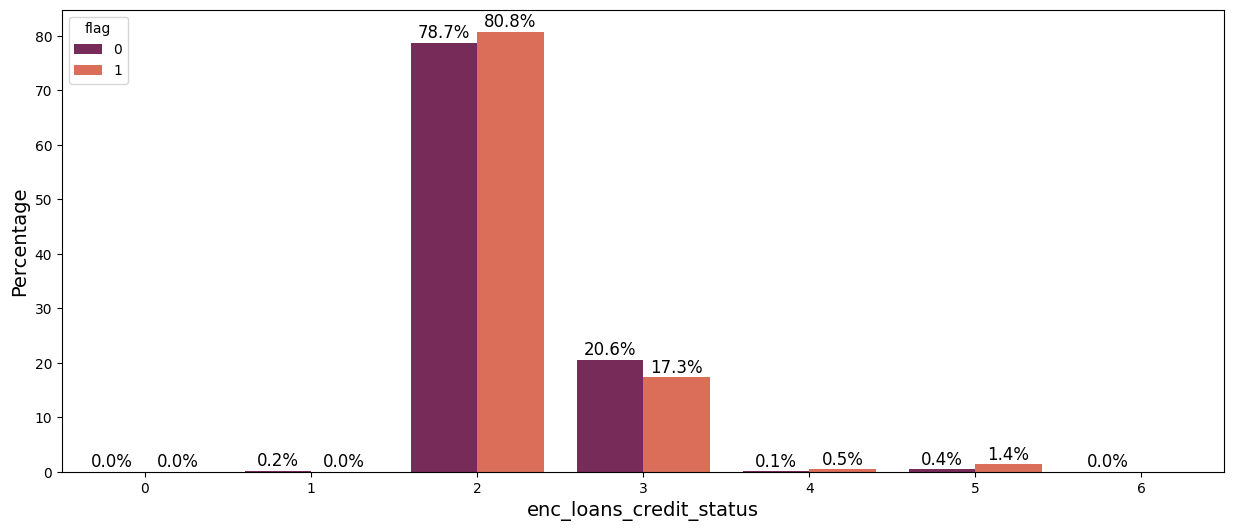

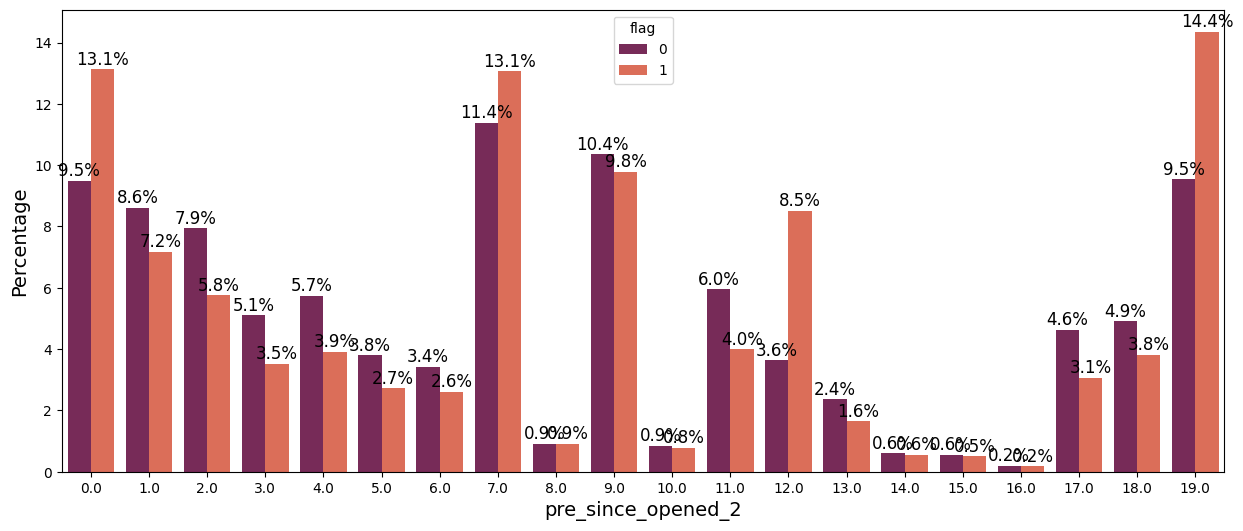

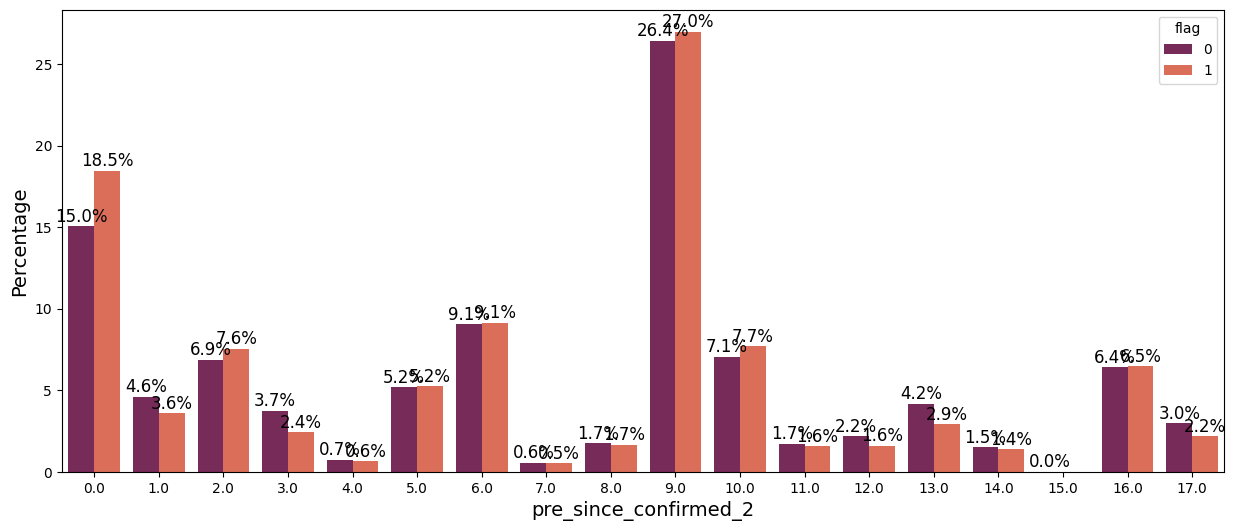

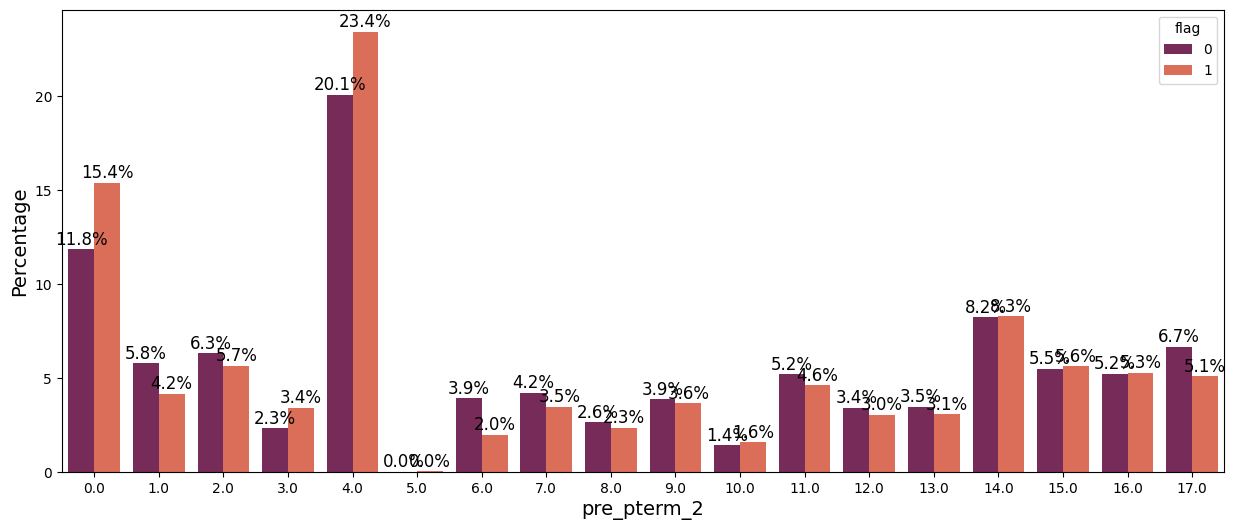

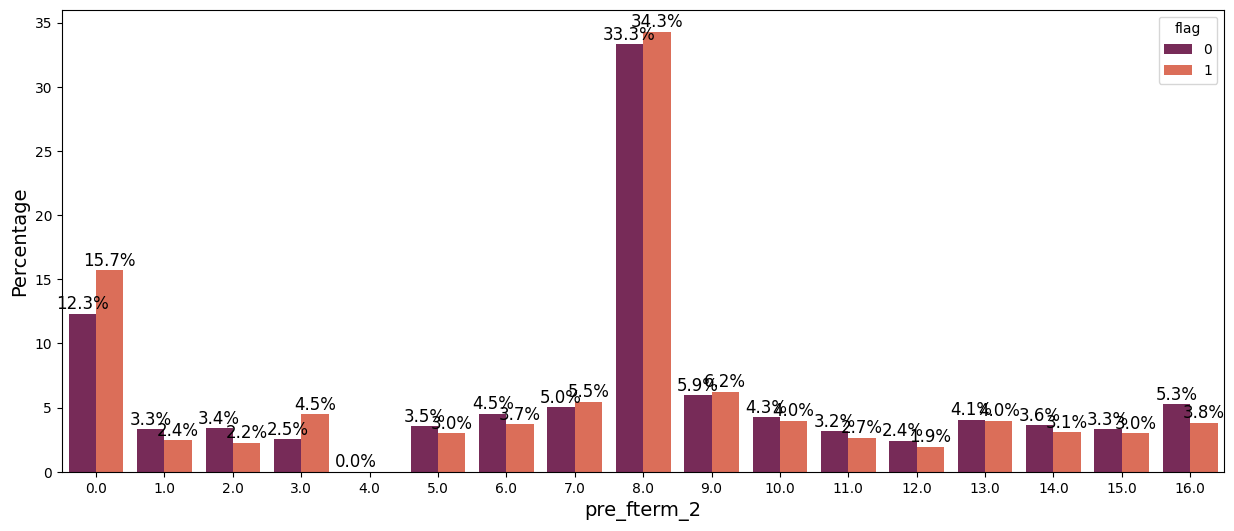

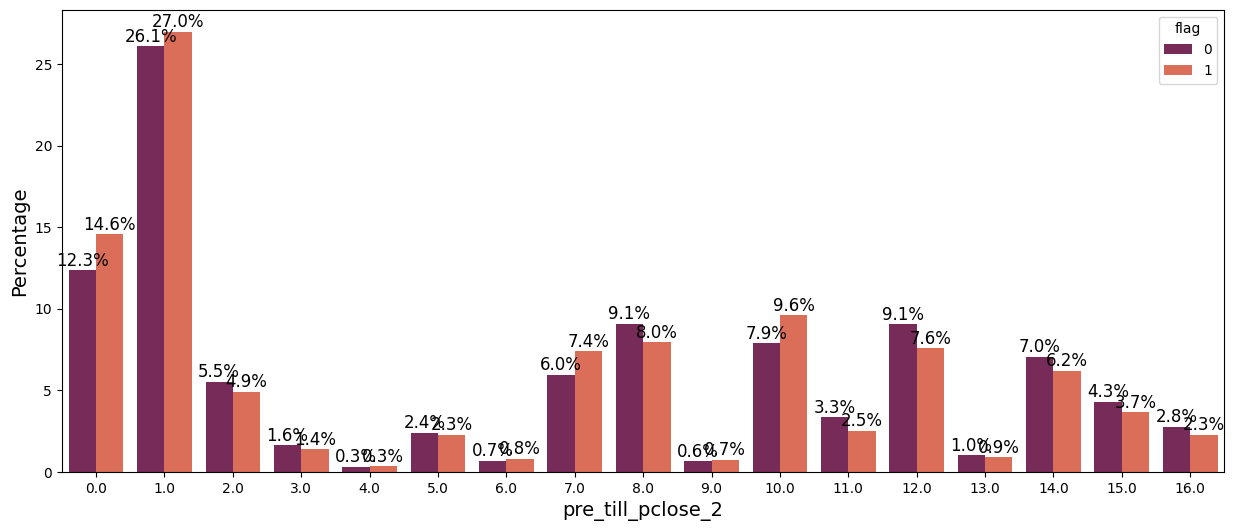

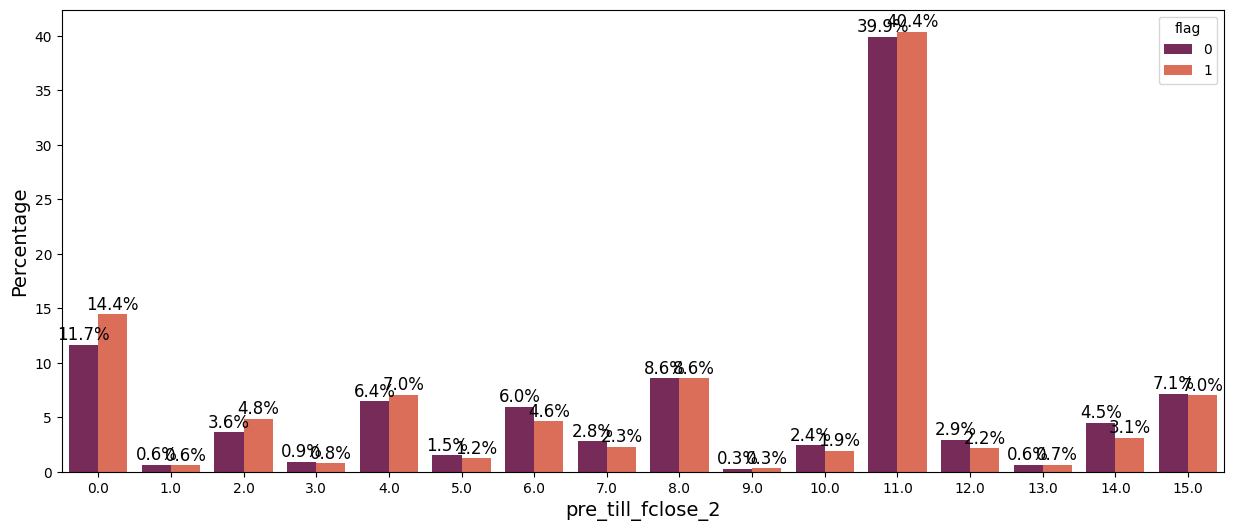

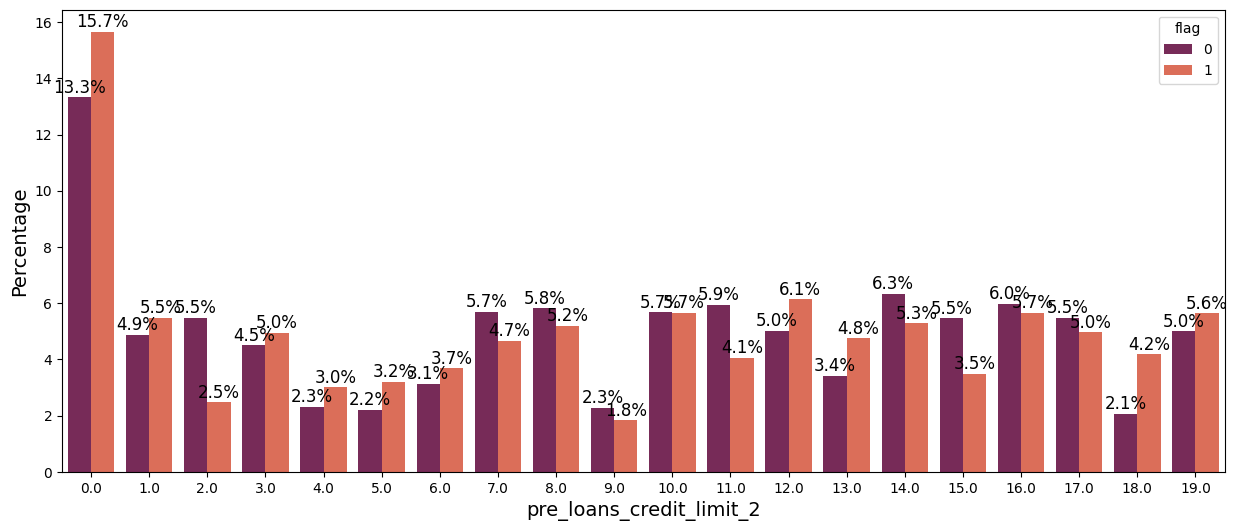

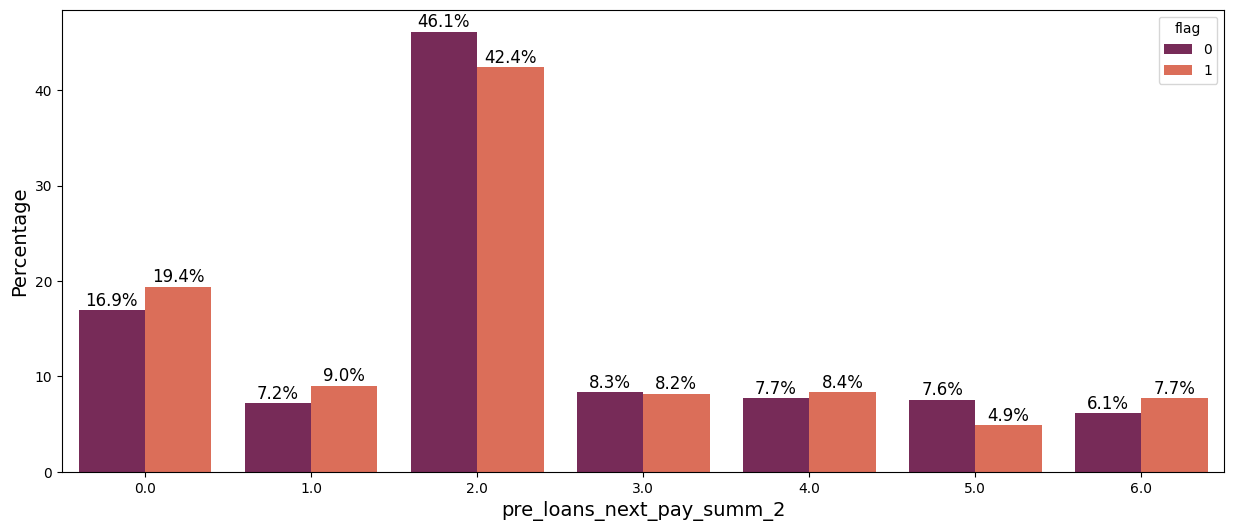

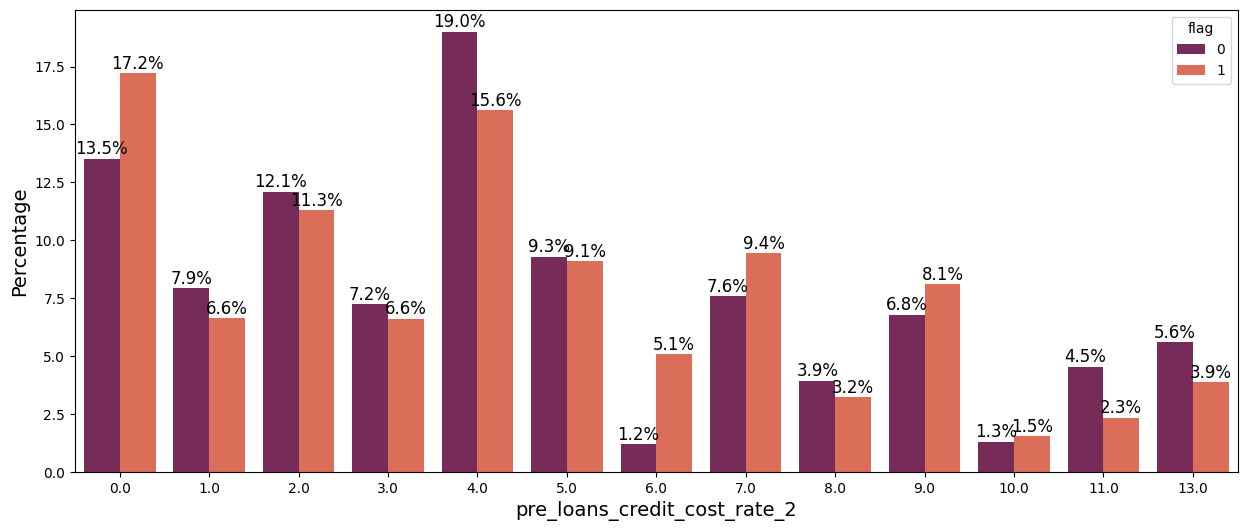

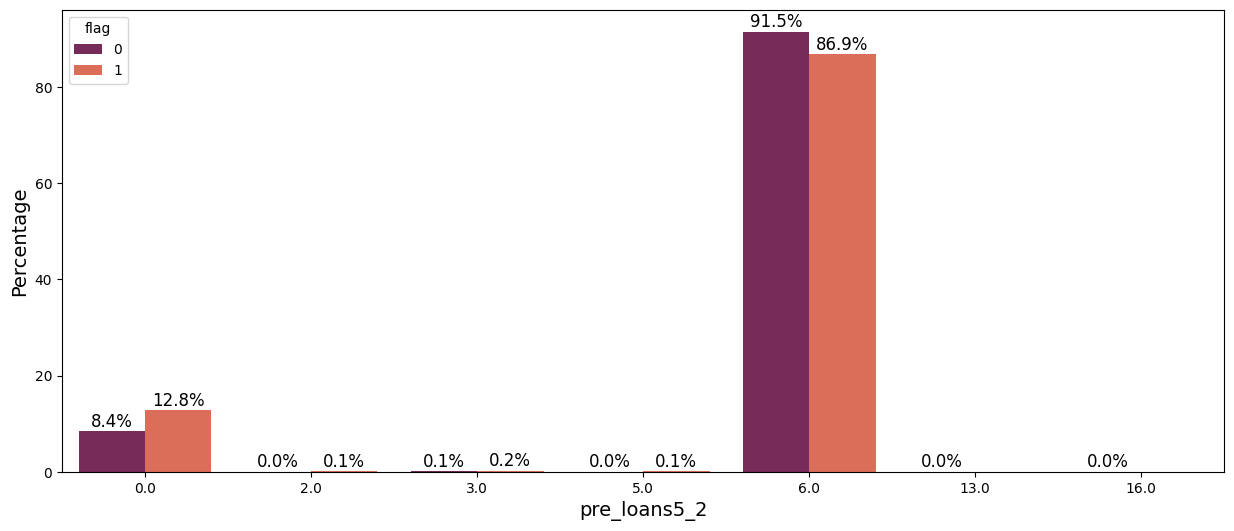

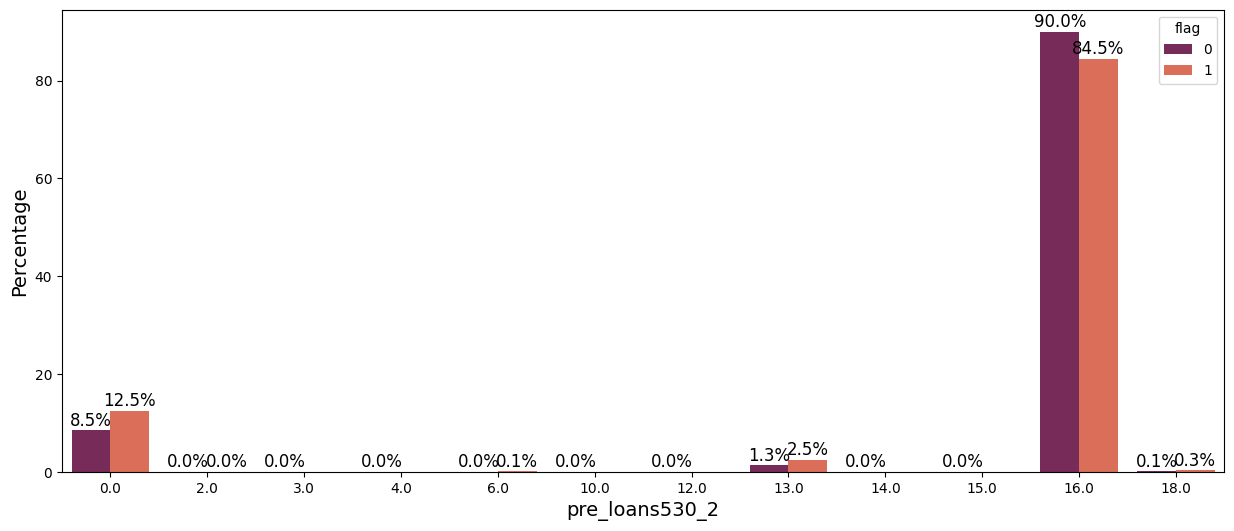

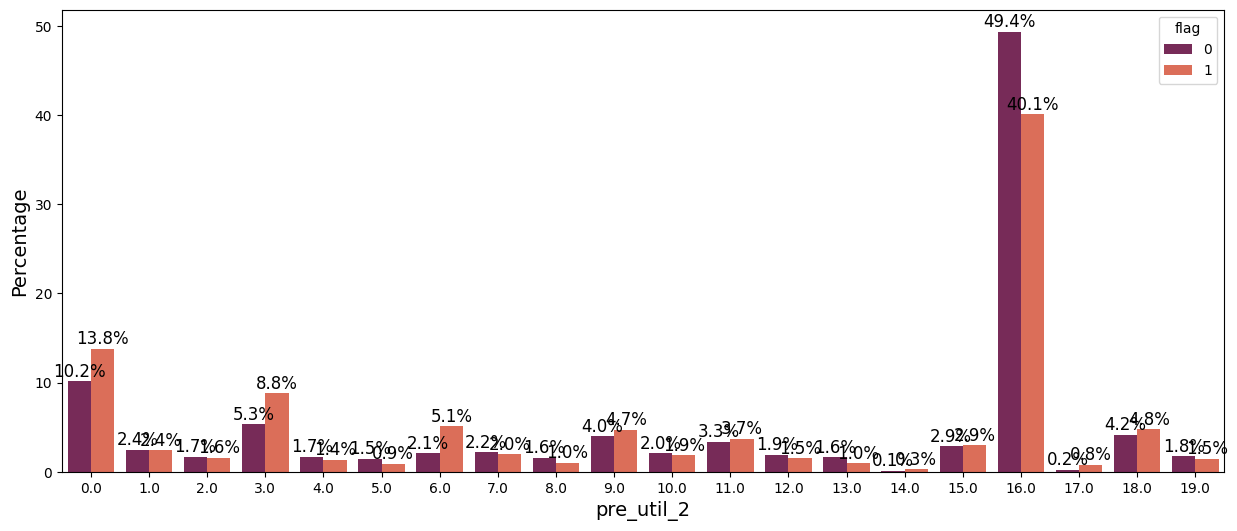

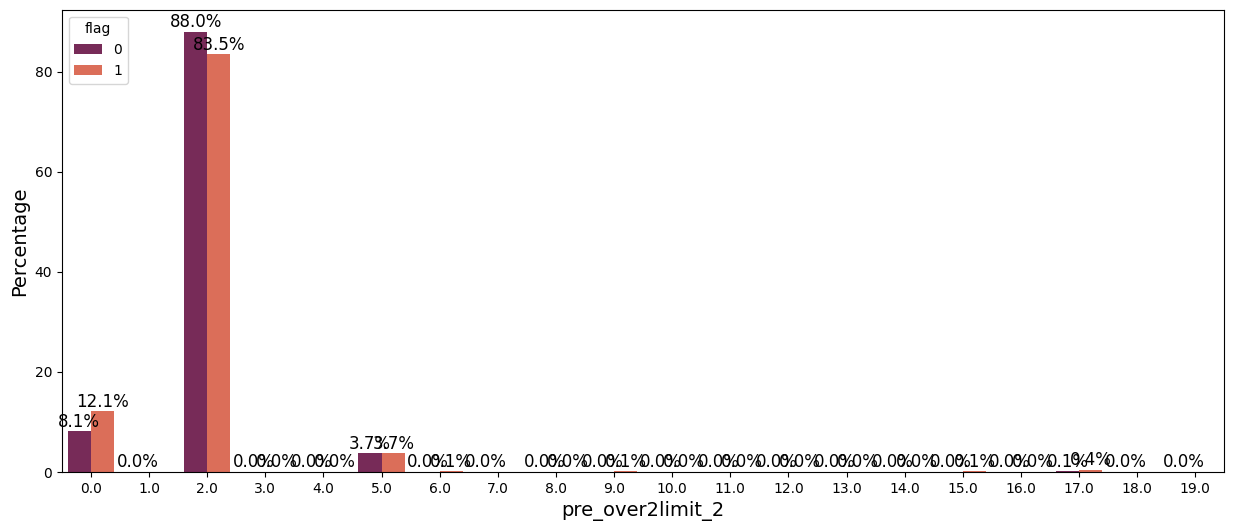

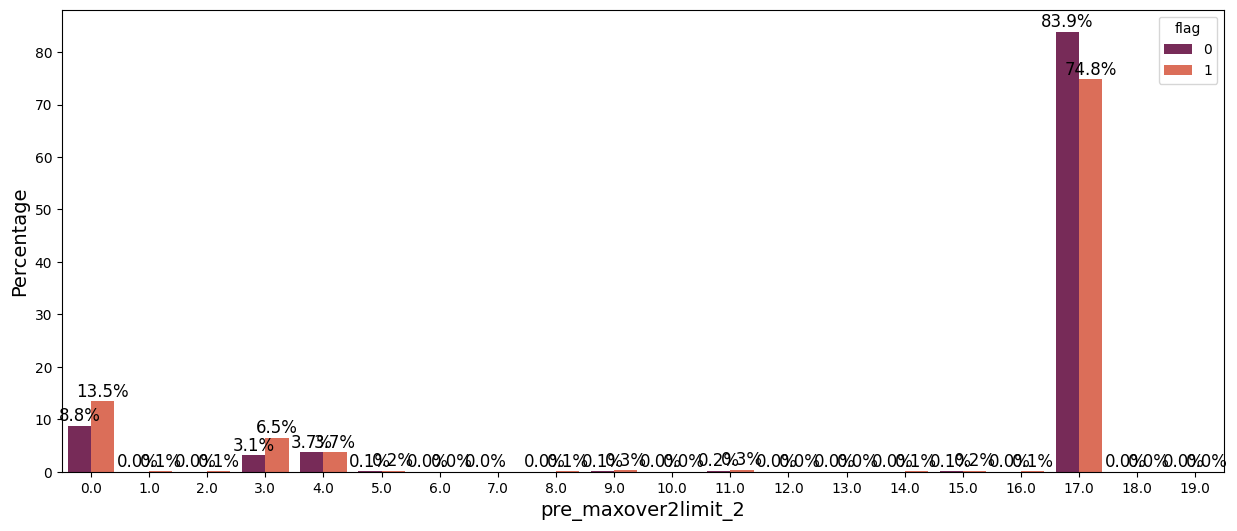

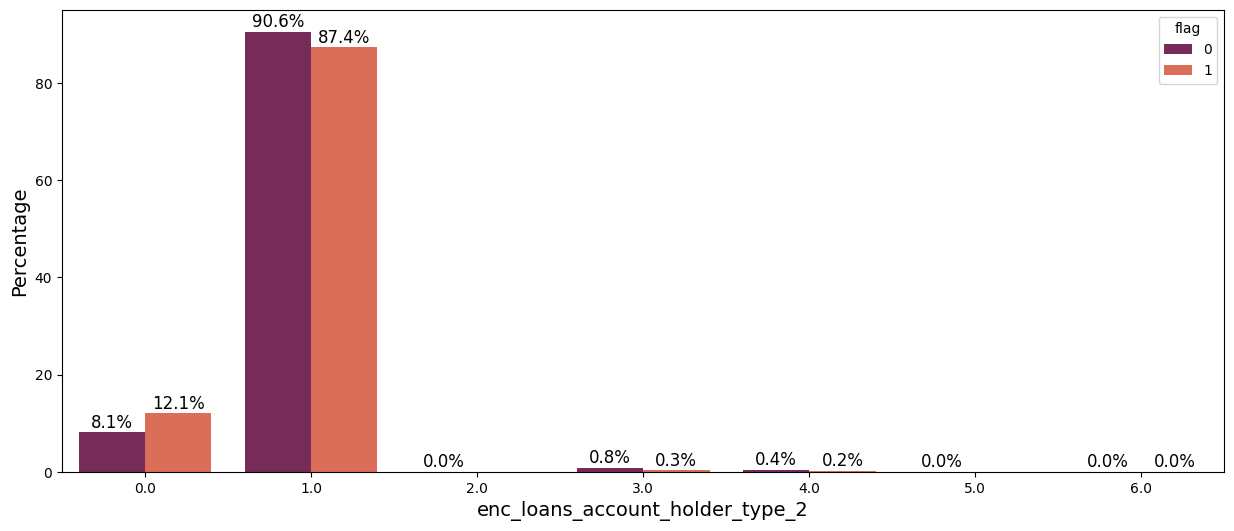

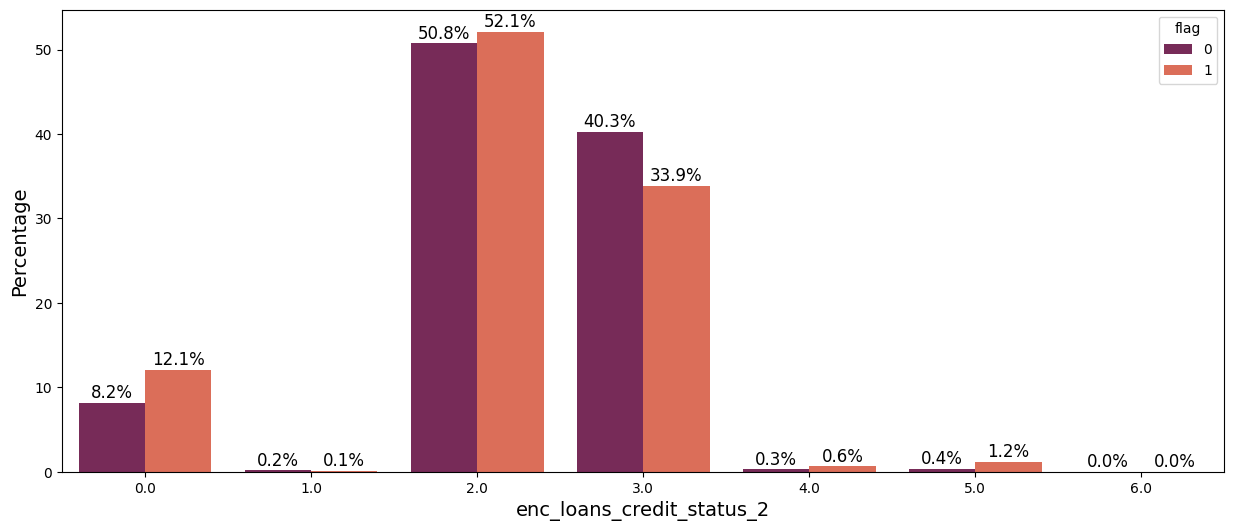

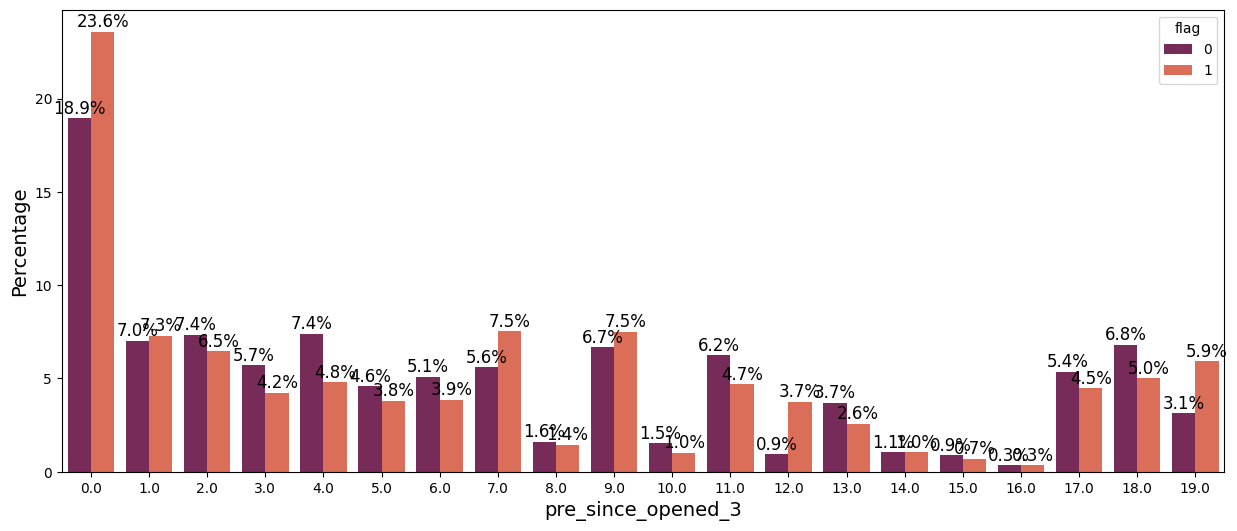

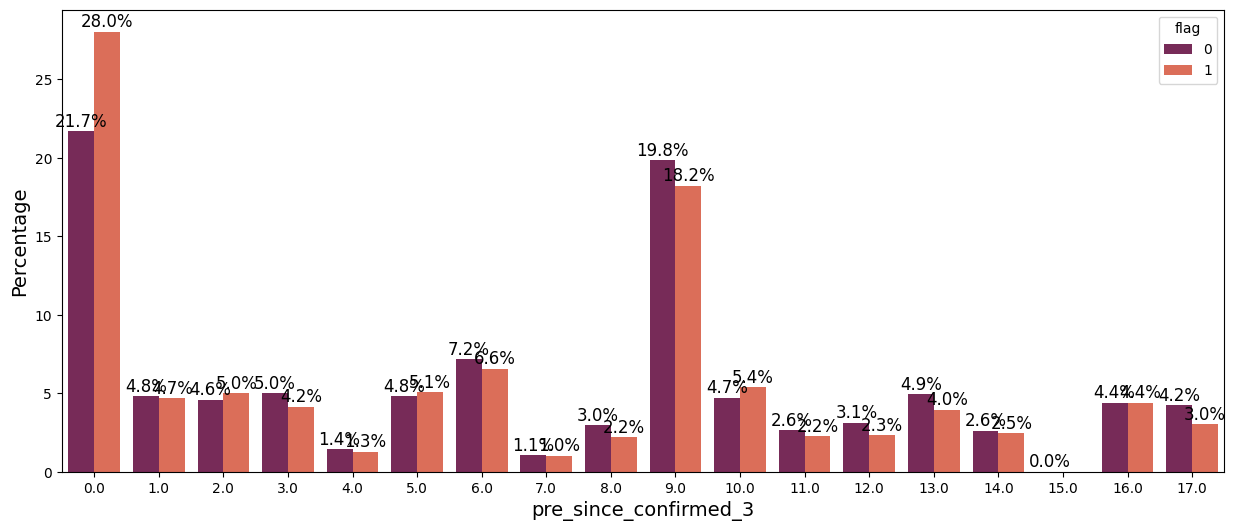

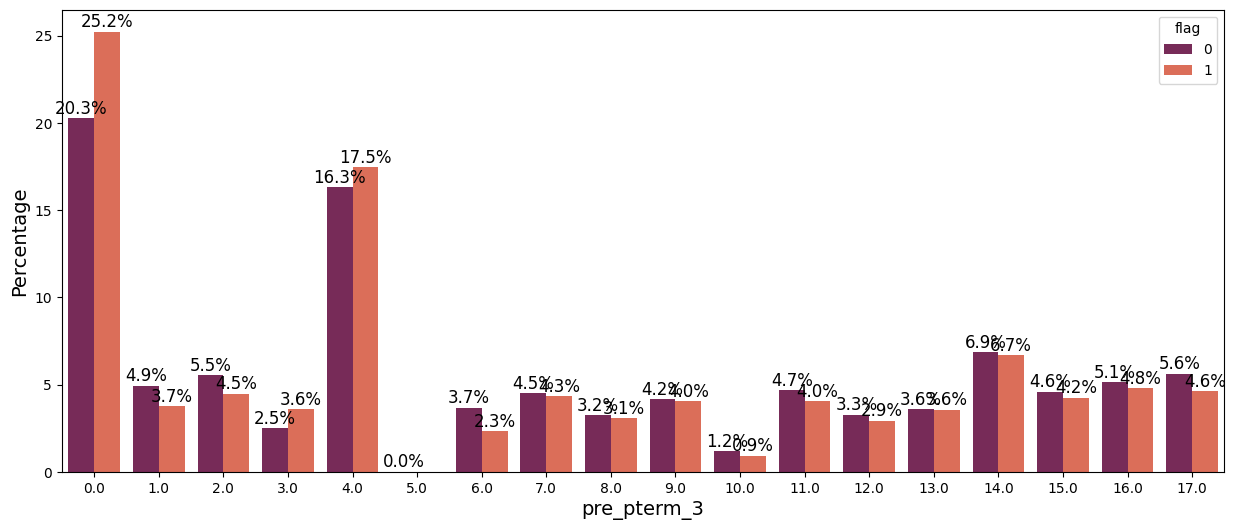

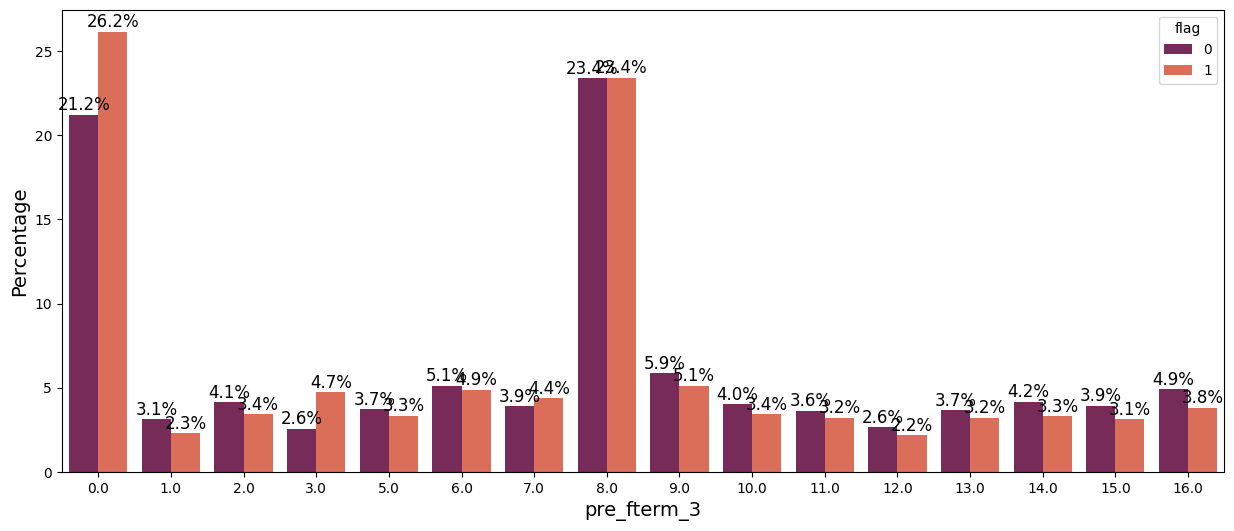

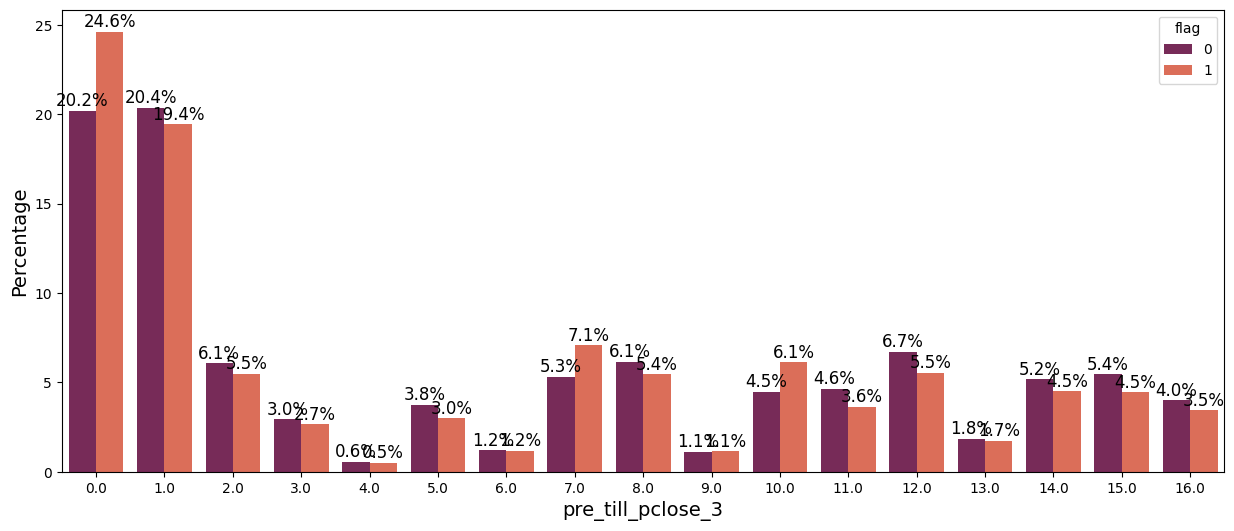

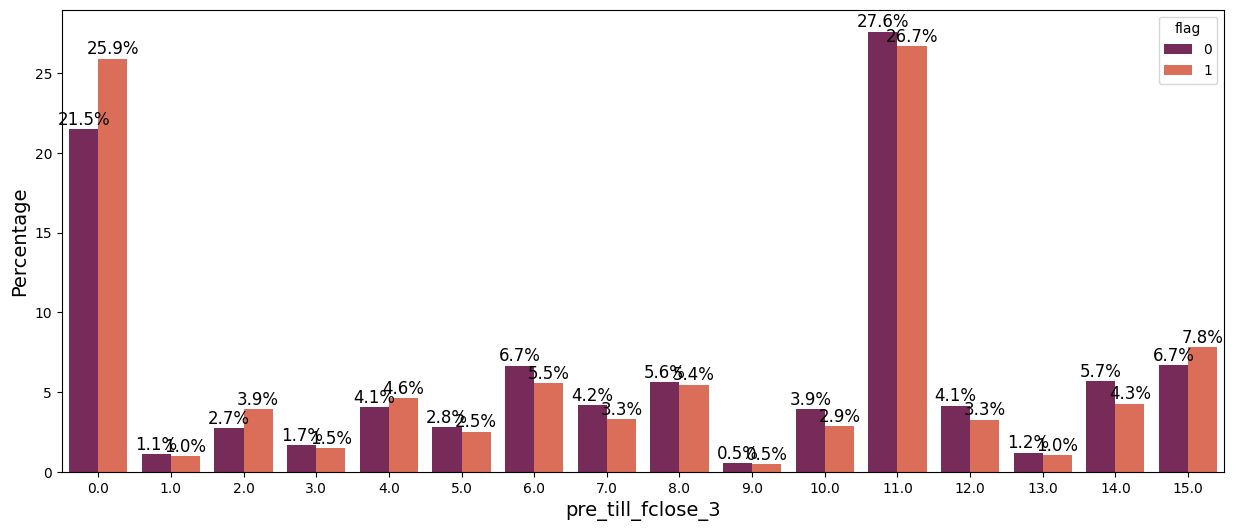

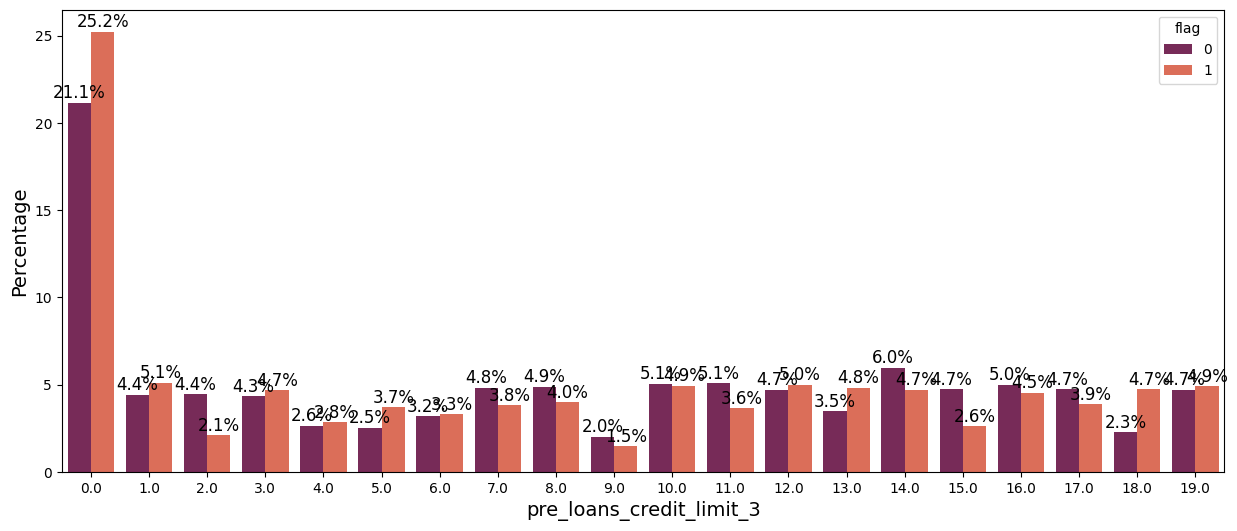

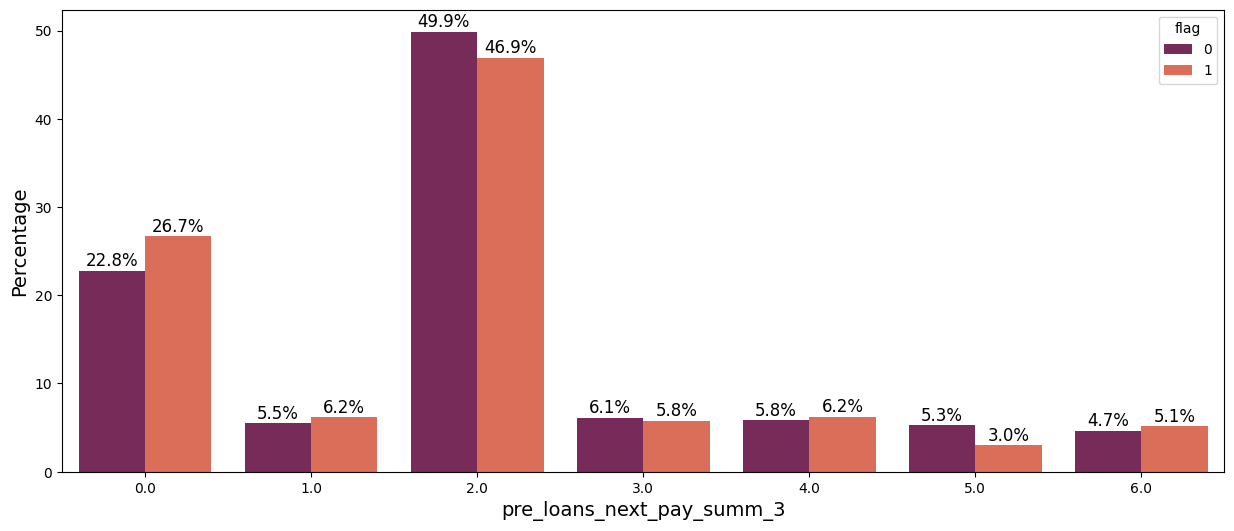

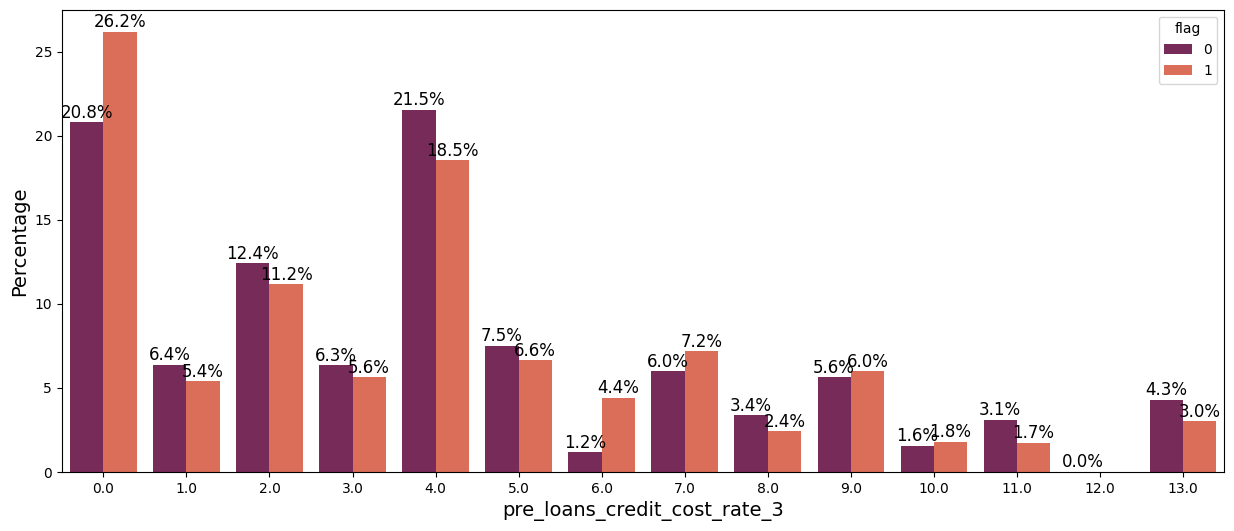

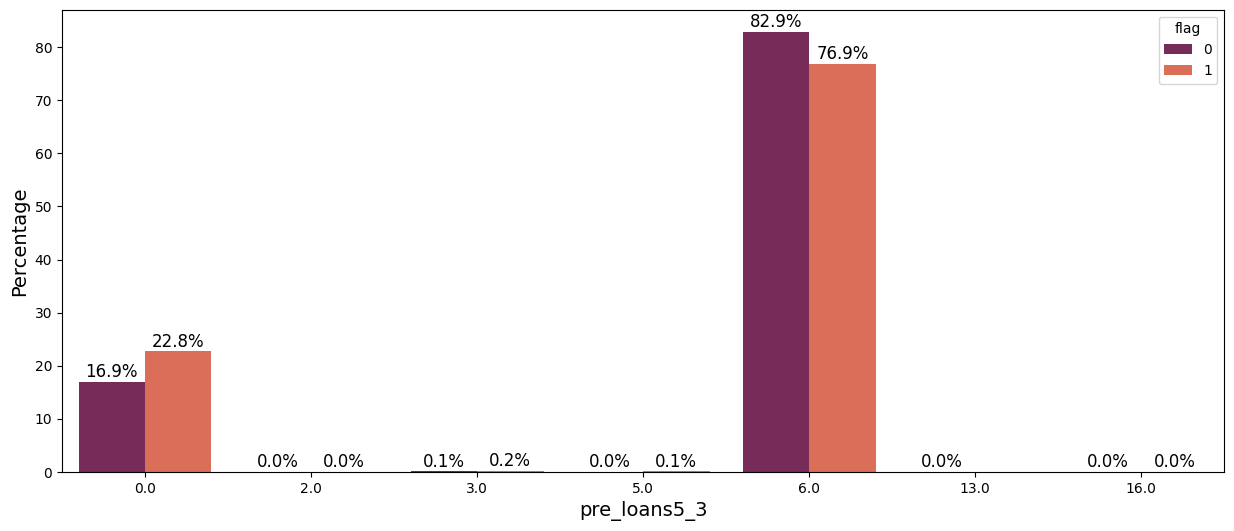

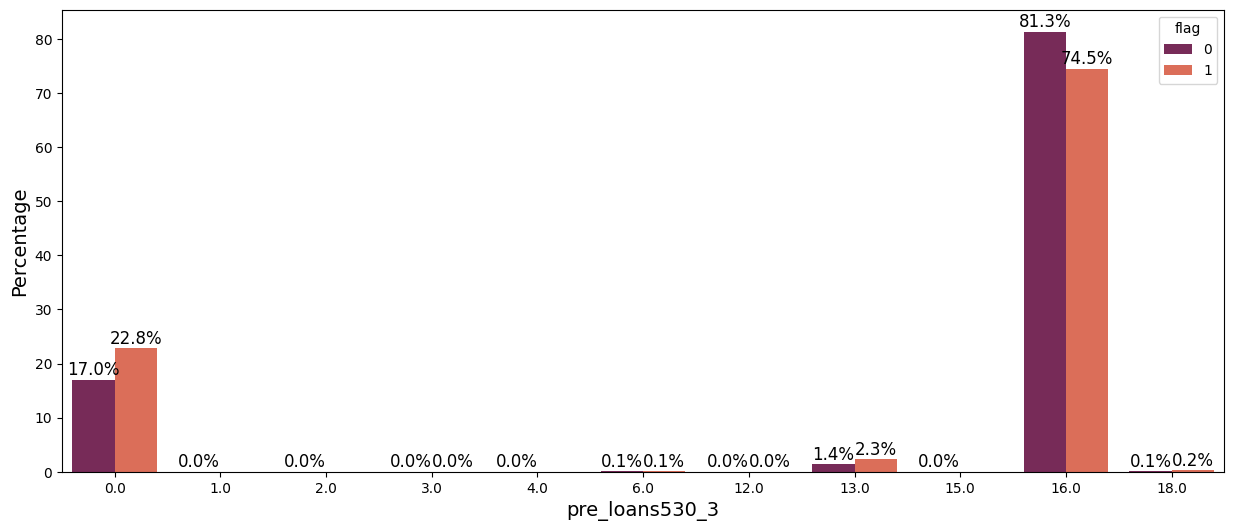

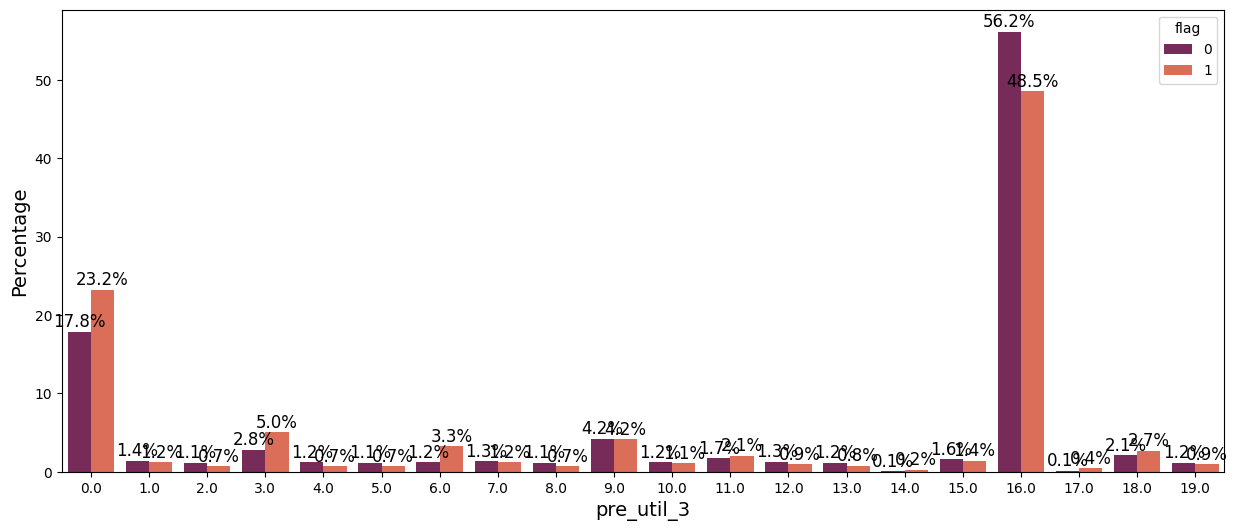

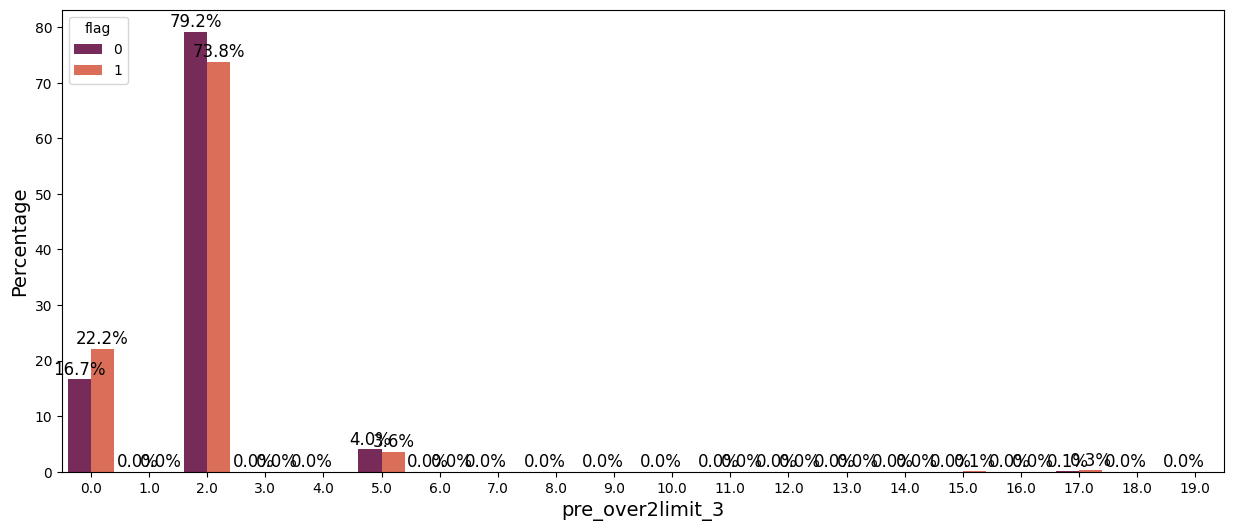

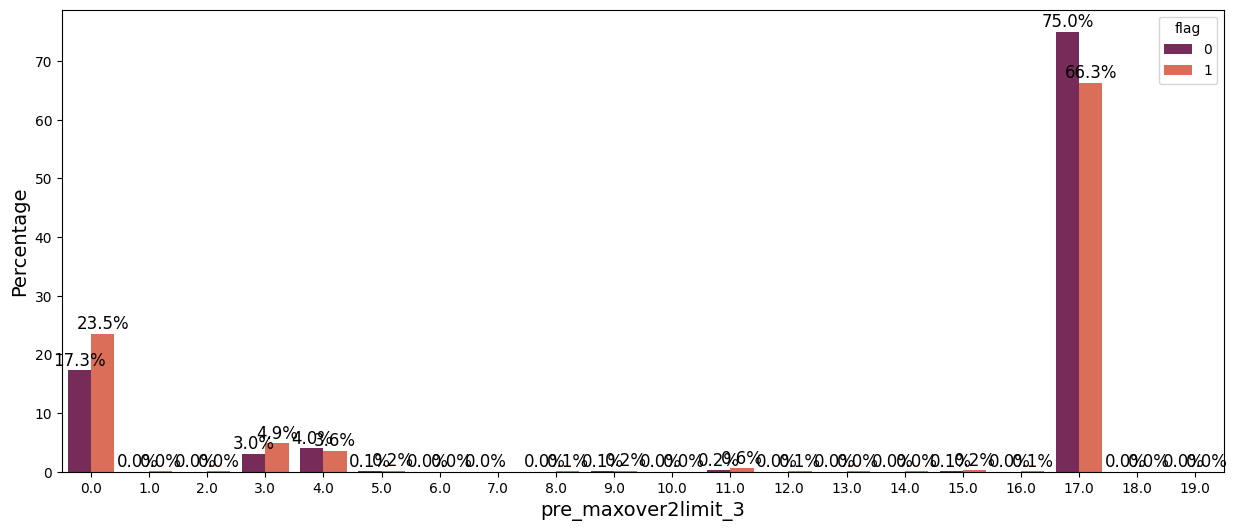

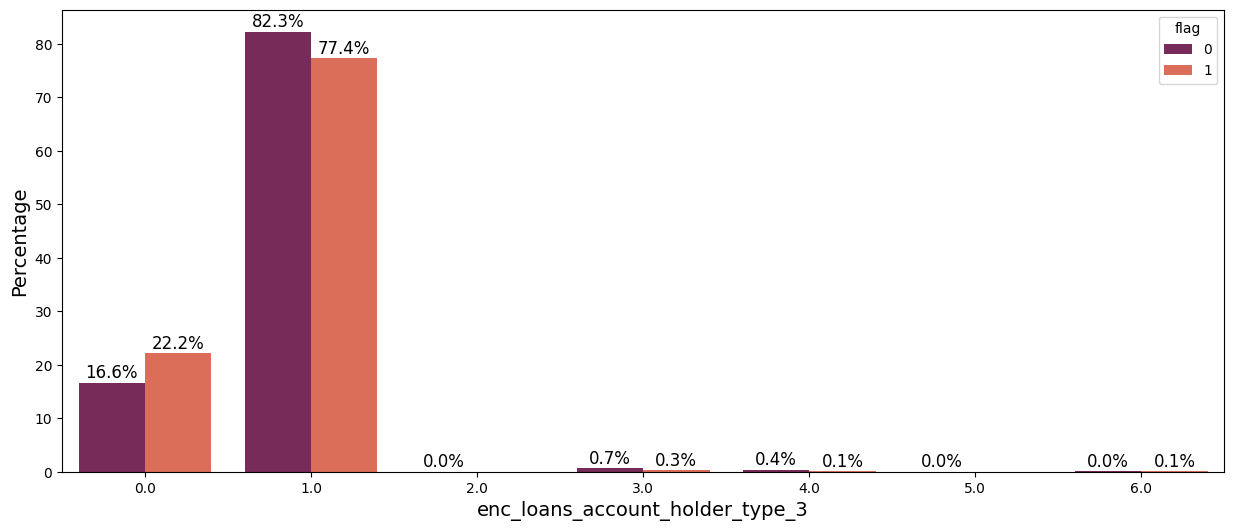

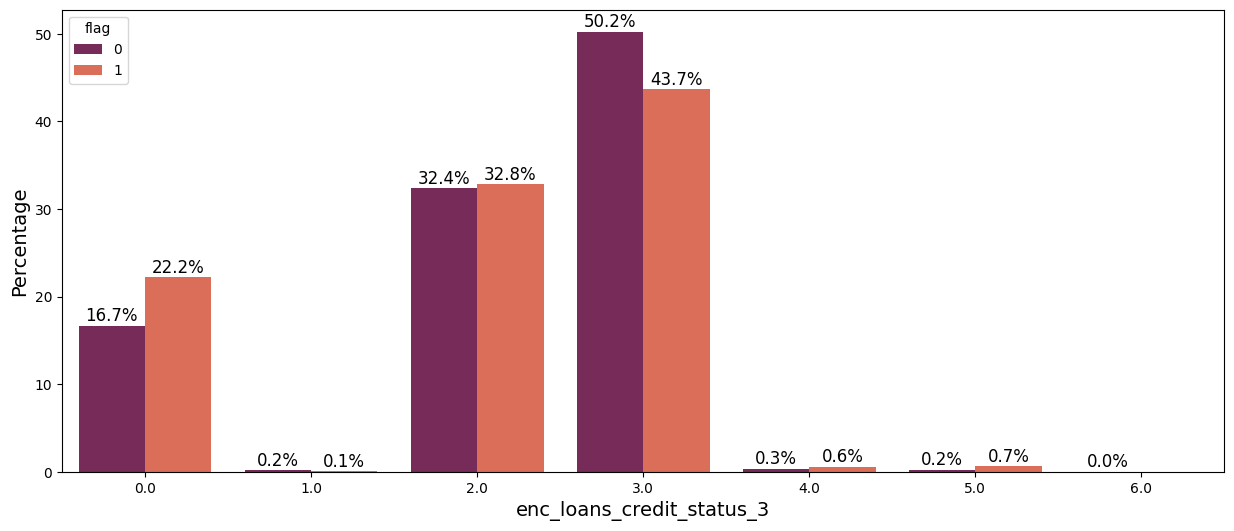

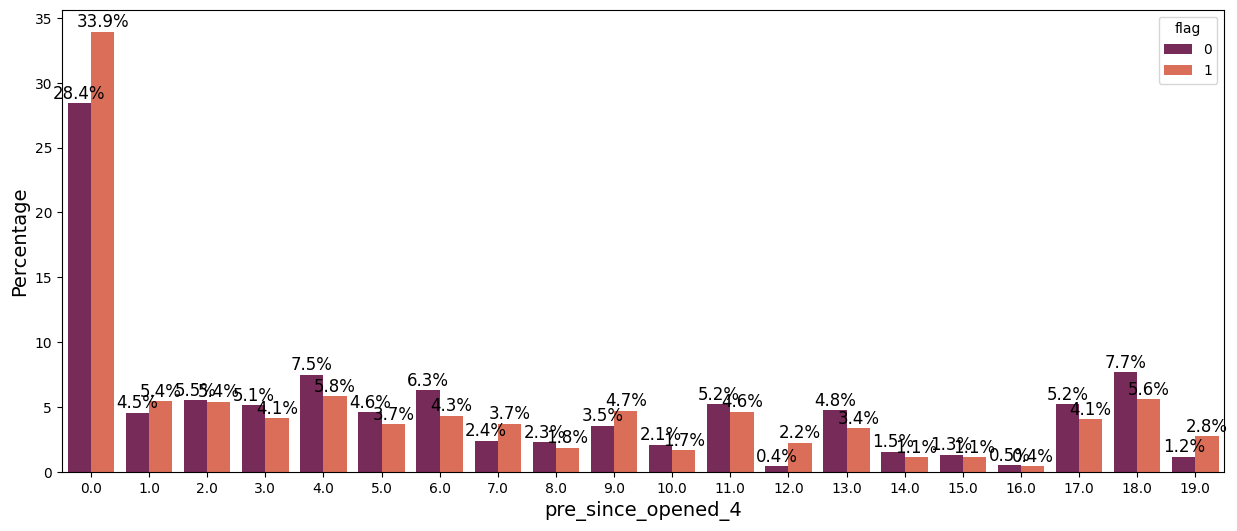

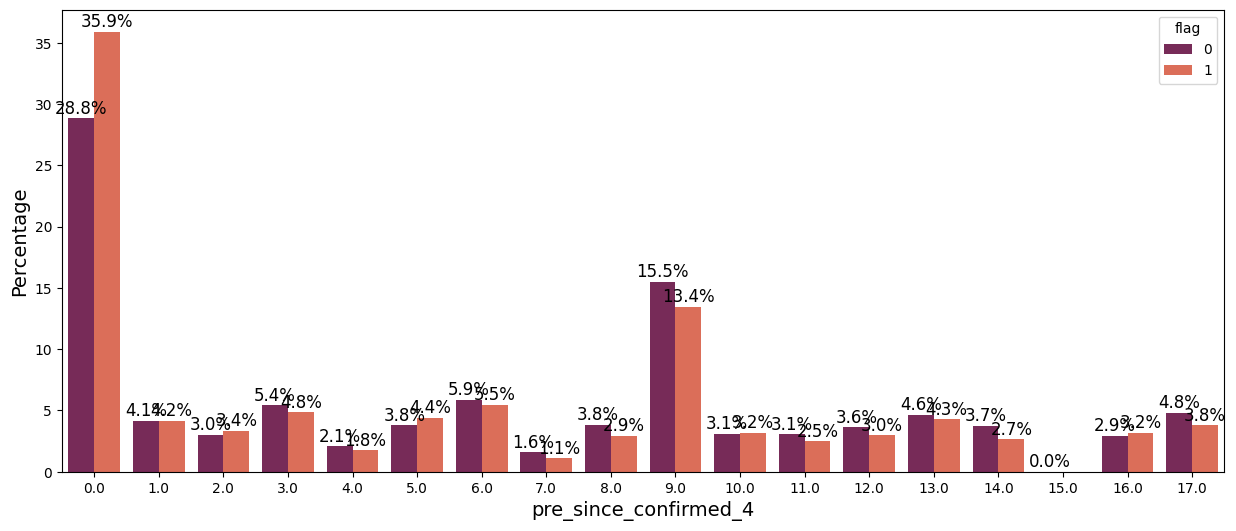

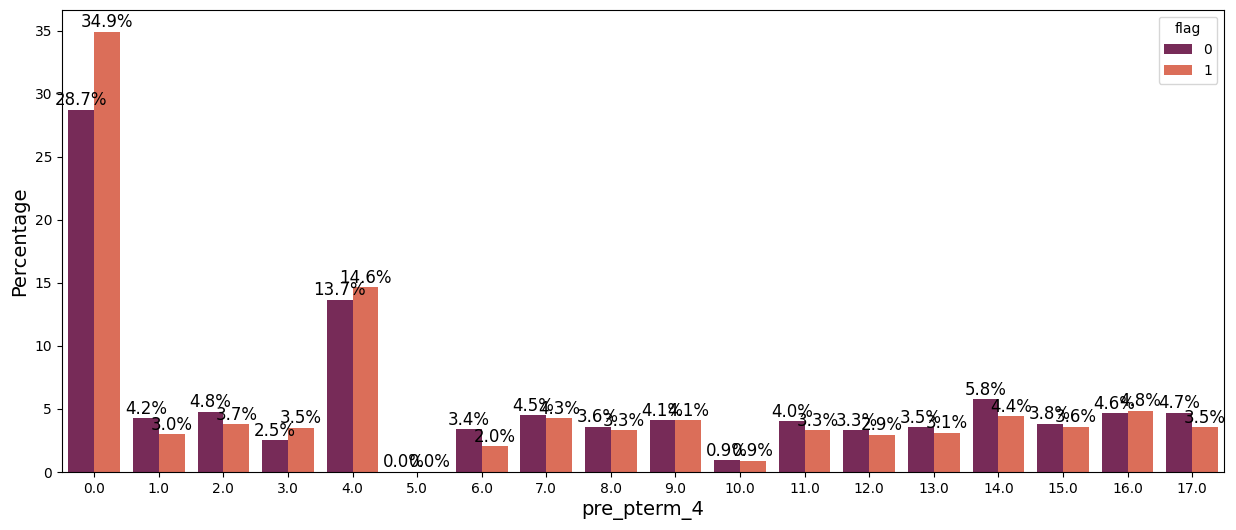

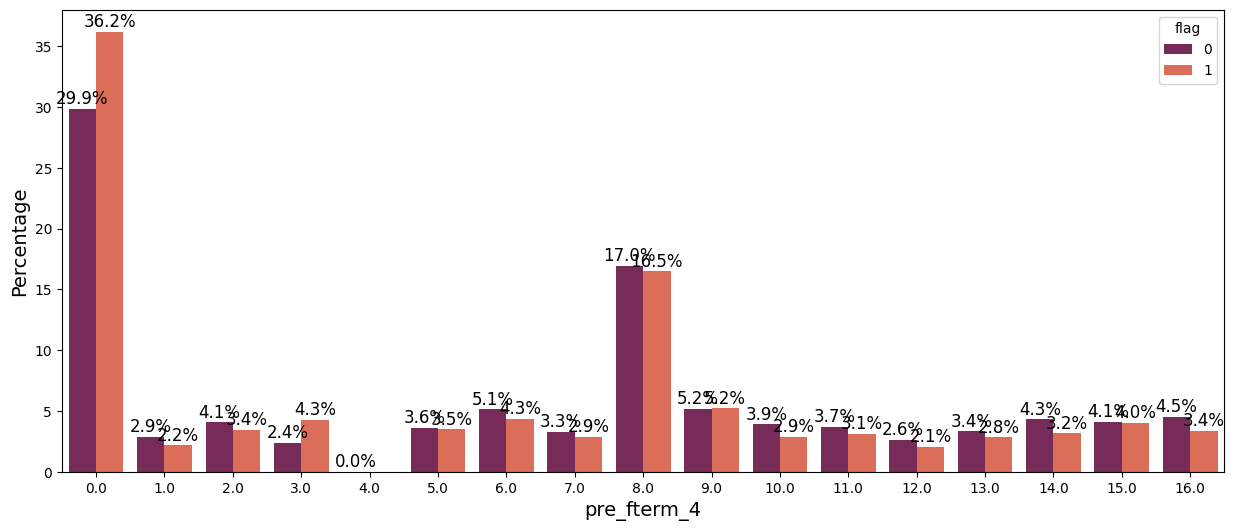

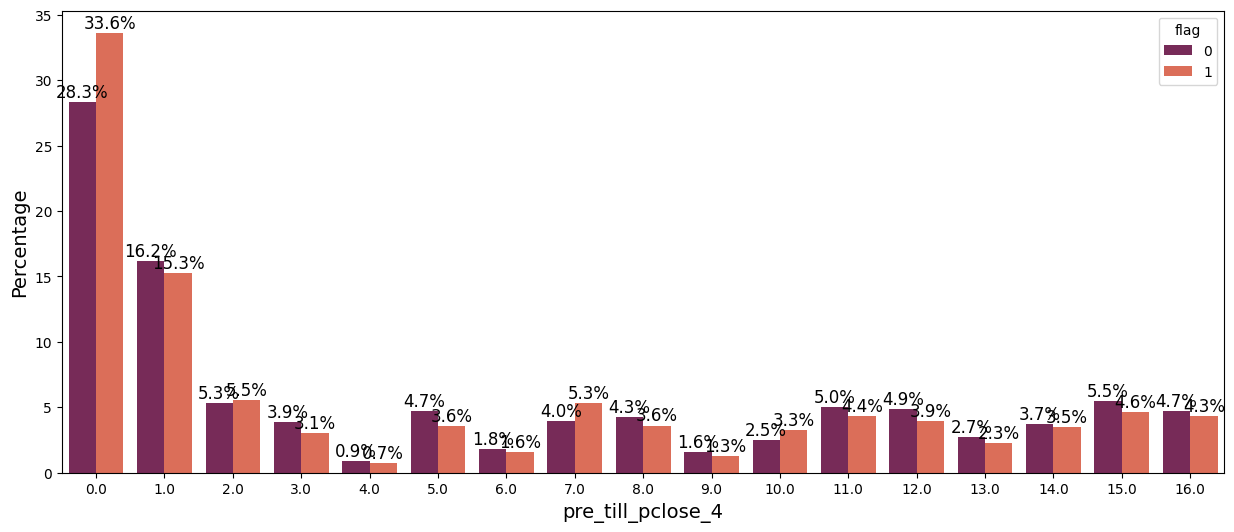

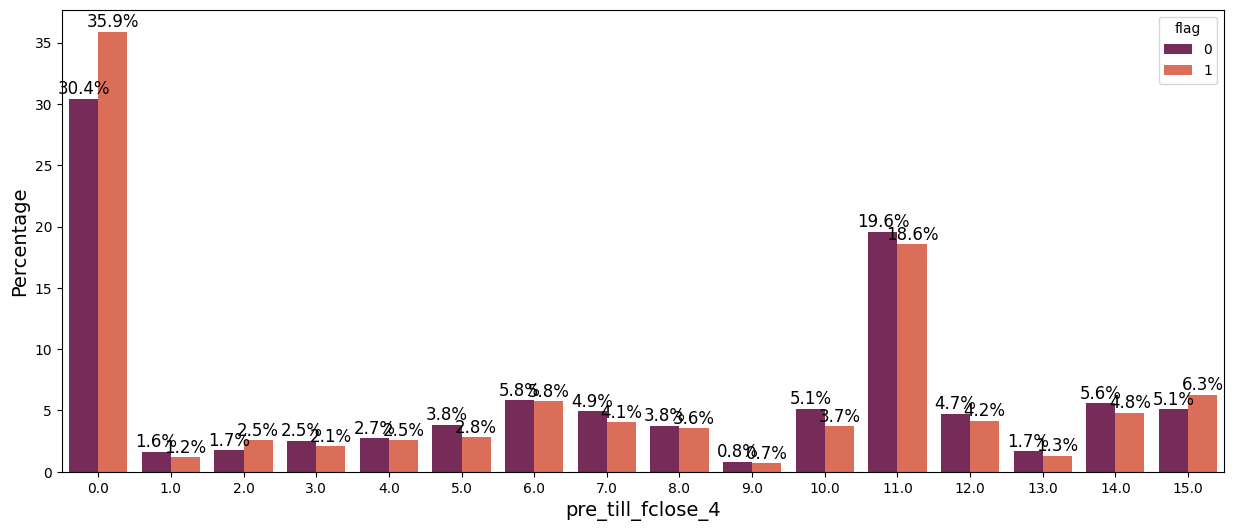

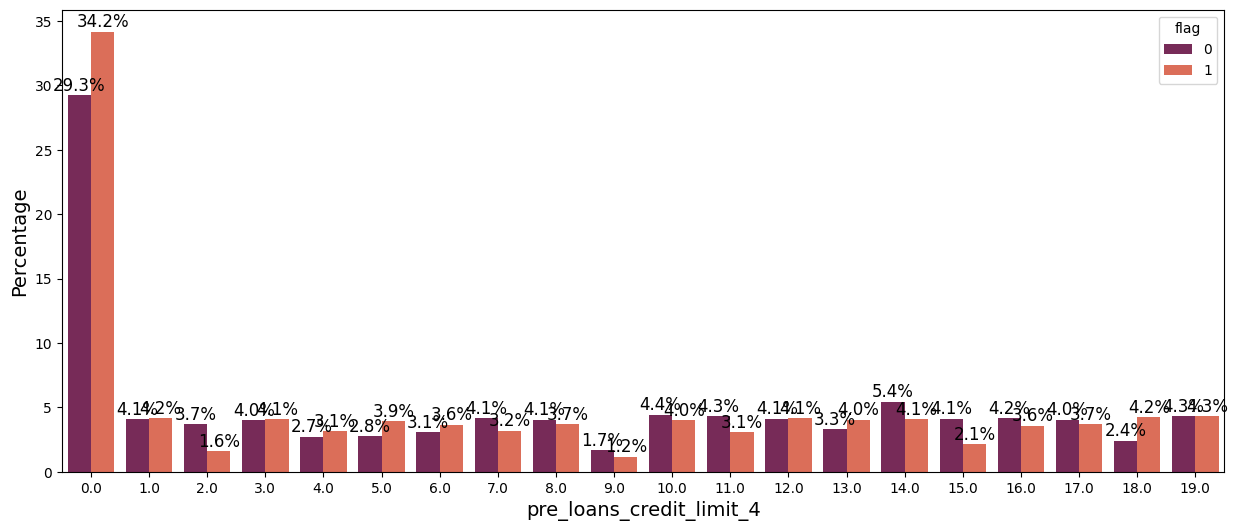

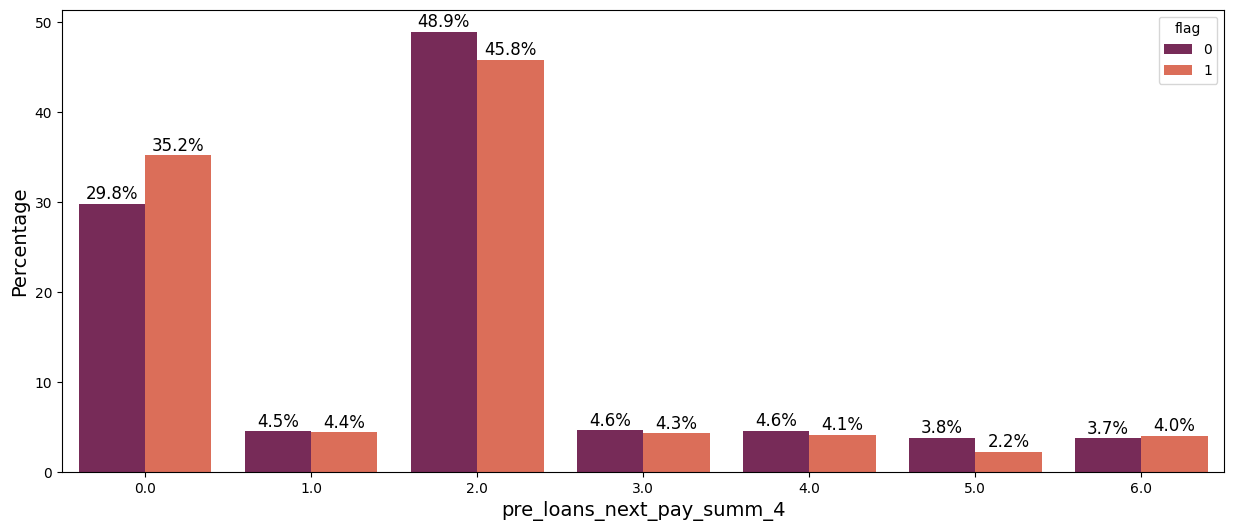

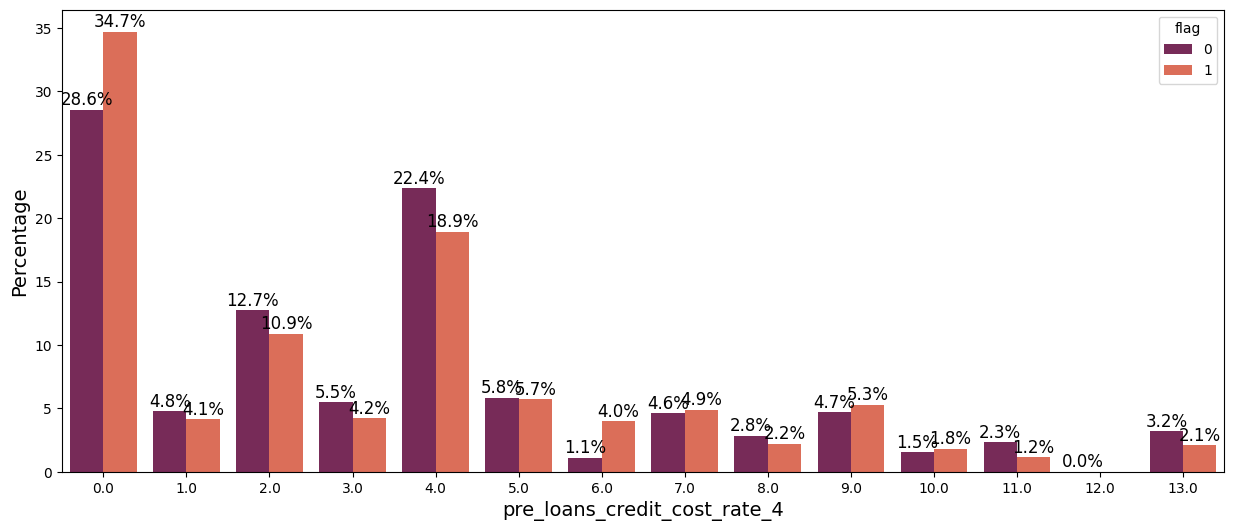

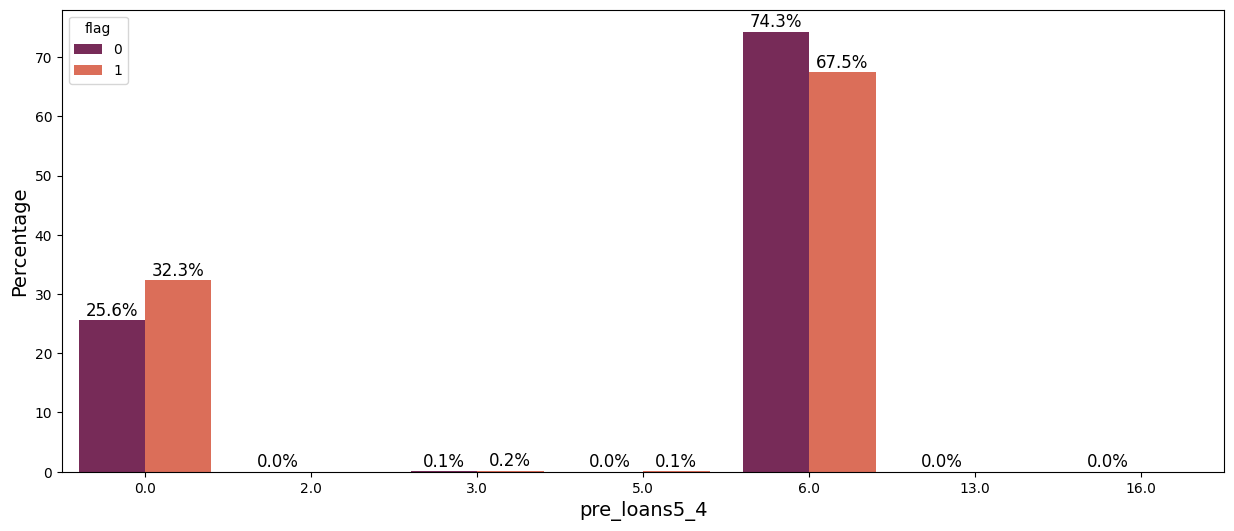

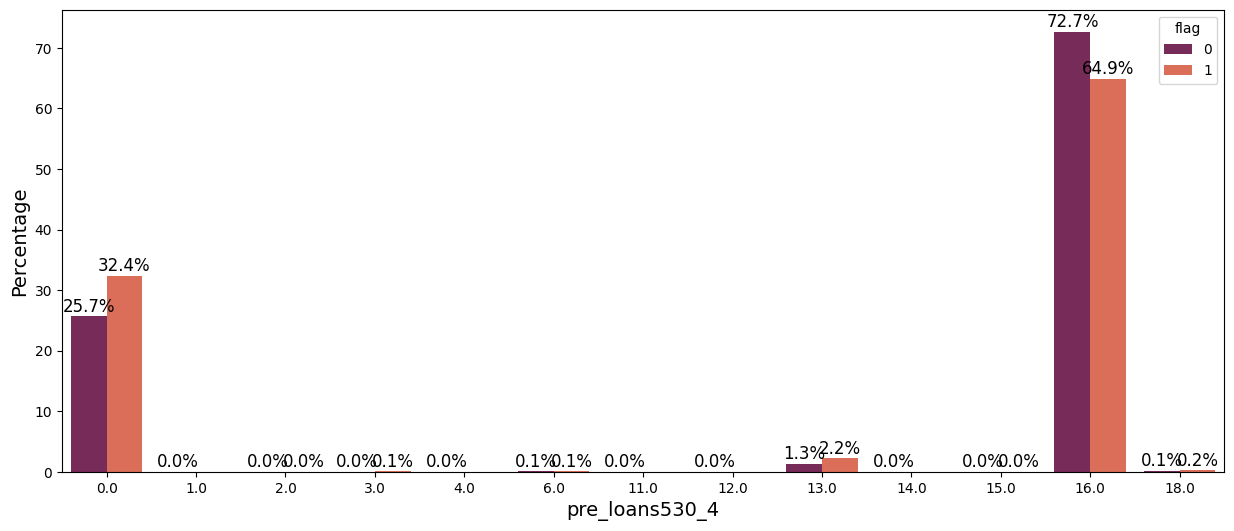

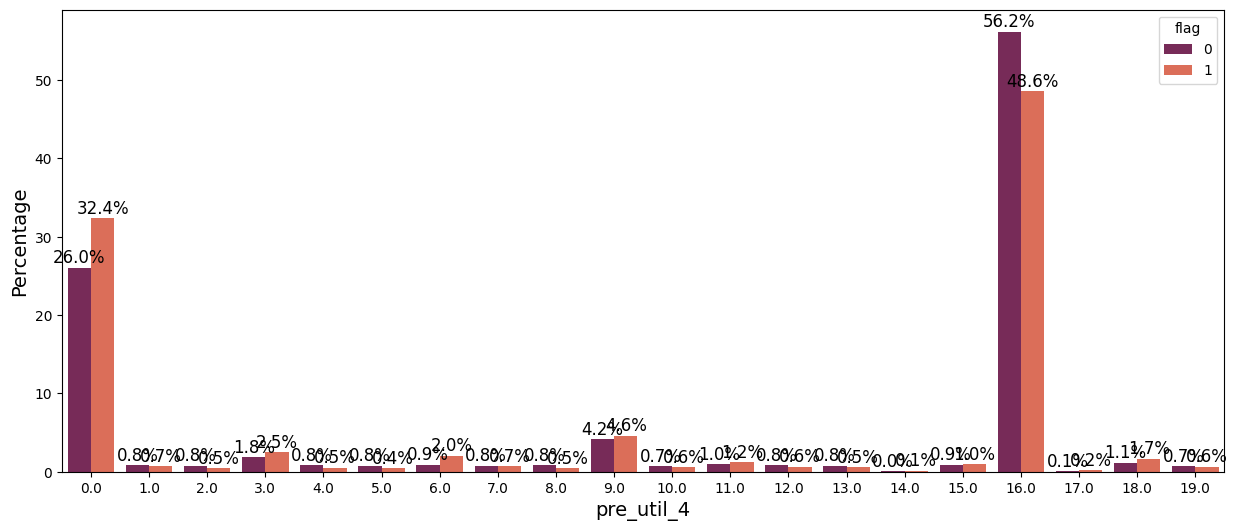

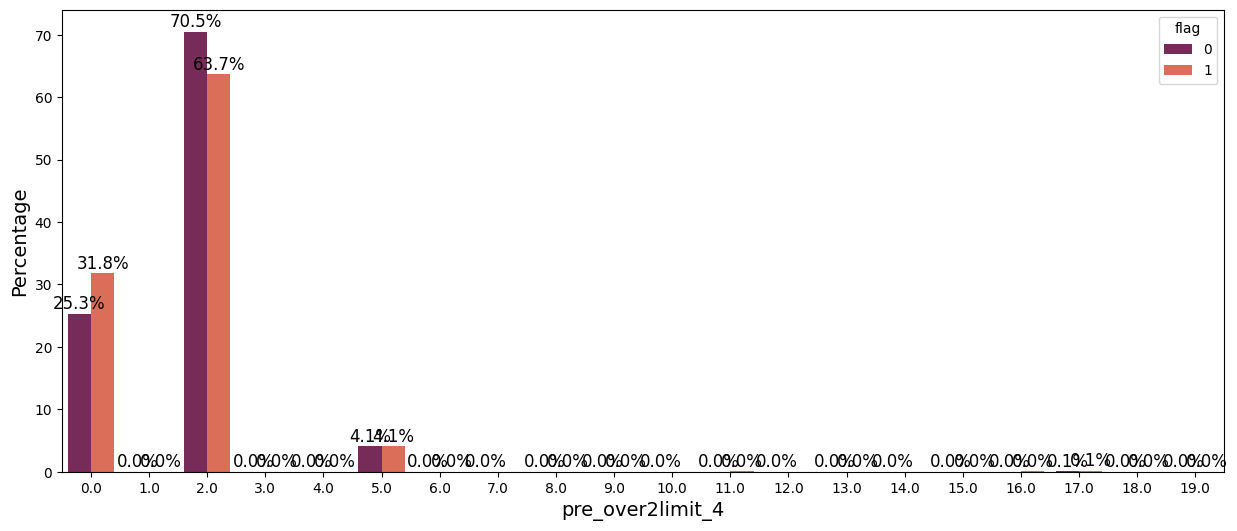

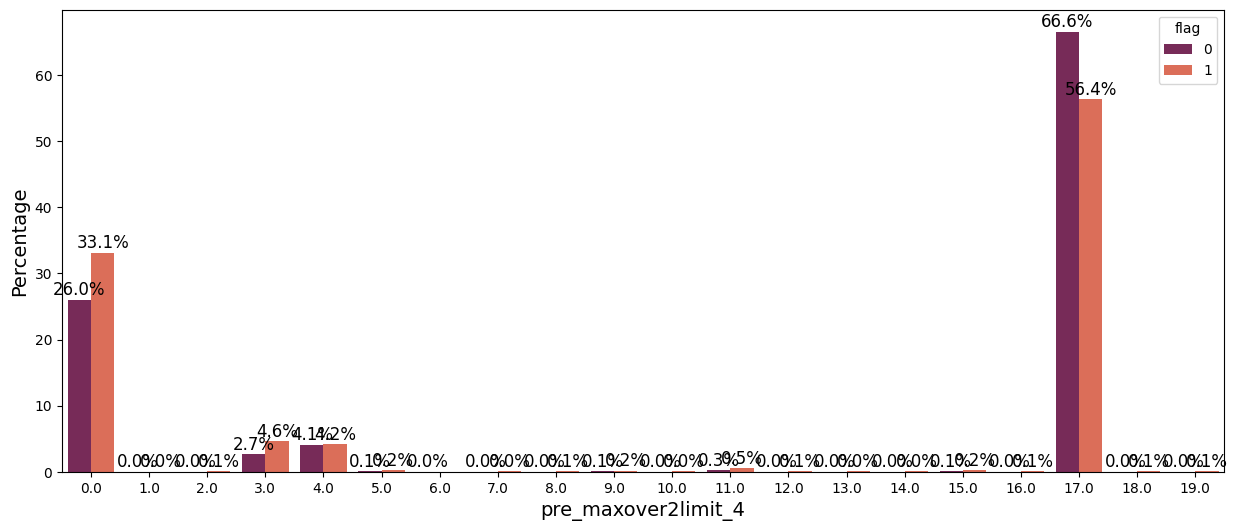

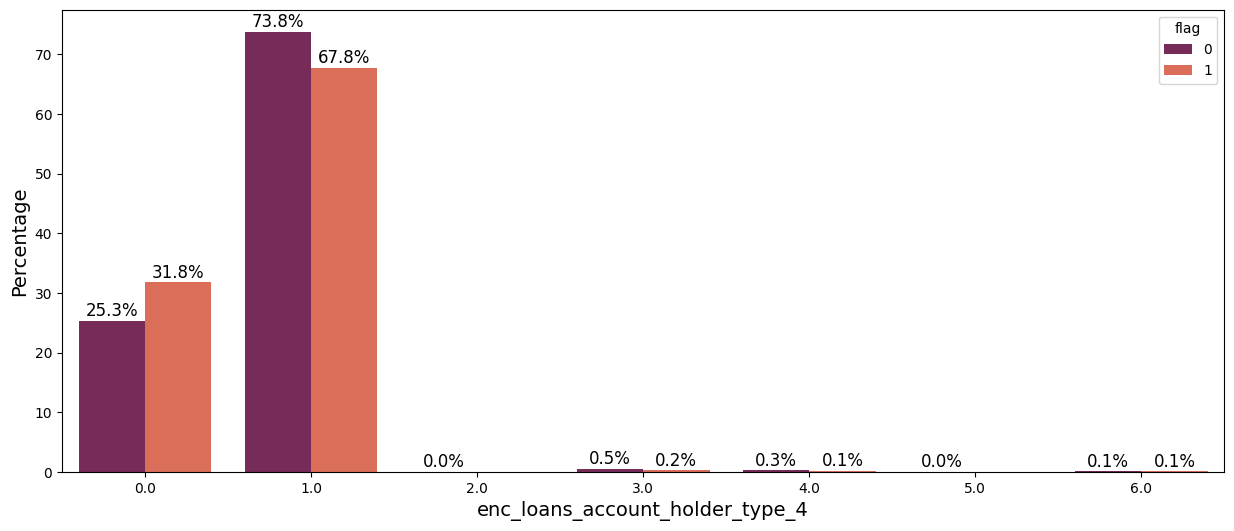

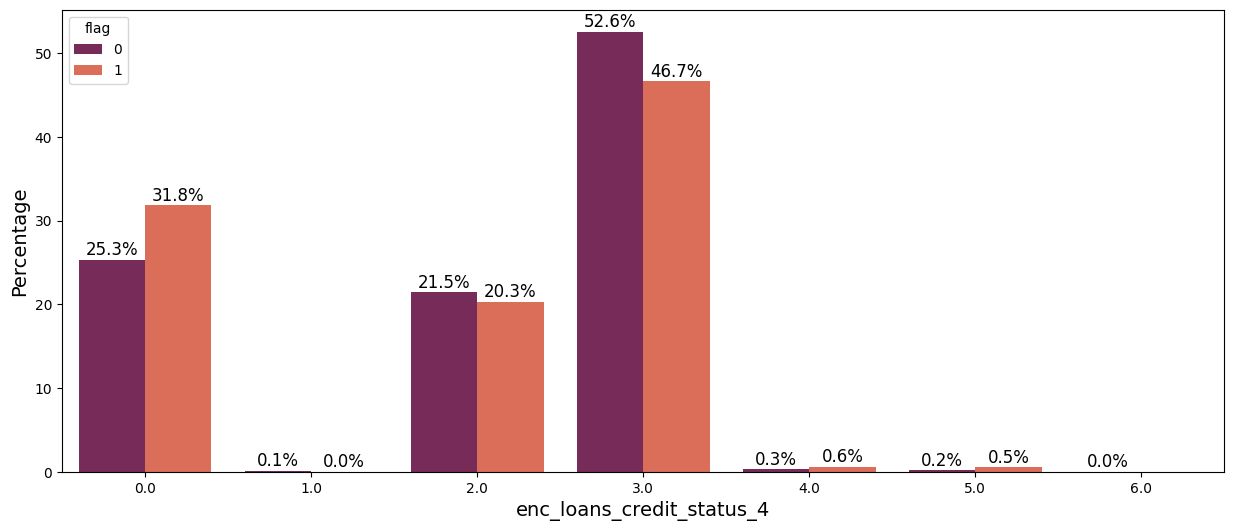

In [35]:
for col in df.nunique()[df.nunique() > 6].index:
    barplot_group(col, 'flag')

In [28]:
df = df.drop(columns=["pre_loans530", 
                      "pre_maxover2limit", 
                      "enc_loans_account_holder_type",
                      "enc_loans_credit_status"
                     ])

In [34]:
df.shape

(250000, 184)

In [1]:
category_columns = db.loc[:"enc_paym_0":"enc_loans_credit_type"].columns

NameError: name 'db' is not defined

In [49]:
for col in category_columns:
    try:
        df[col] = df[col].astype("category")
    except:
        pass
    try:
        df[col + "_2"] = df[col + "_2"].astype("category")
    except:
        pass
    try:
        df[col + "_3"] = df[col + "_3"].astype("category")
    except:
        pass
    try:
        df[col + "_4"] = df[col + "_4"].astype("category")
    except:
        pass

In [2]:
from eif import iForest

In [1]:
#Для поиска и удаления аномальных значений будет использован алгоритм Isolation Forest
#Из-за дисбаланса классов на вход алгоритму следует подавать только операции, по которым нет дефолта
column_eif = iForest(df[df["flag"]==0].values, ntrees=300, 
                     sample_size=128, ExtensionLevel=1)

NameError: name 'iForest' is not defined

In [32]:
S1 = column_eif.compute_paths(X_in = df[df["flag"]==0].values)

indexes_eif = np.argsort(S1)[-int(len(S1) * 0.05):]
df = df.drop(index=indexes_eif)

In [34]:
df.shape

(237887, 187)

In [52]:
X = df.drop(['flag'], axis=1)
Y = df['flag']

In [36]:
X[:5]

rn  pre_since_opened  pre_since_confirmed  pre_pterm  pre_fterm  \
id                                                                    
0   10                 7                    9          2         10   
1   14                12                    6          1          8   
2    3                12                    9          4          8   
3   15                12                    9          2         10   
4    1                12                    9          4          8   

    pre_till_pclose  pre_till_fclose  pre_loans_credit_limit  \
id                                                             
0                 8                8                      16   
1                14               11                      11   
2                 1               11                       1   
3                 8                8                      17   
4                 1               11                      12   

    pre_loans_next_pay_summ  pre_loans_outstanding  ...  enc_paym_7_4  \
id                                                  ...                 
0                         4                      2  ...           0.0   
1                         2                      3  ...           3.0   
2                         1                      4  ...           0.0   
3                         1                      2  ...           0.0   
4                         1                      3  ...           0.0   

    enc_paym_8_4  enc_paym_9_4  enc_paym_11_4  enc_paym_20_4  enc_paym_24_4  \
id                                                                            
0            3.0           3.0            4.0            4.0            4.0   
1            3.0           3.0            4.0            4.0            4.0   
2            0.0           0.0            0.0            0.0            0.0   
3            0.0           0.0            4.0            4.0            4.0   
4            0.0           0.0            0.0            0.0            0.0   

    enc_loans_account_holder_type_4  enc_loans_credit_status_4  \
id                                                               
0                               1.0                        3.0   
1                               1.0                        2.0   
2                               0.0                        0.0   
3                               1.0                        2.0   
4                               0.0                        0.0   

    enc_loans_credit_type_4  enc_loans_account_cur_4  
id                                                    
0                       4.0                      1.0  
1                       4.0                      1.0  
2                       0.0                      0.0  
3                       1.0                      1.0  
4                       0.0                      0.0  

[5 rows x 186 columns]

In [37]:
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler

In [53]:
pca = PCA(n_components=0.95, random_state=42)
embeding = pca.fit_transform(X)

In [54]:
embeding.shape

(250000, 43)

In [60]:
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

In [59]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 237887 entries, 0 to 249999
Columns: 186 entries, rn to enc_loans_account_cur_4
dtypes: category(85), float64(81), int64(20)
memory usage: 204.4 MB


In [50]:
ss = StandardScaler()

In [53]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, 
                                                    test_size=0.2, 
                                                    stratify=Y, 
                                                    random_state=RAND)

In [54]:
x_train_scl = ss.fit_transform(x_train)
x_test_scl = ss.transform(x_test)

In [55]:
model = LGBMClassifier(class_weight='balanced', random_state=RAND)
model.fit(x_train_scl, y_train)

LGBMClassifier(class_weight='balanced', random_state=42)

In [56]:
y_pred_tr = model.predict(x_train_scl)
y_score_tr = model.predict_proba(x_train_scl)

y_pred = model.predict(x_test_scl)
y_score = model.predict_proba(x_test_scl)

In [57]:
res = get_metrics(y_train, y_pred_tr, y_score_tr, name="lgbm_train")
res = res.append(get_metrics(y_test, y_pred, y_score, name="lgbm_test"))

/tmp/ipykernel_4496/158785131.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  res = res.append(get_metrics(y_test, y_pred, y_score, name="lgbm_test"))


In [58]:
res

model  Accuracy   ROC_AUC  Precision    Recall        f1   Logloss
0  lgbm_train  0.743717  0.853010   0.090398  0.800474  0.162451  0.509763
0   lgbm_test  0.736685  0.759522   0.073748  0.647258  0.132410  0.519068

id
26622     0
231457    0
74073     0
180800    0
236075    0
         ..
149481    0
215471    0
25600     0
105892    0
43473     0
Name: flag, Length: 190309, dtype: int64

In [64]:
weight = y_train[y_train==0].shape[0] / y_train[y_train==1].shape[0]
weight

31.206633948214588

In [66]:
model = CatBoostClassifier(scale_pos_weight=weight, random_state=RAND, verbose=0)
model.fit(x_train_scl, y_train)

In [67]:
y_pred_tr = model.predict(x_train_scl)
y_score_tr = model.predict_proba(x_train_scl)

y_pred = model.predict(x_test_scl)
y_score = model.predict_proba(x_test_scl)

In [68]:
res = res.append(get_metrics(y_train, y_pred_tr, y_score_tr, name="catboost_train"))
res = res.append(get_metrics(y_test, y_pred, y_score, name="catboost_test"))

/tmp/ipykernel_4496/1045409491.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  res = res.append(get_metrics(y_train, y_pred_tr, y_score_tr, name="catboost_train"))
/tmp/ipykernel_4496/1045409491.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  res = res.append(get_metrics(y_test, y_pred, y_score, name="catboost_test"))


In [69]:
res

model  Accuracy   ROC_AUC  Precision    Recall        f1   Logloss
0      lgbm_train  0.743717  0.853010   0.090398  0.800474  0.162451  0.509763
0       lgbm_test  0.736685  0.759522   0.073748  0.647258  0.132410  0.519068
0  catboost_train  0.881619  0.972719   0.203278  0.963446  0.335722  0.317788
0   catboost_test  0.850876  0.723326   0.089327  0.413676  0.146928  0.359186

In [63]:
model = RandomForestClassifier(class_weight='balanced', random_state=RAND)
model.fit(x_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [64]:
y_pred_tr = model.predict(x_train)
y_score_tr = model.predict_proba(x_train)

y_pred = model.predict(x_test)
y_score = model.predict_proba(x_test)

In [65]:
res = res.append(get_metrics(y_train, y_pred_tr, y_score_tr, "RF_tr"))
res = res.append(get_metrics(y_test, y_pred, y_score, "RF_t"))
res

/tmp/ipykernel_29369/125579541.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  res = res.append(get_metrics(y_train, y_pred_tr, y_score_tr, "RF_tr"))
/tmp/ipykernel_29369/125579541.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  res = res.append(get_metrics(y_test, y_pred, y_score, "RF_t"))


model  Accuracy   ROC_AUC  Precision    Recall        f1   Logloss
0  lgbm_test  0.698860  0.714345   0.061022  0.606981  0.110895  0.571906
0      RF_tr  0.995855  0.998515   0.884141  0.996606  0.937011  0.028075
0       RF_t  0.964740  0.642046   0.102941  0.018100  0.030786  0.334651

In [68]:
model = LogisticRegression(class_weight='balanced', random_state=RAND)
model.fit(x_train, y_train)

/home/sergey/virtual_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(class_weight='balanced', random_state=42)

In [69]:
y_pred_tr = model.predict(x_train)
y_score_tr = model.predict_proba(x_train)

y_pred = model.predict(x_test)
y_score = model.predict_proba(x_test)

In [70]:
res = res.append(get_metrics(y_train, y_pred_tr, y_score_tr, "LG_tr"))
res = res.append(get_metrics(y_test, y_pred, y_score, "LG_t"))
res

/tmp/ipykernel_29369/638020818.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  res = res.append(get_metrics(y_train, y_pred_tr, y_score_tr, "LG_tr"))
/tmp/ipykernel_29369/638020818.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  res = res.append(get_metrics(y_test, y_pred, y_score, "LG_t"))


model  Accuracy   ROC_AUC  Precision    Recall        f1   Logloss
0  lgbm_test  0.698860  0.714345   0.061022  0.606981  0.110895  0.571906
0      RF_tr  0.995855  0.998515   0.884141  0.996606  0.937011  0.028075
0       RF_t  0.964740  0.642046   0.102941  0.018100  0.030786  0.334651
0      LG_tr  0.618685  0.683629   0.051393  0.648780  0.095241  0.642123
0       LG_t  0.617680  0.680340   0.051239  0.648352  0.094972  0.642936